In [2]:
from astropy.io import ascii
from astropy.table import Table,QTable
import numpy as np
import numpy.ma as ma
#import pandas as pd
#import corner
import matplotlib.pyplot as plt
#%matplotlib notebook
#import emcee
from astropy.io import fits
from astropy.table import Table, QTable

import sys
sys.path.insert(1, '/Users/richardzhang/Documents/UR_Stuff/Research_UR/RotationCurve/2D_RC/main/')
#sys.path.insert(1, '/Users/kellydouglass/Documents/Research/Rotation_curves/Yifan_Zhang/RotationCurve/2D_RC/main/')
from RC_2D_Fit_Functions import Galaxy_Data, getTidal
from Velocity_Map_Functions_cython import rot_incl_iso, rot_incl_NFW, rot_incl_bur

MANGA_FOLDER = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/SDSS/dr17/manga/spectro/'
#MANGDA_FOLDER = '/home/yzh250/Documents/UR_Stuff/Research_UR/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'

DRP_FILENAME = MANGA_FOLDER + 'redux/v3_1_1/drpall-v3_1_1.fits'

VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v3_1_1/3.1.0/HYB10-GAU-MILESHC/'

from Velocity_Map_Functions_cython import rot_incl_iso,\
                                          rot_incl_NFW, \
                                          rot_incl_bur           

from galaxy_component_functions_cython import vel_tot_iso,\
                                              vel_tot_NFW,\
                                              vel_tot_bur,\
                                              bulge_vel,\
                                              disk_vel,\
                                              halo_vel_iso,\
                                              halo_vel_NFW,\
                                              halo_vel_bur
from RC_2D_Fit_Functions import Galaxy_Data, \
                                Galaxy_Fitting_iso,\
                                Galaxy_Fitting_NFW, \
                                Galaxy_Fitting_bur, \
                                Hessian_Calculation_Isothermal,\
                                Hessian_Calculation_NFW,\
                                Hessian_Calculation_Burket,\
                                Plotting_Isothermal,\
                                Plotting_NFW,\
                                Plotting_Burkert,\
                                getTidal,\
                                deproject_spaxel,\
                                plot_rot_curve,\
                                plot_diagnostic_panel,\
                                run_MCMC

In [3]:
################################################################################
# Physics Constants
#-------------------------------------------------------------------------------
c = 3E5 # km * s ^1
h = 1 # reduced hubble constant
H_0 =  100 * h # km * s^-1 * Mpc^-1
q0 = 0.2 # minimum inclination value
################################################################################

# DRP all table
DTable =  Table.read(DRP_FILENAME, format='fits')

#MTable =  Table.read(MORPH_file, format='fits')

DRP_index = {}

for i in range(len(DTable)):
    gal_ID = DTable['plateifu'][i]

    DRP_index[gal_ID] = i
    
m = DTable['nsa_elpetro_mass']
rat = DTable['nsa_elpetro_ba']
phi = DTable['nsa_elpetro_phi']
z = DTable['nsa_z']
r50_ang = DTable['nsa_elpetro_th50_r']

In [4]:
iso_mini_fits = Table.read('iso_mini_clean2.csv',format='ascii.csv')
nfw_mini_fits = Table.read('nfw_mini_clean2.csv',format='ascii.csv')
bur_mini_fits = Table.read('bur_mini_clean2.csv',format='ascii.csv')

In [5]:
iso_mini_fits

<Table length=3629>
 galaxy_ID       smoothness     ...         Vsys               chi2       
   str11          float64       ...       float64            float64      
----------- ------------------- ... ------------------- ------------------
10001-12701   1.560186343059074 ...   2.597767545541191  34.01136626275301
10001-12702  1.5619979358006435 ...   3.682228085590581  5.870467141112022
10001-12705   1.116217114299689 ... -20.552997291321674  44.51862360648296
 10001-1901  1.2054986454566976 ... -19.032971700772283  22.78812178550655
 10001-3702  1.4364336310030654 ... -0.5412580295328184 10.946061251162368
 10001-3703  0.8464522553718801 ... -13.149157920635488  85.79243466149134
10213-12702  1.5817074533236228 ... -2.7945094559053696 20.426713528207365
10213-12703   1.809667600081271 ...  25.888850404618537   6.22482051750546
10213-12705  0.7079952451135839 ...   7.387555324841264  37.29586616893832
 10213-6103  1.4979538645692894 ... -2.8220626116080982 14.399268369140461
        ...                 ... ...                 ...                ...
  9893-9102  1.8153450657320056 ... -1.7835539503206514   4.70610635842259
 9894-12701  1.1439737713886051 ...  -6.557144123931929 3.8030985583625476
 9894-12704  0.8427899334881757 ... -18.262522142225084 26.353065193492974
 9894-12705  1.2424254413858289 ...  11.441317070911511  76.76997910244388
  9894-1902  0.8626063197709938 ...   -9.11247450924696  9.106448366209765
  9894-3701  1.2284519706497887 ...  -10.04554734100687 10.580921668512547
  9894-3702   0.564601061815884 ...    3.24976678791357 58.437830319207144
  9894-6102  1.1781794029896653 ... -1.3252718335326437  9.235604366241894
  9894-6103  1.0128618048492974 ...  -2.735882863147324  4.193986557591673
  9894-6104 0.37198274913883633 ...  -2.881325987591835  70.89837391030022

In [6]:
iso_mini_fits_mc_corr = Table.read('iso_mini_mc_corr.csv',format='ascii.csv')
nfw_mini_fits_mc_corr = Table.read('nfw_mini_mc_corr.csv',format='ascii.csv')
bur_mini_fits_mc_corr = Table.read('bur_mini_mc_corr.csv',format='ascii.csv')

In [7]:
def vel_map_depro(mHa_vel, best_fit_values, scale):
    i_angle = best_fit_values[6]#np.arccos(best_fit_values['ba'])
    ############################################################################


    ############################################################################
    # Convert rotation angle from degrees to radians
    #---------------------------------------------------------------------------
    phi = best_fit_values[7]
    ############################################################################


    ############################################################################
    # Deproject all data values in the given velocity map
    #---------------------------------------------------------------------------
    vel_array_shape = mHa_vel.shape

    r_deproj = np.zeros(vel_array_shape)
    v_deproj = np.zeros(vel_array_shape)

    theta = np.zeros(vel_array_shape)

    for i in range(vel_array_shape[0]):
        for j in range(vel_array_shape[1]):

            r_deproj[i,j], theta[i,j] = deproject_spaxel((i,j), 
                                                         (best_fit_values[8], best_fit_values[9]), 
                                                         phi, 
                                                         i_angle)

            ####################################################################
            # Find the sign of r_deproj
            #-------------------------------------------------------------------
            if np.cos(theta[i,j]) < 0:
                r_deproj[i,j] *= -1
            ####################################################################

    # Scale radii to convert from spaxels to kpc
    r_deproj *= scale

    # Deproject velocity values
    v_deproj = (mHa_vel - best_fit_values[10])/np.abs(np.cos(theta))
    v_deproj /= np.sin(i_angle)

    # Apply mask to arrays
    rm_deproj = ma.array(r_deproj, mask=mHa_vel.mask)
    vm_deproj = ma.array(v_deproj, mask=mHa_vel.mask)
    
    return rm_deproj, vm_deproj

In [8]:
def rot_curve(best_fit_values,halo_model):
    r = np.linspace(0,1000,5000)
    
    v_b = np.zeros(len(r))
    v_d = np.zeros(len(r))
    v_h = np.zeros(len(r))
    v = np.zeros(len(r))
    
    for oo in range(len(r)):
        if r[oo] > 0:
            v_b[oo] = bulge_vel(r[oo]*1000,best_fit_values[0],best_fit_values[1]*1000)
            v_d[oo] = disk_vel(r[oo]*1000,best_fit_values[2],best_fit_values[3]*1000)
            if halo_model == 'Isothermal':
                v_h[oo] = halo_vel_iso(r[oo]*1000,best_fit_values[4],best_fit_values[5]*1000)
                v[oo] = vel_tot_iso(r[oo],best_fit_values[0],best_fit_values[1],best_fit_values[2],best_fit_values[3],best_fit_values[4],best_fit_values[5])
            elif halo_model == 'NFW':
                v_h[oo] = halo_vel_NFW(r[oo]*1000,best_fit_values[4],best_fit_values[5]*1000)
                v[oo] = vel_tot_NFW(r[oo],best_fit_values[0],best_fit_values[1],best_fit_values[2],best_fit_values[3],best_fit_values[4],best_fit_values[5])
            elif halo_model == 'Burkert':
                v_h[oo] = halo_vel_bur(r[oo]*1000,best_fit_values[4],best_fit_values[5]*1000)
                v[oo] = vel_tot_bur(r[oo],best_fit_values[0],best_fit_values[1],best_fit_values[2],best_fit_values[3],best_fit_values[4],best_fit_values[5])
            else:
                print('Fit function not known.  Please update plot_rot_curve function.')
        else:
            v_b[oo] = -bulge_vel(np.abs(r[oo]*1000),best_fit_values[0],best_fit_values[1]*1000)
            v_d[oo] = -disk_vel(np.abs(r[oo]*1000),best_fit_values[2],best_fit_values[3]*1000)
            if halo_model == 'Isothermal':
                v_h[oo] = -halo_vel_iso(np.abs(r[oo]*1000),best_fit_values[4],best_fit_values[5]*1000)
                v[oo] = -vel_tot_iso(np.abs(r[oo]),best_fit_values[0],best_fit_values[1],best_fit_values[2],best_fit_values[3],best_fit_values[4],best_fit_values[5])
            elif halo_model == 'NFW':
                v_h[oo] = -halo_vel_NFW(np.abs(r[oo]*1000),best_fit_values[4],best_fit_values[5]*1000)
                v[oo] = -vel_tot_NFW(np.abs(r[oo]),best_fit_values[0],best_fit_values[1],best_fit_values[2],best_fit_values[3],best_fit_values[4],best_fit_values[5])
            elif halo_model == 'Burkert':
                v_h[oo] = -halo_vel_bur(np.abs(r[oo]*1000),best_fit_values[4],best_fit_values[5]*1000)
                v[oo] = -vel_tot_bur(np.abs(r[oo]),best_fit_values[0],best_fit_values[1],best_fit_values[2],best_fit_values[3],best_fit_values[4],best_fit_values[5])
            else:
                print('Fit function not known.  Please update plot_rot_curve function.')
    return r, v_b, v_d, v_h, v

In [9]:
def get_info(galaxy_ID,fit_cat_mini,fit_cat_mcmc, r90_file, flag):
    
    j = DRP_index[galaxy_ID]

    redshift = z[j]
    velocity =  redshift* c
    distance = (velocity / H_0) * 1000 #kpc
    scale = 0.5 * distance / 206265
    
    #incl = np.arccos(rat[j])
    cosi2 = (rat[j]**2 - q0**2)/(1 - q0**2)
    if cosi2 < 0:
        cosi2 = 0

    incl = np.arccos(np.sqrt(cosi2))
    
    plate, IFU = galaxy_ID.split('-')
    cube = fits.open('manga-' + galaxy_ID + '-MAPS-HYB10-MILESHC-MASTARSSP.fits.gz')
    maps = {}

    # bluehive
    maps['r_band'] = cube['SPX_MFLUX'].data
    maps['Ha_vel'] = cube['EMLINE_GVEL'].data[23]
    maps['Ha_vel_ivar'] = cube['EMLINE_GVEL_IVAR'].data[23]
    maps['Ha_vel_mask'] = cube['EMLINE_GVEL_MASK'].data[23]


    maps['vmasked'] = ma.array(maps['Ha_vel'], mask=maps['Ha_vel_mask'])
    #maps['r_band_masked'] = ma.array(maps['r_band'],mask=maps['Ha_vel_mask'])
    maps['ivar_masked'] = ma.array(maps['Ha_vel_ivar'], mask=maps['Ha_vel_mask'])

    gshape = maps['vmasked'].shape
    ############################################################################

    # Ha flux
    maps['Ha_flux'] = cube['EMLINE_GFLUX'].data[23]
    maps['Ha_flux_ivar'] = cube['EMLINE_GFLUX_IVAR'].data[23]
    maps['Ha_flux_mask'] = cube['EMLINE_GFLUX_MASK'].data[23]
    maps['Ha_flux_masked'] = ma.array(maps['Ha_flux'], mask=maps['Ha_flux_mask'])
    
    SN_map = maps['Ha_flux'] * np.sqrt(maps['Ha_flux_ivar'])
    Ha_vel_mask = maps['Ha_vel_mask'] + (SN_map < 5)

    vmasked = ma.array(maps['Ha_vel'], mask = Ha_vel_mask)
    ivar_masked = ma.array(maps['Ha_vel_ivar'], mask = Ha_vel_mask)
    
    for ii in range(len(fit_cat_mini)):
        if fit_cat_mini['galaxy_ID'][ii] == galaxy_ID:
            mini_fit = list(fit_cat_mini[ii])
            mcmc_fit = list(fit_cat_mcmc[ii])
            chi2_mini = mini_fit[-1]
            chi2_mcmc = mcmc_fit[-1]
            mini_fit = mini_fit[3:-1]
            mcmc_fit = mcmc_fit[3:-1]
    
    #print(str(galaxy_ID) + ' minimize fit: ')
    #print(mini_fit)
    #print(str(galaxy_ID) + ' mcmc fit: ')
    #print(mcmc_fit)
    
    f_r90 = Table.read(r90_file,format='ascii.csv')
    
    r90 = 0
    for jj in range(len(f_r90)):
        if f_r90['galaxy_ID'][jj] == galaxy_ID:
            r90 = f_r90['r90'][jj]
            
    if flag == 'iso':
            
        fitted_map_minimize = rot_incl_iso(gshape, scale, mini_fit)

        mfitted_map_minimize = ma.array(fitted_map_minimize, mask=Ha_vel_mask)

        fitted_map_mcmc = rot_incl_iso(gshape, scale, mcmc_fit)

        mfitted_map_mcmc = ma.array(fitted_map_mcmc, mask=Ha_vel_mask)
        
        r_mini, v_b_mini, v_d_mini, v_h_mini, v_mini = rot_curve(mini_fit,'Isothermal')
        r_mcmc, v_b_mcmc, v_d_mcmc, v_h_mcmc, v_mcmc = rot_curve(mcmc_fit,'Isothermal')
        
    elif flag == 'nfw':
            
        fitted_map_minimize = rot_incl_NFW(gshape, scale, mini_fit)

        mfitted_map_minimize = ma.array(fitted_map_minimize, mask=Ha_vel_mask)

        fitted_map_mcmc = rot_incl_NFW(gshape, scale, mcmc_fit)

        mfitted_map_mcmc = ma.array(fitted_map_mcmc, mask=Ha_vel_mask)
        
        r_mini, v_b_mini, v_d_mini, v_h_mini, v_mini = rot_curve(mini_fit,'NFW')
        r_mcmc, v_b_mcmc, v_d_mcmc, v_h_mcmc, v_mcmc = rot_curve(mcmc_fit,'NFW')
        
    elif flag == 'bur':
            
        fitted_map_minimize = rot_incl_bur(gshape, scale, mini_fit)

        mfitted_map_minimize = ma.array(fitted_map_minimize, mask=Ha_vel_mask)

        fitted_map_mcmc = rot_incl_bur(gshape, scale, mcmc_fit)

        mfitted_map_mcmc = ma.array(fitted_map_mcmc, mask=Ha_vel_mask)
        
        r_mini, v_b_mini, v_d_mini, v_h_mini, v_mini = rot_curve(mini_fit,'Burkert')
        r_mcmc, v_b_mcmc, v_d_mcmc, v_h_mcmc, v_mcmc = rot_curve(mcmc_fit,'Burkert')

    return vmasked, ivar_masked, incl, scale, r90, mini_fit, mcmc_fit, mfitted_map_minimize, mfitted_map_mcmc, chi2_mini, chi2_mcmc, r_mini, v_b_mini, v_d_mini, v_h_mini, v_mini, r_mcmc, v_b_mcmc, v_d_mcmc, v_h_mcmc, v_mcmc

In [11]:
r90_file = '/Users/richardzhang/Documents/UR_Stuff/Research_UR/RotationCurve/2D_RC/main/r90.csv'
# Improved chi2
dmap_10001_12704, ivar_masked_10001_12704, incl_10001_12704, scale_10001_12704, r90_10001_12704, mini_fit_10001_12704, mcmc_fit_10001_12704, mini_map_10001_12704, mcmc_map_10001_12704, chi2_mini_10001_12704, chi2_mcmc_10001_12704,r_mini_10001_12704, v_b_mini_10001_12704, v_d_mini_10001_12704, v_h_mini_10001_12704, v_mini_10001_12704, r_mcmc_10001_12704, v_b_mcmc_10001_12704, v_d_mcmc_10001_12704, v_h_mcmc_10001_12704, v_mcmc_10001_12704  = get_info('10001-12704',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10213_6103, ivar_masked_10213_6103, incl_10213_6103, scale_10213_6103, r90_10213_6103, mini_fit_10213_6103, mcmc_fit_10213_6103, mini_map_10213_6103, mcmc_map_10213_6103, chi2_mini_10213_6103, chi2_mcmc_10213_6103,r_mini_10213_6103, v_b_mini_10213_6103, v_d_mini_10213_6103, v_h_mini_10213_6103, v_mini_10213_6103, r_mcmc_10213_6103, v_b_mcmc_10213_6103, v_d_mcmc_10213_6103, v_h_mcmc_10213_6103, v_mcmc_10213_6103  = get_info('10213-6103',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10213_12703, ivar_masked_10213_12703, incl_10213_12703, scale_10213_12703, r90_10213_12703, mini_fit_10213_12703, mcmc_fit_10213_12703, mini_map_10213_12703, mcmc_map_10213_12703, chi2_mini_10213_12703, chi2_mcmc_10213_12703,r_mini_10213_12703, v_b_mini_10213_12703, v_d_mini_10213_12703, v_h_mini_10213_12703, v_mini_10213_12703, r_mcmc_10213_12703, v_b_mcmc_10213_12703, v_d_mcmc_10213_12703, v_h_mcmc_10213_12703, v_mcmc_10213_12703  = get_info('10213-12703',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10215_12702, ivar_masked_10215_12702, incl_10215_12702, scale_10215_12702, r90_10215_12702, mini_fit_10215_12702, mcmc_fit_10215_12702, mini_map_10215_12702, mcmc_map_10215_12702, chi2_mini_10215_12702, chi2_mcmc_10215_12702,r_mini_10215_12702, v_b_mini_10215_12702, v_d_mini_10215_12702, v_h_mini_10215_12702, v_mini_10215_12702, r_mcmc_10215_12702, v_b_mcmc_10215_12702, v_d_mcmc_10215_12702, v_h_mcmc_10215_12702, v_mcmc_10215_12702  = get_info('10215-12702',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10215_12704, ivar_masked_10215_12704, incl_10215_12704, scale_10215_12704, r90_10215_12704, mini_fit_10215_12704, mcmc_fit_10215_12704, mini_map_10215_12704, mcmc_map_10215_12704, chi2_mini_10215_12704, chi2_mcmc_10215_12704,r_mini_10215_12704, v_b_mini_10215_12704, v_d_mini_10215_12704, v_h_mini_10215_12704, v_mini_10215_12704, r_mcmc_10215_12704, v_b_mcmc_10215_12704, v_d_mcmc_10215_12704, v_h_mcmc_10215_12704, v_mcmc_10215_12704  = get_info('10215-12704',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
# Lost from chi2 > 150
dmap_10219_6103, ivar_masked_10219_6103, incl_10219_6103, scale_10219_6103, r90_10219_6103, mini_fit_10219_6103, mcmc_fit_10219_6103, mini_map_10219_6103, mcmc_map_10219_6103, chi2_mini_10219_6103, chi2_mcmc_10219_6103,r_mini_10219_6103, v_b_mini_10219_6103, v_d_mini_10219_6103, v_h_mini_10219_6103, v_mini_10219_6103, r_mcmc_10219_6103, v_b_mcmc_10219_6103, v_d_mcmc_10219_6103, v_h_mcmc_10219_6103, v_mcmc_10219_6103  = get_info('10219-6103',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10219_9102, ivar_masked_10219_9102, incl_10219_9102, scale_10219_9102, r90_10219_9102, mini_fit_10219_9102, mcmc_fit_10219_9102, mini_map_10219_9102, mcmc_map_10219_9102, chi2_mini_10219_9102, chi2_mcmc_10219_9102,r_mini_10219_9102, v_b_mini_10219_9102, v_d_mini_10219_9102, v_h_mini_10219_9102, v_mini_10219_9102, r_mcmc_10219_9102, v_b_mcmc_10219_9102, v_d_mcmc_10219_9102, v_h_mcmc_10219_9102, v_mcmc_10219_9102  = get_info('10219-9102',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10215_1901, ivar_masked_10215_1901, incl_10215_1901, scale_10215_1901, r90_10215_1901, mini_fit_10215_1901, mcmc_fit_10215_1901, mini_map_10215_1901, mcmc_map_10215_1901, chi2_mini_10215_1901, chi2_mcmc_10215_1901,r_mini_10215_1901, v_b_mini_10215_1901, v_d_mini_10215_1901, v_h_mini_10215_1901, v_mini_10215_1901, r_mcmc_10215_1901, v_b_mcmc_10215_1901, v_d_mcmc_10215_1901, v_h_mcmc_10215_1901, v_mcmc_10215_1901  = get_info('10215-1901',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10215_1902, ivar_masked_10215_1902, incl_10215_1902, scale_10215_1902, r90_10215_1902, mini_fit_10215_1902, mcmc_fit_10215_1902, mini_map_10215_1902, mcmc_map_10215_1902, chi2_mini_10215_1902, chi2_mcmc_10215_1902,r_mini_10215_1902, v_b_mini_10215_1902, v_d_mini_10215_1902, v_h_mini_10215_1902, v_mini_10215_1902, r_mcmc_10215_1902, v_b_mcmc_10215_1902, v_d_mcmc_10215_1902, v_h_mcmc_10215_1902, v_mcmc_10215_1902  = get_info('10215-1902',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')
dmap_10215_3701, ivar_masked_10215_3701, incl_10215_3701, scale_10215_3701, r90_10215_3701, mini_fit_10215_3701, mcmc_fit_10215_3701, mini_map_10215_3701, mcmc_map_10215_3701, chi2_mini_10215_3701, chi2_mcmc_10215_3701,r_mini_10215_3701, v_b_mini_10215_3701, v_d_mini_10215_3701, v_h_mini_10215_3701, v_mini_10215_3701, r_mcmc_10215_3701, v_b_mcmc_10215_3701, v_d_mcmc_10215_3701, v_h_mcmc_10215_3701, v_mcmc_10215_3701  = get_info('10215-3701',nfw_mini_fits,nfw_mini_fits_mc_corr,r90_file,'nfw')

In [32]:
# Deprojected velocity maps
# Improved
rm_deproj_mini_10001_12704, vm_deproj_mini_10001_12704 = vel_map_depro(dmap_10001_12704, mini_fit_10001_12704, scale_10001_12704)
rm_deproj_mcmc_10001_12704, vm_deproj_mcmc_10001_12704 = vel_map_depro(dmap_10001_12704, mcmc_fit_10001_12704, scale_10001_12704)
rm_deproj_mini_10213_6103, vm_deproj_mini_10213_6103 = vel_map_depro(mini_map_10213_6103, mini_fit_10213_6103, scale_10213_6103)
rm_deproj_mcmc_10213_6103, vm_deproj_mcmc_10213_6103 = vel_map_depro(mcmc_map_10213_6103, mcmc_fit_10213_6103, scale_10213_6103)
rm_deproj_mini_10213_12703, vm_deproj_mini_10213_12703 = vel_map_depro(mini_map_10213_12703, mini_fit_10213_12703, scale_10213_12703)
rm_deproj_mcmc_10213_12703, vm_deproj_mcmc_10213_12703 = vel_map_depro(mcmc_map_10213_12703, mcmc_fit_10213_12703, scale_10213_12703)
rm_deproj_mini_10215_12702, vm_deproj_mini_10215_12702 = vel_map_depro(mini_map_10215_12702, mini_fit_10215_12702, scale_10215_12702)
rm_deproj_mcmc_10215_12702, vm_deproj_mcmc_10215_12702 = vel_map_depro(mcmc_map_10215_12702, mcmc_fit_10215_12702, scale_10215_12702)
rm_deproj_mini_10215_12704, vm_deproj_mini_10215_12704 = vel_map_depro(mini_map_10215_12704, mini_fit_10215_12704, scale_10215_12704)
rm_deproj_mcmc_10215_12704, vm_deproj_mcmc_10215_12704 = vel_map_depro(mcmc_map_10215_12704, mcmc_fit_10215_12704, scale_10215_12704)
# Increased
rm_deproj_mini_10219_6103, vm_deproj_mini_10219_6103 = vel_map_depro(mini_map_10219_6103, mini_fit_10219_6103, scale_10219_6103)
rm_deproj_mcmc_10219_6103, vm_deproj_mcmc_10219_6103 = vel_map_depro(mcmc_map_10219_6103, mcmc_fit_10219_6103, scale_10219_6103)
rm_deproj_mini_10219_9102, vm_deproj_mini_10219_9102 = vel_map_depro(mini_map_10219_9102, mini_fit_10219_9102, scale_10219_9102)
rm_deproj_mcmc_10219_9102, vm_deproj_mcmc_10219_9102 = vel_map_depro(mcmc_map_10219_9102, mcmc_fit_10219_9102, scale_10219_9102)
rm_deproj_mini_10215_1901, vm_deproj_mini_10215_1901 = vel_map_depro(mini_map_10215_1901, mini_fit_10215_1901, scale_10215_1901)
rm_deproj_mcmc_10215_1901, vm_deproj_mcmc_10215_1901 = vel_map_depro(mcmc_map_10215_1901, mcmc_fit_10215_1901, scale_10215_1901)
rm_deproj_mini_10215_1902, vm_deproj_mini_10215_1902 = vel_map_depro(mini_map_10215_1902, mini_fit_10215_1902, scale_10215_1902)
rm_deproj_mcmc_10215_1902, vm_deproj_mcmc_10215_1902 = vel_map_depro(mcmc_map_10215_1902, mcmc_fit_10215_1902, scale_10215_1902)
rm_deproj_mini_10215_3701, vm_deproj_mini_10215_3701 = vel_map_depro(mini_map_10215_3701, mini_fit_10215_3701, scale_10215_3701)
rm_deproj_mcmc_10215_3701, vm_deproj_mcmc_10215_3701 = vel_map_depro(mcmc_map_10215_3701, mcmc_fit_10215_3701, scale_10215_3701)

In [33]:
rm_deproj_mini_10001_12704

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

Minimize r$\chi^2$ : 32.955281418352634
MCMC r$\chi^2$ : 20.621924291964433
r$R_{90}$: 33.156402587890625 kpc
Incl from data: 1.4980049806928508
Incl from Minimize: 0.6236736480863644
Incl from MCMC: 1.258638628547502


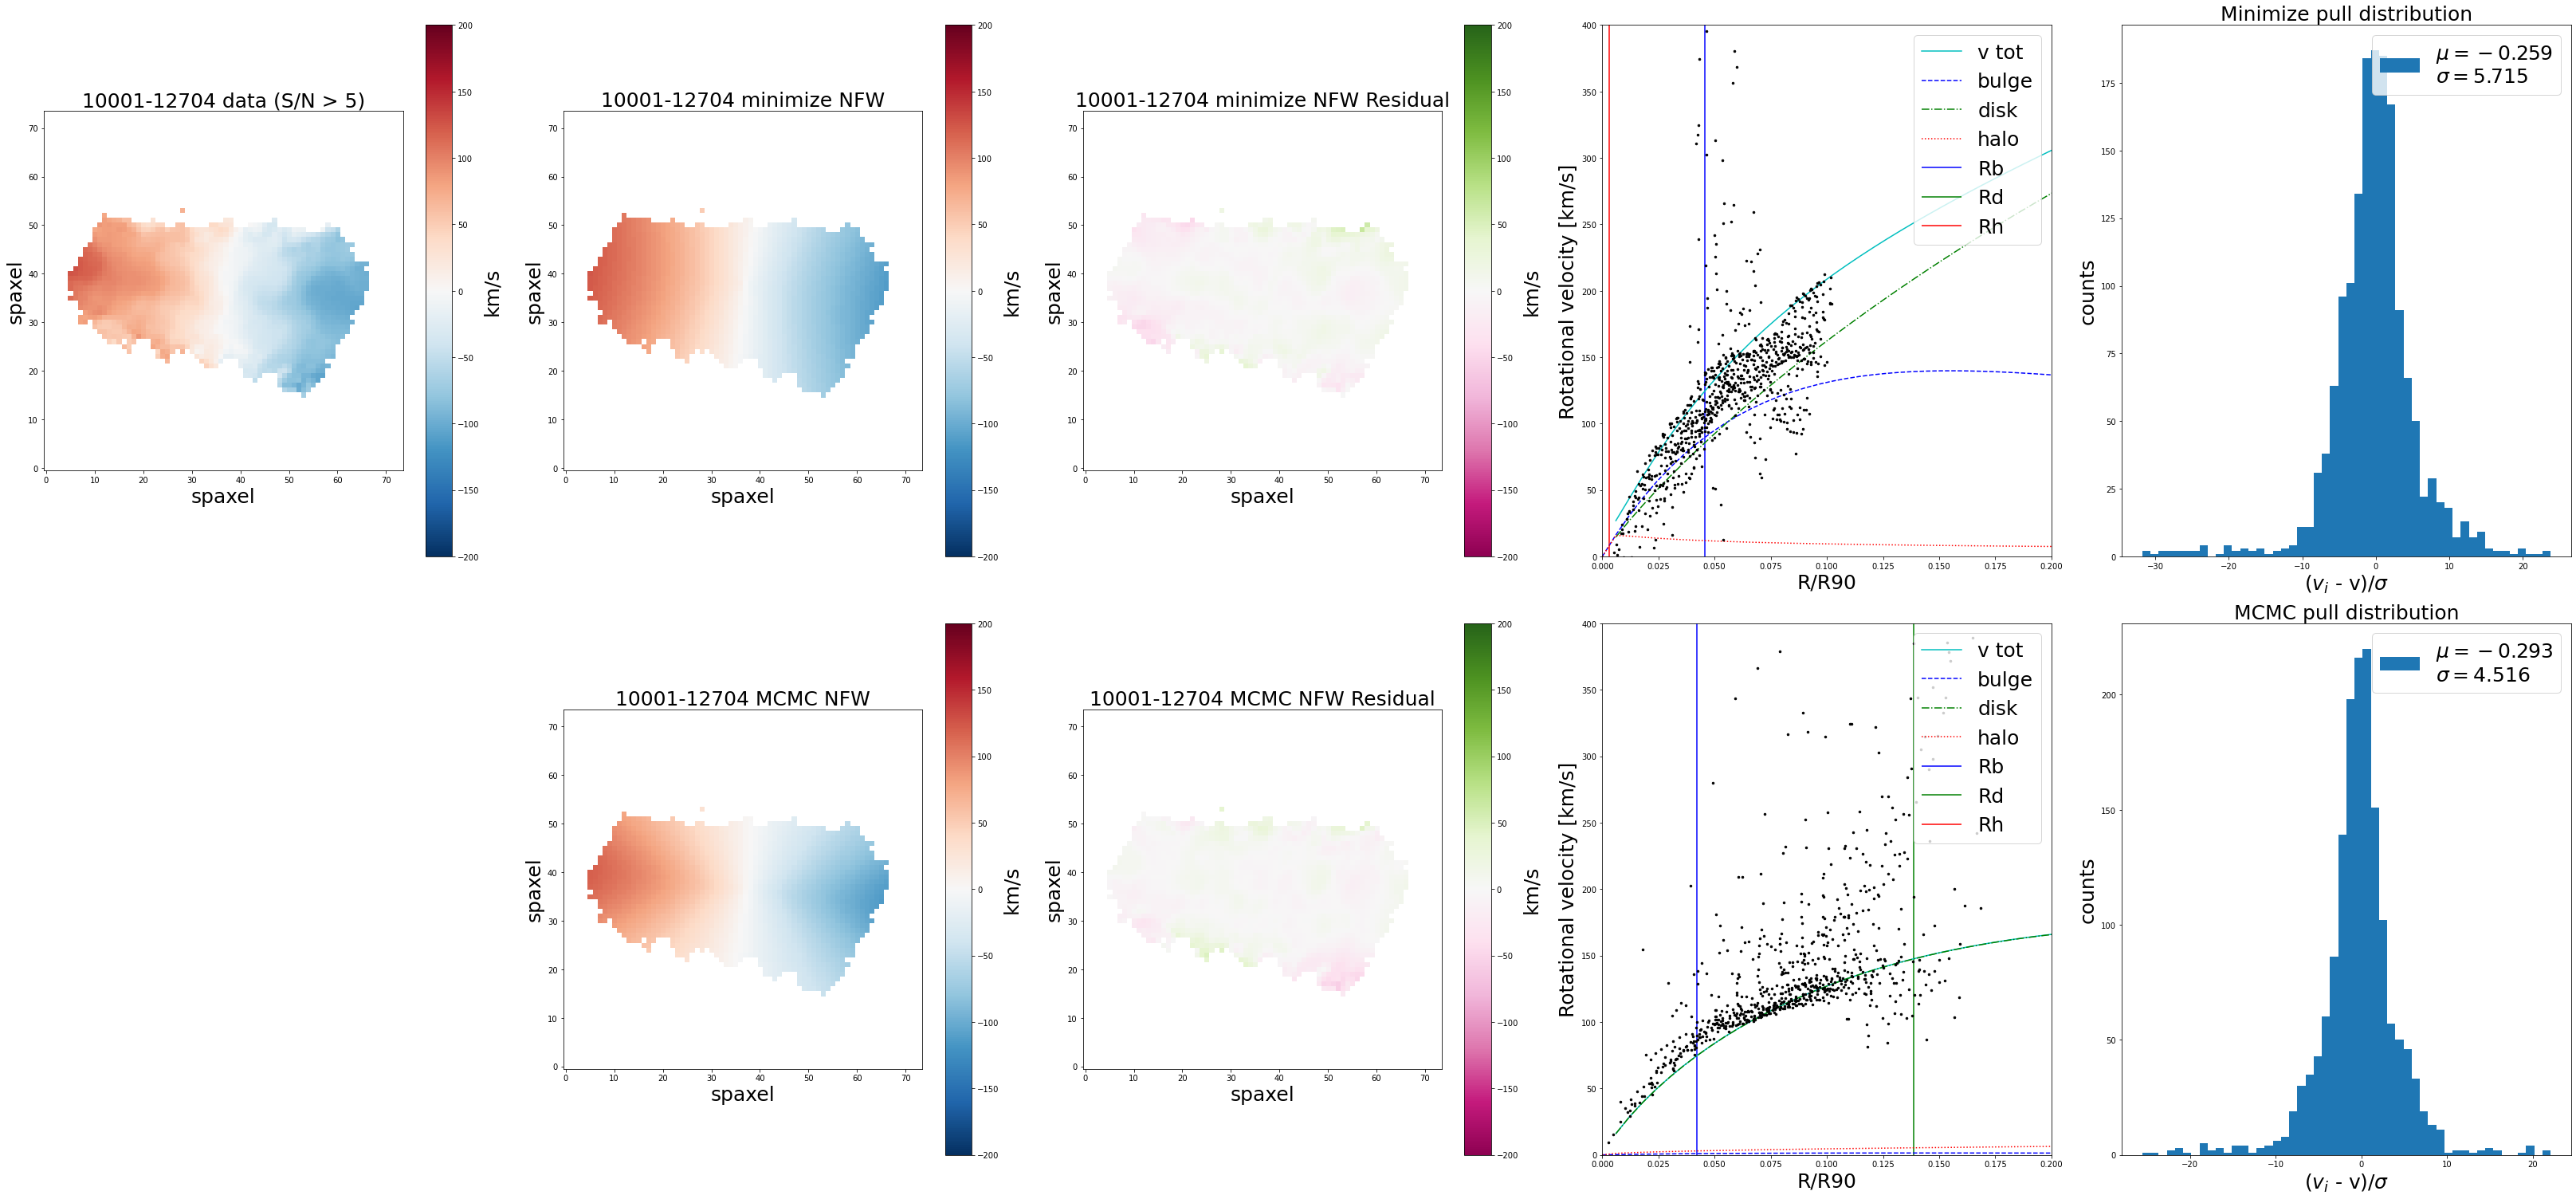

In [58]:
# NFW - 10001-12704

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12704, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12704, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12704, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12704 - mini_map_10001_12704, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12704 - mcmc_map_10001_12704, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12704/r90_10001_12704, v_mini_10001_12704, 'c',label='v tot')
plt.plot(r_mini_10001_12704/r90_10001_12704, v_b_mini_10001_12704, 'b--',label='bulge')
plt.plot(r_mini_10001_12704/r90_10001_12704, v_d_mini_10001_12704,'g-.',label='disk')
plt.plot(r_mini_10001_12704/r90_10001_12704, v_h_mini_10001_12704,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12704[1]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12704[3]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12704[5]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12704/r90_10001_12704, vm_deproj_mini_10001_12704, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_mcmc_10001_12704, 'c',label='v tot')
plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_b_mcmc_10001_12704, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_d_mcmc_10001_12704,'g-.',label='disk')
plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_h_mcmc_10001_12704,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12704))

plt.vlines(x = mcmc_fit_10001_12704[1]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12704[3]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12704[5]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12704/r90_10001_12704, vm_deproj_mcmc_10001_12704, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10001_12704 = dmap_10001_12704 - mini_map_10001_12704

dist_minimize_NFW_10001_12704 = residual_minimize_NFW_10001_12704*np.sqrt(ivar_masked_10001_12704)

residual_mcmc_NFW_10001_12704 = dmap_10001_12704 - mcmc_map_10001_12704

dist_mcmc_NFW_10001_12704 = residual_mcmc_NFW_10001_12704*np.sqrt(ivar_masked_10001_12704)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10001_12704 = ma.mean(dist_minimize_NFW_10001_12704)
sig_mini_NFW_10001_12704 = ma.std(dist_minimize_NFW_10001_12704)

n_mini_NFW_10001_12704, bins_mini_NFW_10001_12704, patches_mini_NFW_10001_12704 = plt.hist(dist_minimize_NFW_10001_12704.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10001_12704, sig_mini_NFW_10001_12704))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10001_12704 = ma.mean(dist_mcmc_NFW_10001_12704)
sig_mcmc_NFW_10001_12704 = ma.std(dist_mcmc_NFW_10001_12704)

n_mcmc_NFW_10001_12704, bins_mcmc_NFW_10001_12704, patches_mcmc_NFW_10001_12704 = plt.hist(dist_mcmc_NFW_10001_12704.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10001_12704, sig_mcmc_NFW_10001_12704))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12704))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12704))
print('r$R_{90}$: ' + str(r90_10001_12704) + ' kpc')
print('Incl from data: ' + str(incl_10001_12704))
print('Incl from Minimize: ' + str(mini_fit_10001_12704[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12704[-5]))

Minimize r$\chi^2$ : 14.305570248039668
MCMC r$\chi^2$ : 13.952741841745896
r$R_{90}$: 18.969200134277344 kpc
Incl from data: 0.6212118466139331
Incl from Minimize: 0.3204990399917265
Incl from MCMC: 0.8100035240487162


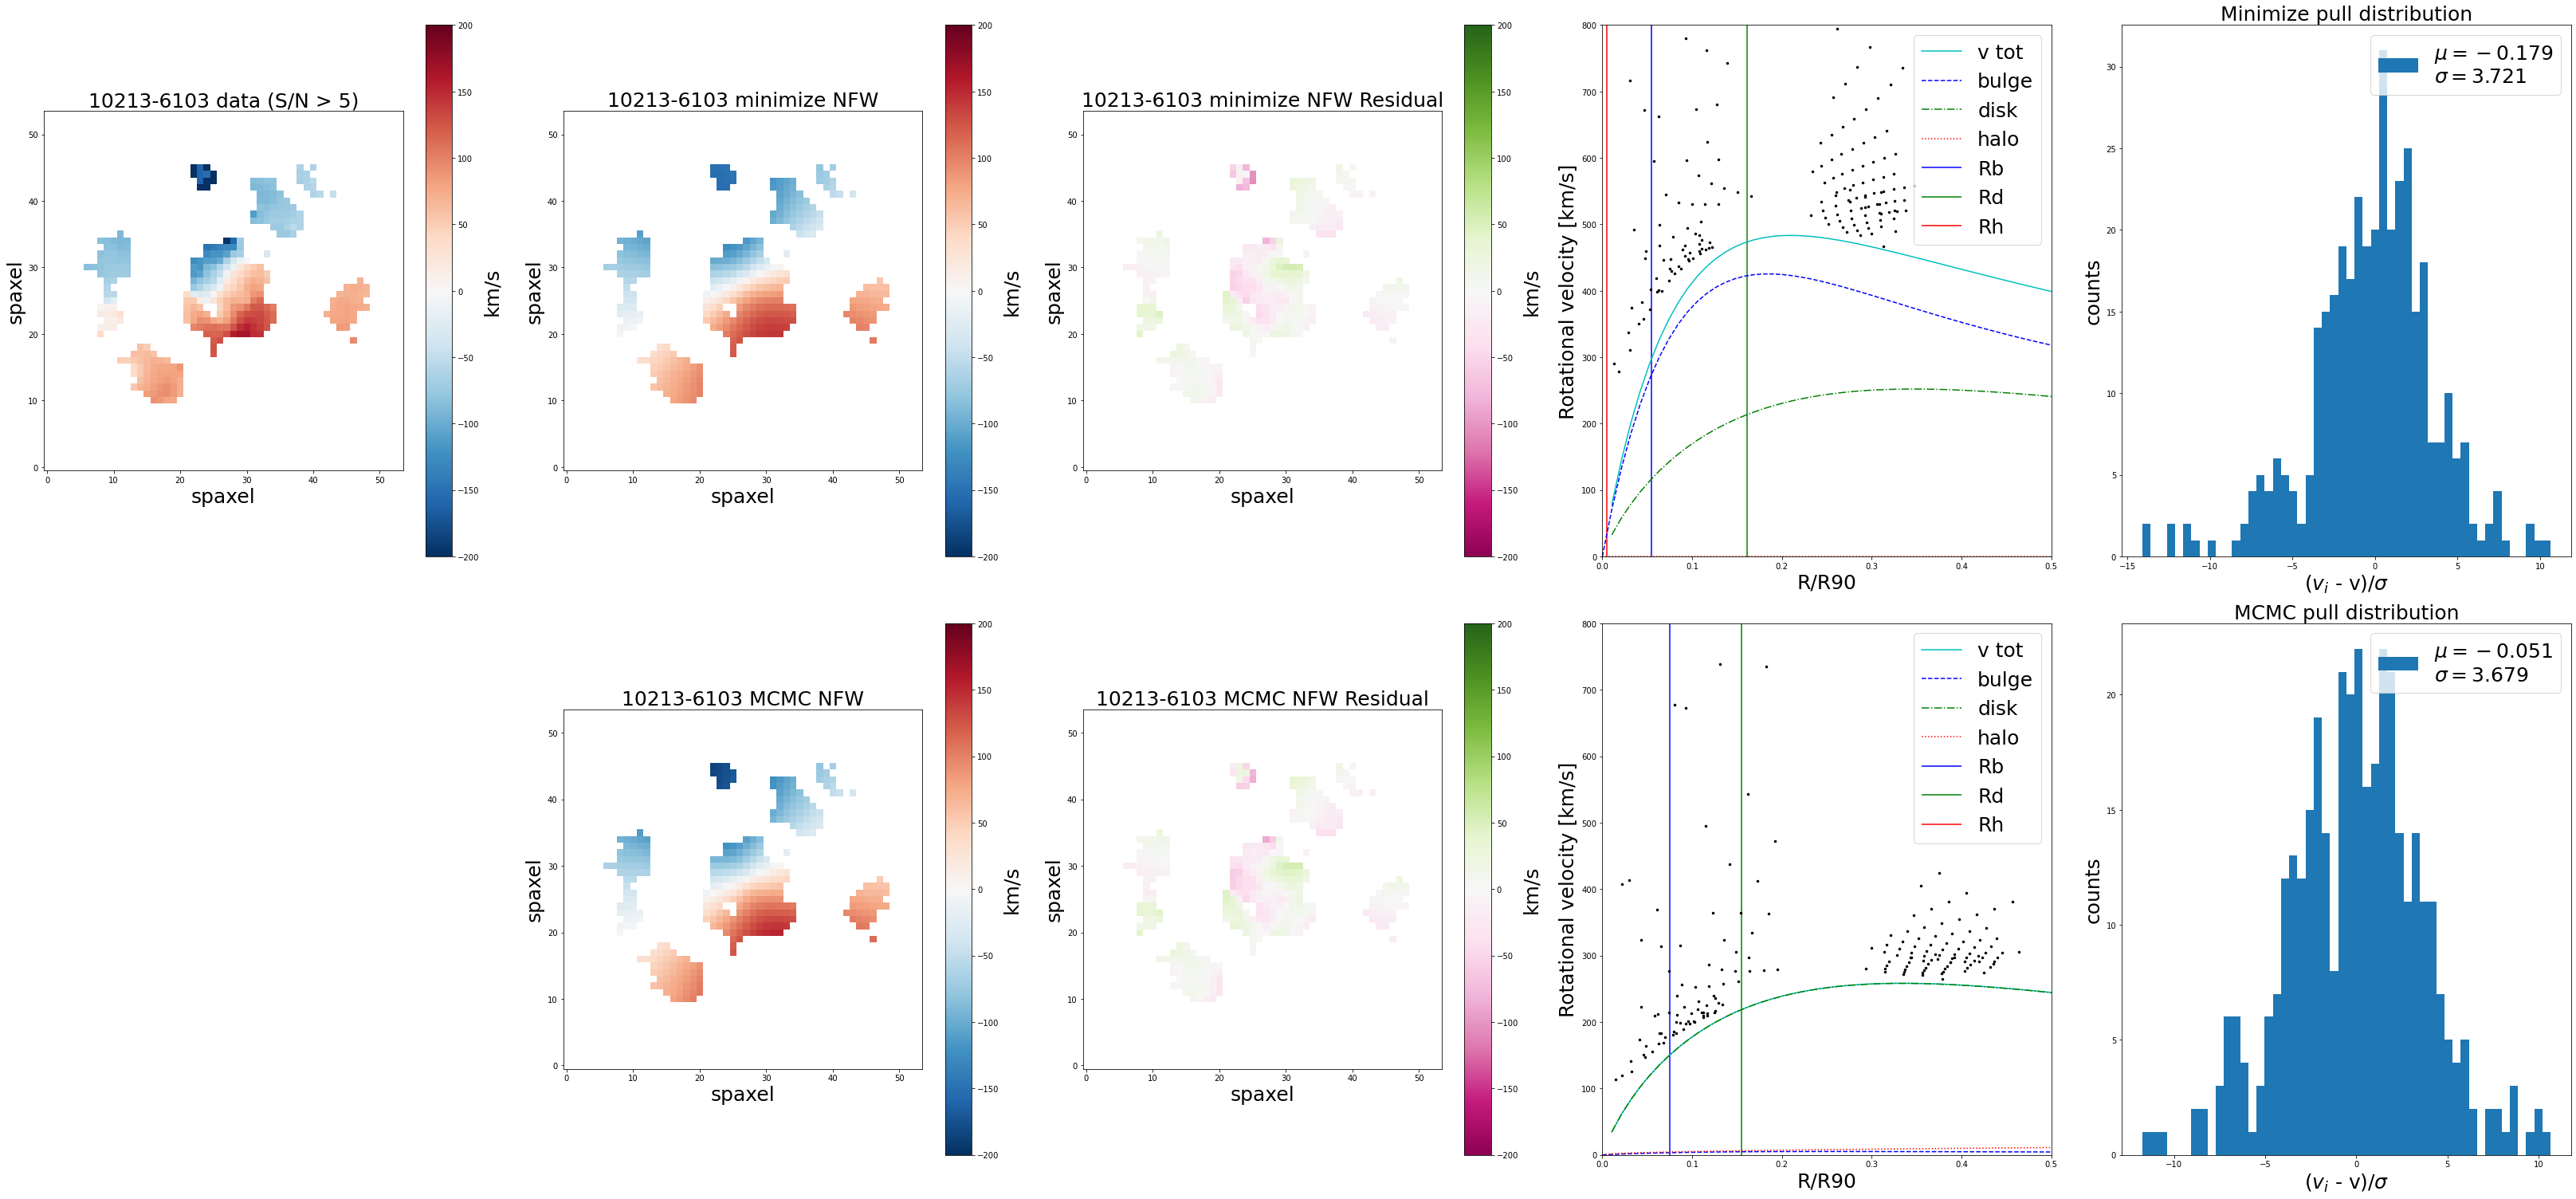

In [61]:
# NFW - 10213-6103

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_6103, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-6103 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-6103 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-6103 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_6103 - mini_map_10213_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-6103 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_6103 - mcmc_map_10213_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-6103 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_6103/r90_10213_6103, v_mini_10213_6103, 'c',label='v tot')
plt.plot(r_mini_10213_6103/r90_10213_6103, v_b_mini_10213_6103, 'b--',label='bulge')
plt.plot(r_mini_10213_6103/r90_10213_6103, v_d_mini_10213_6103,'g-.',label='disk')
plt.plot(r_mini_10213_6103/r90_10213_6103, v_h_mini_10213_6103,'r:',label='halo')

plt.vlines(x = mini_fit_10213_6103[1]/r90_10213_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_6103[3]/r90_10213_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_6103[5]/r90_10213_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_6103/r90_10213_6103, vm_deproj_mini_10213_6103, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,800])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_6103/r90_10213_6103, v_mcmc_10213_6103, 'c',label='v tot')
plt.plot(r_mcmc_10213_6103/r90_10213_6103, v_b_mcmc_10213_6103, 'b--',label='bulge')
plt.plot(r_mcmc_10213_6103/r90_10213_6103, v_d_mcmc_10213_6103,'g-.',label='disk')
plt.plot(r_mcmc_10213_6103/r90_10213_6103, v_h_mcmc_10213_6103,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_6103))

plt.vlines(x = mcmc_fit_10213_6103[1]/r90_10213_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_6103[3]/r90_10213_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_6103[5]/r90_10213_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_6103/r90_10213_6103, vm_deproj_mcmc_10213_6103, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,800])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10213_6103 = dmap_10213_6103 - mini_map_10213_6103

dist_minimize_NFW_10213_6103 = residual_minimize_NFW_10213_6103*np.sqrt(ivar_masked_10213_6103)

residual_mcmc_NFW_10213_6103 = dmap_10213_6103 - mcmc_map_10213_6103

dist_mcmc_NFW_10213_6103 = residual_mcmc_NFW_10213_6103*np.sqrt(ivar_masked_10213_6103)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10213_6103 = ma.mean(dist_minimize_NFW_10213_6103)
sig_mini_NFW_10213_6103 = ma.std(dist_minimize_NFW_10213_6103)

n_mini_NFW_10213_6103, bins_mini_NFW_10213_6103, patches_mini_NFW_10213_6103 = plt.hist(dist_minimize_NFW_10213_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10213_6103, sig_mini_NFW_10213_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10213_6103 = ma.mean(dist_mcmc_NFW_10213_6103)
sig_mcmc_NFW_10213_6103 = ma.std(dist_mcmc_NFW_10213_6103)

n_mcmc_NFW_10213_6103, bins_mcmc_NFW_10213_6103, patches_mcmc_NFW_10213_6103 = plt.hist(dist_mcmc_NFW_10213_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10213_6103, sig_mcmc_NFW_10213_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_6103))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_6103))
print('r$R_{90}$: ' + str(r90_10213_6103) + ' kpc')
print('Incl from data: ' + str(incl_10213_6103))
print('Incl from Minimize: ' + str(mini_fit_10213_6103[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_6103[-5]))

Minimize r$\chi^2$ : 4.986567689556957
MCMC r$\chi^2$ : 4.575984987631838
r$R_{90}$: 16.72977638244629 kpc
Incl from data: 1.4443272971212515
Incl from Minimize: 0.12101759529347317
Incl from MCMC: 0.2744694466660502


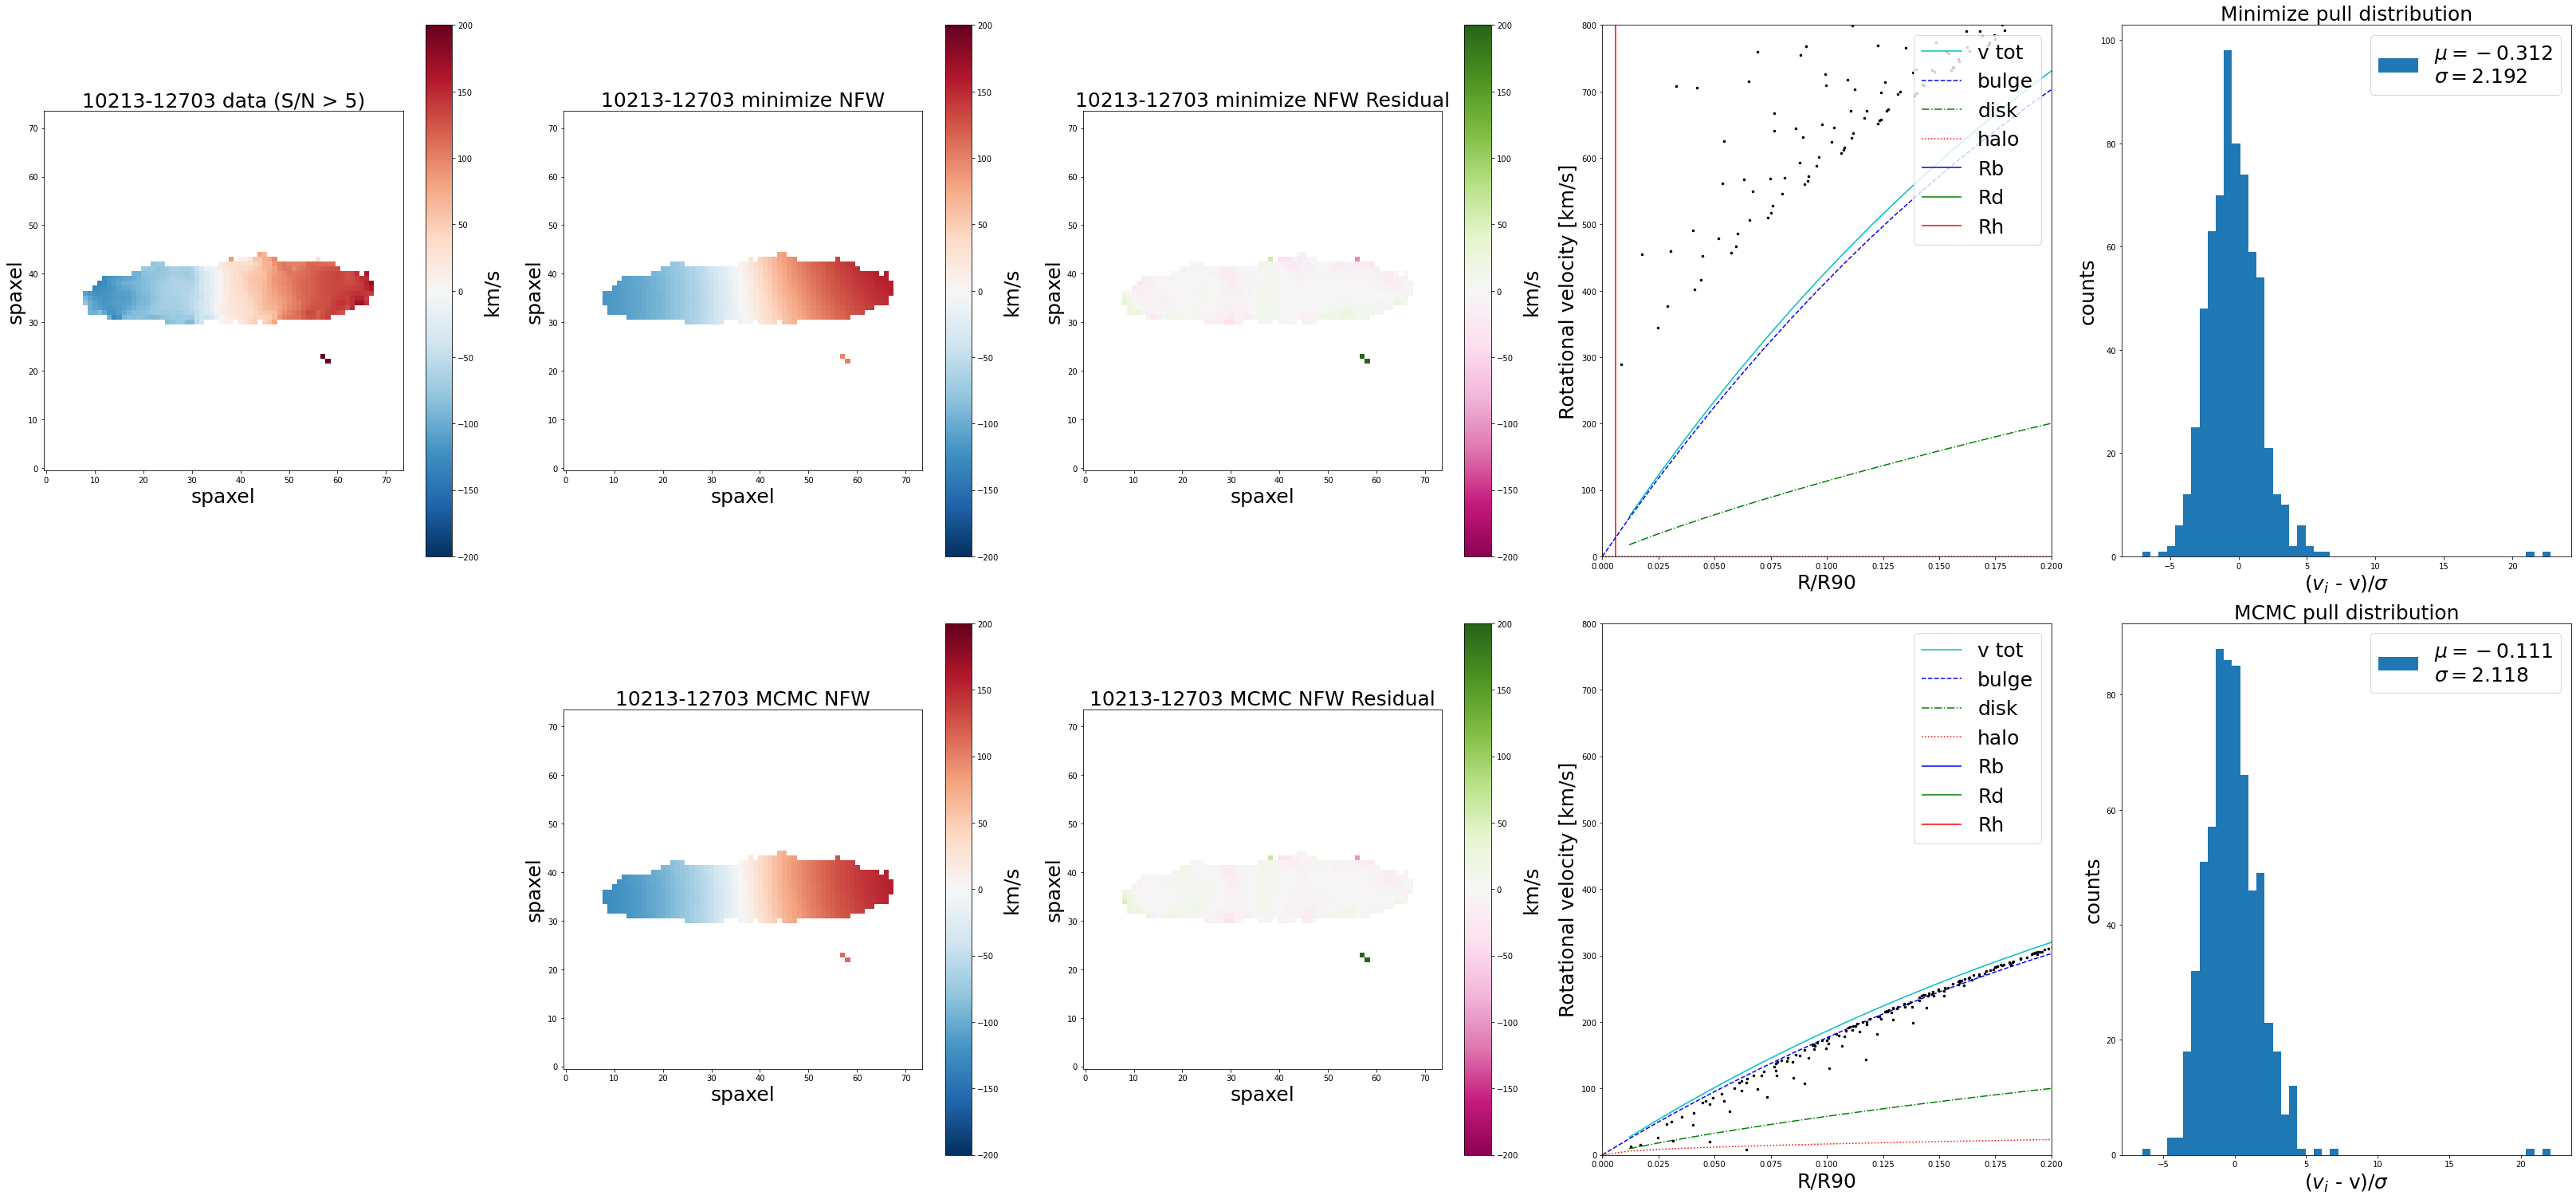

In [63]:
# NFW - 10213-12703

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_12703, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12703 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_12703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12703 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_12703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12703 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_12703 - mini_map_10213_12703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12703 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_12703 - mcmc_map_10213_12703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12703 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_12703/r90_10213_12703, v_mini_10213_12703, 'c',label='v tot')
plt.plot(r_mini_10213_12703/r90_10213_12703, v_b_mini_10213_12703, 'b--',label='bulge')
plt.plot(r_mini_10213_12703/r90_10213_12703, v_d_mini_10213_12703,'g-.',label='disk')
plt.plot(r_mini_10213_12703/r90_10213_12703, v_h_mini_10213_12703,'r:',label='halo')

plt.vlines(x = mini_fit_10213_12703[1]/r90_10213_12703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_12703[3]/r90_10213_12703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_12703[5]/r90_10213_12703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_12703/r90_10213_12703, vm_deproj_mini_10213_12703, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,800])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_12703/r90_10213_12703, v_mcmc_10213_12703, 'c',label='v tot')
plt.plot(r_mcmc_10213_12703/r90_10213_12703, v_b_mcmc_10213_12703, 'b--',label='bulge')
plt.plot(r_mcmc_10213_12703/r90_10213_12703, v_d_mcmc_10213_12703,'g-.',label='disk')
plt.plot(r_mcmc_10213_12703/r90_10213_12703, v_h_mcmc_10213_12703,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_12703))

plt.vlines(x = mcmc_fit_10213_12703[1]/r90_10213_12703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_12703[3]/r90_10213_12703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_12703[5]/r90_10213_12703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_12703/r90_10213_12703, vm_deproj_mcmc_10213_12703, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,800])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10213_12703 = dmap_10213_12703 - mini_map_10213_12703

dist_minimize_NFW_10213_12703 = residual_minimize_NFW_10213_12703*np.sqrt(ivar_masked_10213_12703)

residual_mcmc_NFW_10213_12703 = dmap_10213_12703 - mcmc_map_10213_12703

dist_mcmc_NFW_10213_12703 = residual_mcmc_NFW_10213_12703*np.sqrt(ivar_masked_10213_12703)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10213_12703 = ma.mean(dist_minimize_NFW_10213_12703)
sig_mini_NFW_10213_12703 = ma.std(dist_minimize_NFW_10213_12703)

n_mini_NFW_10213_12703, bins_mini_NFW_10213_12703, patches_mini_NFW_10213_12703 = plt.hist(dist_minimize_NFW_10213_12703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10213_12703, sig_mini_NFW_10213_12703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10213_12703 = ma.mean(dist_mcmc_NFW_10213_12703)
sig_mcmc_NFW_10213_12703 = ma.std(dist_mcmc_NFW_10213_12703)

n_mcmc_NFW_10213_12703, bins_mcmc_NFW_10213_12703, patches_mcmc_NFW_10213_12703 = plt.hist(dist_mcmc_NFW_10213_12703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10213_12703, sig_mcmc_NFW_10213_12703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_12703))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_12703))
print('r$R_{90}$: ' + str(r90_10213_12703) + ' kpc')
print('Incl from data: ' + str(incl_10213_12703))
print('Incl from Minimize: ' + str(mini_fit_10213_12703[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_12703[-5]))

Minimize r$\chi^2$ : 25.788927182569
MCMC r$\chi^2$ : 219.10523784572325
r$R_{90}$: 10.562400817871094 kpc
Incl from data: 0.6471020376352496
Incl from Minimize: 0.42443659998207617
Incl from MCMC: 0.7020839674415053


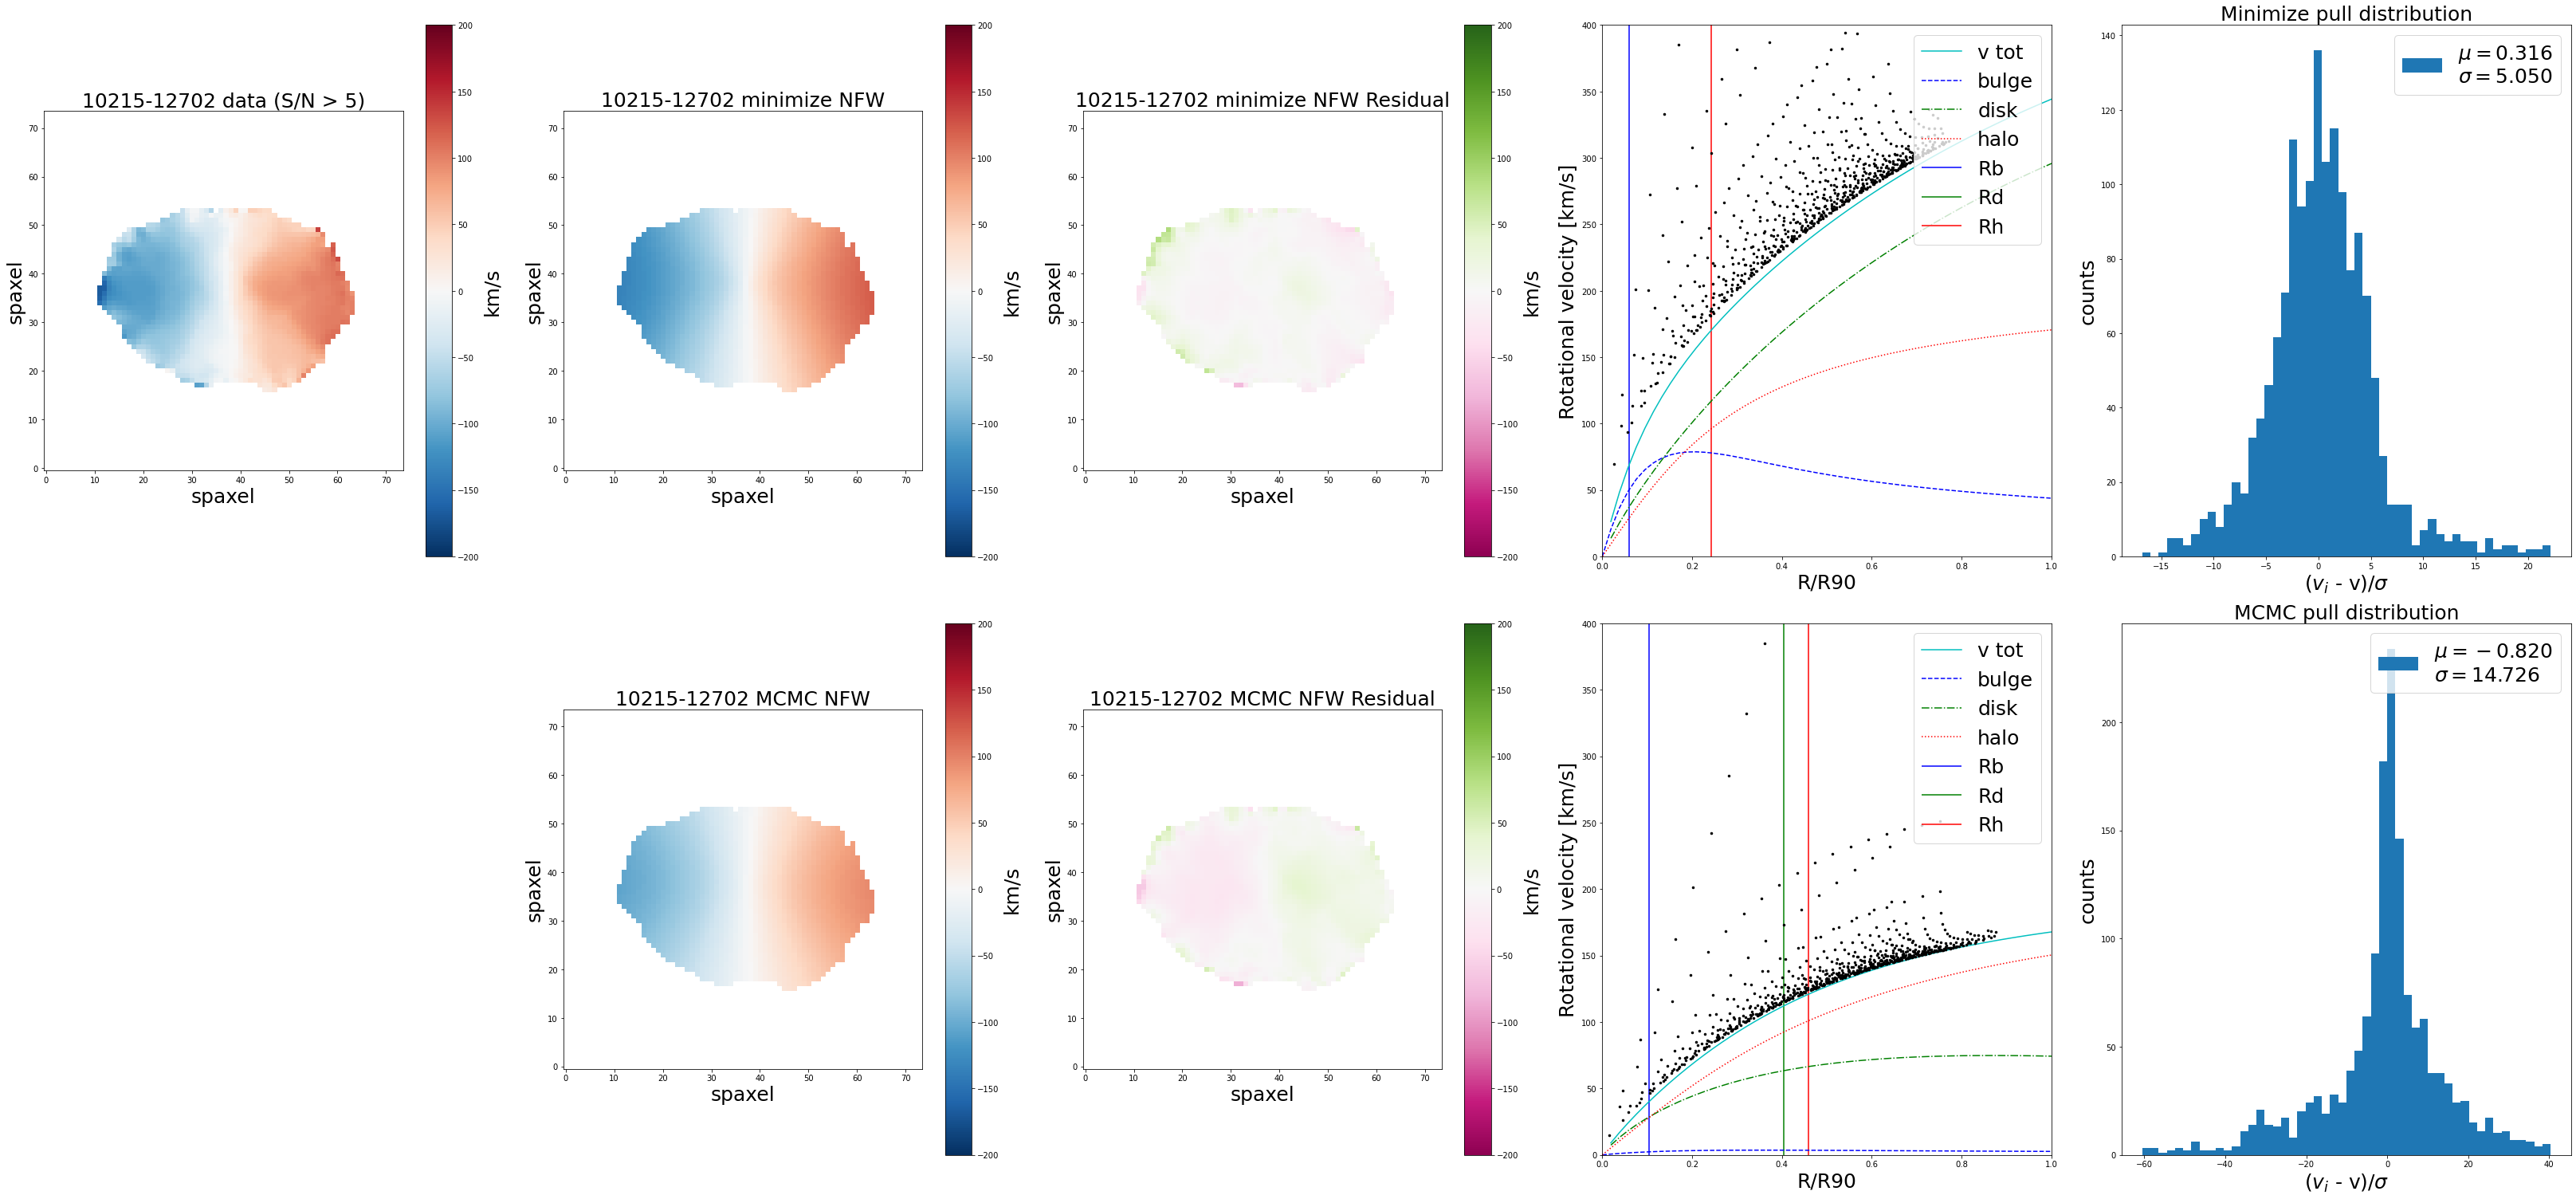

In [65]:
# NFW - 10215-12702

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_12702, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_12702 - mini_map_10215_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_12702 - mcmc_map_10215_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_12702/r90_10215_12702, v_mini_10215_12702, 'c',label='v tot')
plt.plot(r_mini_10215_12702/r90_10215_12702, v_b_mini_10215_12702, 'b--',label='bulge')
plt.plot(r_mini_10215_12702/r90_10215_12702, v_d_mini_10215_12702,'g-.',label='disk')
plt.plot(r_mini_10215_12702/r90_10215_12702, v_h_mini_10215_12702,'r:',label='halo')

plt.vlines(x = mini_fit_10215_12702[1]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_12702[3]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_12702[5]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_12702/r90_10215_12702, vm_deproj_mini_10215_12702, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_mcmc_10215_12702, 'c',label='v tot')
plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_b_mcmc_10215_12702, 'b--',label='bulge')
plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_d_mcmc_10215_12702,'g-.',label='disk')
plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_h_mcmc_10215_12702,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_12702))

plt.vlines(x = mcmc_fit_10215_12702[1]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_12702[3]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_12702[5]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_12702/r90_10215_12702, vm_deproj_mcmc_10215_12702, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10215_12702 = dmap_10215_12702 - mini_map_10215_12702

dist_minimize_NFW_10215_12702 = residual_minimize_NFW_10215_12702*np.sqrt(ivar_masked_10215_12702)

residual_mcmc_NFW_10215_12702 = dmap_10215_12702 - mcmc_map_10215_12702

dist_mcmc_NFW_10215_12702 = residual_mcmc_NFW_10215_12702*np.sqrt(ivar_masked_10215_12702)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10215_12702 = ma.mean(dist_minimize_NFW_10215_12702)
sig_mini_NFW_10215_12702 = ma.std(dist_minimize_NFW_10215_12702)

n_mini_NFW_10215_12702, bins_mini_NFW_10215_12702, patches_mini_NFW_10215_12702 = plt.hist(dist_minimize_NFW_10215_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10215_12702, sig_mini_NFW_10215_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10215_12702 = ma.mean(dist_mcmc_NFW_10215_12702)
sig_mcmc_NFW_10215_12702 = ma.std(dist_mcmc_NFW_10215_12702)

n_mcmc_NFW_10215_12702, bins_mcmc_NFW_10215_12702, patches_mcmc_NFW_10215_12702 = plt.hist(dist_mcmc_NFW_10215_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10215_12702, sig_mcmc_NFW_10215_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_12702))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_12702))
print('r$R_{90}$: ' + str(r90_10215_12702) + ' kpc')
print('Incl from data: ' + str(incl_10215_12702))
print('Incl from Minimize: ' + str(mini_fit_10215_12702[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_12702[-5]))

Minimize r$\chi^2$ : 123.11247455265735
MCMC r$\chi^2$ : 31.664847226013777
r$R_{90}$: 25.11236572265625 kpc
Incl from data: 0.5848422902030684
Incl from Minimize: 0.27752492830180053
Incl from MCMC: 0.413494607056659


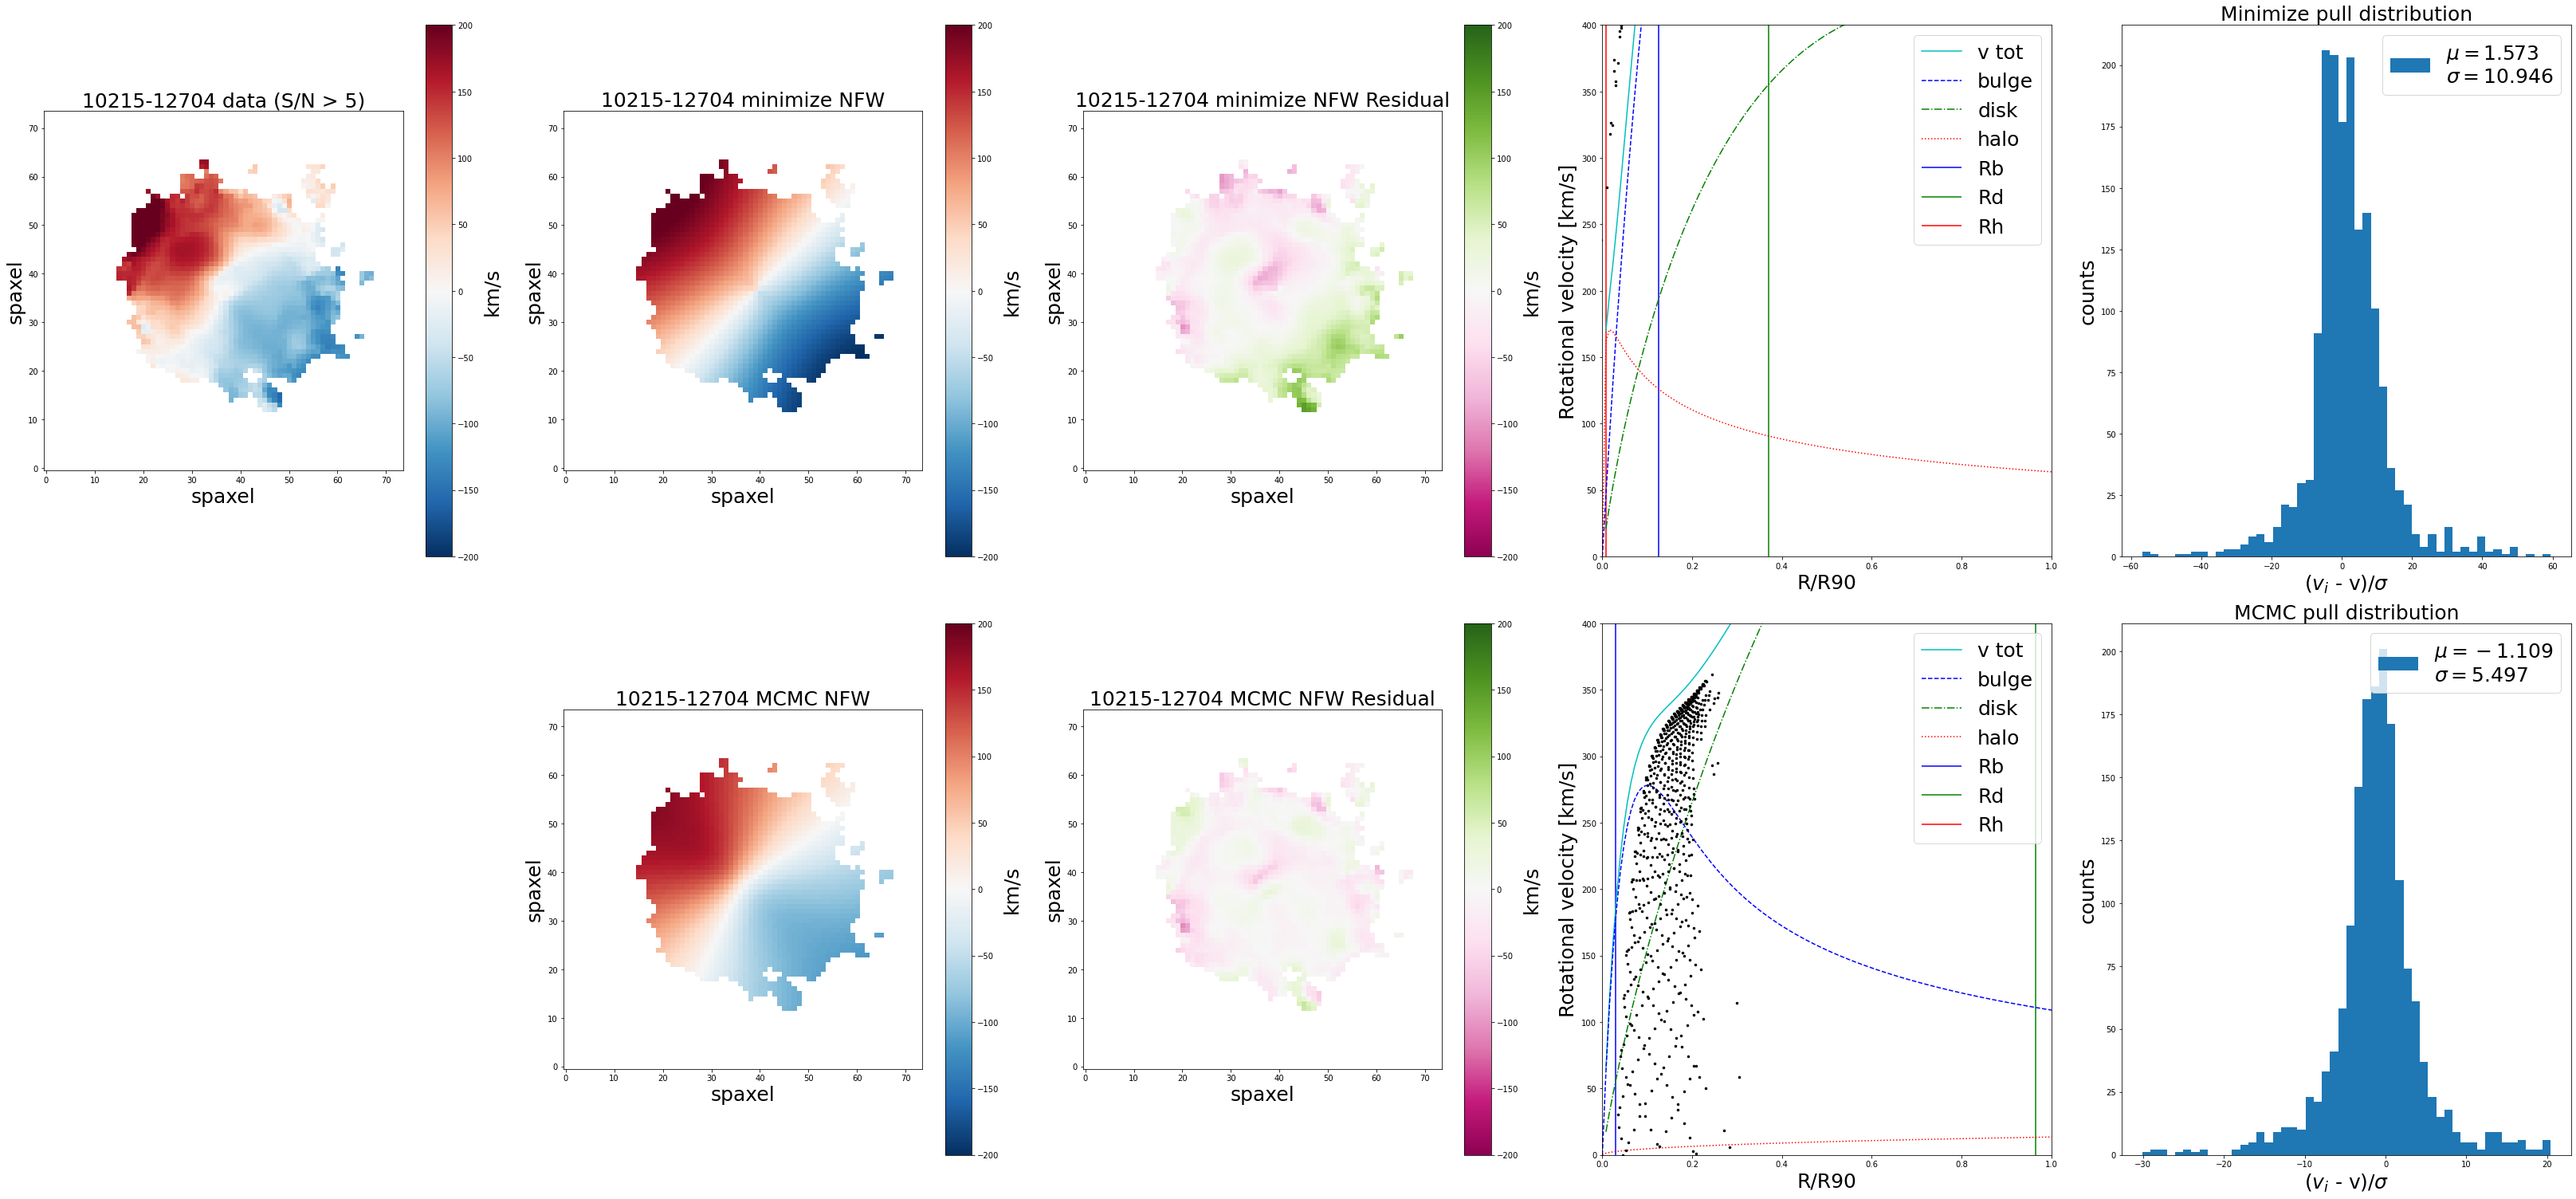

In [67]:
# NFW - 10215-12704

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_12704, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12704 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_12704, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12704 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_12704, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12704 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_12704 - mini_map_10215_12704, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12704 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_12704 - mcmc_map_10215_12704, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12704 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_12704/r90_10215_12704, v_mini_10215_12704, 'c',label='v tot')
plt.plot(r_mini_10215_12704/r90_10215_12704, v_b_mini_10215_12704, 'b--',label='bulge')
plt.plot(r_mini_10215_12704/r90_10215_12704, v_d_mini_10215_12704,'g-.',label='disk')
plt.plot(r_mini_10215_12704/r90_10215_12704, v_h_mini_10215_12704,'r:',label='halo')

plt.vlines(x = mini_fit_10215_12704[1]/r90_10215_12704,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_12704[3]/r90_10215_12704,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_12704[5]/r90_10215_12704,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_12704/r90_10215_12704, vm_deproj_mini_10215_12704, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_12704/r90_10215_12704, v_mcmc_10215_12704, 'c',label='v tot')
plt.plot(r_mcmc_10215_12704/r90_10215_12704, v_b_mcmc_10215_12704, 'b--',label='bulge')
plt.plot(r_mcmc_10215_12704/r90_10215_12704, v_d_mcmc_10215_12704,'g-.',label='disk')
plt.plot(r_mcmc_10215_12704/r90_10215_12704, v_h_mcmc_10215_12704,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_12704))

plt.vlines(x = mcmc_fit_10215_12704[1]/r90_10215_12704,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_12704[3]/r90_10215_12704,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_12704[5]/r90_10215_12704,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_12704/r90_10215_12704, vm_deproj_mcmc_10215_12704, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10215_12704 = dmap_10215_12704 - mini_map_10215_12704

dist_minimize_NFW_10215_12704 = residual_minimize_NFW_10215_12704*np.sqrt(ivar_masked_10215_12704)

residual_mcmc_NFW_10215_12704 = dmap_10215_12704 - mcmc_map_10215_12704

dist_mcmc_NFW_10215_12704 = residual_mcmc_NFW_10215_12704*np.sqrt(ivar_masked_10215_12704)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10215_12704 = ma.mean(dist_minimize_NFW_10215_12704)
sig_mini_NFW_10215_12704 = ma.std(dist_minimize_NFW_10215_12704)

n_mini_NFW_10215_12704, bins_mini_NFW_10215_12704, patches_mini_NFW_10215_12704 = plt.hist(dist_minimize_NFW_10215_12704.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10215_12704, sig_mini_NFW_10215_12704))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10215_12704 = ma.mean(dist_mcmc_NFW_10215_12704)
sig_mcmc_NFW_10215_12704 = ma.std(dist_mcmc_NFW_10215_12704)

n_mcmc_NFW_10215_12704, bins_mcmc_NFW_10215_12704, patches_mcmc_NFW_10215_12704 = plt.hist(dist_mcmc_NFW_10215_12704.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10215_12704, sig_mcmc_NFW_10215_12704))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_12704))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_12704))
print('r$R_{90}$: ' + str(r90_10215_12704) + ' kpc')
print('Incl from data: ' + str(incl_10215_12704))
print('Incl from Minimize: ' + str(mini_fit_10215_12704[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_12704[-5]))

Minimize r$\chi^2$ : 42.386592374346144
MCMC r$\chi^2$ : 300.447222761907
r$R_{90}$: 7.161678791046143 kpc
Incl from data: 0.4661070312848771
Incl from Minimize: 0.14666145807116665
Incl from MCMC: 0.3588591979193926


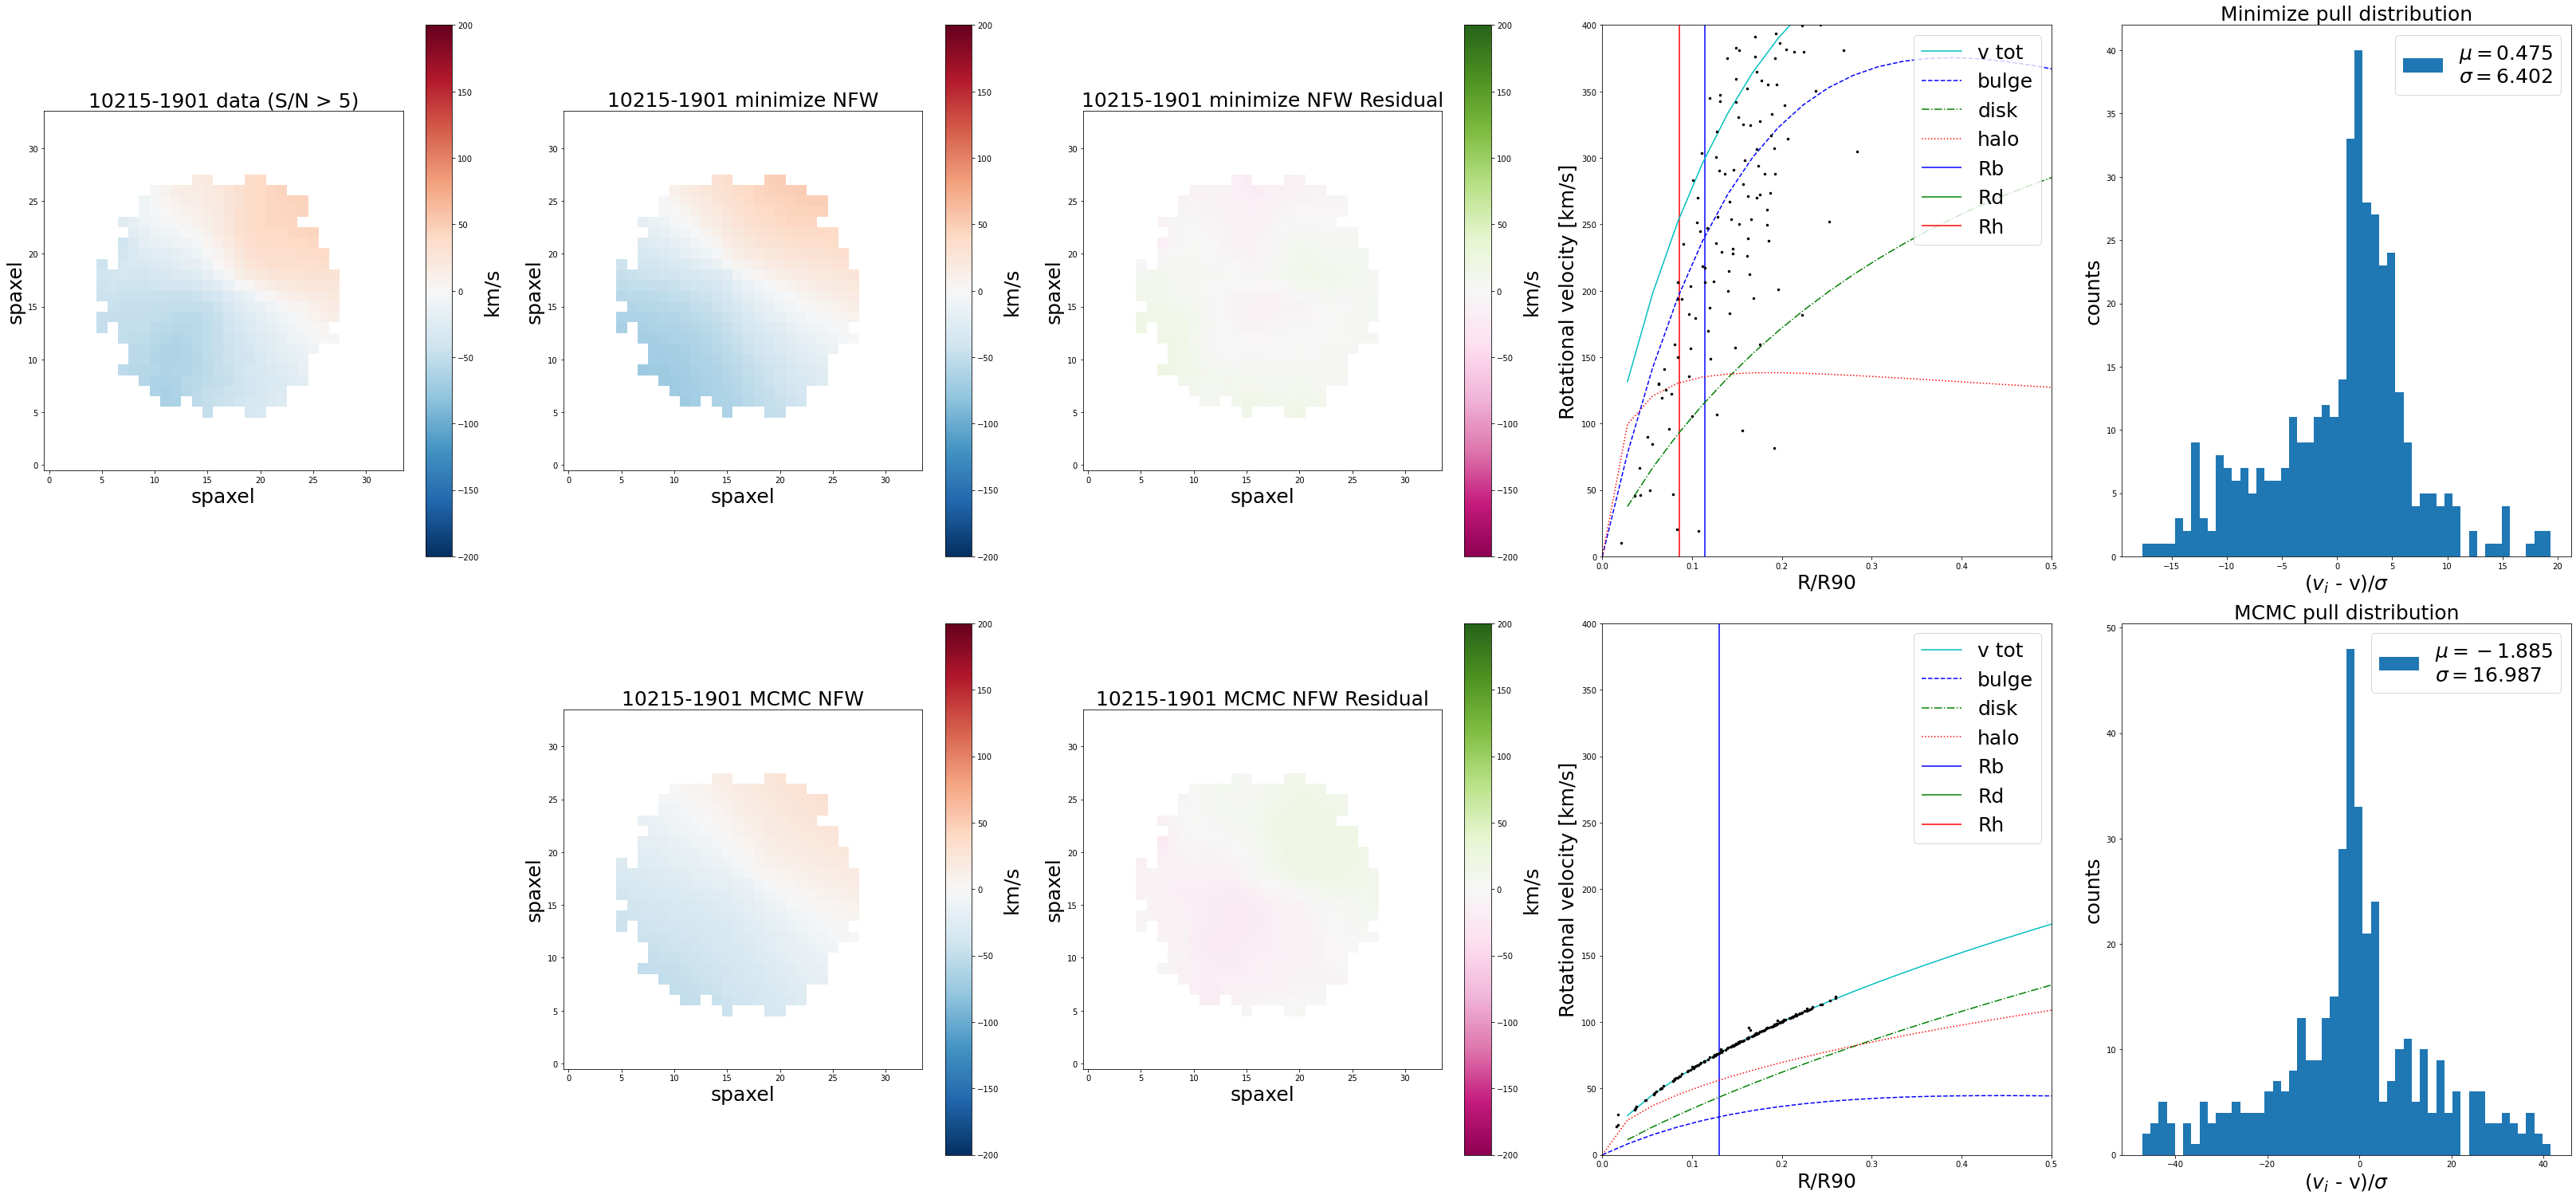

In [69]:
# NFW - 10215-1901

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_1901, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1901 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_1901, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1901 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_1901, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1901 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_1901 - mini_map_10215_1901, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1901 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_1901 - mcmc_map_10215_1901, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1901 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_1901/r90_10215_1901, v_mini_10215_1901, 'c',label='v tot')
plt.plot(r_mini_10215_1901/r90_10215_1901, v_b_mini_10215_1901, 'b--',label='bulge')
plt.plot(r_mini_10215_1901/r90_10215_1901, v_d_mini_10215_1901,'g-.',label='disk')
plt.plot(r_mini_10215_1901/r90_10215_1901, v_h_mini_10215_1901,'r:',label='halo')

plt.vlines(x = mini_fit_10215_1901[1]/r90_10215_1901,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_1901[3]/r90_10215_1901,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_1901[5]/r90_10215_1901,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_1901/r90_10215_1901, vm_deproj_mini_10215_1901, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_1901/r90_10215_1901, v_mcmc_10215_1901, 'c',label='v tot')
plt.plot(r_mcmc_10215_1901/r90_10215_1901, v_b_mcmc_10215_1901, 'b--',label='bulge')
plt.plot(r_mcmc_10215_1901/r90_10215_1901, v_d_mcmc_10215_1901,'g-.',label='disk')
plt.plot(r_mcmc_10215_1901/r90_10215_1901, v_h_mcmc_10215_1901,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_1901))

plt.vlines(x = mcmc_fit_10215_1901[1]/r90_10215_1901,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_1901[3]/r90_10215_1901,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_1901[5]/r90_10215_1901,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_1901/r90_10215_1901, vm_deproj_mcmc_10215_1901, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10215_1901 = dmap_10215_1901 - mini_map_10215_1901

dist_minimize_NFW_10215_1901 = residual_minimize_NFW_10215_1901*np.sqrt(ivar_masked_10215_1901)

residual_mcmc_NFW_10215_1901 = dmap_10215_1901 - mcmc_map_10215_1901

dist_mcmc_NFW_10215_1901 = residual_mcmc_NFW_10215_1901*np.sqrt(ivar_masked_10215_1901)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10215_1901 = ma.mean(dist_minimize_NFW_10215_1901)
sig_mini_NFW_10215_1901 = ma.std(dist_minimize_NFW_10215_1901)

n_mini_NFW_10215_1901, bins_mini_NFW_10215_1901, patches_mini_NFW_10215_1901 = plt.hist(dist_minimize_NFW_10215_1901.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10215_1901, sig_mini_NFW_10215_1901))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10215_1901 = ma.mean(dist_mcmc_NFW_10215_1901)
sig_mcmc_NFW_10215_1901 = ma.std(dist_mcmc_NFW_10215_1901)

n_mcmc_NFW_10215_1901, bins_mcmc_NFW_10215_1901, patches_mcmc_NFW_10215_1901 = plt.hist(dist_mcmc_NFW_10215_1901.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10215_1901, sig_mcmc_NFW_10215_1901))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_1901))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_1901))
print('r$R_{90}$: ' + str(r90_10215_1901) + ' kpc')
print('Incl from data: ' + str(incl_10215_1901))
print('Incl from Minimize: ' + str(mini_fit_10215_1901[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_1901[-5]))

Minimize r$\chi^2$ : 133.85558672350163
MCMC r$\chi^2$ : 1689.3619351295727
r$R_{90}$: 5.081458568572998 kpc
Incl from data: 0.8384855119086068
Incl from Minimize: 0.10005060494819212
Incl from MCMC: 0.5014144325857108


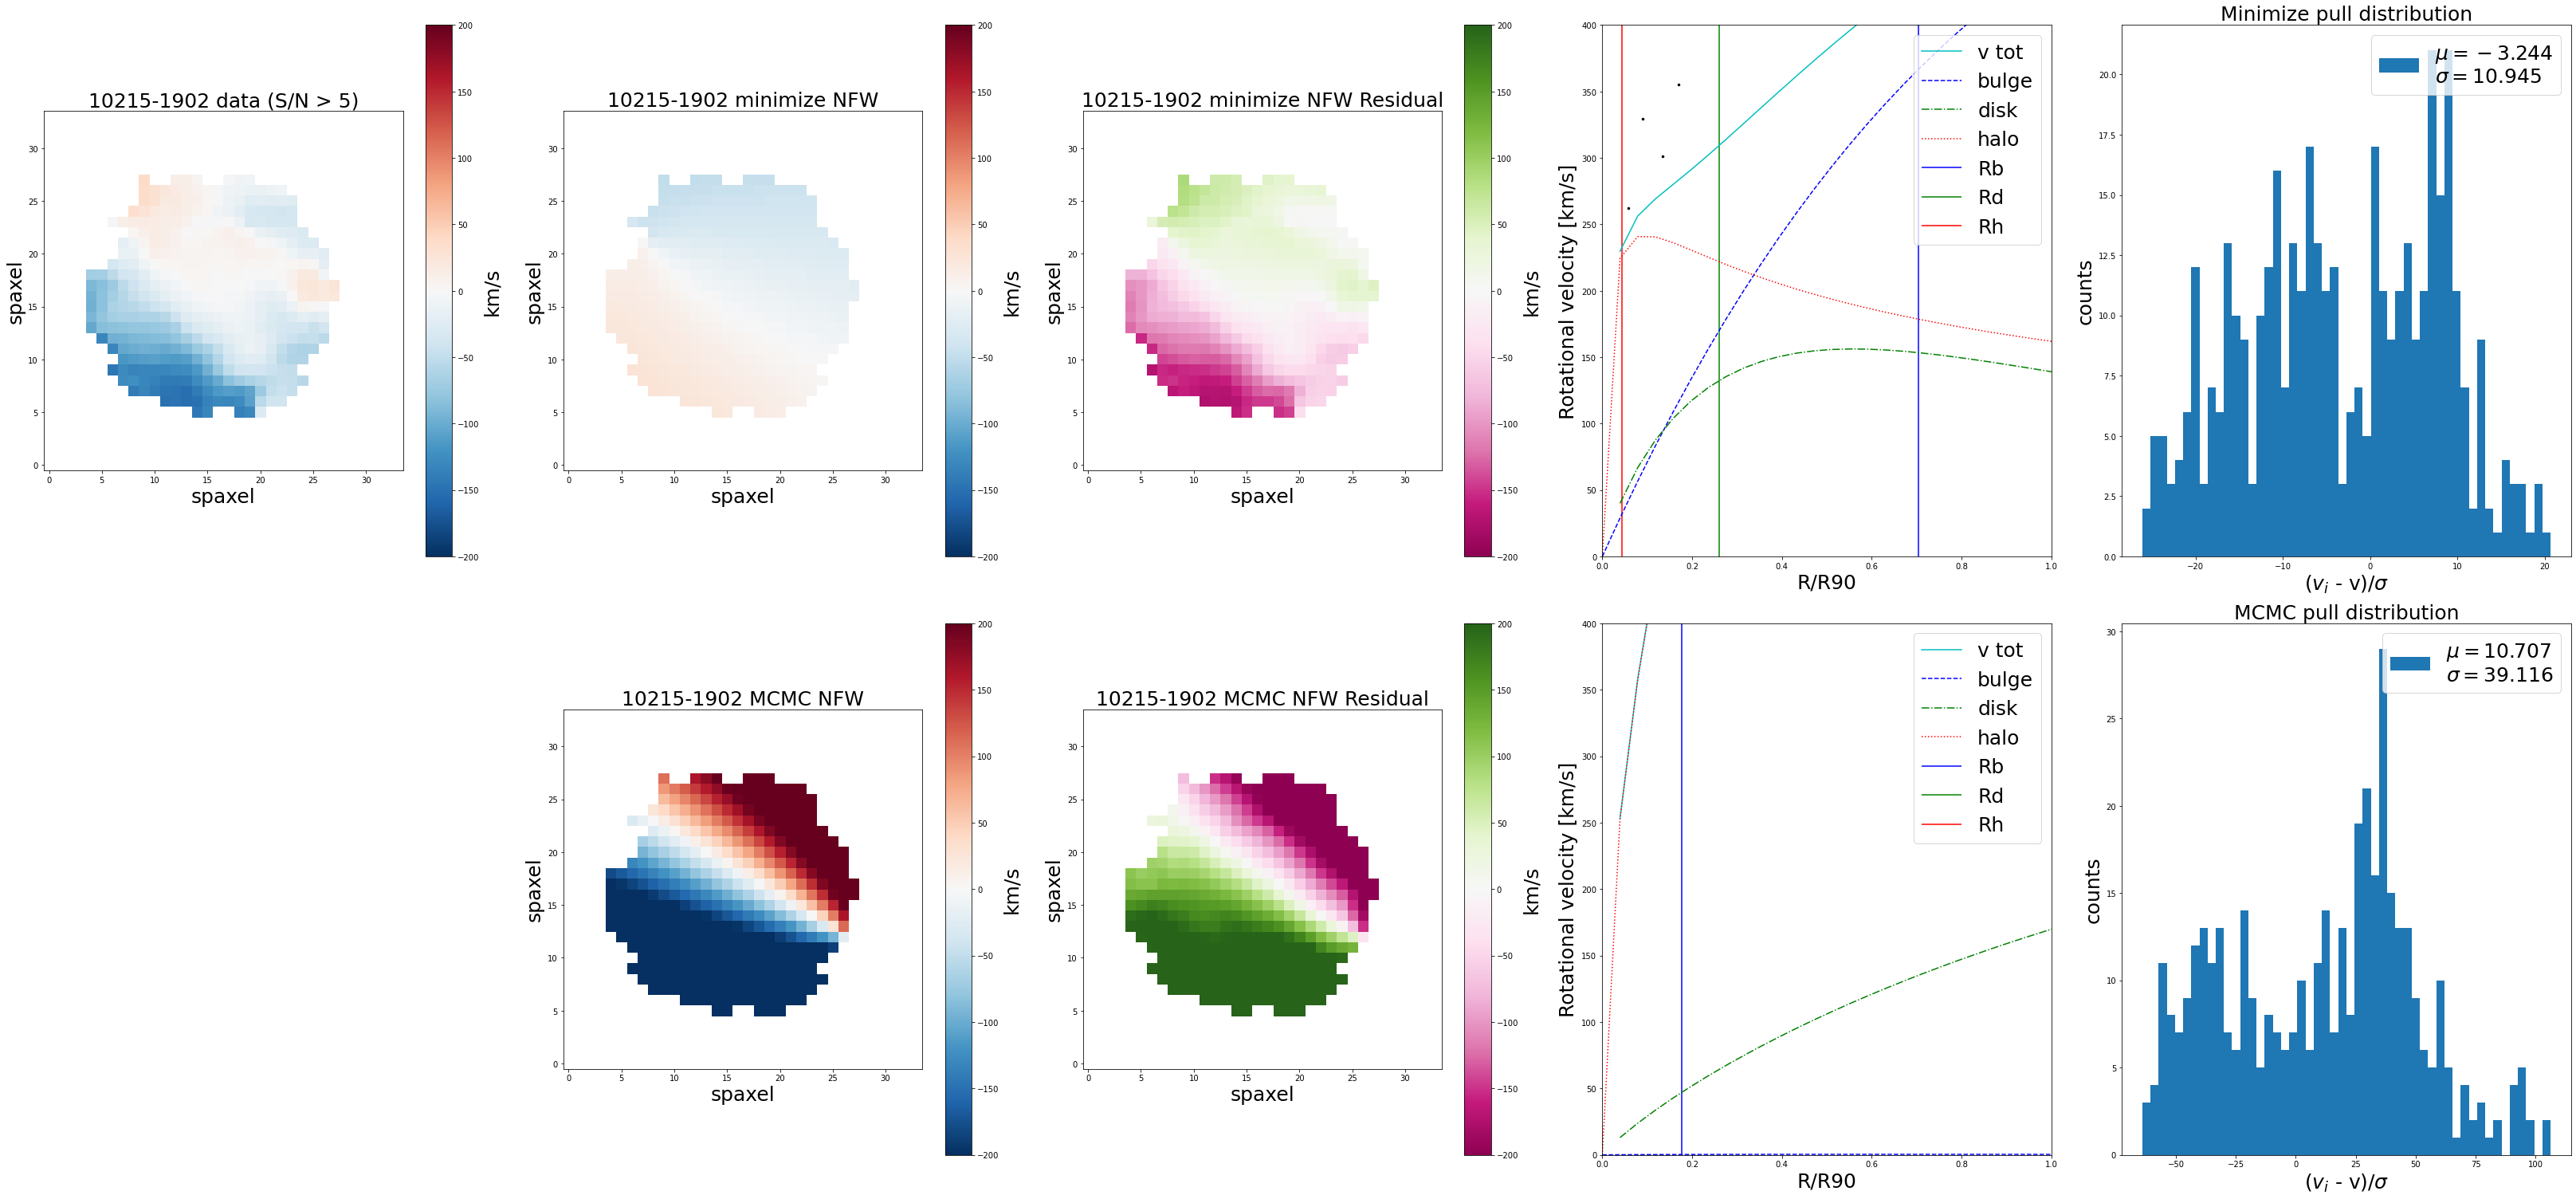

In [71]:
# NFW - 10215-1902

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_1902, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1902 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_1902, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1902 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_1902, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1902 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_1902 - mini_map_10215_1902, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1902 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_1902 - mcmc_map_10215_1902, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-1902 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_1902/r90_10215_1902, v_mini_10215_1902, 'c',label='v tot')
plt.plot(r_mini_10215_1902/r90_10215_1902, v_b_mini_10215_1902, 'b--',label='bulge')
plt.plot(r_mini_10215_1902/r90_10215_1902, v_d_mini_10215_1902,'g-.',label='disk')
plt.plot(r_mini_10215_1902/r90_10215_1902, v_h_mini_10215_1902,'r:',label='halo')

plt.vlines(x = mini_fit_10215_1902[1]/r90_10215_1902,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_1902[3]/r90_10215_1902,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_1902[5]/r90_10215_1902,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_1902/r90_10215_1902, vm_deproj_mini_10215_1902, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_1902/r90_10215_1902, v_mcmc_10215_1902, 'c',label='v tot')
plt.plot(r_mcmc_10215_1902/r90_10215_1902, v_b_mcmc_10215_1902, 'b--',label='bulge')
plt.plot(r_mcmc_10215_1902/r90_10215_1902, v_d_mcmc_10215_1902,'g-.',label='disk')
plt.plot(r_mcmc_10215_1902/r90_10215_1902, v_h_mcmc_10215_1902,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_1902))

plt.vlines(x = mcmc_fit_10215_1902[1]/r90_10215_1902,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_1902[3]/r90_10215_1902,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_1902[5]/r90_10215_1902,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_1902/r90_10215_1902, vm_deproj_mcmc_10215_1902, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10215_1902 = dmap_10215_1902 - mini_map_10215_1902

dist_minimize_NFW_10215_1902 = residual_minimize_NFW_10215_1902*np.sqrt(ivar_masked_10215_1902)

residual_mcmc_NFW_10215_1902 = dmap_10215_1902 - mcmc_map_10215_1902

dist_mcmc_NFW_10215_1902 = residual_mcmc_NFW_10215_1902*np.sqrt(ivar_masked_10215_1902)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10215_1902 = ma.mean(dist_minimize_NFW_10215_1902)
sig_mini_NFW_10215_1902 = ma.std(dist_minimize_NFW_10215_1902)

n_mini_NFW_10215_1902, bins_mini_NFW_10215_1902, patches_mini_NFW_10215_1902 = plt.hist(dist_minimize_NFW_10215_1902.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10215_1902, sig_mini_NFW_10215_1902))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10215_1902 = ma.mean(dist_mcmc_NFW_10215_1902)
sig_mcmc_NFW_10215_1902 = ma.std(dist_mcmc_NFW_10215_1902)

n_mcmc_NFW_10215_1902, bins_mcmc_NFW_10215_1902, patches_mcmc_NFW_10215_1902 = plt.hist(dist_mcmc_NFW_10215_1902.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10215_1902, sig_mcmc_NFW_10215_1902))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_1902))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_1902))
print('r$R_{90}$: ' + str(r90_10215_1902) + ' kpc')
print('Incl from data: ' + str(incl_10215_1902))
print('Incl from Minimize: ' + str(mini_fit_10215_1902[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_1902[-5]))

Minimize r$\chi^2$ : 19.04986025614017
MCMC r$\chi^2$ : 748.7735956219503
r$R_{90}$: 9.958691596984863 kpc
Incl from data: 0.6940302134281936
Incl from Minimize: 0.10000009323563104
Incl from MCMC: 0.13408326852525587


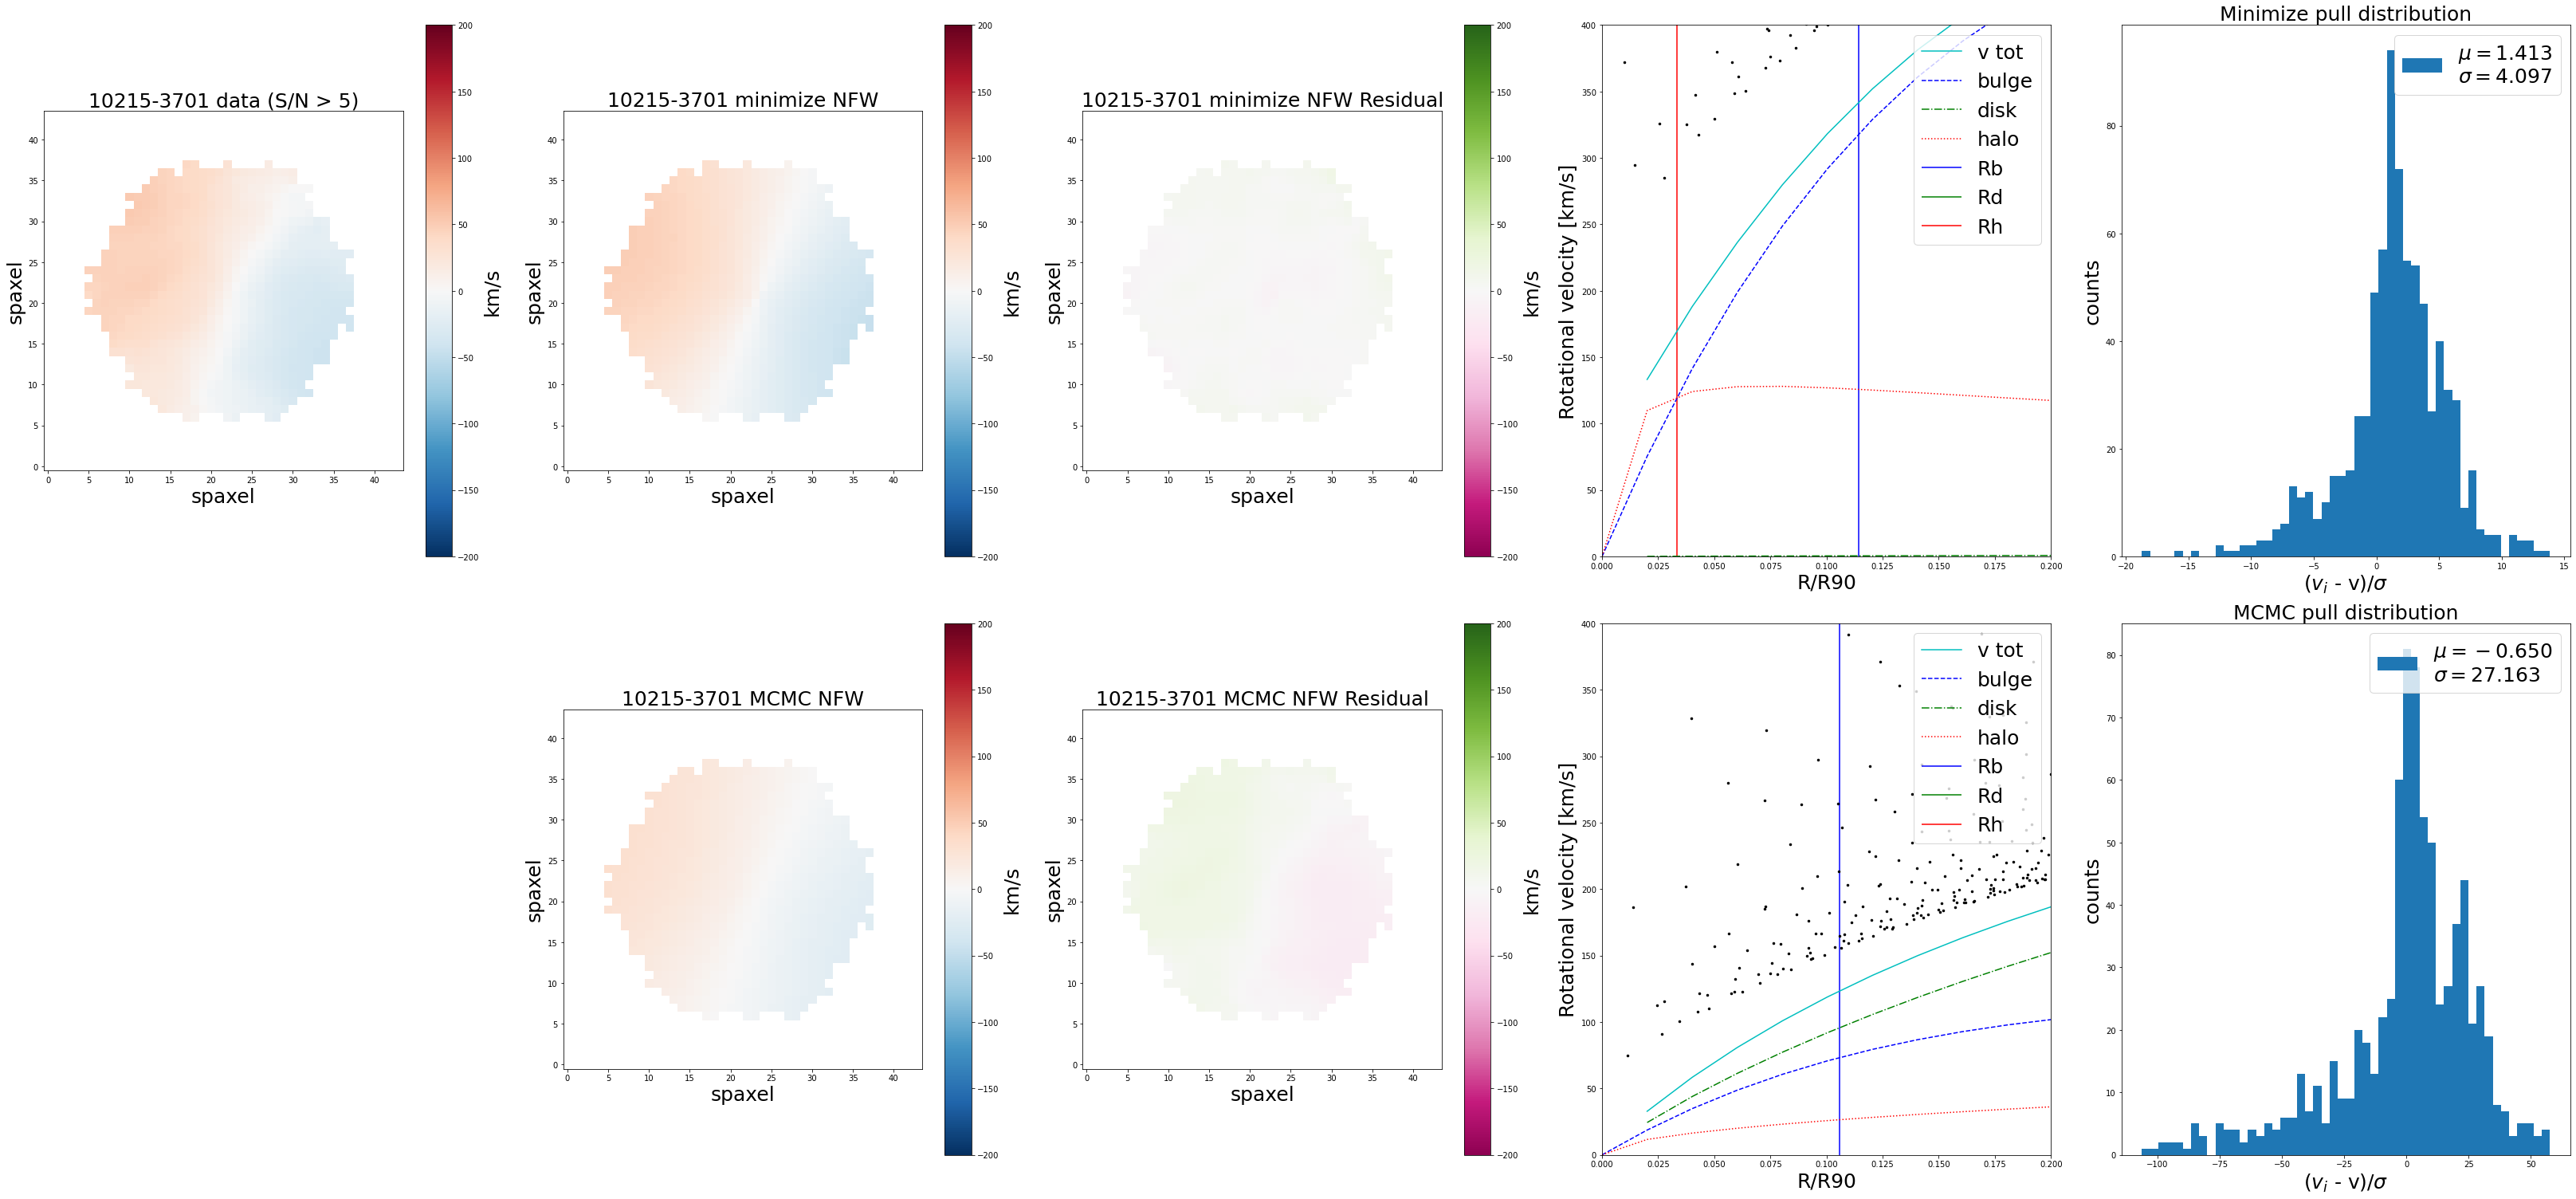

In [72]:
# NFW - 10215-3701

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_3701, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3701 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_3701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3701 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_3701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3701 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_3701 - mini_map_10215_3701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3701 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_3701 - mcmc_map_10215_3701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3701 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_3701/r90_10215_3701, v_mini_10215_3701, 'c',label='v tot')
plt.plot(r_mini_10215_3701/r90_10215_3701, v_b_mini_10215_3701, 'b--',label='bulge')
plt.plot(r_mini_10215_3701/r90_10215_3701, v_d_mini_10215_3701,'g-.',label='disk')
plt.plot(r_mini_10215_3701/r90_10215_3701, v_h_mini_10215_3701,'r:',label='halo')

plt.vlines(x = mini_fit_10215_3701[1]/r90_10215_3701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_3701[3]/r90_10215_3701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_3701[5]/r90_10215_3701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_3701/r90_10215_3701, vm_deproj_mini_10215_3701, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_3701/r90_10215_3701, v_mcmc_10215_3701, 'c',label='v tot')
plt.plot(r_mcmc_10215_3701/r90_10215_3701, v_b_mcmc_10215_3701, 'b--',label='bulge')
plt.plot(r_mcmc_10215_3701/r90_10215_3701, v_d_mcmc_10215_3701,'g-.',label='disk')
plt.plot(r_mcmc_10215_3701/r90_10215_3701, v_h_mcmc_10215_3701,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_3701))

plt.vlines(x = mcmc_fit_10215_3701[1]/r90_10215_3701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_3701[3]/r90_10215_3701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_3701[5]/r90_10215_3701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_3701/r90_10215_3701, vm_deproj_mcmc_10215_3701, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10215_3701 = dmap_10215_3701 - mini_map_10215_3701

dist_minimize_NFW_10215_3701 = residual_minimize_NFW_10215_3701*np.sqrt(ivar_masked_10215_3701)

residual_mcmc_NFW_10215_3701 = dmap_10215_3701 - mcmc_map_10215_3701

dist_mcmc_NFW_10215_3701 = residual_mcmc_NFW_10215_3701*np.sqrt(ivar_masked_10215_3701)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10215_3701 = ma.mean(dist_minimize_NFW_10215_3701)
sig_mini_NFW_10215_3701 = ma.std(dist_minimize_NFW_10215_3701)

n_mini_NFW_10215_3701, bins_mini_NFW_10215_3701, patches_mini_NFW_10215_3701 = plt.hist(dist_minimize_NFW_10215_3701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10215_3701, sig_mini_NFW_10215_3701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10215_3701 = ma.mean(dist_mcmc_NFW_10215_3701)
sig_mcmc_NFW_10215_3701 = ma.std(dist_mcmc_NFW_10215_3701)

n_mcmc_NFW_10215_3701, bins_mcmc_NFW_10215_3701, patches_mcmc_NFW_10215_3701 = plt.hist(dist_mcmc_NFW_10215_3701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10215_3701, sig_mcmc_NFW_10215_3701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_3701))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_3701))
print('r$R_{90}$: ' + str(r90_10215_3701) + ' kpc')
print('Incl from data: ' + str(incl_10215_3701))
print('Incl from Minimize: ' + str(mini_fit_10215_3701[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_3701[-5]))

Minimize r$\chi^2$ : 7.395947952432718
MCMC r$\chi^2$ : 199.53772429555613
r$R_{90}$: 14.104201316833496 kpc
Incl from data: 1.2464581496329892
Incl from Minimize: 0.47811110814102914
Incl from MCMC: 0.38693917711300463


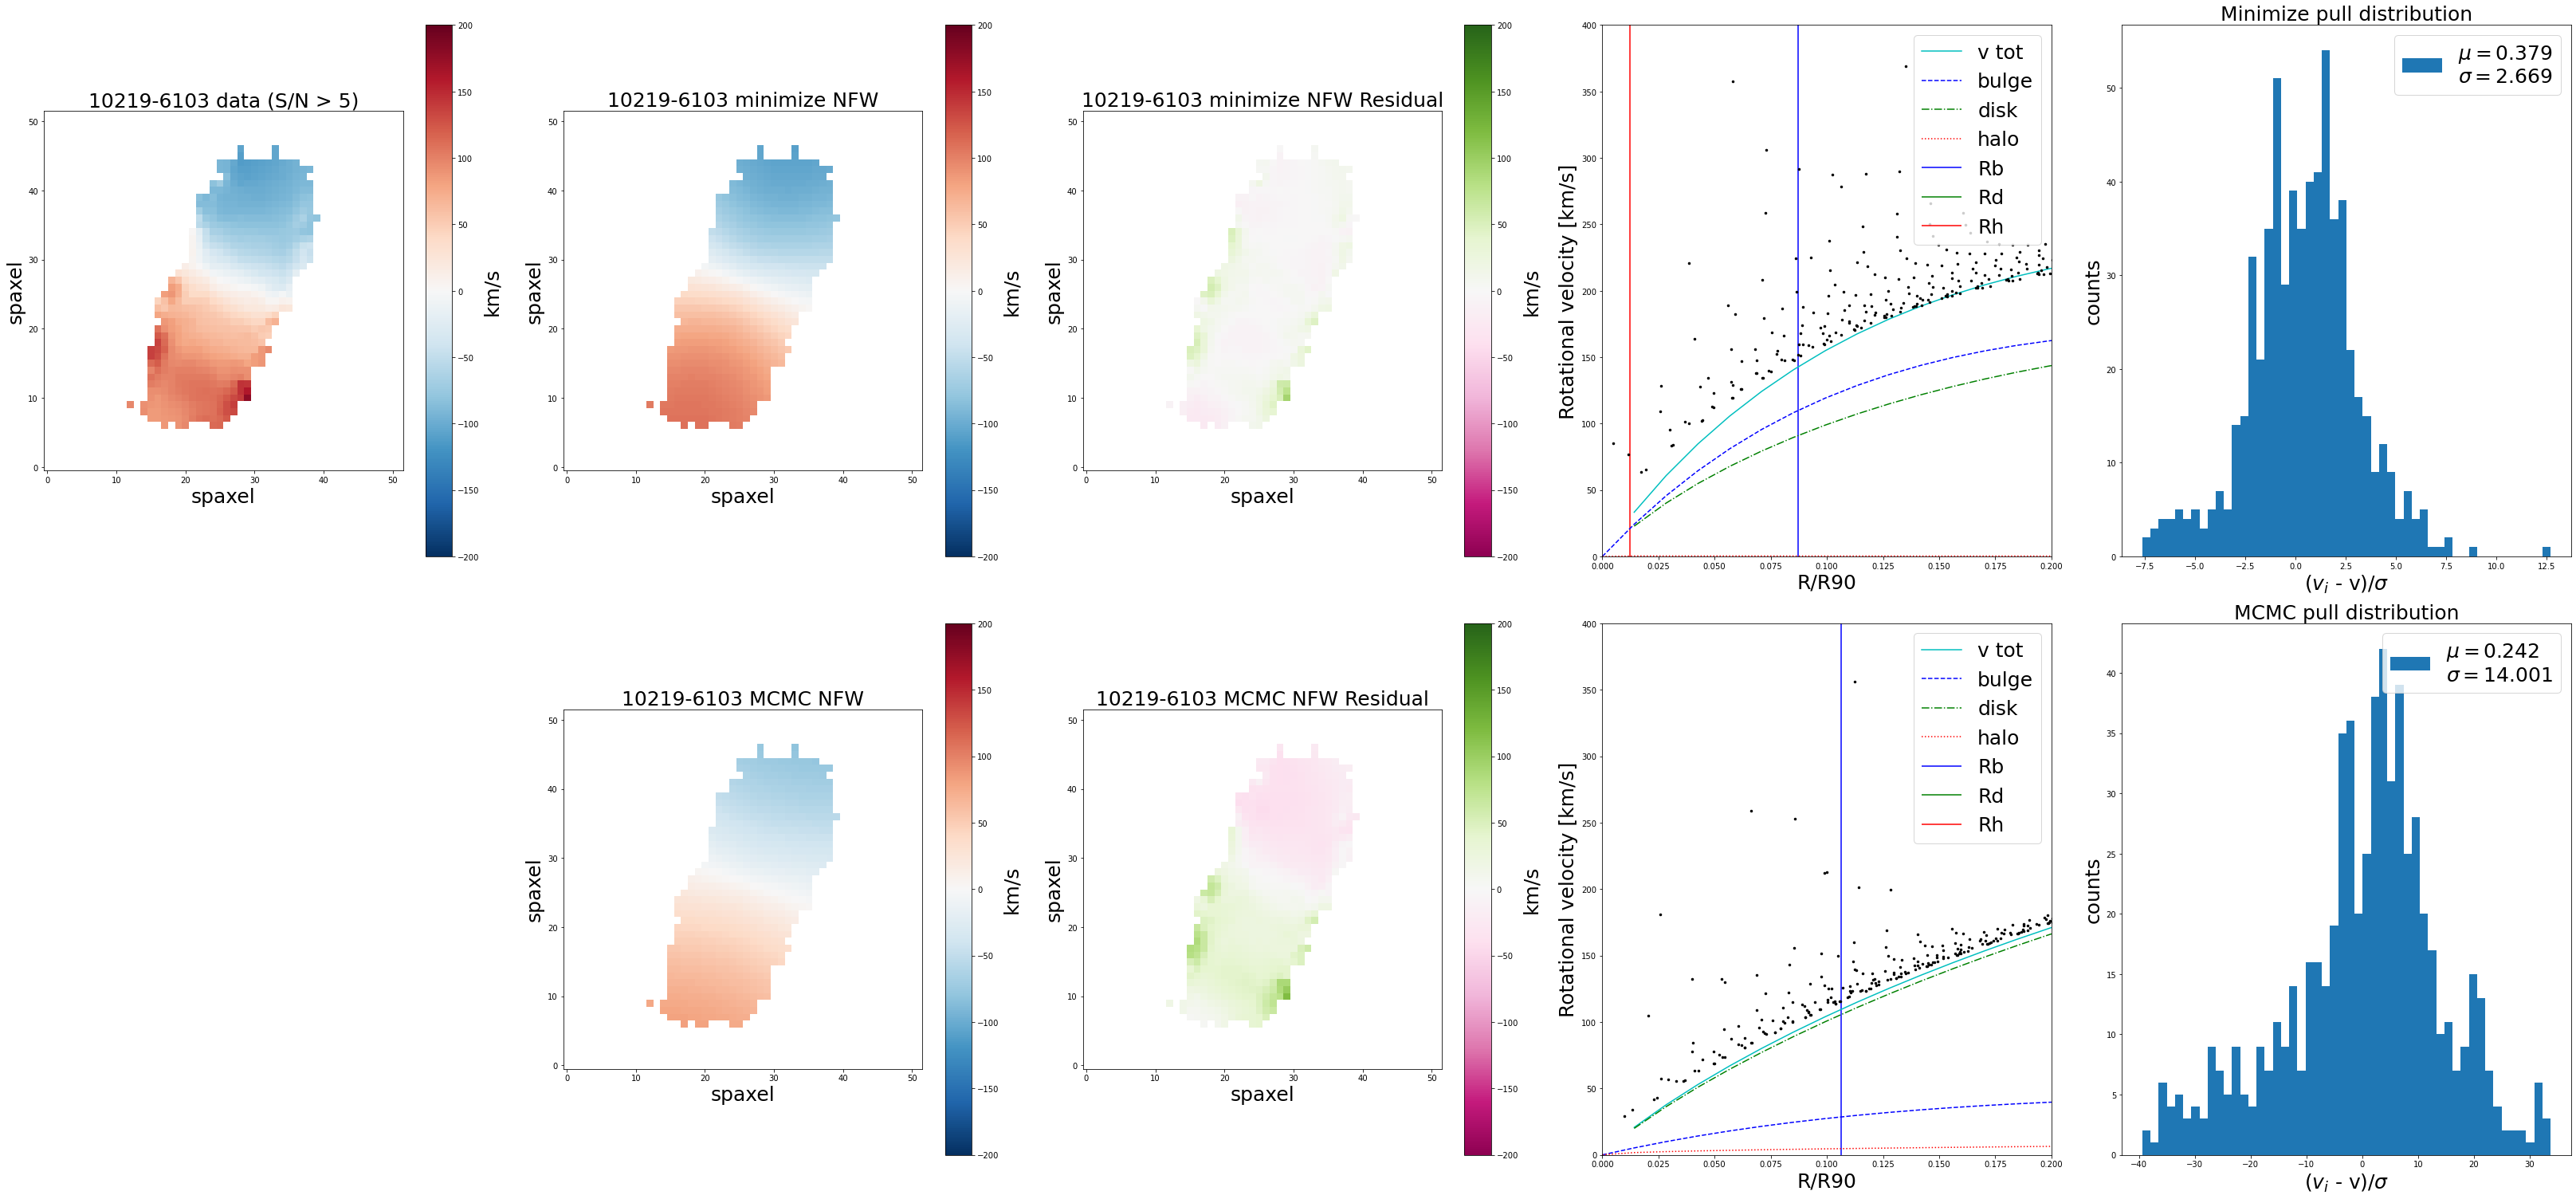

In [73]:
# NFW - 10219-6103

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10219_6103, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-6103 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10219_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-6103 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10219_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-6103 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10219_6103 - mini_map_10219_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-6103 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10219_6103 - mcmc_map_10219_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-6103 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10219_6103/r90_10219_6103, v_mini_10219_6103, 'c',label='v tot')
plt.plot(r_mini_10219_6103/r90_10219_6103, v_b_mini_10219_6103, 'b--',label='bulge')
plt.plot(r_mini_10219_6103/r90_10219_6103, v_d_mini_10219_6103,'g-.',label='disk')
plt.plot(r_mini_10219_6103/r90_10219_6103, v_h_mini_10219_6103,'r:',label='halo')

plt.vlines(x = mini_fit_10219_6103[1]/r90_10219_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10219_6103[3]/r90_10219_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10219_6103[5]/r90_10219_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10219_6103/r90_10219_6103, vm_deproj_mini_10219_6103, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10219_6103/r90_10219_6103, v_mcmc_10219_6103, 'c',label='v tot')
plt.plot(r_mcmc_10219_6103/r90_10219_6103, v_b_mcmc_10219_6103, 'b--',label='bulge')
plt.plot(r_mcmc_10219_6103/r90_10219_6103, v_d_mcmc_10219_6103,'g-.',label='disk')
plt.plot(r_mcmc_10219_6103/r90_10219_6103, v_h_mcmc_10219_6103,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10219_6103))

plt.vlines(x = mcmc_fit_10219_6103[1]/r90_10219_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10219_6103[3]/r90_10219_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10219_6103[5]/r90_10219_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10219_6103/r90_10219_6103, vm_deproj_mcmc_10219_6103, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10219_6103 = dmap_10219_6103 - mini_map_10219_6103

dist_minimize_NFW_10219_6103 = residual_minimize_NFW_10219_6103*np.sqrt(ivar_masked_10219_6103)

residual_mcmc_NFW_10219_6103 = dmap_10219_6103 - mcmc_map_10219_6103

dist_mcmc_NFW_10219_6103 = residual_mcmc_NFW_10219_6103*np.sqrt(ivar_masked_10219_6103)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10219_6103 = ma.mean(dist_minimize_NFW_10219_6103)
sig_mini_NFW_10219_6103 = ma.std(dist_minimize_NFW_10219_6103)

n_mini_NFW_10219_6103, bins_mini_NFW_10219_6103, patches_mini_NFW_10219_6103 = plt.hist(dist_minimize_NFW_10219_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10219_6103, sig_mini_NFW_10219_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10219_6103 = ma.mean(dist_mcmc_NFW_10219_6103)
sig_mcmc_NFW_10219_6103 = ma.std(dist_mcmc_NFW_10219_6103)

n_mcmc_NFW_10219_6103, bins_mcmc_NFW_10219_6103, patches_mcmc_NFW_10219_6103 = plt.hist(dist_mcmc_NFW_10219_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10219_6103, sig_mcmc_NFW_10219_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10219_6103))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10219_6103))
print('r$R_{90}$: ' + str(r90_10219_6103) + ' kpc')
print('Incl from data: ' + str(incl_10219_6103))
print('Incl from Minimize: ' + str(mini_fit_10219_6103[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10219_6103[-5]))

Minimize r$\chi^2$ : 91.65594949977009
MCMC r$\chi^2$ : 842.9047817504423
r$R_{90}$: 23.16202163696289 kpc
Incl from data: 0.8549308984943766
Incl from Minimize: 0.5232692701403431
Incl from MCMC: 0.8788368082528323


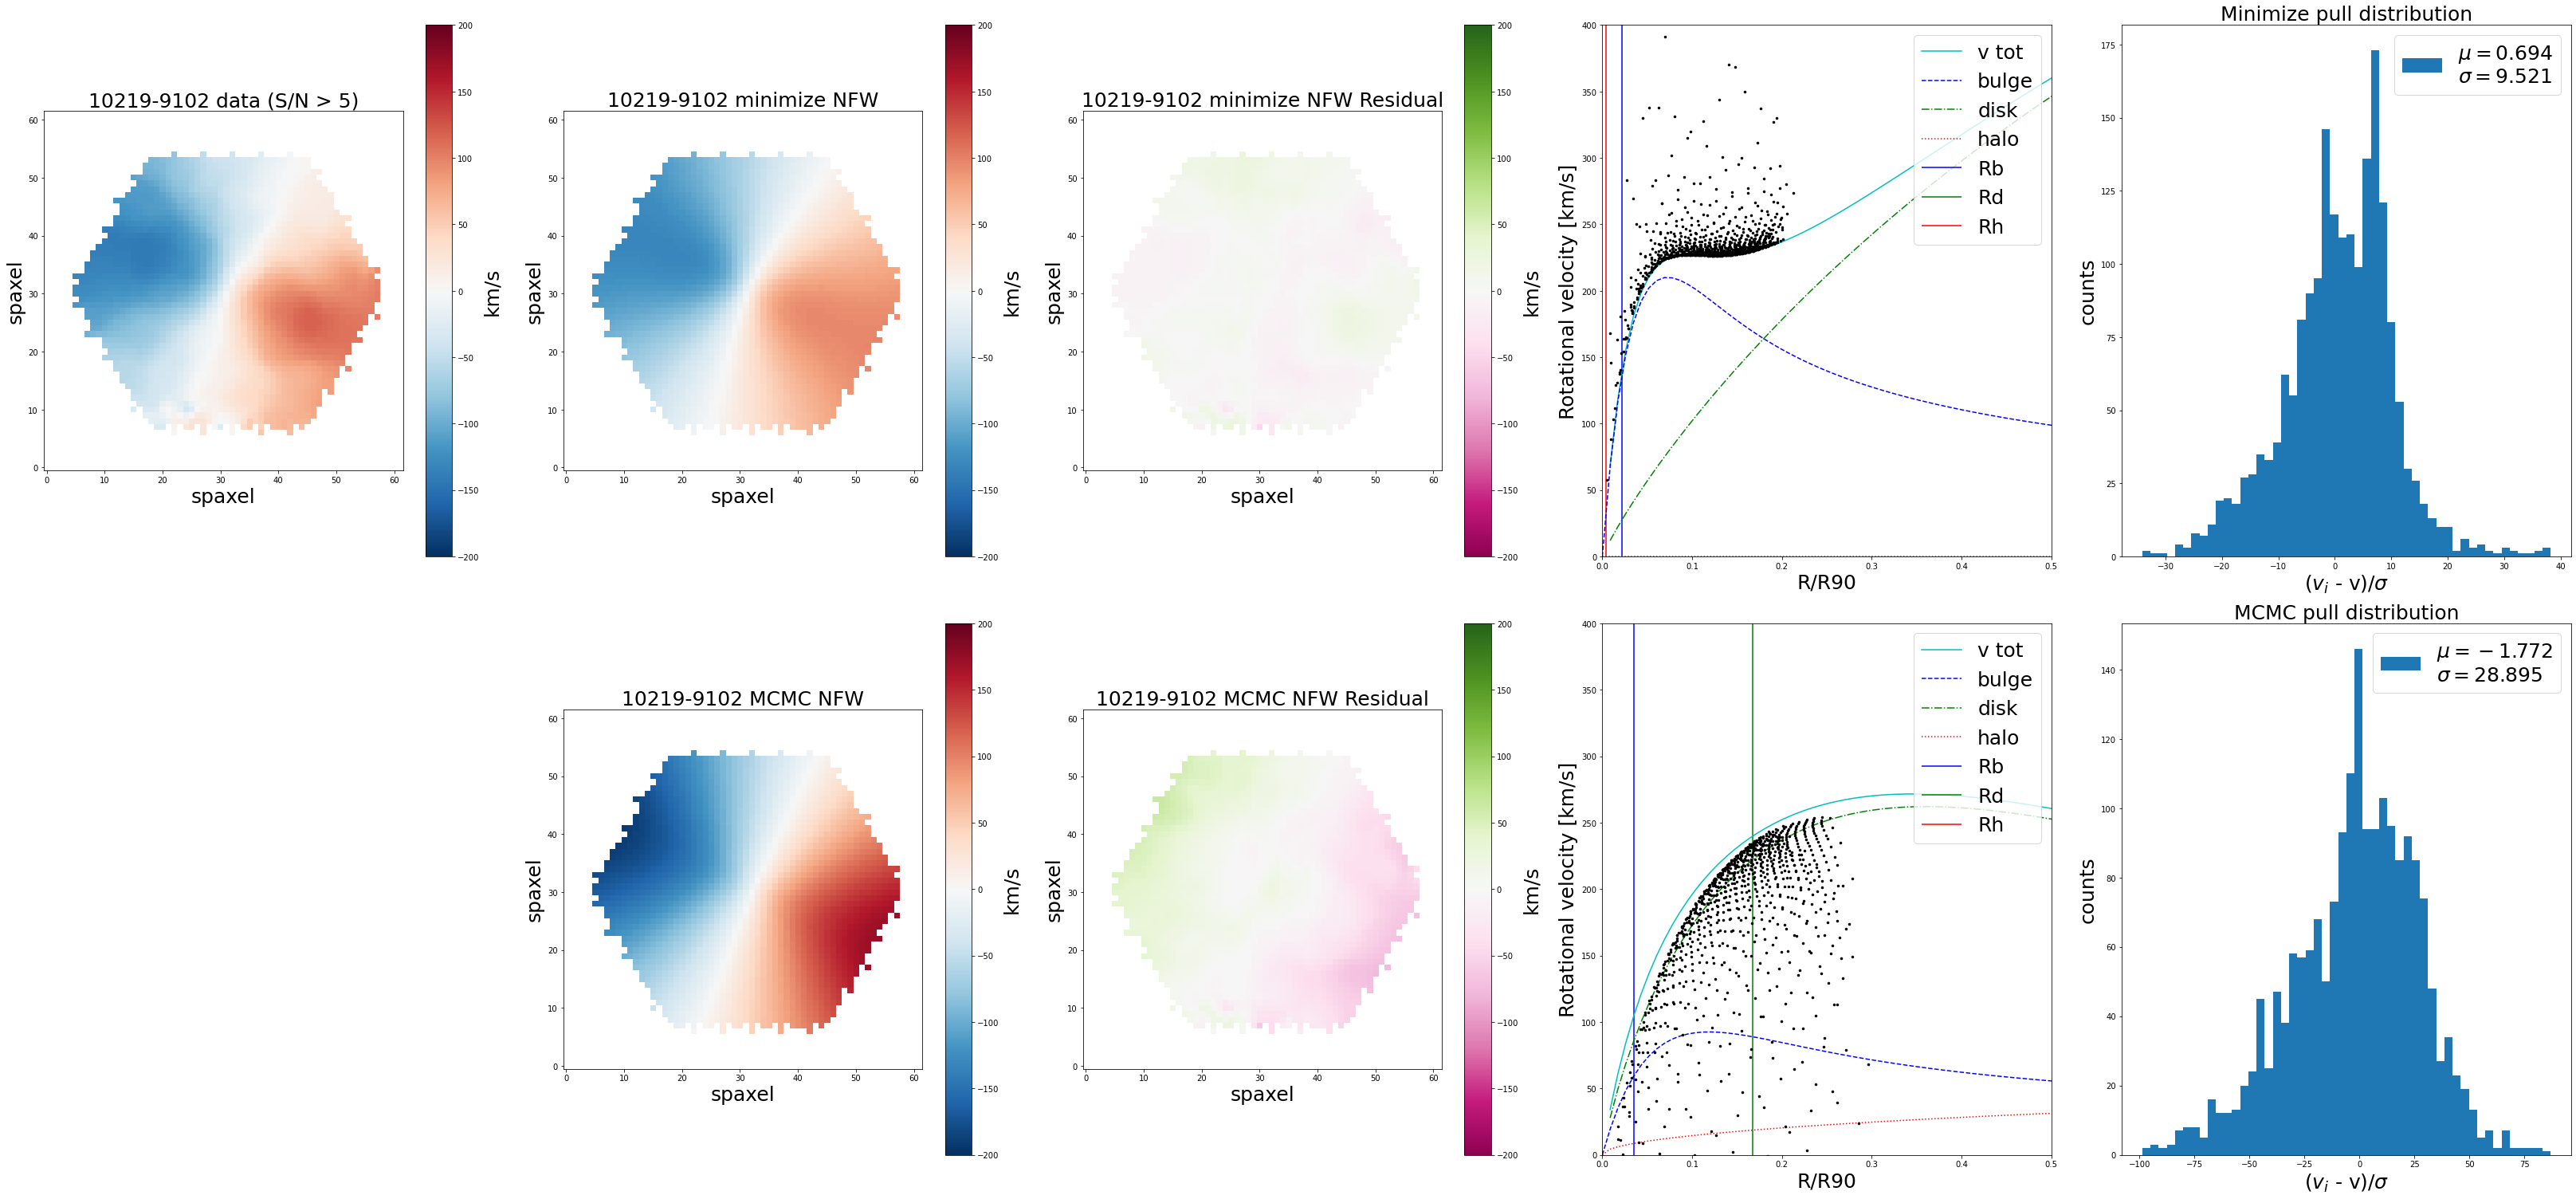

In [75]:
# NFW - 10219-9102

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10219_9102, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-9102 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10219_9102, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-9102 minimize NFW', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10219_9102, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-9102 MCMC NFW', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10219_9102 - mini_map_10219_9102, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-9102 minimize NFW Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10219_9102 - mcmc_map_10219_9102, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10219-9102 MCMC NFW Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10219_9102/r90_10219_9102, v_mini_10219_9102, 'c',label='v tot')
plt.plot(r_mini_10219_9102/r90_10219_9102, v_b_mini_10219_9102, 'b--',label='bulge')
plt.plot(r_mini_10219_9102/r90_10219_9102, v_d_mini_10219_9102,'g-.',label='disk')
plt.plot(r_mini_10219_9102/r90_10219_9102, v_h_mini_10219_9102,'r:',label='halo')

plt.vlines(x = mini_fit_10219_9102[1]/r90_10219_9102,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10219_9102[3]/r90_10219_9102,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10219_9102[5]/r90_10219_9102,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10219_9102/r90_10219_9102, vm_deproj_mini_10219_9102, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10219_9102/r90_10219_9102, v_mcmc_10219_9102, 'c',label='v tot')
plt.plot(r_mcmc_10219_9102/r90_10219_9102, v_b_mcmc_10219_9102, 'b--',label='bulge')
plt.plot(r_mcmc_10219_9102/r90_10219_9102, v_d_mcmc_10219_9102,'g-.',label='disk')
plt.plot(r_mcmc_10219_9102/r90_10219_9102, v_h_mcmc_10219_9102,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10219_9102))

plt.vlines(x = mcmc_fit_10219_9102[1]/r90_10219_9102,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10219_9102[3]/r90_10219_9102,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10219_9102[5]/r90_10219_9102,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10219_9102/r90_10219_9102, vm_deproj_mcmc_10219_9102, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_NFW_10219_9102 = dmap_10219_9102 - mini_map_10219_9102

dist_minimize_NFW_10219_9102 = residual_minimize_NFW_10219_9102*np.sqrt(ivar_masked_10219_9102)

residual_mcmc_NFW_10219_9102 = dmap_10219_9102 - mcmc_map_10219_9102

dist_mcmc_NFW_10219_9102 = residual_mcmc_NFW_10219_9102*np.sqrt(ivar_masked_10219_9102)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_NFW_10219_9102 = ma.mean(dist_minimize_NFW_10219_9102)
sig_mini_NFW_10219_9102 = ma.std(dist_minimize_NFW_10219_9102)

n_mini_NFW_10219_9102, bins_mini_NFW_10219_9102, patches_mini_NFW_10219_9102 = plt.hist(dist_minimize_NFW_10219_9102.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_NFW_10219_9102, sig_mini_NFW_10219_9102))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_NFW_10219_9102 = ma.mean(dist_mcmc_NFW_10219_9102)
sig_mcmc_NFW_10219_9102 = ma.std(dist_mcmc_NFW_10219_9102)

n_mcmc_NFW_10219_9102, bins_mcmc_NFW_10219_9102, patches_mcmc_NFW_10219_9102 = plt.hist(dist_mcmc_NFW_10219_9102.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_NFW_10219_9102, sig_mcmc_NFW_10219_9102))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10219_9102))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10219_9102))
print('r$R_{90}$: ' + str(r90_10219_9102) + ' kpc')
print('Incl from data: ' + str(incl_10219_9102))
print('Incl from Minimize: ' + str(mini_fit_10219_9102[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10219_9102[-5]))

In [76]:
# Isothermal 
# Improved
dmap_10001_12702,ivar_masked_10001_12702, incl_10001_12702, scale_10001_12702, r90_10001_12702, mini_fit_10001_12702, mcmc_fit_10001_12702, mini_map_10001_12702, mcmc_map_10001_12702, chi2_mini_10001_12702, chi2_mcmc_10001_12702,r_mini_10001_12702, v_b_mini_10001_12702, v_d_mini_10001_12702, v_h_mini_10001_12702, v_mini_10001_12702, r_mcmc_10001_12702, v_b_mcmc_10001_12702, v_d_mcmc_10001_12702, v_h_mcmc_10001_12702, v_mcmc_10001_12702  = get_info('10001-12702',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10001_12705,ivar_masked_10001_12705, incl_10001_12705, scale_10001_12705, r90_10001_12705, mini_fit_10001_12705, mcmc_fit_10001_12705, mini_map_10001_12705, mcmc_map_10001_12705, chi2_mini_10001_12705, chi2_mcmc_10001_12705,r_mini_10001_12705, v_b_mini_10001_12705, v_d_mini_10001_12705, v_h_mini_10001_12705, v_mini_10001_12705, r_mcmc_10001_12705, v_b_mcmc_10001_12705, v_d_mcmc_10001_12705, v_h_mcmc_10001_12705, v_mcmc_10001_12705  = get_info('10001-12705',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10001_3702,ivar_masked_10001_3702, incl_10001_3702, scale_10001_3702, r90_10001_3702, mini_fit_10001_3702, mcmc_fit_10001_3702, mini_map_10001_3702, mcmc_map_10001_3702, chi2_mini_10001_3702, chi2_mcmc_10001_3702,r_mini_10001_3702, v_b_mini_10001_3702, v_d_mini_10001_3702, v_h_mini_10001_3702, v_mini_10001_3702, r_mcmc_10001_3702, v_b_mcmc_10001_3702, v_d_mcmc_10001_3702, v_h_mcmc_10001_3702, v_mcmc_10001_3702  = get_info('10001-3702',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10001_3703,ivar_masked_10001_3703, incl_10001_3703, scale_10001_3703, r90_10001_3703, mini_fit_10001_3703, mcmc_fit_10001_3703, mini_map_10001_3703, mcmc_map_10001_3703, chi2_mini_10001_3703, chi2_mcmc_10001_3703,r_mini_10001_3703, v_b_mini_10001_3703, v_d_mini_10001_3703, v_h_mini_10001_3703, v_mini_10001_3703, r_mcmc_10001_3703, v_b_mcmc_10001_3703, v_d_mcmc_10001_3703, v_h_mcmc_10001_3703, v_mcmc_10001_3703  = get_info('10001-3703',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10213_12702,ivar_masked_10213_12702, incl_10213_12702, scale_10213_12702, r90_10213_12702, mini_fit_10213_12702, mcmc_fit_10213_12702, mini_map_10213_12702, mcmc_map_10213_12702, chi2_mini_10213_12702, chi2_mcmc_10213_12702,r_mini_10213_12702, v_b_mini_10213_12702, v_d_mini_10213_12702, v_h_mini_10213_12702, v_mini_10213_12702, r_mcmc_10213_12702, v_b_mcmc_10213_12702, v_d_mcmc_10213_12702, v_h_mcmc_10213_12702, v_mcmc_10213_12702  = get_info('10213-12702',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
# Lost
dmap_10001_12701,ivar_masked_10001_12701, incl_10001_12701, scale_10001_12701, r90_10001_12701, mini_fit_10001_12701, mcmc_fit_10001_12701, mini_map_10001_12701, mcmc_map_10001_12701, chi2_mini_10001_12701, chi2_mcmc_10001_12701,r_mini_10001_12701, v_b_mini_10001_12701, v_d_mini_10001_12701, v_h_mini_10001_12701, v_mini_10001_12701, r_mcmc_10001_12701, v_b_mcmc_10001_12701, v_d_mcmc_10001_12701, v_h_mcmc_10001_12701, v_mcmc_10001_12701  = get_info('10001-12701',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10213_12705,ivar_masked_10213_12705, incl_10213_12705, scale_10213_12705, r90_10213_12705, mini_fit_10213_12705, mcmc_fit_10213_12705, mini_map_10213_12705, mcmc_map_10213_12705, chi2_mini_10213_12705, chi2_mcmc_10213_12705,r_mini_10213_12705, v_b_mini_10213_12705, v_d_mini_10213_12705, v_h_mini_10213_12705, v_mini_10213_12705, r_mcmc_10213_12705, v_b_mcmc_10213_12705, v_d_mcmc_10213_12705, v_h_mcmc_10213_12705, v_mcmc_10213_12705  = get_info('10213-12705',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10215_12702,ivar_masked_10215_12702, incl_10215_12702, scale_10215_12702, r90_10215_12702, mini_fit_10215_12702, mcmc_fit_10215_12702, mini_map_10215_12702, mcmc_map_10215_12702, chi2_mini_10215_12702, chi2_mcmc_10215_12702,r_mini_10215_12702, v_b_mini_10215_12702, v_d_mini_10215_12702, v_h_mini_10215_12702, v_mini_10215_12702, r_mcmc_10215_12702, v_b_mcmc_10215_12702, v_d_mcmc_10215_12702, v_h_mcmc_10215_12702, v_mcmc_10215_12702  = get_info('10215-12702',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10216_6103,ivar_masked_10216_6103, incl_10216_6103, scale_10216_6103, r90_10216_6103, mini_fit_10216_6103, mcmc_fit_10216_6103, mini_map_10216_6103, mcmc_map_10216_6103, chi2_mini_10216_6103, chi2_mcmc_10216_6103,r_mini_10216_6103, v_b_mini_10216_6103, v_d_mini_10216_6103, v_h_mini_10216_6103, v_mini_10216_6103, r_mcmc_10216_6103, v_b_mcmc_10216_6103, v_d_mcmc_10216_6103, v_h_mcmc_10216_6103, v_mcmc_10216_6103  = get_info('10216-6103',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')
dmap_10217_12705,ivar_masked_10217_12705, incl_10217_12705, scale_10217_12705, r90_10217_12705, mini_fit_10217_12705, mcmc_fit_10217_12705, mini_map_10217_12705, mcmc_map_10217_12705, chi2_mini_10217_12705, chi2_mcmc_10217_12705,r_mini_10217_12705, v_b_mini_10217_12705, v_d_mini_10217_12705, v_h_mini_10217_12705, v_mini_10217_12705, r_mcmc_10217_12705, v_b_mcmc_10217_12705, v_d_mcmc_10217_12705, v_h_mcmc_10217_12705, v_mcmc_10217_12705  = get_info('10217-12705',iso_mini_fits,iso_mini_fits_mc_corr,r90_file,'iso')

In [77]:
# Deprojected velocity maps
# Improved
rm_deproj_mini_10001_12702, vm_deproj_mini_10001_12702 = vel_map_depro(dmap_10001_12702, mini_fit_10001_12702, scale_10001_12702)
rm_deproj_mcmc_10001_12702, vm_deproj_mcmc_10001_12702 = vel_map_depro(dmap_10001_12702, mcmc_fit_10001_12702, scale_10001_12702)
rm_deproj_mini_10001_12705, vm_deproj_mini_10001_12705 = vel_map_depro(dmap_10001_12705, mini_fit_10001_12705, scale_10001_12705)
rm_deproj_mcmc_10001_12705, vm_deproj_mcmc_10001_12705 = vel_map_depro(dmap_10001_12705, mcmc_fit_10001_12705, scale_10001_12705)
rm_deproj_mini_10001_3702, vm_deproj_mini_10001_3702 = vel_map_depro(dmap_10001_3702, mini_fit_10001_3702, scale_10001_3702)
rm_deproj_mcmc_10001_3702, vm_deproj_mcmc_10001_3702 = vel_map_depro(dmap_10001_3702, mcmc_fit_10001_3702, scale_10001_3702)
rm_deproj_mini_10001_3703, vm_deproj_mini_10001_3703 = vel_map_depro(dmap_10001_3703, mini_fit_10001_3703, scale_10001_3703)
rm_deproj_mcmc_10001_3703, vm_deproj_mcmc_10001_3703 = vel_map_depro(dmap_10001_3703, mcmc_fit_10001_3703, scale_10001_3703)
rm_deproj_mini_10213_12702, vm_deproj_mini_10213_12702 = vel_map_depro(mini_map_10213_12702, mini_fit_10213_12702, scale_10213_12702)
rm_deproj_mcmc_10213_12702, vm_deproj_mcmc_10213_12702 = vel_map_depro(mcmc_map_10213_12702, mcmc_fit_10213_12702, scale_10213_12702)
# Increased
rm_deproj_mini_10001_12701, vm_deproj_mini_10001_12701 = vel_map_depro(dmap_10001_12701, mini_fit_10001_12701, scale_10001_12701)
rm_deproj_mcmc_10001_12701, vm_deproj_mcmc_10001_12701 = vel_map_depro(dmap_10001_12701, mcmc_fit_10001_12701, scale_10001_12701)
rm_deproj_mini_10213_12705, vm_deproj_mini_10213_12705 = vel_map_depro(mini_map_10213_12705, mini_fit_10213_12705, scale_10213_12705)
rm_deproj_mcmc_10213_12705, vm_deproj_mcmc_10213_12705 = vel_map_depro(mcmc_map_10213_12705, mcmc_fit_10213_12705, scale_10213_12705)
rm_deproj_mini_10215_12702, vm_deproj_mini_10215_12702 = vel_map_depro(mini_map_10215_12702, mini_fit_10215_12702, scale_10215_12702)
rm_deproj_mcmc_10215_12702, vm_deproj_mcmc_10215_12702 = vel_map_depro(mcmc_map_10215_12702, mcmc_fit_10215_12702, scale_10215_12702)
rm_deproj_mini_10216_6103, vm_deproj_mini_10216_6103 = vel_map_depro(mini_map_10216_6103, mini_fit_10216_6103, scale_10216_6103)
rm_deproj_mcmc_10216_6103, vm_deproj_mcmc_10216_6103 = vel_map_depro(mcmc_map_10216_6103, mcmc_fit_10216_6103, scale_10216_6103)
rm_deproj_mini_10217_12705, vm_deproj_mini_10217_12705 = vel_map_depro(mini_map_10217_12705, mini_fit_10217_12705, scale_10217_12705)
rm_deproj_mcmc_10217_12705, vm_deproj_mcmc_10217_12705 = vel_map_depro(mcmc_map_10217_12705, mcmc_fit_10217_12705, scale_10217_12705)

Minimize r$\chi^2$ : 5.870467141112022
MCMC r$\chi^2$ : 5.508518068081702
r$R_{90}$: 14.355437278747559 kpc
Incl from data: 0.9578140884777914
Incl from Minimize: 0.6765155109865308
Incl from MCMC: 0.8622607781967179


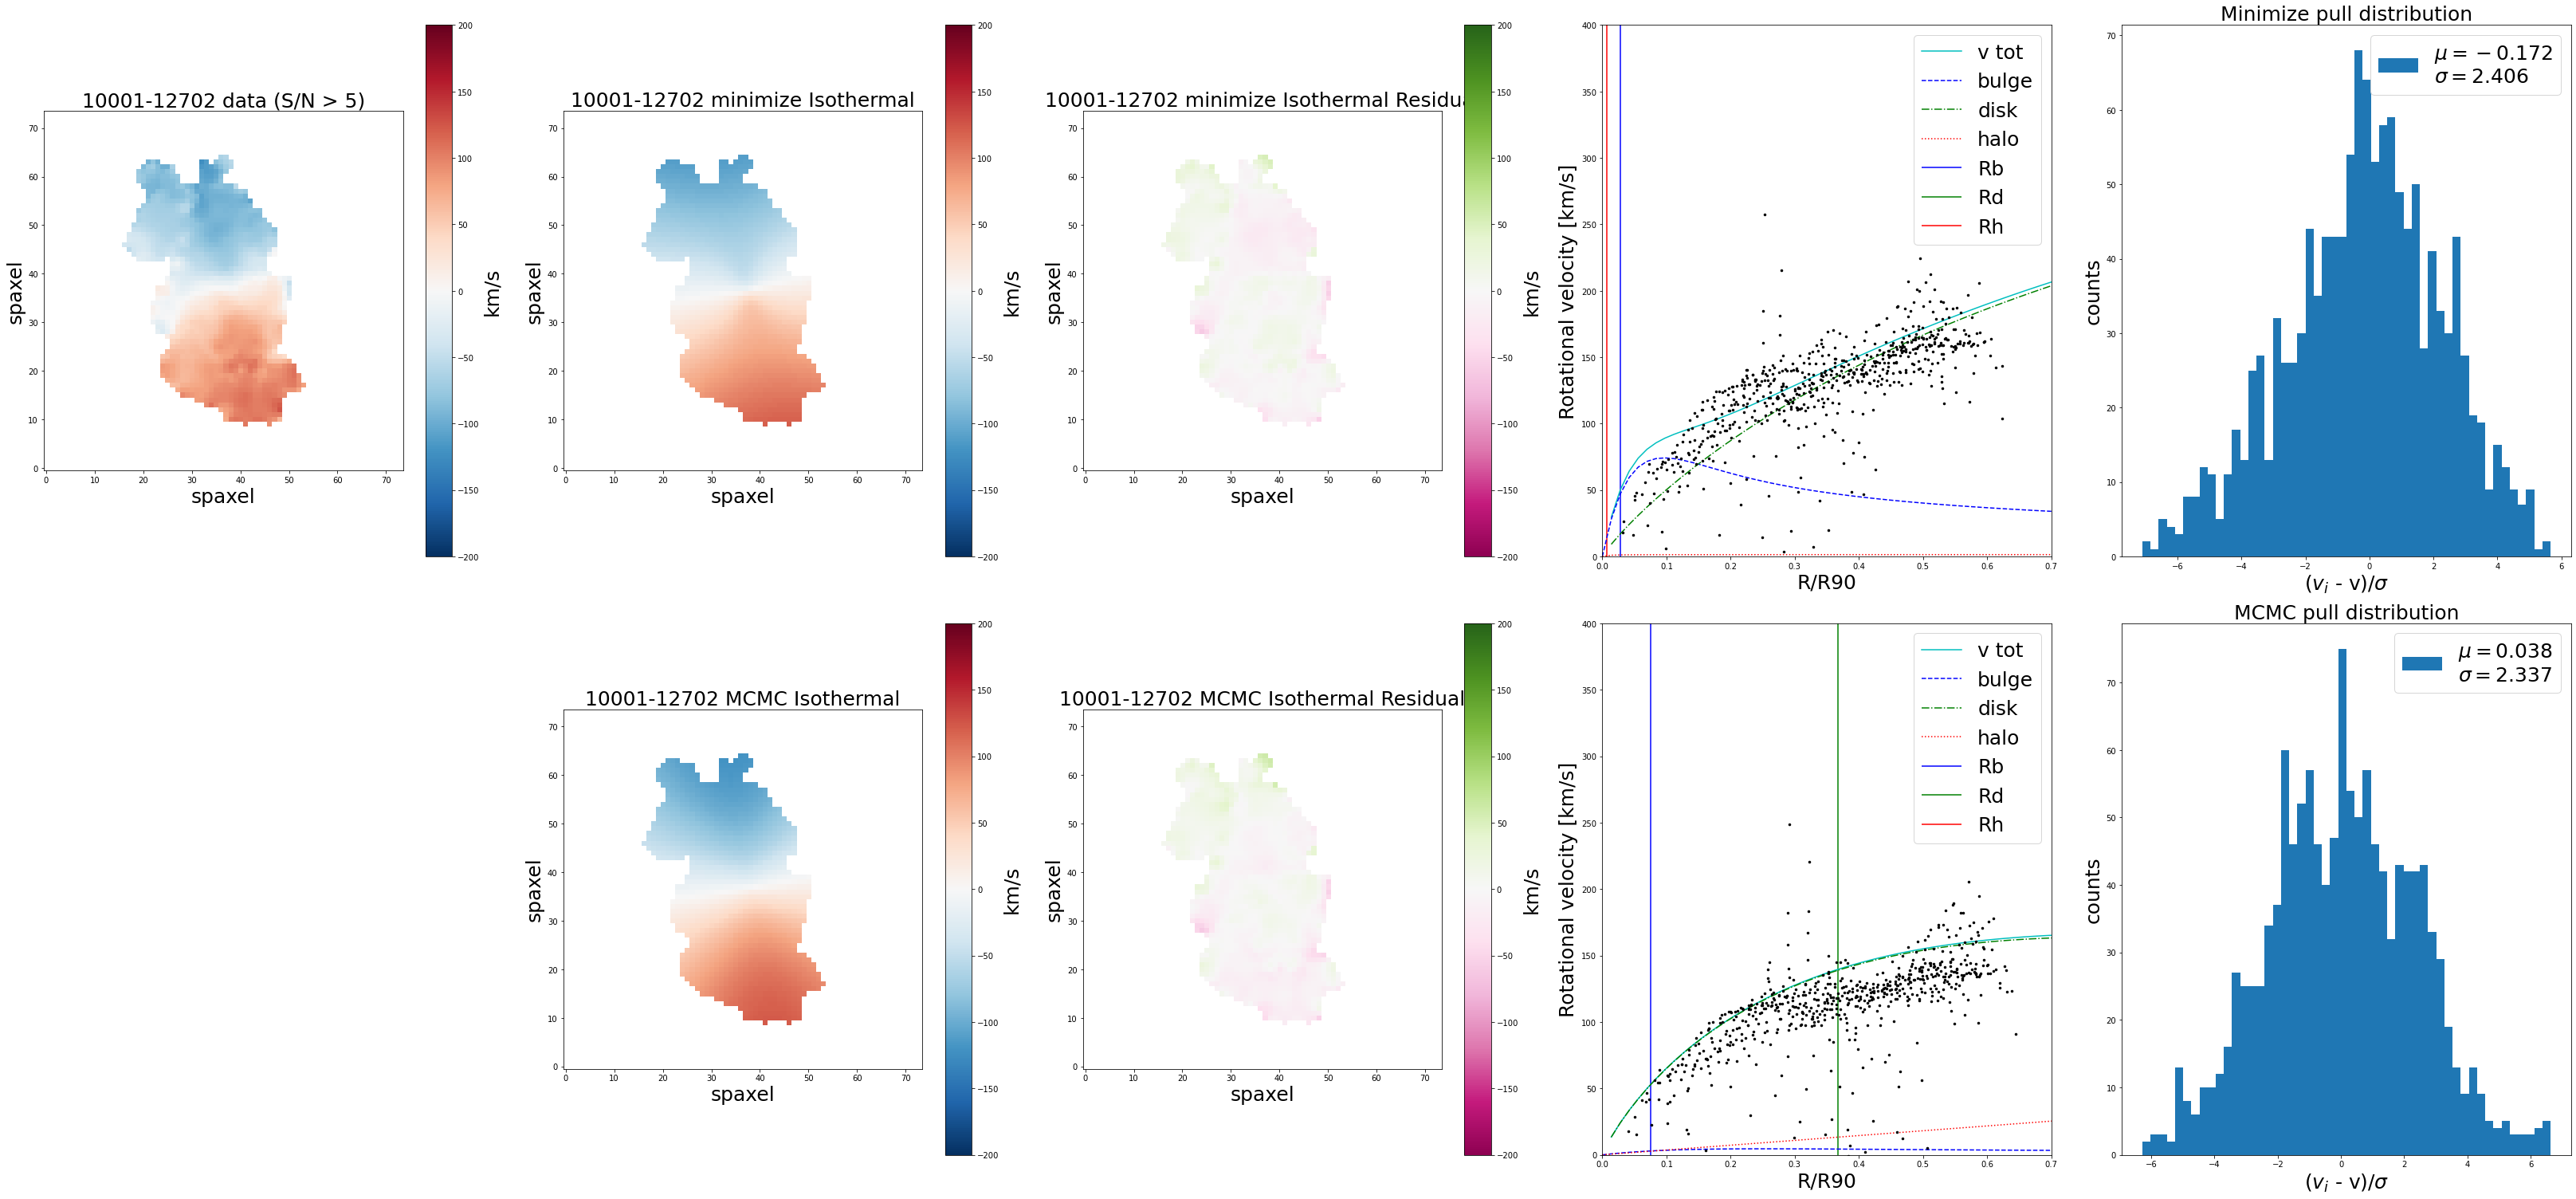

In [80]:
# Isothermal - 10001-12702

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12702, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12702 - mini_map_10001_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12702 - mcmc_map_10001_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12702/r90_10001_12702, v_mini_10001_12702, 'c',label='v tot')
plt.plot(r_mini_10001_12702/r90_10001_12702, v_b_mini_10001_12702, 'b--',label='bulge')
plt.plot(r_mini_10001_12702/r90_10001_12702, v_d_mini_10001_12702,'g-.',label='disk')
plt.plot(r_mini_10001_12702/r90_10001_12702, v_h_mini_10001_12702,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12702[1]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12702[3]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12702[5]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12702/r90_10001_12702, vm_deproj_mini_10001_12702, 'k.', markersize=5)

plt.xlim([0,0.7])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_mcmc_10001_12702, 'c',label='v tot')
plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_b_mcmc_10001_12702, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_d_mcmc_10001_12702,'g-.',label='disk')
plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_h_mcmc_10001_12702,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12702))

plt.vlines(x = mcmc_fit_10001_12702[1]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12702[3]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12702[5]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12702/r90_10001_12702, vm_deproj_mcmc_10001_12702, 'k.', markersize=5)

plt.xlim([0,0.7])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10001_12702 = dmap_10001_12702 - mini_map_10001_12702

dist_minimize_Isothermal_10001_12702 = residual_minimize_Isothermal_10001_12702*np.sqrt(ivar_masked_10001_12702)

residual_mcmc_Isothermal_10001_12702 = dmap_10001_12702 - mcmc_map_10001_12702

dist_mcmc_Isothermal_10001_12702 = residual_mcmc_Isothermal_10001_12702*np.sqrt(ivar_masked_10001_12702)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10001_12702 = ma.mean(dist_minimize_Isothermal_10001_12702)
sig_mini_Isothermal_10001_12702 = ma.std(dist_minimize_Isothermal_10001_12702)

n_mini_Isothermal_10001_12702, bins_mini_Isothermal_10001_12702, patches_mini_Isothermal_10001_12702 = plt.hist(dist_minimize_Isothermal_10001_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10001_12702, sig_mini_Isothermal_10001_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10001_12702 = ma.mean(dist_mcmc_Isothermal_10001_12702)
sig_mcmc_Isothermal_10001_12702 = ma.std(dist_mcmc_Isothermal_10001_12702)

n_mcmc_Isothermal_10001_12702, bins_mcmc_Isothermal_10001_12702, patches_mcmc_Isothermal_10001_12702 = plt.hist(dist_mcmc_Isothermal_10001_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10001_12702, sig_mcmc_Isothermal_10001_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12702))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12702))
print('r$R_{90}$: ' + str(r90_10001_12702) + ' kpc')
print('Incl from data: ' + str(incl_10001_12702))
print('Incl from Minimize: ' + str(mini_fit_10001_12702[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12702[-5]))

Minimize r$\chi^2$ : 44.51862360648296
MCMC r$\chi^2$ : 15.857008236514641
r$R_{90}$: 12.379983901977539 kpc
Incl from data: 1.031910603682927
Incl from Minimize: 0.11856259934809542
Incl from MCMC: 0.8473370504358645


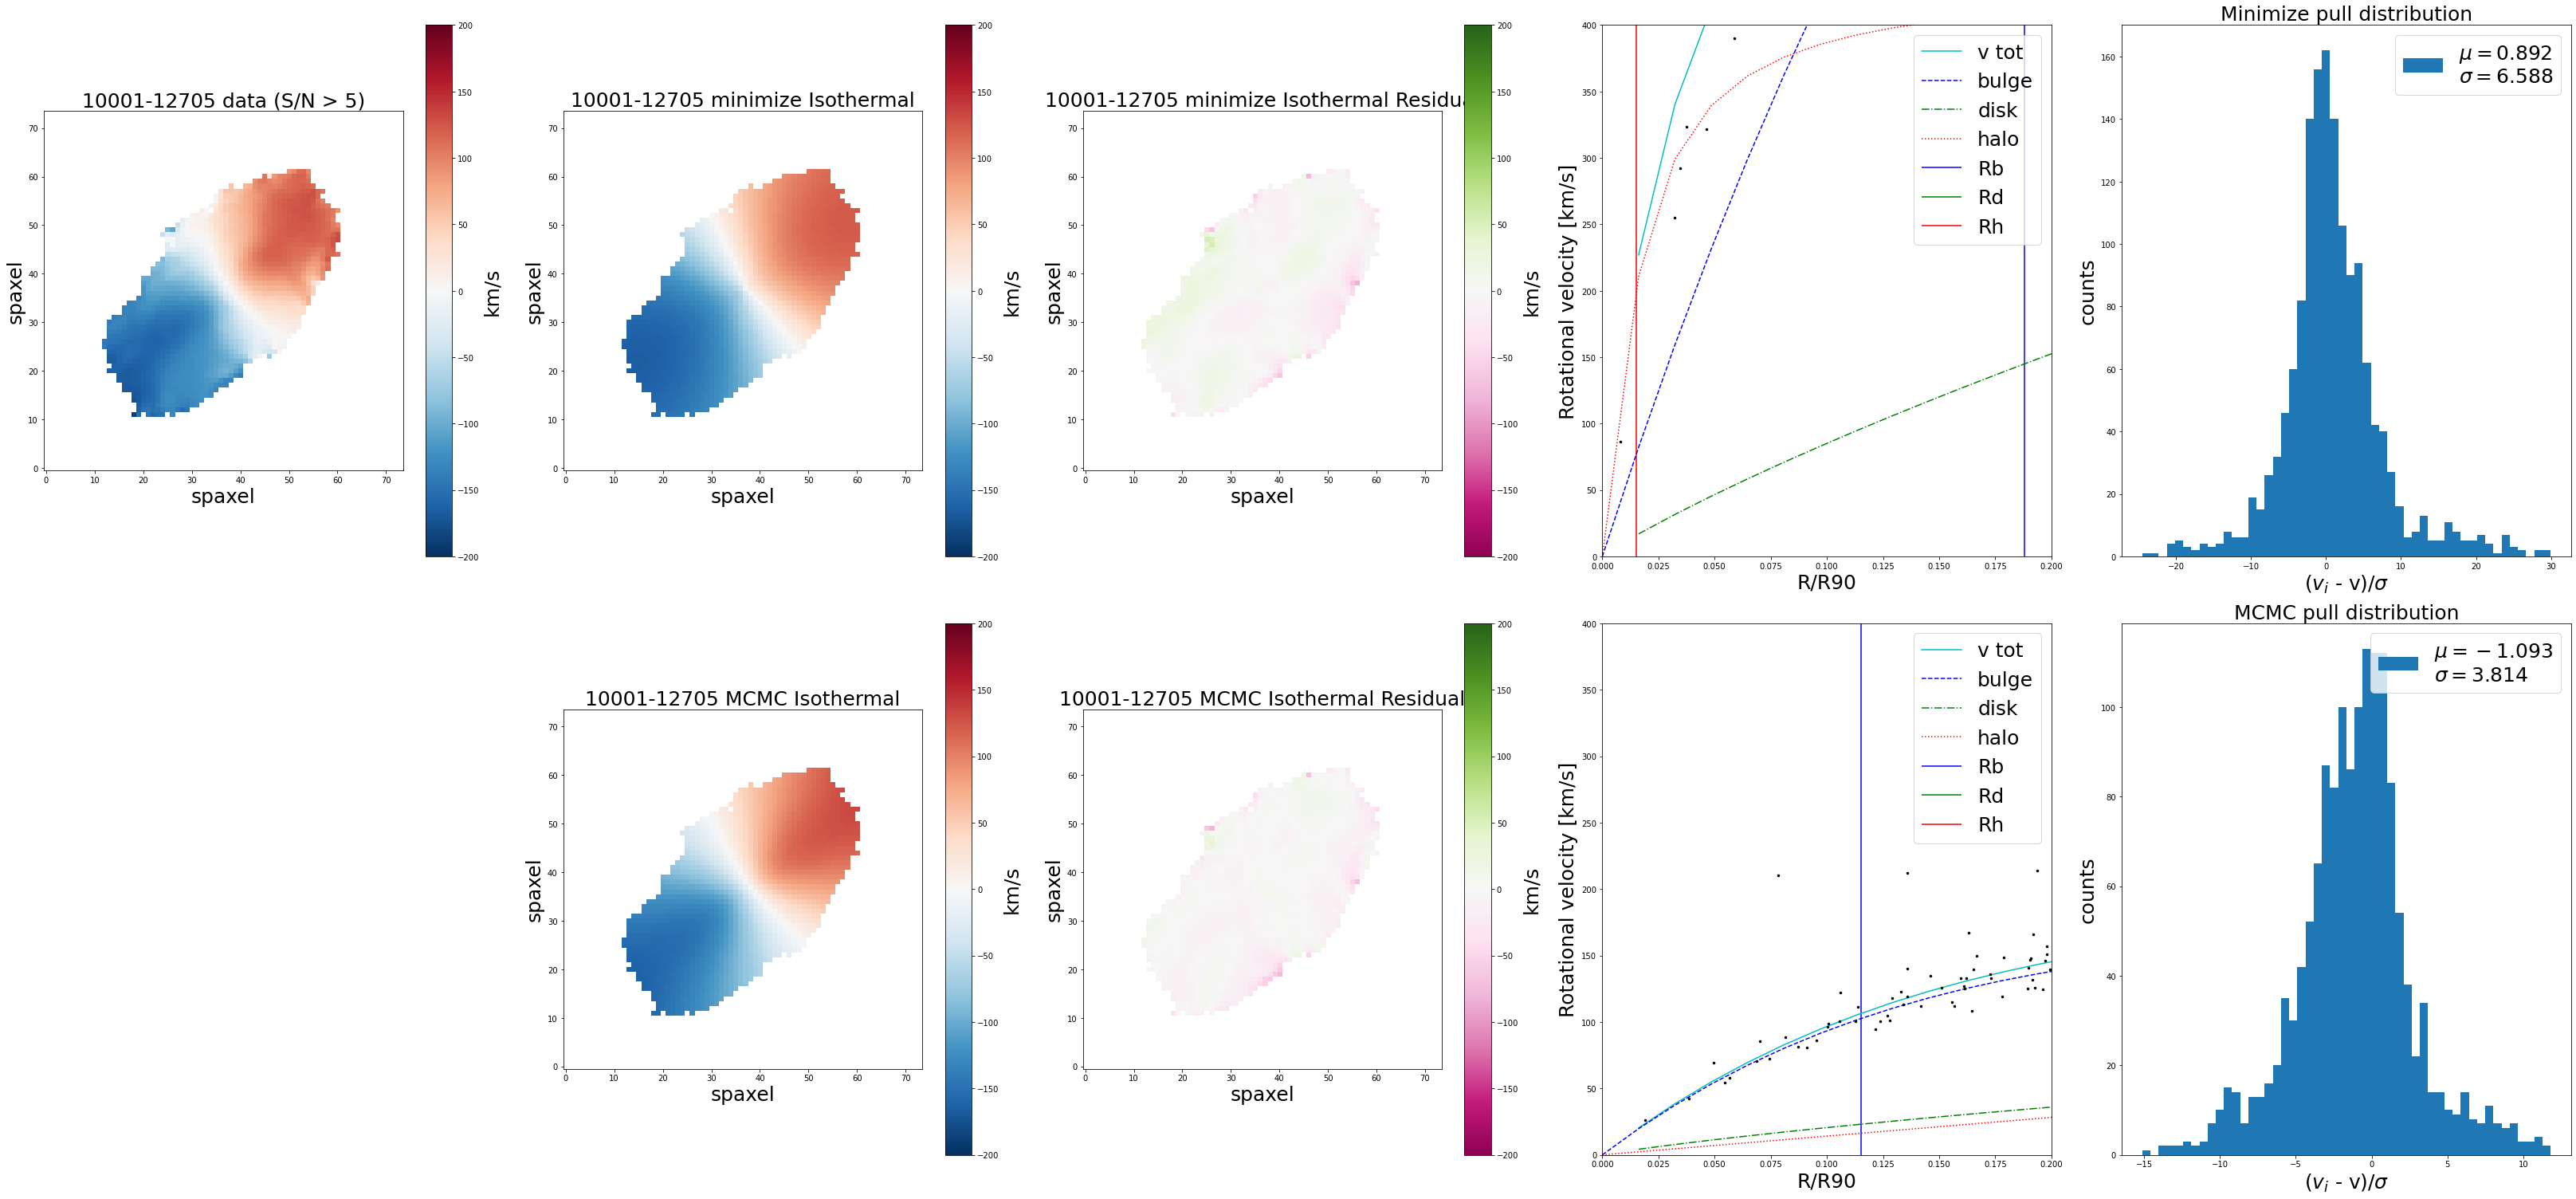

In [81]:
# Isothermal - 10001-12705

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12705, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12705 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12705 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12705 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12705 - mini_map_10001_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12705 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12705 - mcmc_map_10001_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12705 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12705/r90_10001_12705, v_mini_10001_12705, 'c',label='v tot')
plt.plot(r_mini_10001_12705/r90_10001_12705, v_b_mini_10001_12705, 'b--',label='bulge')
plt.plot(r_mini_10001_12705/r90_10001_12705, v_d_mini_10001_12705,'g-.',label='disk')
plt.plot(r_mini_10001_12705/r90_10001_12705, v_h_mini_10001_12705,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12705[1]/r90_10001_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12705[3]/r90_10001_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12705[5]/r90_10001_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12705/r90_10001_12705, vm_deproj_mini_10001_12705, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12705/r90_10001_12705, v_mcmc_10001_12705, 'c',label='v tot')
plt.plot(r_mcmc_10001_12705/r90_10001_12705, v_b_mcmc_10001_12705, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12705/r90_10001_12705, v_d_mcmc_10001_12705,'g-.',label='disk')
plt.plot(r_mcmc_10001_12705/r90_10001_12705, v_h_mcmc_10001_12705,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12705))

plt.vlines(x = mcmc_fit_10001_12705[1]/r90_10001_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12705[3]/r90_10001_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12705[5]/r90_10001_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12705/r90_10001_12705, vm_deproj_mcmc_10001_12705, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10001_12705 = dmap_10001_12705 - mini_map_10001_12705

dist_minimize_Isothermal_10001_12705 = residual_minimize_Isothermal_10001_12705*np.sqrt(ivar_masked_10001_12705)

residual_mcmc_Isothermal_10001_12705 = dmap_10001_12705 - mcmc_map_10001_12705

dist_mcmc_Isothermal_10001_12705 = residual_mcmc_Isothermal_10001_12705*np.sqrt(ivar_masked_10001_12705)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10001_12705 = ma.mean(dist_minimize_Isothermal_10001_12705)
sig_mini_Isothermal_10001_12705 = ma.std(dist_minimize_Isothermal_10001_12705)

n_mini_Isothermal_10001_12705, bins_mini_Isothermal_10001_12705, patches_mini_Isothermal_10001_12705 = plt.hist(dist_minimize_Isothermal_10001_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10001_12705, sig_mini_Isothermal_10001_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10001_12705 = ma.mean(dist_mcmc_Isothermal_10001_12705)
sig_mcmc_Isothermal_10001_12705 = ma.std(dist_mcmc_Isothermal_10001_12705)

n_mcmc_Isothermal_10001_12705, bins_mcmc_Isothermal_10001_12705, patches_mcmc_Isothermal_10001_12705 = plt.hist(dist_mcmc_Isothermal_10001_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10001_12705, sig_mcmc_Isothermal_10001_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12705))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12705))
print('r$R_{90}$: ' + str(r90_10001_12705) + ' kpc')
print('Incl from data: ' + str(incl_10001_12705))
print('Incl from Minimize: ' + str(mini_fit_10001_12705[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12705[-5]))

Minimize r$\chi^2$ : 10.946061251162368
MCMC r$\chi^2$ : 7.126602018472382
r$R_{90}$: 13.263102531433105 kpc
Incl from data: 0.32792060605412854
Incl from Minimize: 0.5463969621484556
Incl from MCMC: 0.6921960988619974


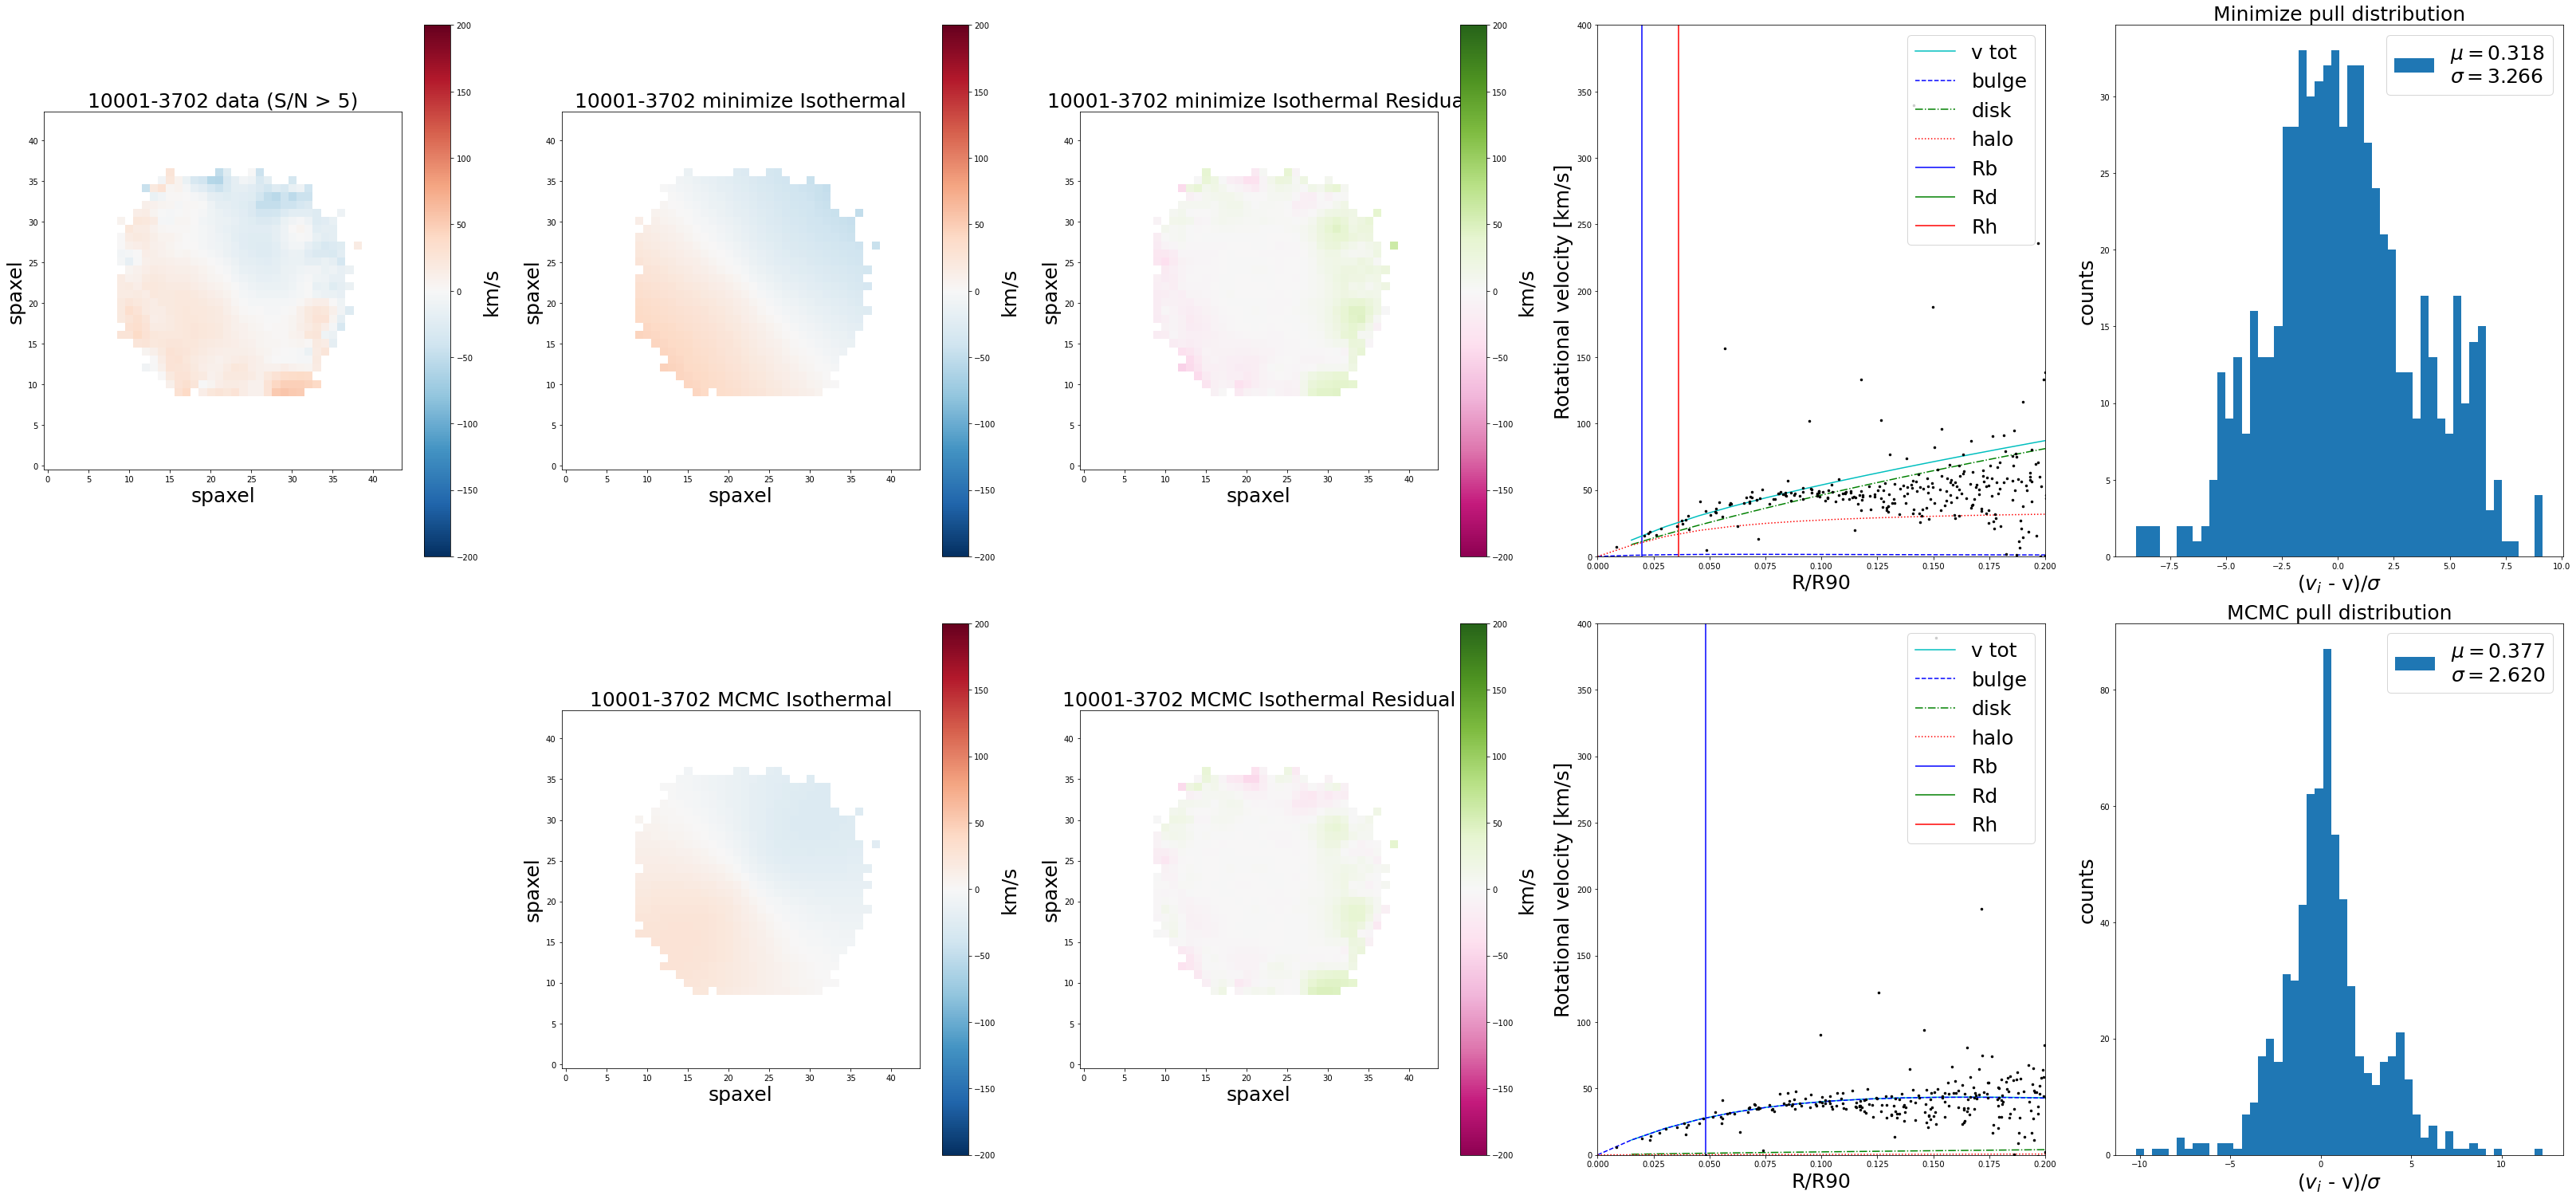

In [82]:
# Isothermal - 10001-3702

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_3702, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3702 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_3702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3702 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_3702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3702 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_3702 - mini_map_10001_3702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3702 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_3702 - mcmc_map_10001_3702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3702 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_3702/r90_10001_3702, v_mini_10001_3702, 'c',label='v tot')
plt.plot(r_mini_10001_3702/r90_10001_3702, v_b_mini_10001_3702, 'b--',label='bulge')
plt.plot(r_mini_10001_3702/r90_10001_3702, v_d_mini_10001_3702,'g-.',label='disk')
plt.plot(r_mini_10001_3702/r90_10001_3702, v_h_mini_10001_3702,'r:',label='halo')

plt.vlines(x = mini_fit_10001_3702[1]/r90_10001_3702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_3702[3]/r90_10001_3702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_3702[5]/r90_10001_3702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_3702/r90_10001_3702, vm_deproj_mini_10001_3702, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_3702/r90_10001_3702, v_mcmc_10001_3702, 'c',label='v tot')
plt.plot(r_mcmc_10001_3702/r90_10001_3702, v_b_mcmc_10001_3702, 'b--',label='bulge')
plt.plot(r_mcmc_10001_3702/r90_10001_3702, v_d_mcmc_10001_3702,'g-.',label='disk')
plt.plot(r_mcmc_10001_3702/r90_10001_3702, v_h_mcmc_10001_3702,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_3702))

plt.vlines(x = mcmc_fit_10001_3702[1]/r90_10001_3702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_3702[3]/r90_10001_3702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_3702[5]/r90_10001_3702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_3702/r90_10001_3702, vm_deproj_mcmc_10001_3702, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10001_3702 = dmap_10001_3702 - mini_map_10001_3702

dist_minimize_Isothermal_10001_3702 = residual_minimize_Isothermal_10001_3702*np.sqrt(ivar_masked_10001_3702)

residual_mcmc_Isothermal_10001_3702 = dmap_10001_3702 - mcmc_map_10001_3702

dist_mcmc_Isothermal_10001_3702 = residual_mcmc_Isothermal_10001_3702*np.sqrt(ivar_masked_10001_3702)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10001_3702 = ma.mean(dist_minimize_Isothermal_10001_3702)
sig_mini_Isothermal_10001_3702 = ma.std(dist_minimize_Isothermal_10001_3702)

n_mini_Isothermal_10001_3702, bins_mini_Isothermal_10001_3702, patches_mini_Isothermal_10001_3702 = plt.hist(dist_minimize_Isothermal_10001_3702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10001_3702, sig_mini_Isothermal_10001_3702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10001_3702 = ma.mean(dist_mcmc_Isothermal_10001_3702)
sig_mcmc_Isothermal_10001_3702 = ma.std(dist_mcmc_Isothermal_10001_3702)

n_mcmc_Isothermal_10001_3702, bins_mcmc_Isothermal_10001_3702, patches_mcmc_Isothermal_10001_3702 = plt.hist(dist_mcmc_Isothermal_10001_3702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10001_3702, sig_mcmc_Isothermal_10001_3702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_3702))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_3702))
print('r$R_{90}$: ' + str(r90_10001_3702) + ' kpc')
print('Incl from data: ' + str(incl_10001_3702))
print('Incl from Minimize: ' + str(mini_fit_10001_3702[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_3702[-5]))

Minimize r$\chi^2$ : 85.79243466149134
MCMC r$\chi^2$ : 24.705460323745623
r$R_{90}$: 6.644127368927002 kpc
Incl from data: 0.9413034573926715
Incl from Minimize: 0.1006554619668365
Incl from MCMC: 0.7105408076194555


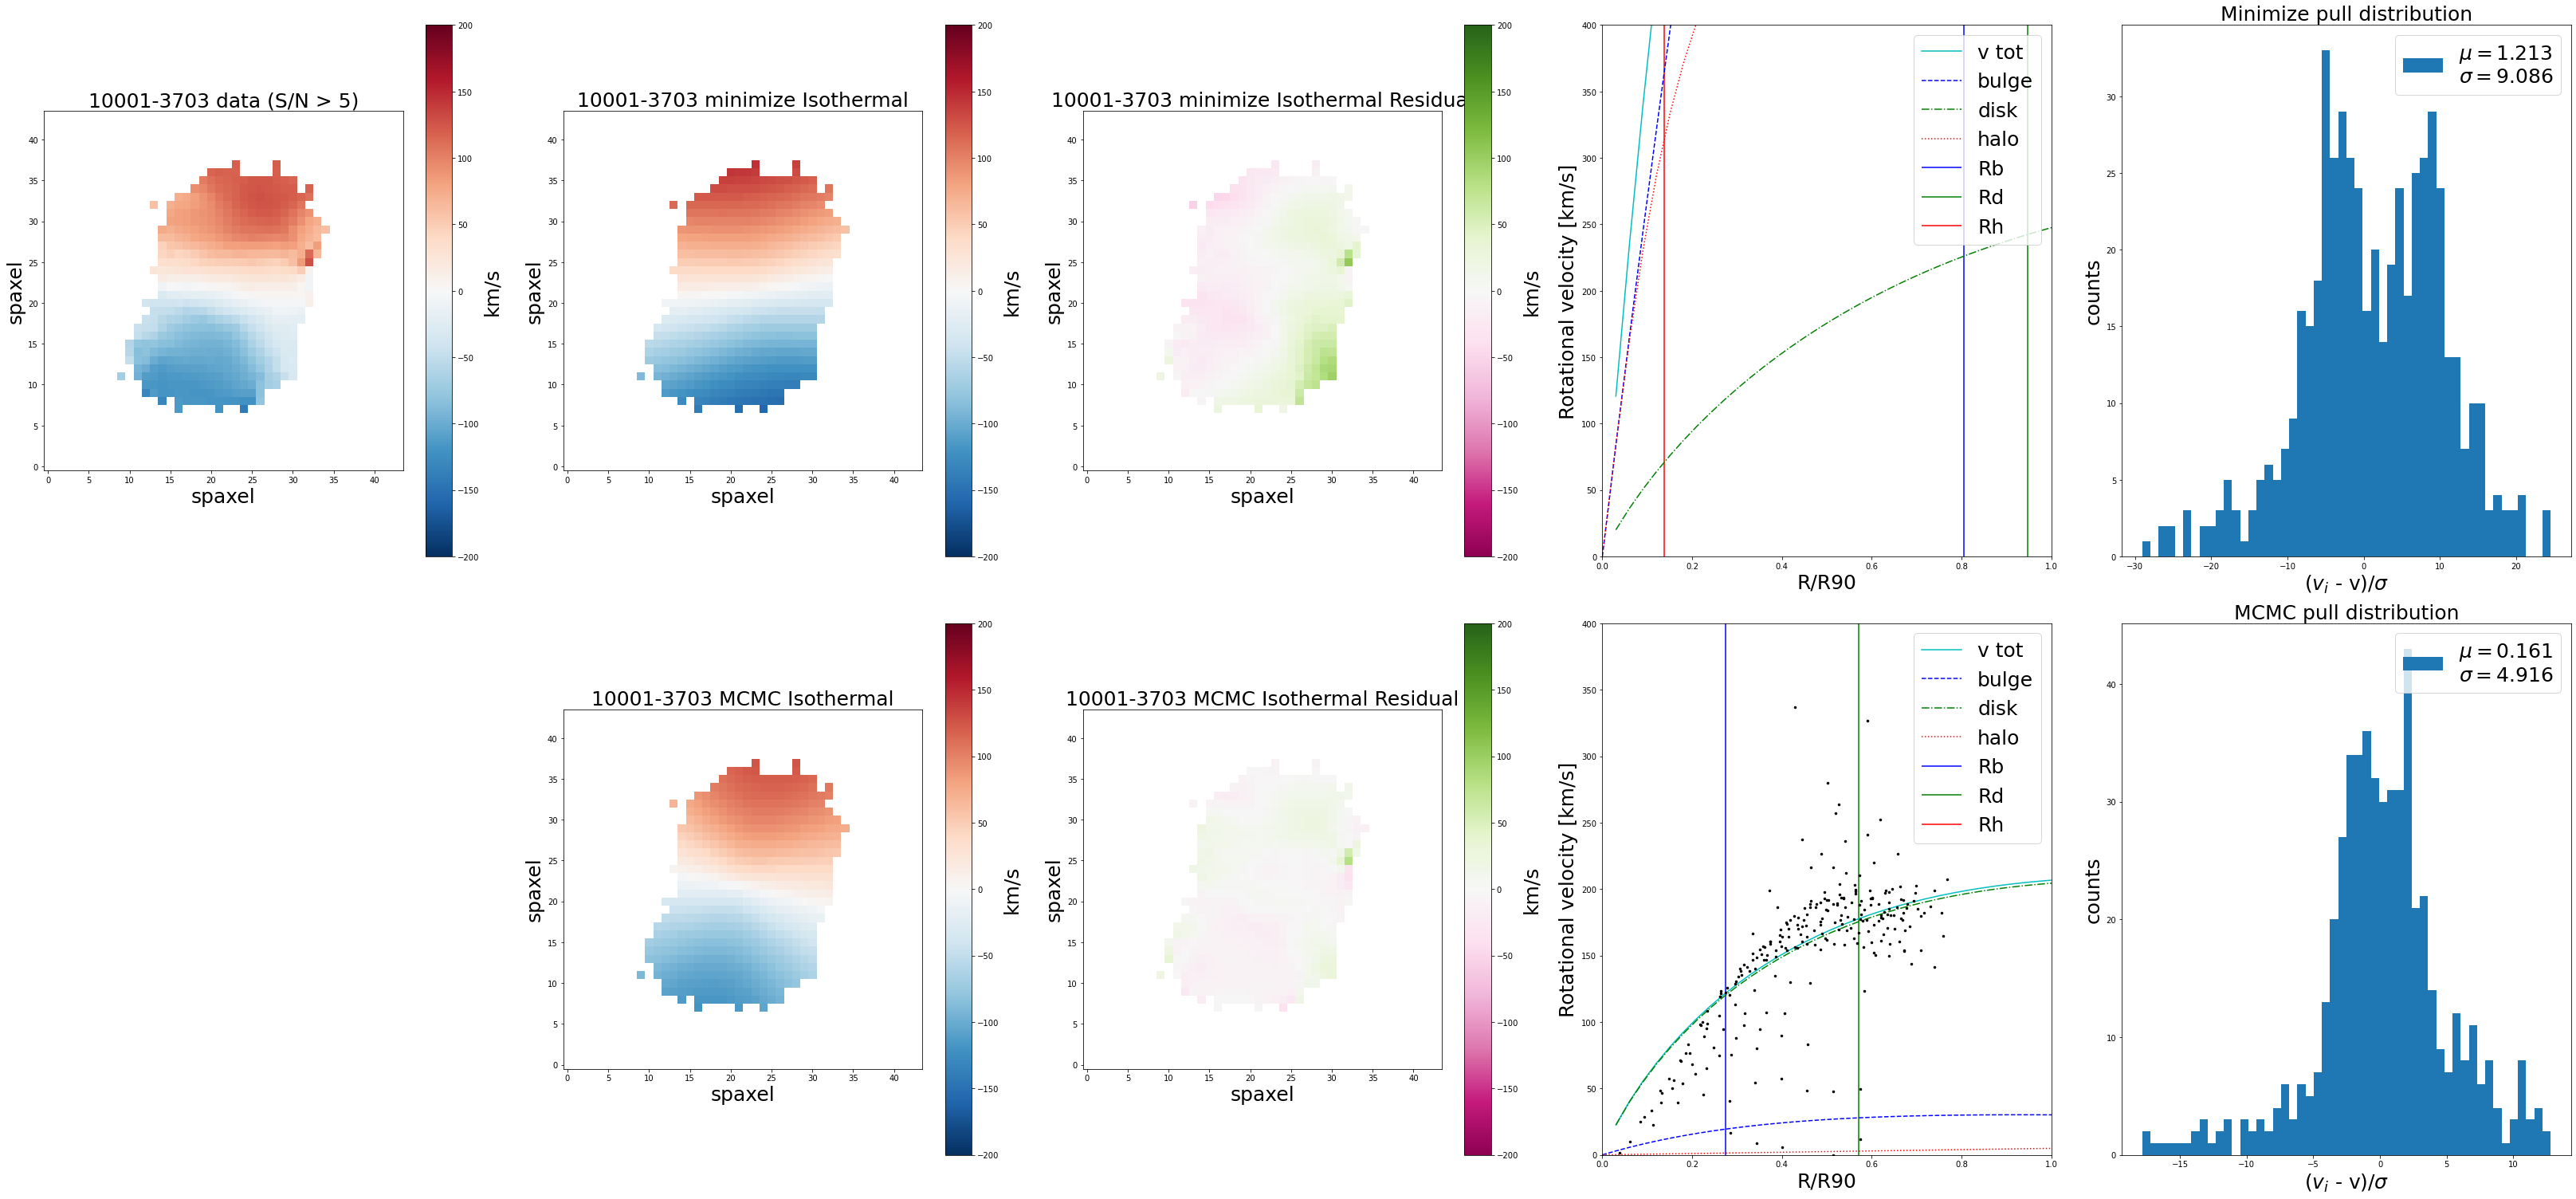

In [84]:
# Isothermal - 10001-3703

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_3703, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3703 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_3703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3703 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_3703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3703 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_3703 - mini_map_10001_3703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3703 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_3703 - mcmc_map_10001_3703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-3703 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_3703/r90_10001_3703, v_mini_10001_3703, 'c',label='v tot')
plt.plot(r_mini_10001_3703/r90_10001_3703, v_b_mini_10001_3703, 'b--',label='bulge')
plt.plot(r_mini_10001_3703/r90_10001_3703, v_d_mini_10001_3703,'g-.',label='disk')
plt.plot(r_mini_10001_3703/r90_10001_3703, v_h_mini_10001_3703,'r:',label='halo')

plt.vlines(x = mini_fit_10001_3703[1]/r90_10001_3703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_3703[3]/r90_10001_3703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_3703[5]/r90_10001_3703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_3703/r90_10001_3703, vm_deproj_mini_10001_3703, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_3703/r90_10001_3703, v_mcmc_10001_3703, 'c',label='v tot')
plt.plot(r_mcmc_10001_3703/r90_10001_3703, v_b_mcmc_10001_3703, 'b--',label='bulge')
plt.plot(r_mcmc_10001_3703/r90_10001_3703, v_d_mcmc_10001_3703,'g-.',label='disk')
plt.plot(r_mcmc_10001_3703/r90_10001_3703, v_h_mcmc_10001_3703,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_3703))

plt.vlines(x = mcmc_fit_10001_3703[1]/r90_10001_3703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_3703[3]/r90_10001_3703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_3703[5]/r90_10001_3703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_3703/r90_10001_3703, vm_deproj_mcmc_10001_3703, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10001_3703 = dmap_10001_3703 - mini_map_10001_3703

dist_minimize_Isothermal_10001_3703 = residual_minimize_Isothermal_10001_3703*np.sqrt(ivar_masked_10001_3703)

residual_mcmc_Isothermal_10001_3703 = dmap_10001_3703 - mcmc_map_10001_3703

dist_mcmc_Isothermal_10001_3703 = residual_mcmc_Isothermal_10001_3703*np.sqrt(ivar_masked_10001_3703)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10001_3703 = ma.mean(dist_minimize_Isothermal_10001_3703)
sig_mini_Isothermal_10001_3703 = ma.std(dist_minimize_Isothermal_10001_3703)

n_mini_Isothermal_10001_3703, bins_mini_Isothermal_10001_3703, patches_mini_Isothermal_10001_3703 = plt.hist(dist_minimize_Isothermal_10001_3703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10001_3703, sig_mini_Isothermal_10001_3703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10001_3703 = ma.mean(dist_mcmc_Isothermal_10001_3703)
sig_mcmc_Isothermal_10001_3703 = ma.std(dist_mcmc_Isothermal_10001_3703)

n_mcmc_Isothermal_10001_3703, bins_mcmc_Isothermal_10001_3703, patches_mcmc_Isothermal_10001_3703 = plt.hist(dist_mcmc_Isothermal_10001_3703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10001_3703, sig_mcmc_Isothermal_10001_3703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_3703))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_3703))
print('r$R_{90}$: ' + str(r90_10001_3703) + ' kpc')
print('Incl from data: ' + str(incl_10001_3703))
print('Incl from Minimize: ' + str(mini_fit_10001_3703[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_3703[-5]))

Minimize r$\chi^2$ : 20.426713528207365
MCMC r$\chi^2$ : 7.994317520672989
r$R_{90}$: 12.861767768859863 kpc
Incl from data: 1.088132442144162
Incl from Minimize: 0.5342563434557018
Incl from MCMC: 0.7918139035003777


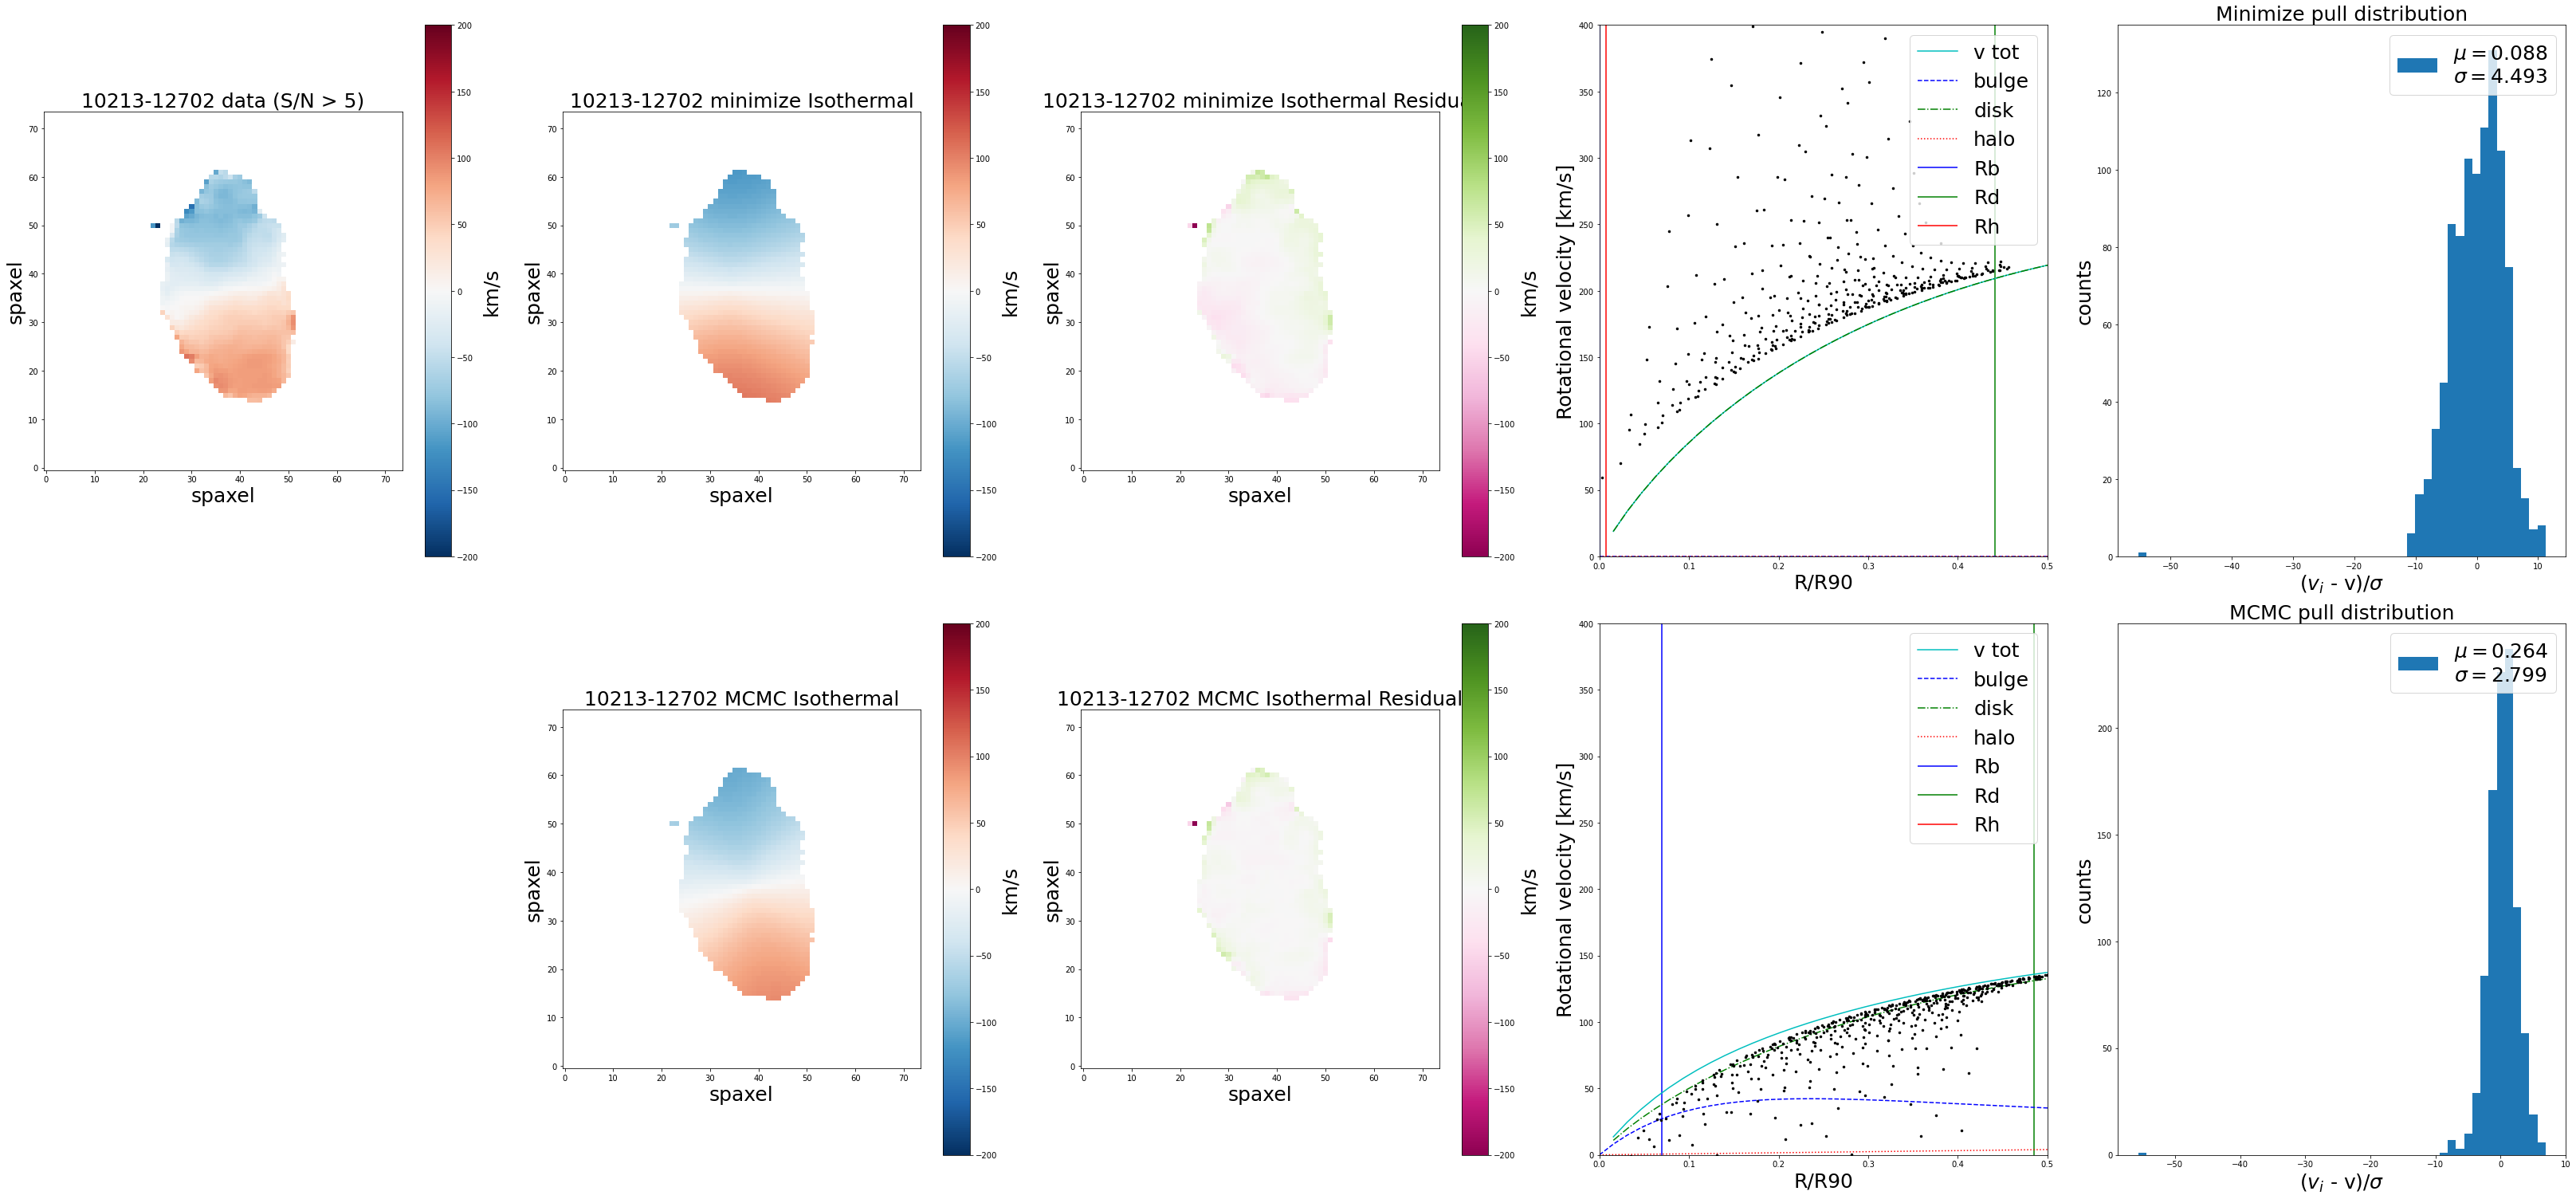

In [86]:
# Isothermal - 10213-12702

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_12702, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12702 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12702 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12702 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_12702 - mini_map_10213_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12702 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_12702 - mcmc_map_10213_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12702 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_12702/r90_10213_12702, v_mini_10213_12702, 'c',label='v tot')
plt.plot(r_mini_10213_12702/r90_10213_12702, v_b_mini_10213_12702, 'b--',label='bulge')
plt.plot(r_mini_10213_12702/r90_10213_12702, v_d_mini_10213_12702,'g-.',label='disk')
plt.plot(r_mini_10213_12702/r90_10213_12702, v_h_mini_10213_12702,'r:',label='halo')

plt.vlines(x = mini_fit_10213_12702[1]/r90_10213_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_12702[3]/r90_10213_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_12702[5]/r90_10213_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_12702/r90_10213_12702, vm_deproj_mini_10213_12702, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_12702/r90_10213_12702, v_mcmc_10213_12702, 'c',label='v tot')
plt.plot(r_mcmc_10213_12702/r90_10213_12702, v_b_mcmc_10213_12702, 'b--',label='bulge')
plt.plot(r_mcmc_10213_12702/r90_10213_12702, v_d_mcmc_10213_12702,'g-.',label='disk')
plt.plot(r_mcmc_10213_12702/r90_10213_12702, v_h_mcmc_10213_12702,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_12702))

plt.vlines(x = mcmc_fit_10213_12702[1]/r90_10213_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_12702[3]/r90_10213_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_12702[5]/r90_10213_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_12702/r90_10213_12702, vm_deproj_mcmc_10213_12702, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10213_12702 = dmap_10213_12702 - mini_map_10213_12702

dist_minimize_Isothermal_10213_12702 = residual_minimize_Isothermal_10213_12702*np.sqrt(ivar_masked_10213_12702)

residual_mcmc_Isothermal_10213_12702 = dmap_10213_12702 - mcmc_map_10213_12702

dist_mcmc_Isothermal_10213_12702 = residual_mcmc_Isothermal_10213_12702*np.sqrt(ivar_masked_10213_12702)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10213_12702 = ma.mean(dist_minimize_Isothermal_10213_12702)
sig_mini_Isothermal_10213_12702 = ma.std(dist_minimize_Isothermal_10213_12702)

n_mini_Isothermal_10213_12702, bins_mini_Isothermal_10213_12702, patches_mini_Isothermal_10213_12702 = plt.hist(dist_minimize_Isothermal_10213_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10213_12702, sig_mini_Isothermal_10213_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10213_12702 = ma.mean(dist_mcmc_Isothermal_10213_12702)
sig_mcmc_Isothermal_10213_12702 = ma.std(dist_mcmc_Isothermal_10213_12702)

n_mcmc_Isothermal_10213_12702, bins_mcmc_Isothermal_10213_12702, patches_mcmc_Isothermal_10213_12702 = plt.hist(dist_mcmc_Isothermal_10213_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10213_12702, sig_mcmc_Isothermal_10213_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_12702))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_12702))
print('r$R_{90}$: ' + str(r90_10213_12702) + ' kpc')
print('Incl from data: ' + str(incl_10213_12702))
print('Incl from Minimize: ' + str(mini_fit_10213_12702[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_12702[-5]))

Minimize r$\chi^2$ : 34.01136626275301
MCMC r$\chi^2$ : 287.778154463728
r$R_{90}$: 9.852487564086914 kpc
Incl from data: 1.188050654078803
Incl from Minimize: 0.36752984402838174
Incl from MCMC: 0.3101183830389658


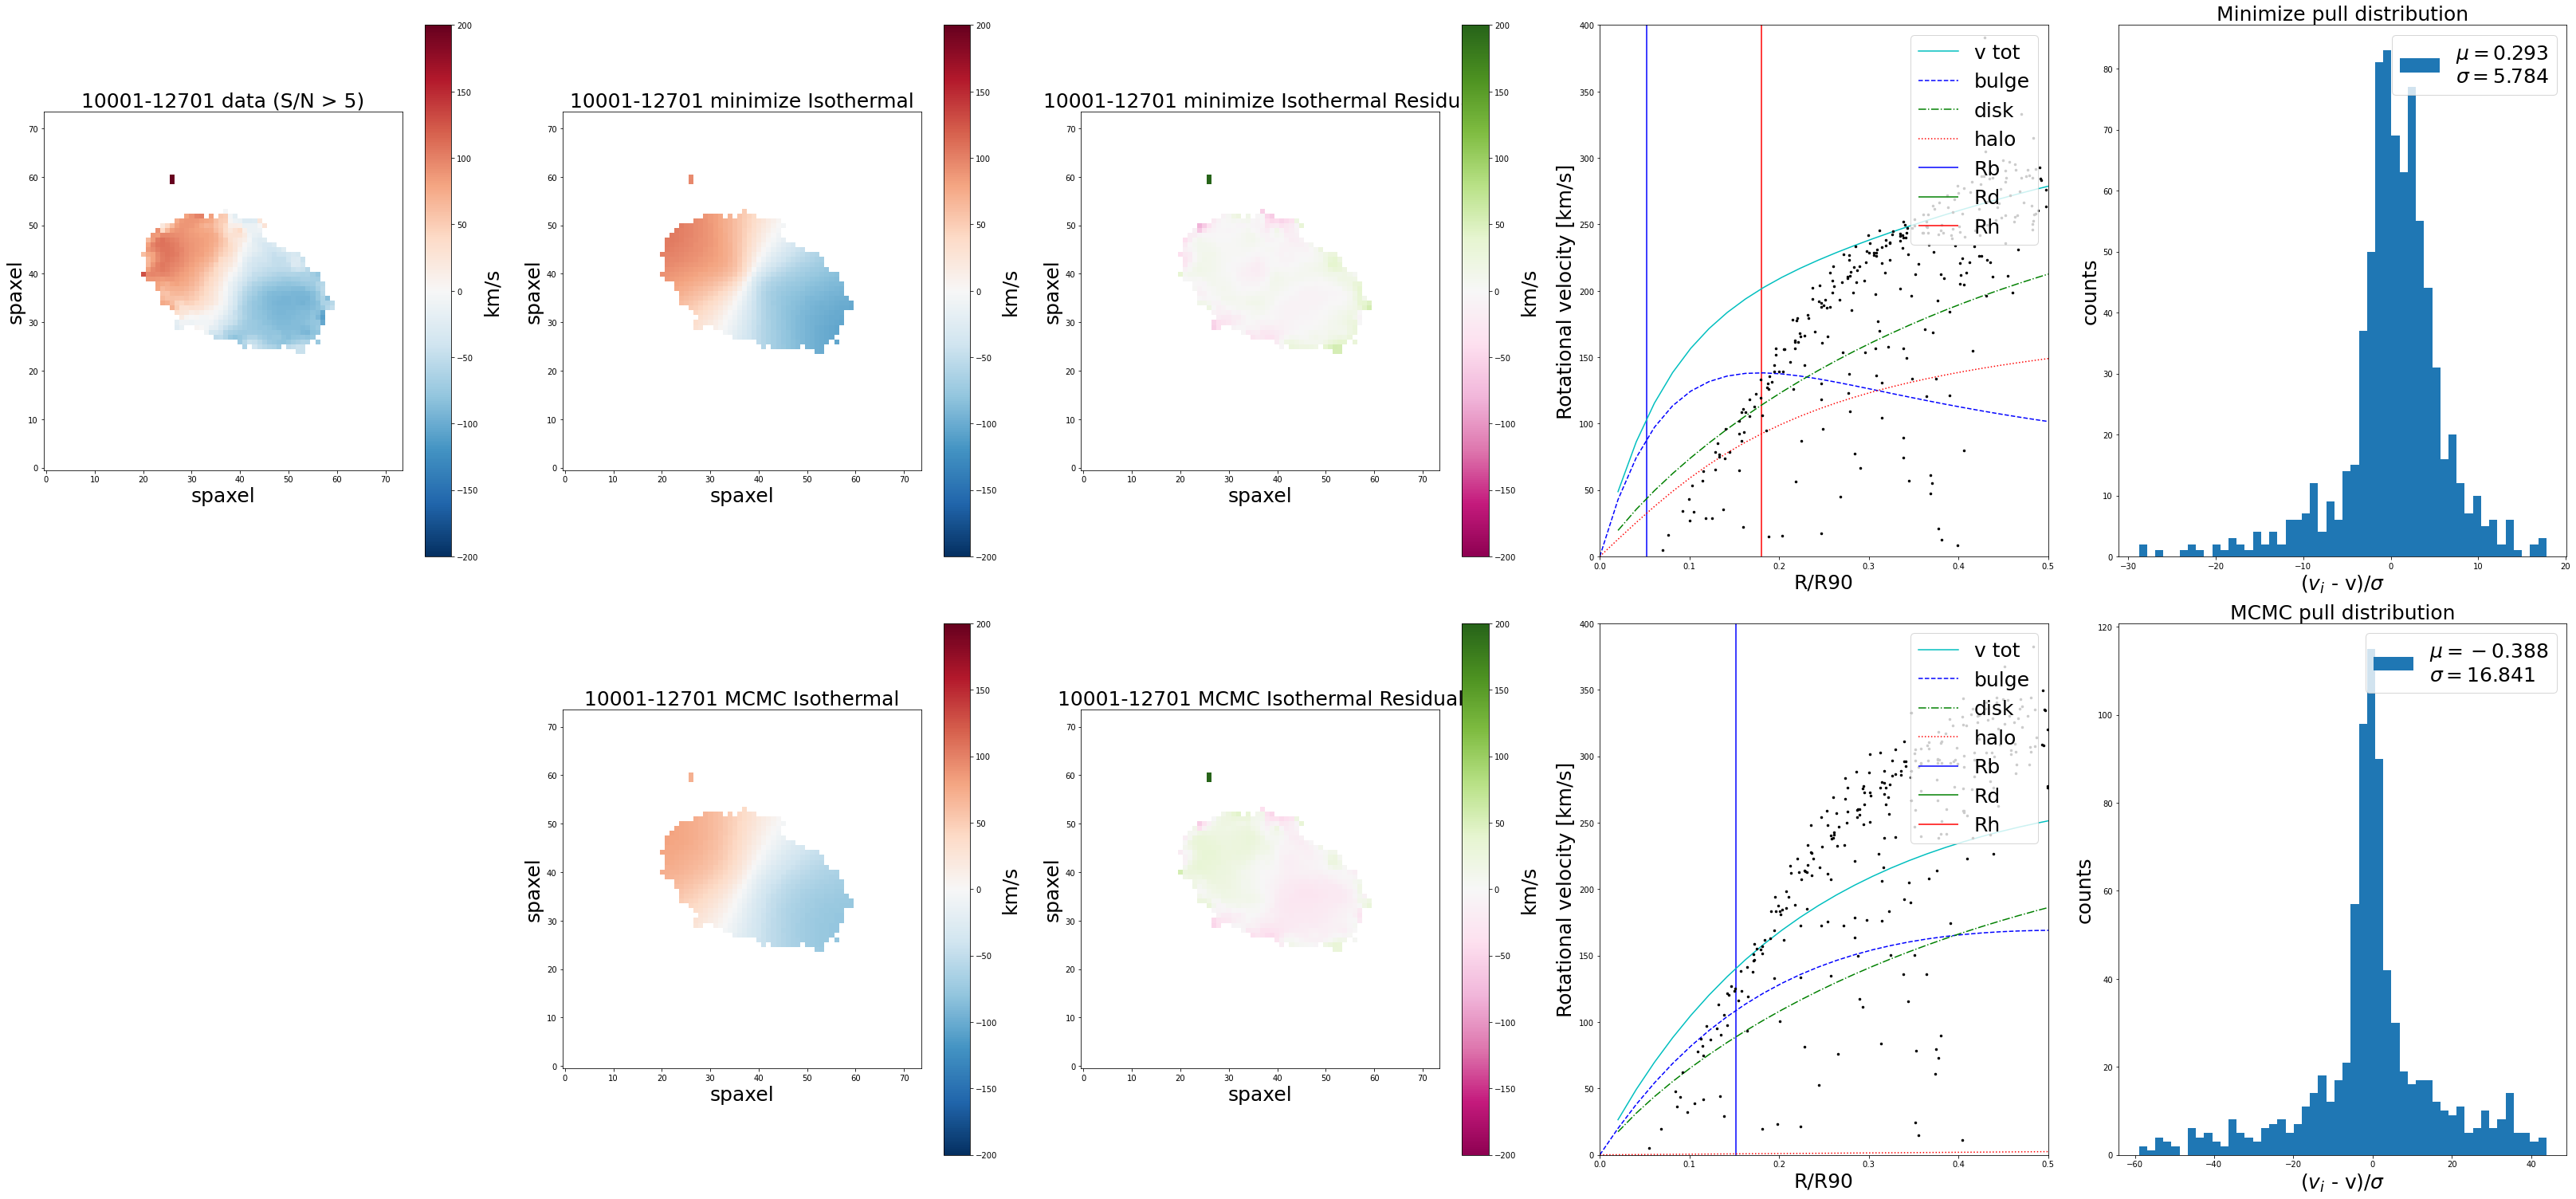

In [88]:
# Isothermal - 10001-12701

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12701, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12701 - mini_map_10001_12701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12701 - mcmc_map_10001_12701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12701/r90_10001_12701, v_mini_10001_12701, 'c',label='v tot')
plt.plot(r_mini_10001_12701/r90_10001_12701, v_b_mini_10001_12701, 'b--',label='bulge')
plt.plot(r_mini_10001_12701/r90_10001_12701, v_d_mini_10001_12701,'g-.',label='disk')
plt.plot(r_mini_10001_12701/r90_10001_12701, v_h_mini_10001_12701,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12701[1]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12701[3]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12701[5]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12701/r90_10001_12701, vm_deproj_mini_10001_12701, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_mcmc_10001_12701, 'c',label='v tot')
plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_b_mcmc_10001_12701, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_d_mcmc_10001_12701,'g-.',label='disk')
plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_h_mcmc_10001_12701,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12701))

plt.vlines(x = mcmc_fit_10001_12701[1]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12701[3]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12701[5]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12701/r90_10001_12701, vm_deproj_mcmc_10001_12701, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10001_12701 = dmap_10001_12701 - mini_map_10001_12701

dist_minimize_Isothermal_10001_12701 = residual_minimize_Isothermal_10001_12701*np.sqrt(ivar_masked_10001_12701)

residual_mcmc_Isothermal_10001_12701 = dmap_10001_12701 - mcmc_map_10001_12701

dist_mcmc_Isothermal_10001_12701 = residual_mcmc_Isothermal_10001_12701*np.sqrt(ivar_masked_10001_12701)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10001_12701 = ma.mean(dist_minimize_Isothermal_10001_12701)
sig_mini_Isothermal_10001_12701 = ma.std(dist_minimize_Isothermal_10001_12701)

n_mini_Isothermal_10001_12701, bins_mini_Isothermal_10001_12701, patches_mini_Isothermal_10001_12701 = plt.hist(dist_minimize_Isothermal_10001_12701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10001_12701, sig_mini_Isothermal_10001_12701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10001_12701 = ma.mean(dist_mcmc_Isothermal_10001_12701)
sig_mcmc_Isothermal_10001_12701 = ma.std(dist_mcmc_Isothermal_10001_12701)

n_mcmc_Isothermal_10001_12701, bins_mcmc_Isothermal_10001_12701, patches_mcmc_Isothermal_10001_12701 = plt.hist(dist_mcmc_Isothermal_10001_12701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10001_12701, sig_mcmc_Isothermal_10001_12701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12701))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12701))
print('r$R_{90}$: ' + str(r90_10001_12701) + ' kpc')
print('Incl from data: ' + str(incl_10001_12701))
print('Incl from Minimize: ' + str(mini_fit_10001_12701[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12701[-5]))

Minimize r$\chi^2$ : 37.29586616893832
MCMC r$\chi^2$ : 185.45450210057334
r$R_{90}$: 24.491958618164062 kpc
Incl from data: 0.8376916908679872
Incl from Minimize: 0.10894108242934103
Incl from MCMC: 1.3366772023935984


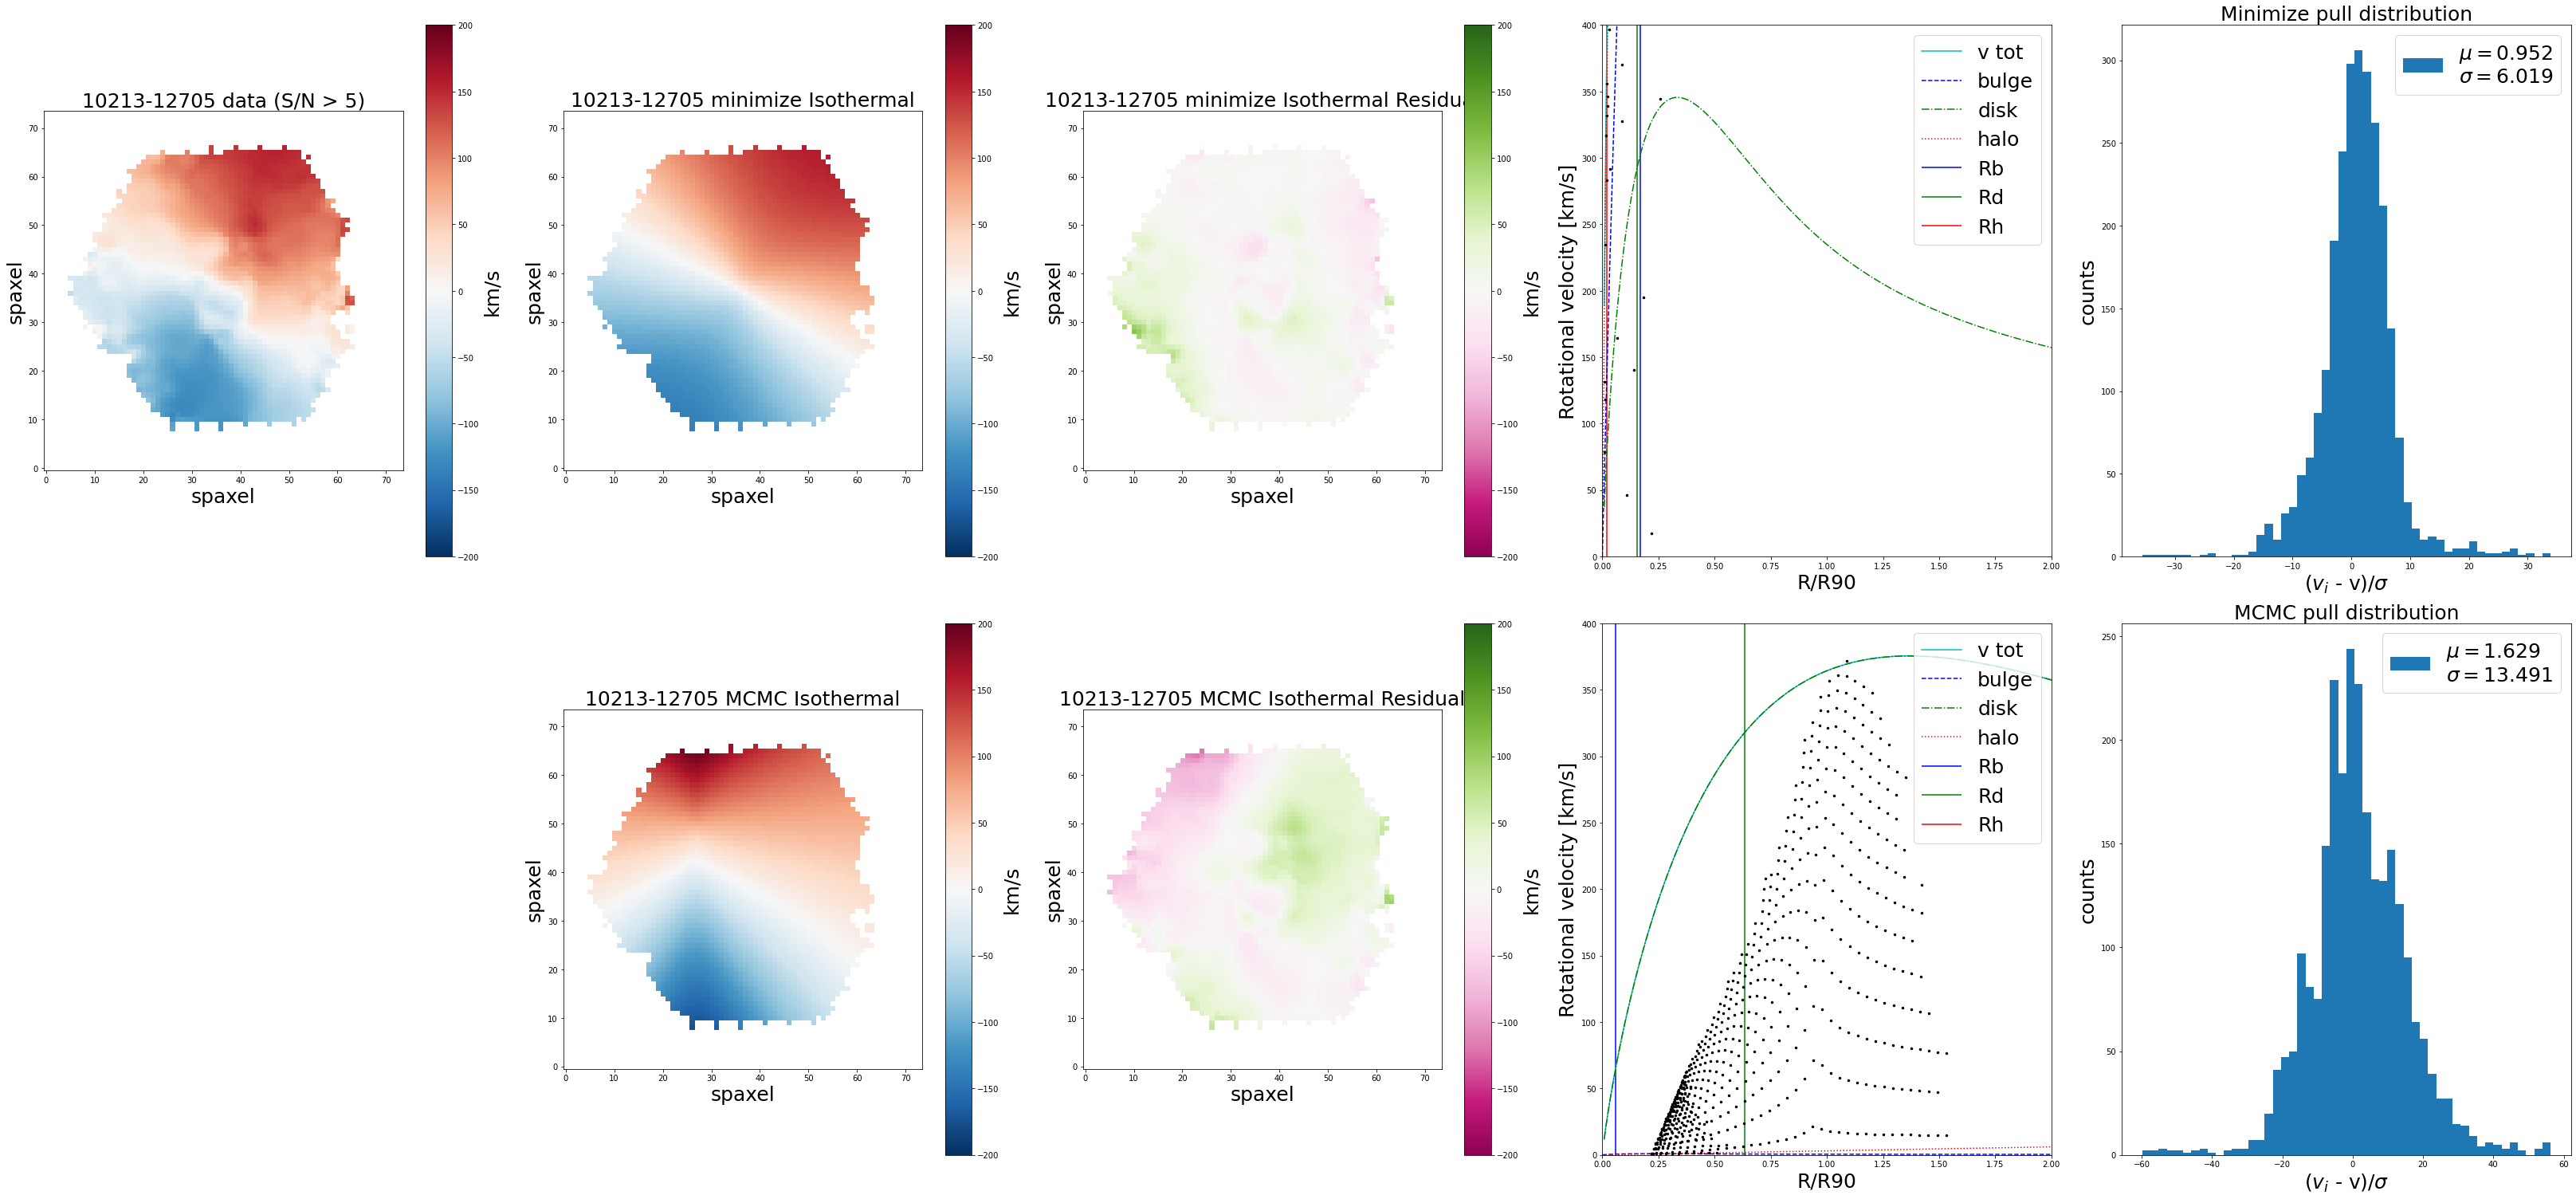

In [90]:
# Isothermal - 10213-12705

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_12705, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_12705 - mini_map_10213_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_12705 - mcmc_map_10213_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_12705/r90_10213_12705, v_mini_10213_12705, 'c',label='v tot')
plt.plot(r_mini_10213_12705/r90_10213_12705, v_b_mini_10213_12705, 'b--',label='bulge')
plt.plot(r_mini_10213_12705/r90_10213_12705, v_d_mini_10213_12705,'g-.',label='disk')
plt.plot(r_mini_10213_12705/r90_10213_12705, v_h_mini_10213_12705,'r:',label='halo')

plt.vlines(x = mini_fit_10213_12705[1]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_12705[3]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_12705[5]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_12705/r90_10213_12705, vm_deproj_mini_10213_12705, 'k.', markersize=5)

plt.xlim([0,2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_mcmc_10213_12705, 'c',label='v tot')
plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_b_mcmc_10213_12705, 'b--',label='bulge')
plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_d_mcmc_10213_12705,'g-.',label='disk')
plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_h_mcmc_10213_12705,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_12705))

plt.vlines(x = mcmc_fit_10213_12705[1]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_12705[3]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_12705[5]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_12705/r90_10213_12705, vm_deproj_mcmc_10213_12705, 'k.', markersize=5)

plt.xlim([0,2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10213_12705 = dmap_10213_12705 - mini_map_10213_12705

dist_minimize_Isothermal_10213_12705 = residual_minimize_Isothermal_10213_12705*np.sqrt(ivar_masked_10213_12705)

residual_mcmc_Isothermal_10213_12705 = dmap_10213_12705 - mcmc_map_10213_12705

dist_mcmc_Isothermal_10213_12705 = residual_mcmc_Isothermal_10213_12705*np.sqrt(ivar_masked_10213_12705)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10213_12705 = ma.mean(dist_minimize_Isothermal_10213_12705)
sig_mini_Isothermal_10213_12705 = ma.std(dist_minimize_Isothermal_10213_12705)

n_mini_Isothermal_10213_12705, bins_mini_Isothermal_10213_12705, patches_mini_Isothermal_10213_12705 = plt.hist(dist_minimize_Isothermal_10213_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10213_12705, sig_mini_Isothermal_10213_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10213_12705 = ma.mean(dist_mcmc_Isothermal_10213_12705)
sig_mcmc_Isothermal_10213_12705 = ma.std(dist_mcmc_Isothermal_10213_12705)

n_mcmc_Isothermal_10213_12705, bins_mcmc_Isothermal_10213_12705, patches_mcmc_Isothermal_10213_12705 = plt.hist(dist_mcmc_Isothermal_10213_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10213_12705, sig_mcmc_Isothermal_10213_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_12705))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_12705))
print('r$R_{90}$: ' + str(r90_10213_12705) + ' kpc')
print('Incl from data: ' + str(incl_10213_12705))
print('Incl from Minimize: ' + str(mini_fit_10213_12705[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_12705[-5]))

Minimize r$\chi^2$ : 25.788927182569
MCMC r$\chi^2$ : 219.10523784572325
r$R_{90}$: 10.562400817871094 kpc
Incl from data: 0.6471020376352496
Incl from Minimize: 0.42443659998207617
Incl from MCMC: 0.7020839674415053


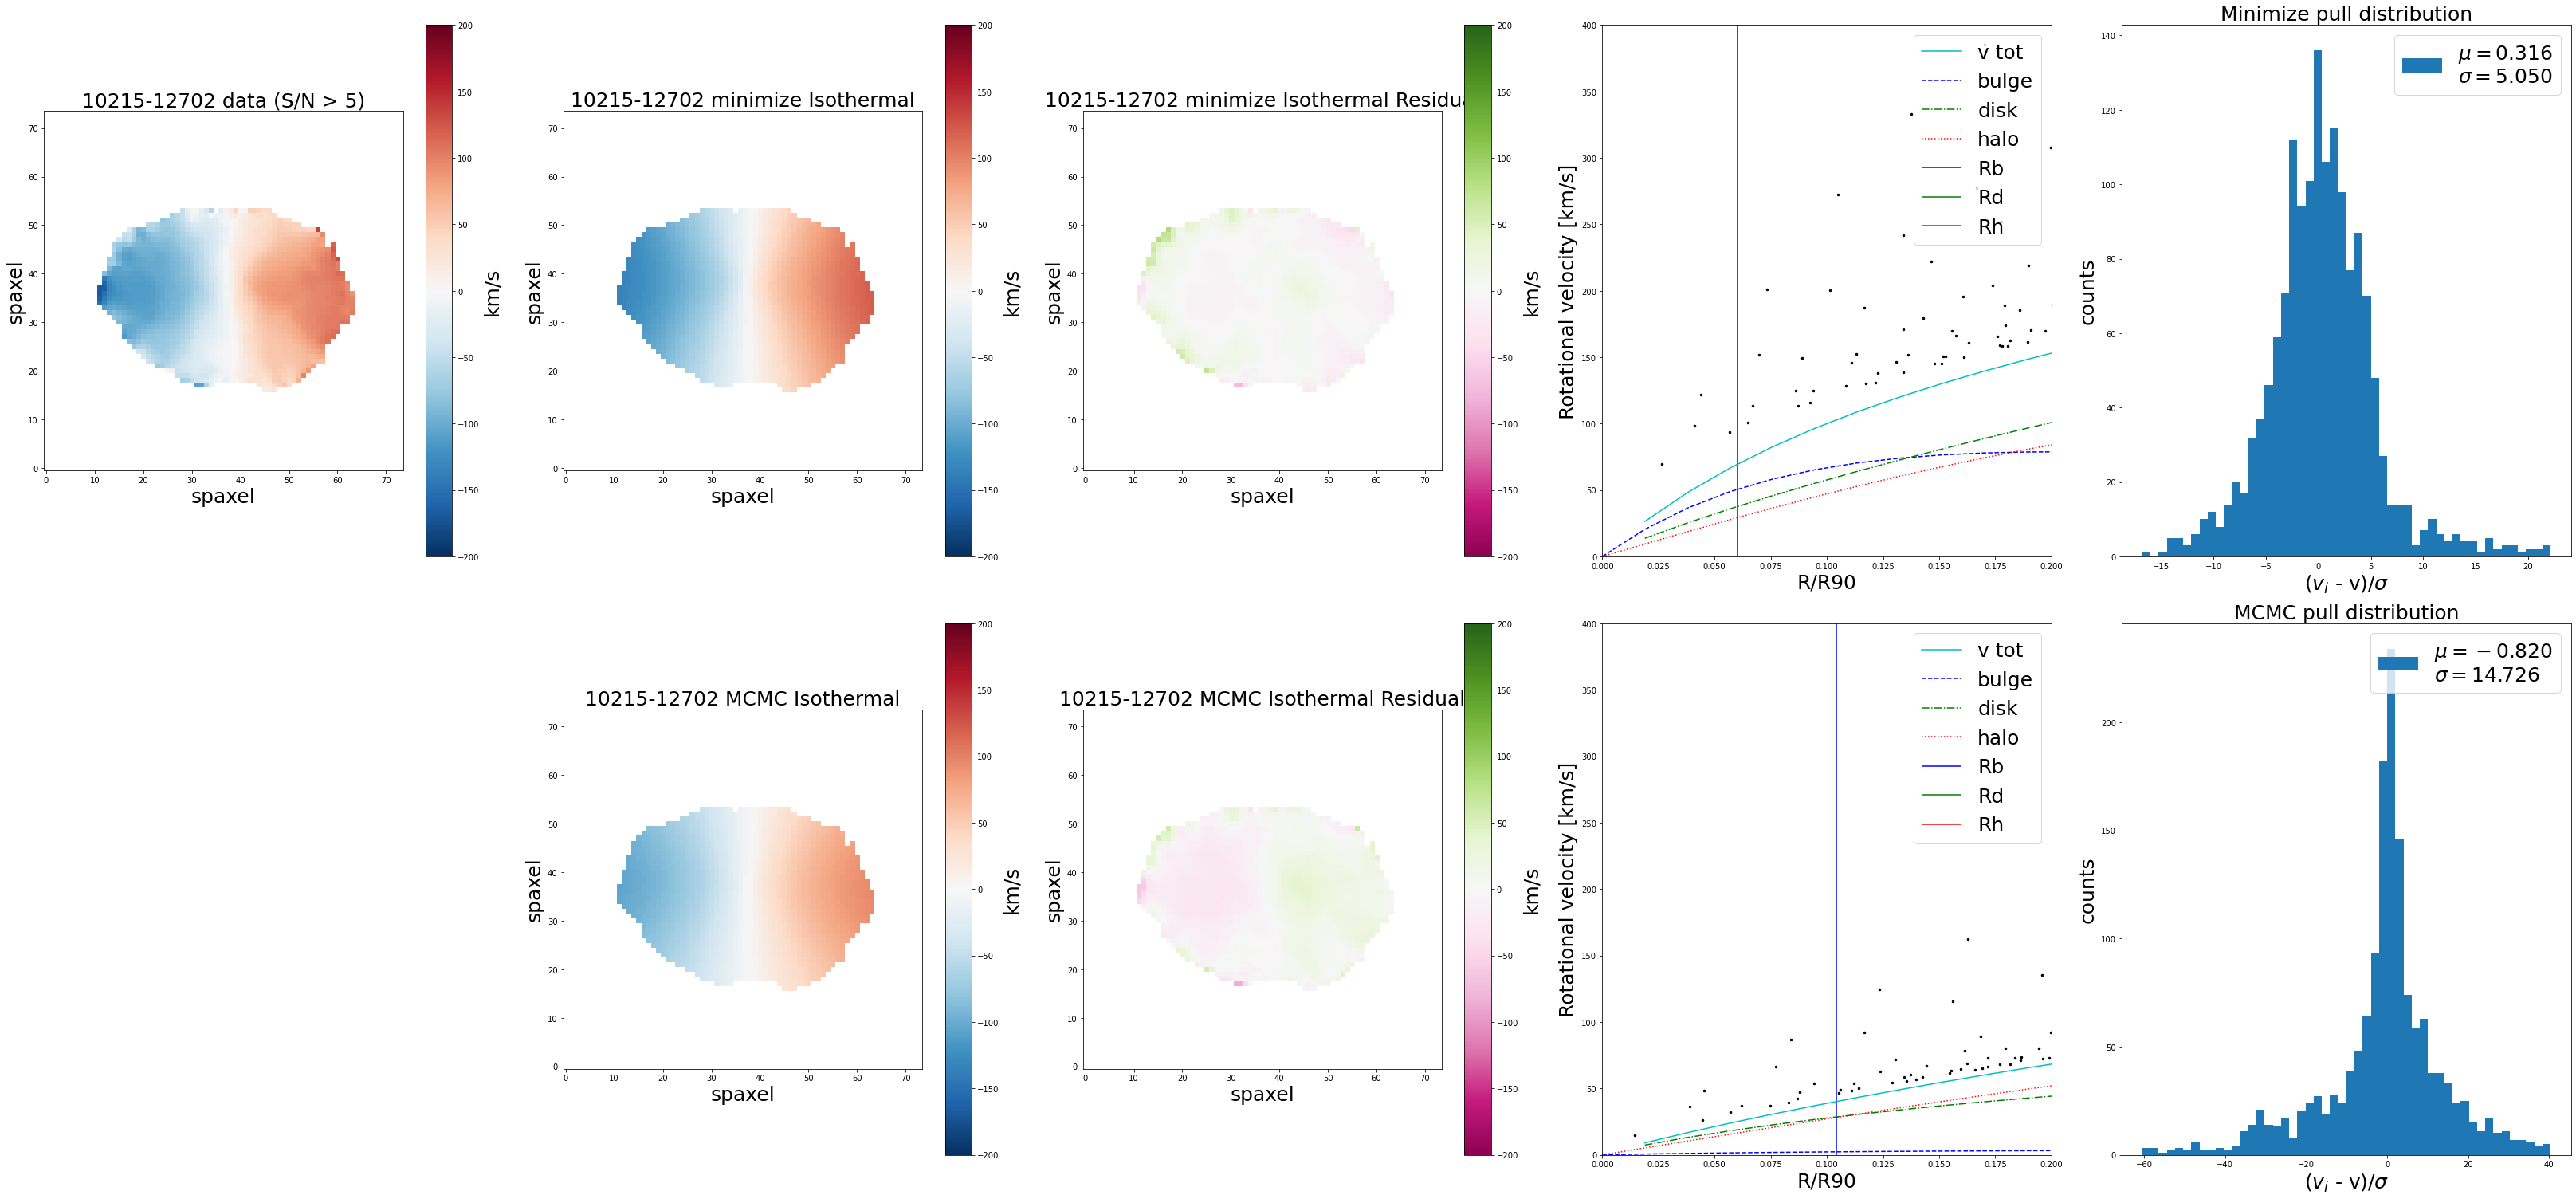

In [91]:
# Isothermal - 10215-12702

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_12702, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_12702 - mini_map_10215_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_12702 - mcmc_map_10215_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-12702 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_12702/r90_10215_12702, v_mini_10215_12702, 'c',label='v tot')
plt.plot(r_mini_10215_12702/r90_10215_12702, v_b_mini_10215_12702, 'b--',label='bulge')
plt.plot(r_mini_10215_12702/r90_10215_12702, v_d_mini_10215_12702,'g-.',label='disk')
plt.plot(r_mini_10215_12702/r90_10215_12702, v_h_mini_10215_12702,'r:',label='halo')

plt.vlines(x = mini_fit_10215_12702[1]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_12702[3]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_12702[5]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_12702/r90_10215_12702, vm_deproj_mini_10215_12702, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_mcmc_10215_12702, 'c',label='v tot')
plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_b_mcmc_10215_12702, 'b--',label='bulge')
plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_d_mcmc_10215_12702,'g-.',label='disk')
plt.plot(r_mcmc_10215_12702/r90_10215_12702, v_h_mcmc_10215_12702,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_12702))

plt.vlines(x = mcmc_fit_10215_12702[1]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_12702[3]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_12702[5]/r90_10215_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_12702/r90_10215_12702, vm_deproj_mcmc_10215_12702, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10215_12702 = dmap_10215_12702 - mini_map_10215_12702

dist_minimize_Isothermal_10215_12702 = residual_minimize_Isothermal_10215_12702*np.sqrt(ivar_masked_10215_12702)

residual_mcmc_Isothermal_10215_12702 = dmap_10215_12702 - mcmc_map_10215_12702

dist_mcmc_Isothermal_10215_12702 = residual_mcmc_Isothermal_10215_12702*np.sqrt(ivar_masked_10215_12702)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10215_12702 = ma.mean(dist_minimize_Isothermal_10215_12702)
sig_mini_Isothermal_10215_12702 = ma.std(dist_minimize_Isothermal_10215_12702)

n_mini_Isothermal_10215_12702, bins_mini_Isothermal_10215_12702, patches_mini_Isothermal_10215_12702 = plt.hist(dist_minimize_Isothermal_10215_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10215_12702, sig_mini_Isothermal_10215_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10215_12702 = ma.mean(dist_mcmc_Isothermal_10215_12702)
sig_mcmc_Isothermal_10215_12702 = ma.std(dist_mcmc_Isothermal_10215_12702)

n_mcmc_Isothermal_10215_12702, bins_mcmc_Isothermal_10215_12702, patches_mcmc_Isothermal_10215_12702 = plt.hist(dist_mcmc_Isothermal_10215_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10215_12702, sig_mcmc_Isothermal_10215_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_12702))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_12702))
print('r$R_{90}$: ' + str(r90_10215_12702) + ' kpc')
print('Incl from data: ' + str(incl_10215_12702))
print('Incl from Minimize: ' + str(mini_fit_10215_12702[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_12702[-5]))

Minimize r$\chi^2$ : 44.58546553206752
MCMC r$\chi^2$ : 879.7993416116171
r$R_{90}$: 7.835508346557617 kpc
Incl from data: 0.9344340517361431
Incl from Minimize: 0.9439771389246389
Incl from MCMC: 0.7770689051104523


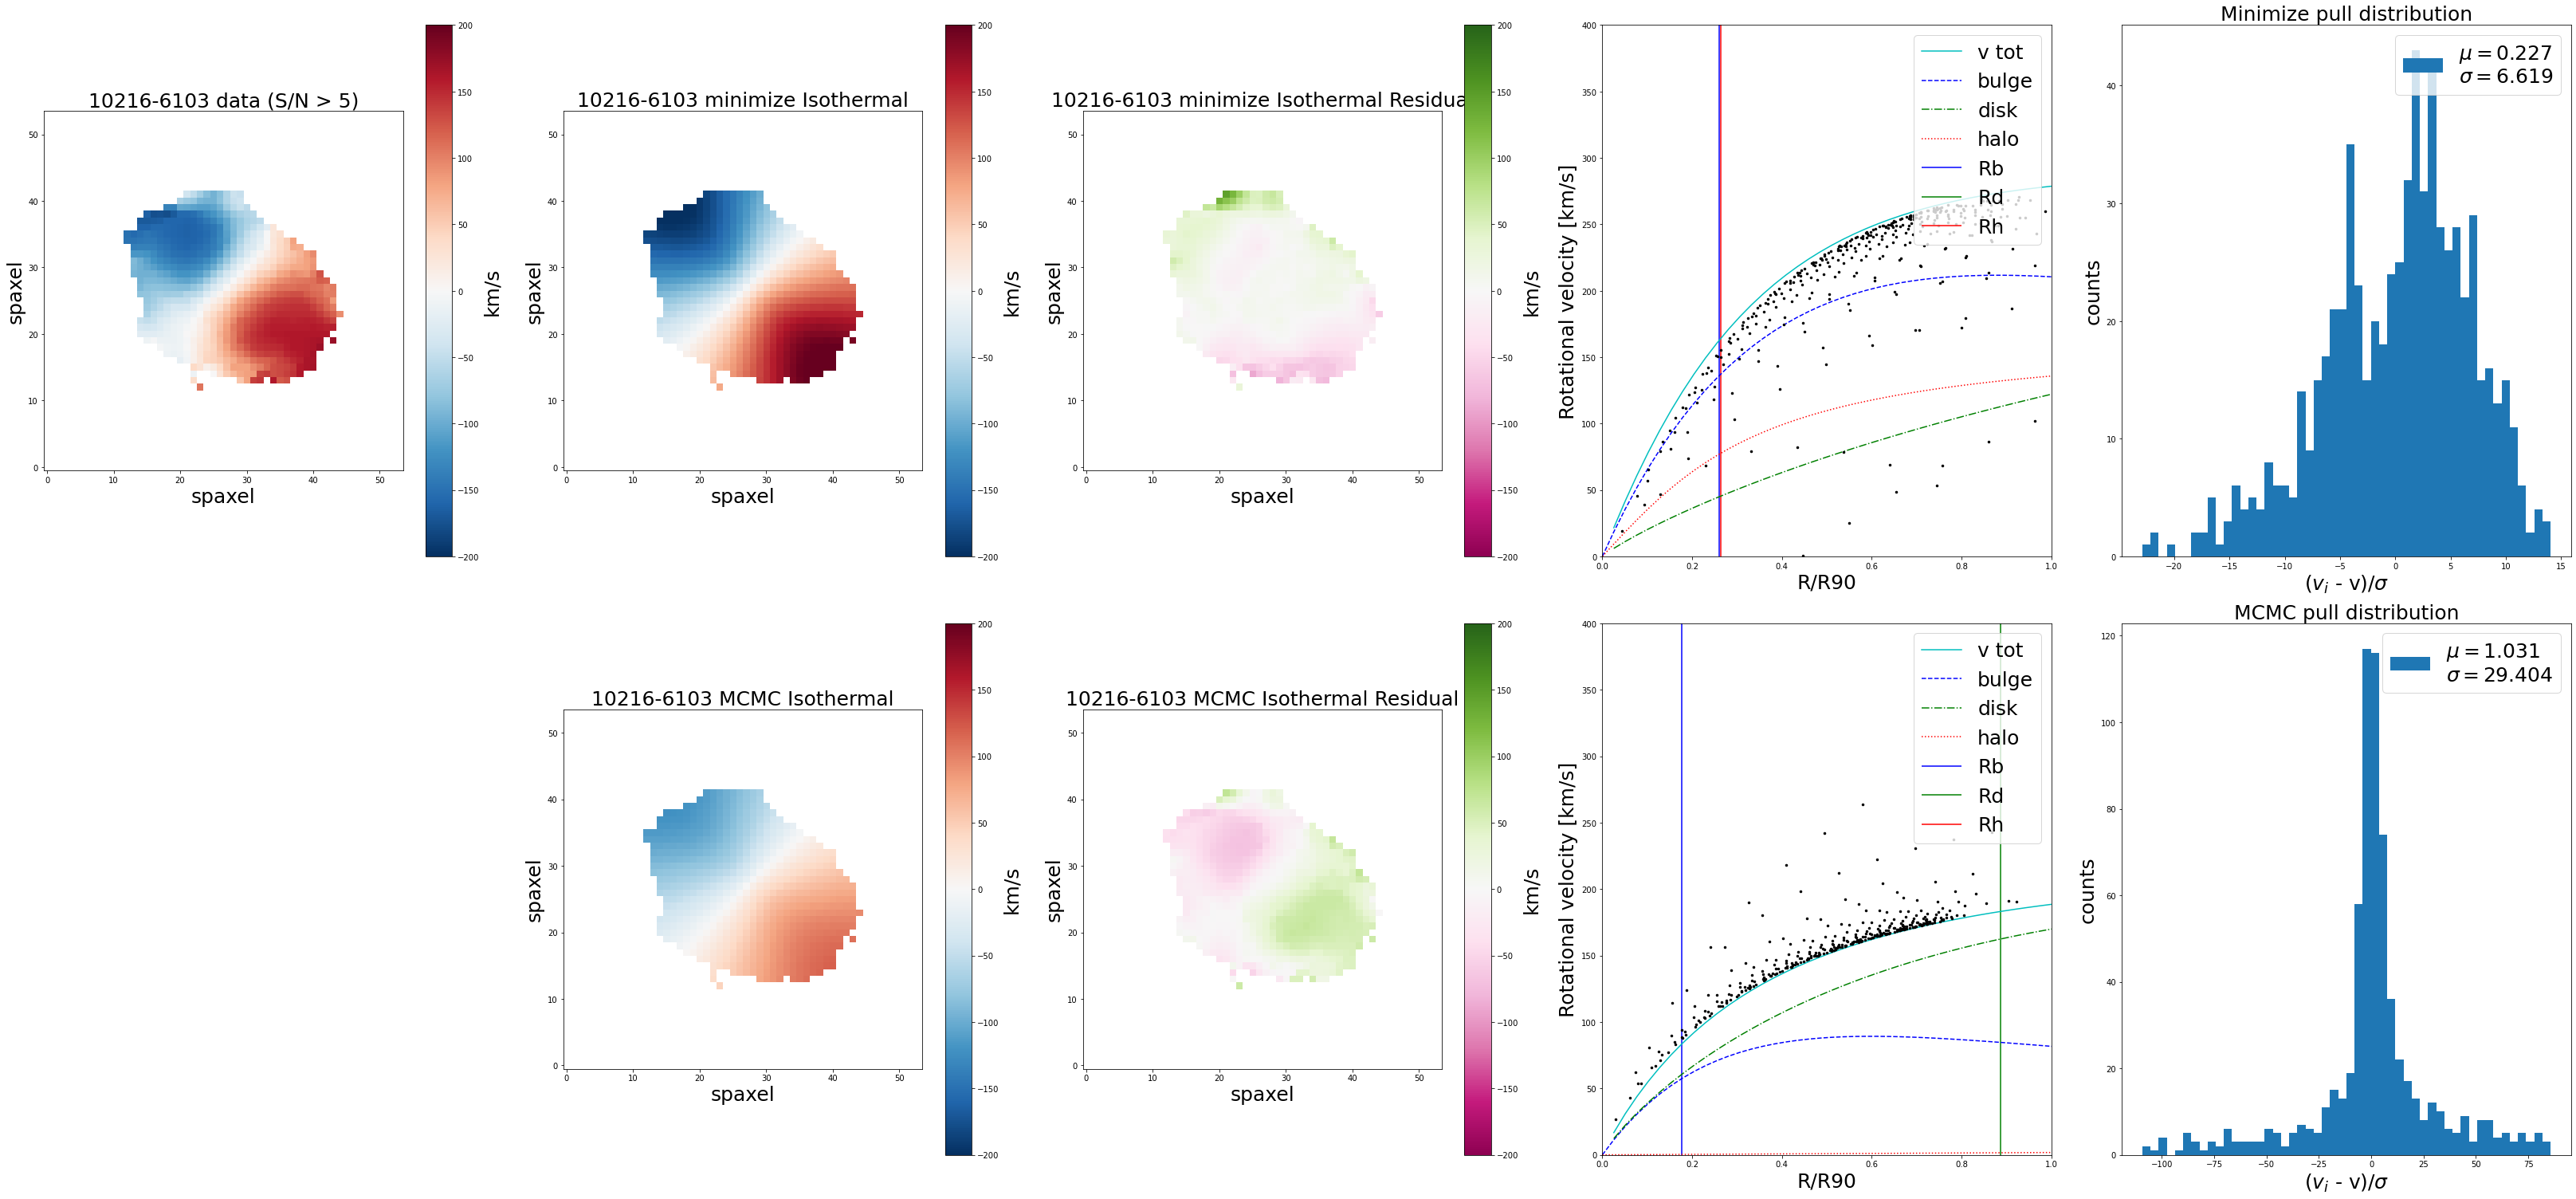

In [93]:
# Isothermal - 10216-6103

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10216_6103, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10216_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10216_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10216_6103 - mini_map_10216_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10216_6103 - mcmc_map_10216_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10216_6103/r90_10216_6103, v_mini_10216_6103, 'c',label='v tot')
plt.plot(r_mini_10216_6103/r90_10216_6103, v_b_mini_10216_6103, 'b--',label='bulge')
plt.plot(r_mini_10216_6103/r90_10216_6103, v_d_mini_10216_6103,'g-.',label='disk')
plt.plot(r_mini_10216_6103/r90_10216_6103, v_h_mini_10216_6103,'r:',label='halo')

plt.vlines(x = mini_fit_10216_6103[1]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10216_6103[3]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10216_6103[5]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10216_6103/r90_10216_6103, vm_deproj_mini_10216_6103, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_mcmc_10216_6103, 'c',label='v tot')
plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_b_mcmc_10216_6103, 'b--',label='bulge')
plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_d_mcmc_10216_6103,'g-.',label='disk')
plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_h_mcmc_10216_6103,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10216_6103))

plt.vlines(x = mcmc_fit_10216_6103[1]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10216_6103[3]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10216_6103[5]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10216_6103/r90_10216_6103, vm_deproj_mcmc_10216_6103, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10216_6103 = dmap_10216_6103 - mini_map_10216_6103

dist_minimize_Isothermal_10216_6103 = residual_minimize_Isothermal_10216_6103*np.sqrt(ivar_masked_10216_6103)

residual_mcmc_Isothermal_10216_6103 = dmap_10216_6103 - mcmc_map_10216_6103

dist_mcmc_Isothermal_10216_6103 = residual_mcmc_Isothermal_10216_6103*np.sqrt(ivar_masked_10216_6103)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10216_6103 = ma.mean(dist_minimize_Isothermal_10216_6103)
sig_mini_Isothermal_10216_6103 = ma.std(dist_minimize_Isothermal_10216_6103)

n_mini_Isothermal_10216_6103, bins_mini_Isothermal_10216_6103, patches_mini_Isothermal_10216_6103 = plt.hist(dist_minimize_Isothermal_10216_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10216_6103, sig_mini_Isothermal_10216_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10216_6103 = ma.mean(dist_mcmc_Isothermal_10216_6103)
sig_mcmc_Isothermal_10216_6103 = ma.std(dist_mcmc_Isothermal_10216_6103)

n_mcmc_Isothermal_10216_6103, bins_mcmc_Isothermal_10216_6103, patches_mcmc_Isothermal_10216_6103 = plt.hist(dist_mcmc_Isothermal_10216_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10216_6103, sig_mcmc_Isothermal_10216_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10216_6103))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10216_6103))
print('r$R_{90}$: ' + str(r90_10216_6103) + ' kpc')
print('Incl from data: ' + str(incl_10216_6103))
print('Incl from Minimize: ' + str(mini_fit_10216_6103[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10216_6103[-5]))

Minimize r$\chi^2$ : 53.13810038599877
MCMC r$\chi^2$ : 263.4786613453098
r$R_{90}$: 21.733671188354492 kpc
Incl from data: 0.48699372996119683
Incl from Minimize: 0.4066325970619886
Incl from MCMC: 0.42186292832162275


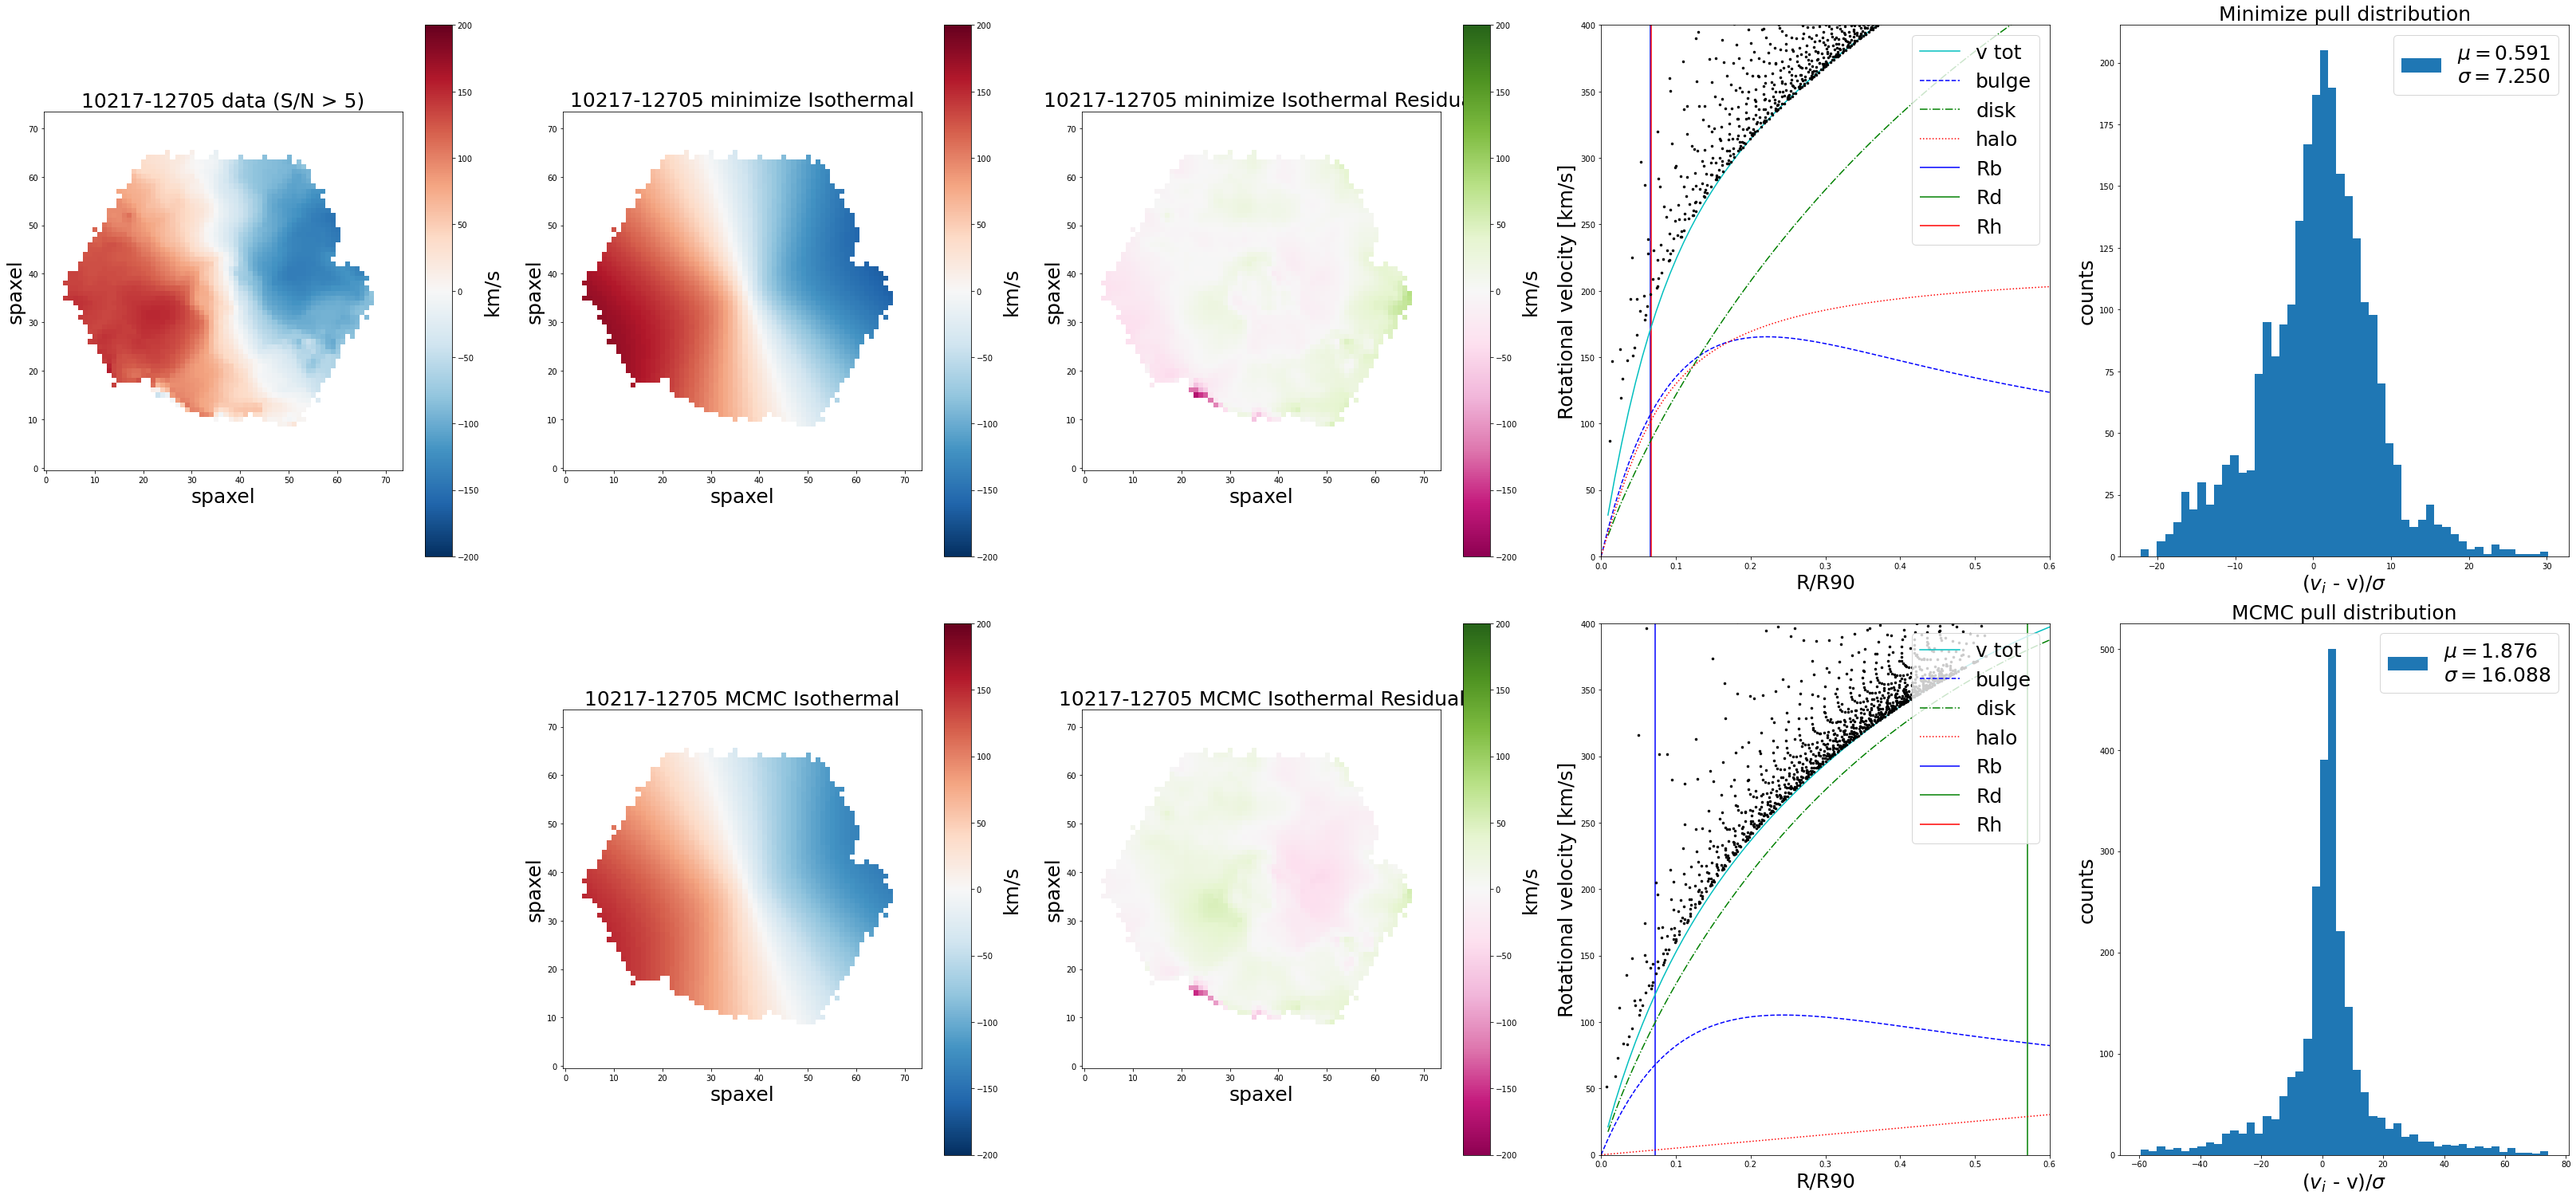

In [95]:
# Isothermal - 10217-12705

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10217_12705, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10217-12705 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10217_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10217-12705 minimize Isothermal', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10217_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10217-12705 MCMC Isothermal', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10217_12705 - mini_map_10217_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10217-12705 minimize Isothermal Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10217_12705 - mcmc_map_10217_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10217-12705 MCMC Isothermal Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10217_12705/r90_10217_12705, v_mini_10217_12705, 'c',label='v tot')
plt.plot(r_mini_10217_12705/r90_10217_12705, v_b_mini_10217_12705, 'b--',label='bulge')
plt.plot(r_mini_10217_12705/r90_10217_12705, v_d_mini_10217_12705,'g-.',label='disk')
plt.plot(r_mini_10217_12705/r90_10217_12705, v_h_mini_10217_12705,'r:',label='halo')

plt.vlines(x = mini_fit_10217_12705[1]/r90_10217_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10217_12705[3]/r90_10217_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10217_12705[5]/r90_10217_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10217_12705/r90_10217_12705, vm_deproj_mini_10217_12705, 'k.', markersize=5)

plt.xlim([0,0.6])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10217_12705/r90_10217_12705, v_mcmc_10217_12705, 'c',label='v tot')
plt.plot(r_mcmc_10217_12705/r90_10217_12705, v_b_mcmc_10217_12705, 'b--',label='bulge')
plt.plot(r_mcmc_10217_12705/r90_10217_12705, v_d_mcmc_10217_12705,'g-.',label='disk')
plt.plot(r_mcmc_10217_12705/r90_10217_12705, v_h_mcmc_10217_12705,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10217_12705))

plt.vlines(x = mcmc_fit_10217_12705[1]/r90_10217_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10217_12705[3]/r90_10217_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10217_12705[5]/r90_10217_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10217_12705/r90_10217_12705, vm_deproj_mcmc_10217_12705, 'k.', markersize=5)

plt.xlim([0,0.6])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Isothermal_10217_12705 = dmap_10217_12705 - mini_map_10217_12705

dist_minimize_Isothermal_10217_12705 = residual_minimize_Isothermal_10217_12705*np.sqrt(ivar_masked_10217_12705)

residual_mcmc_Isothermal_10217_12705 = dmap_10217_12705 - mcmc_map_10217_12705

dist_mcmc_Isothermal_10217_12705 = residual_mcmc_Isothermal_10217_12705*np.sqrt(ivar_masked_10217_12705)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Isothermal_10217_12705 = ma.mean(dist_minimize_Isothermal_10217_12705)
sig_mini_Isothermal_10217_12705 = ma.std(dist_minimize_Isothermal_10217_12705)

n_mini_Isothermal_10217_12705, bins_mini_Isothermal_10217_12705, patches_mini_Isothermal_10217_12705 = plt.hist(dist_minimize_Isothermal_10217_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Isothermal_10217_12705, sig_mini_Isothermal_10217_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Isothermal_10217_12705 = ma.mean(dist_mcmc_Isothermal_10217_12705)
sig_mcmc_Isothermal_10217_12705 = ma.std(dist_mcmc_Isothermal_10217_12705)

n_mcmc_Isothermal_10217_12705, bins_mcmc_Isothermal_10217_12705, patches_mcmc_Isothermal_10217_12705 = plt.hist(dist_mcmc_Isothermal_10217_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Isothermal_10217_12705, sig_mcmc_Isothermal_10217_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10217_12705))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10217_12705))
print('r$R_{90}$: ' + str(r90_10217_12705) + ' kpc')
print('Incl from data: ' + str(incl_10217_12705))
print('Incl from Minimize: ' + str(mini_fit_10217_12705[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10217_12705[-5]))

In [12]:
# Burkert
# Improved
dmap_10001_12702, ivar_masked_10001_12702, incl_10001_12702, scale_10001_12702, r90_10001_12702, mini_fit_10001_12702, mcmc_fit_10001_12702, mini_map_10001_12702, mcmc_map_10001_12702, chi2_mini_10001_12702, chi2_mcmc_10001_12702,r_mini_10001_12702, v_b_mini_10001_12702, v_d_mini_10001_12702, v_h_mini_10001_12702, v_mini_10001_12702, r_mcmc_10001_12702, v_b_mcmc_10001_12702, v_d_mcmc_10001_12702, v_h_mcmc_10001_12702, v_mcmc_10001_12702  = get_info('10001-12702',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10001_12703, ivar_masked_10001_12703, incl_10001_12703, scale_10001_12703, r90_10001_12703, mini_fit_10001_12703, mcmc_fit_10001_12703, mini_map_10001_12703, mcmc_map_10001_12703, chi2_mini_10001_12703, chi2_mcmc_10001_12703,r_mini_10001_12703, v_b_mini_10001_12703, v_d_mini_10001_12703, v_h_mini_10001_12703, v_mini_10001_12703, r_mcmc_10001_12703, v_b_mcmc_10001_12703, v_d_mcmc_10001_12703, v_h_mcmc_10001_12703, v_mcmc_10001_12703  = get_info('10001-12703',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10001_12704, ivar_masked_10001_12704, incl_10001_12704, scale_10001_12704, r90_10001_12704, mini_fit_10001_12704, mcmc_fit_10001_12704, mini_map_10001_12704, mcmc_map_10001_12704, chi2_mini_10001_12704, chi2_mcmc_10001_12704,r_mini_10001_12704, v_b_mini_10001_12704, v_d_mini_10001_12704, v_h_mini_10001_12704, v_mini_10001_12704, r_mcmc_10001_12704, v_b_mcmc_10001_12704, v_d_mcmc_10001_12704, v_h_mcmc_10001_12704, v_mcmc_10001_12704  = get_info('10001-12704',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10213_9102, ivar_masked_10213_9102, incl_10213_9102, scale_10213_9102, r90_10213_9102, mini_fit_10213_9102, mcmc_fit_10213_9102, mini_map_10213_9102, mcmc_map_10213_9102, chi2_mini_10213_9102, chi2_mcmc_10213_9102,r_mini_10213_9102, v_b_mini_10213_9102, v_d_mini_10213_9102, v_h_mini_10213_9102, v_mini_10213_9102, r_mcmc_10213_9102, v_b_mcmc_10213_9102, v_d_mcmc_10213_9102, v_h_mcmc_10213_9102, v_mcmc_10213_9102  = get_info('10213-9102',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10214_12701, ivar_masked_10214_12701, incl_10214_12701, scale_10214_12701, r90_10214_12701, mini_fit_10214_12701, mcmc_fit_10214_12701, mini_map_10214_12701, mcmc_map_10214_12701, chi2_mini_10214_12701, chi2_mcmc_10214_12701,r_mini_10214_12701, v_b_mini_10214_12701, v_d_mini_10214_12701, v_h_mini_10214_12701, v_mini_10214_12701, r_mcmc_10214_12701, v_b_mcmc_10214_12701, v_d_mcmc_10214_12701, v_h_mcmc_10214_12701, v_mcmc_10214_12701  = get_info('10214-12701',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
# Lost
dmap_10001_12701, ivar_masked_10001_12701, incl_10001_12701, scale_10001_12701, r90_10001_12701, mini_fit_10001_12701, mcmc_fit_10001_12701, mini_map_10001_12701, mcmc_map_10001_12701, chi2_mini_10001_12701, chi2_mcmc_10001_12701,r_mini_10001_12701, v_b_mini_10001_12701, v_d_mini_10001_12701, v_h_mini_10001_12701, v_mini_10001_12701, r_mcmc_10001_12701, v_b_mcmc_10001_12701, v_d_mcmc_10001_12701, v_h_mcmc_10001_12701, v_mcmc_10001_12701  = get_info('10001-12701',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10213_12705, ivar_masked_10213_12705, incl_10213_12705, scale_10213_12705, r90_10213_12705, mini_fit_10213_12705, mcmc_fit_10213_12705, mini_map_10213_12705, mcmc_map_10213_12705, chi2_mini_10213_12705, chi2_mcmc_10213_12705,r_mini_10213_12705, v_b_mini_10213_12705, v_d_mini_10213_12705, v_h_mini_10213_12705, v_mini_10213_12705, r_mcmc_10213_12705, v_b_mcmc_10213_12705, v_d_mcmc_10213_12705, v_h_mcmc_10213_12705, v_mcmc_10213_12705  = get_info('10213-12705',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10213_1902, ivar_masked_10213_1902, incl_10213_1902, scale_10213_1902, r90_10213_1902, mini_fit_10213_1902, mcmc_fit_10213_1902, mini_map_10213_1902, mcmc_map_10213_1902, chi2_mini_10213_1902, chi2_mcmc_10213_1902,r_mini_10213_1902, v_b_mini_10213_1902, v_d_mini_10213_1902, v_h_mini_10213_1902, v_mini_10213_1902, r_mcmc_10213_1902, v_b_mcmc_10213_1902, v_d_mcmc_10213_1902, v_h_mcmc_10213_1902, v_mcmc_10213_1902  = get_info('10213-1902',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10215_3703, ivar_masked_10215_3703, incl_10215_3703, scale_10215_3703, r90_10215_3703, mini_fit_10215_3703, mcmc_fit_10215_3703, mini_map_10215_3703, mcmc_map_10215_3703, chi2_mini_10215_3703, chi2_mcmc_10215_3703,r_mini_10215_3703, v_b_mini_10215_3703, v_d_mini_10215_3703, v_h_mini_10215_3703, v_mini_10215_3703, r_mcmc_10215_3703, v_b_mcmc_10215_3703, v_d_mcmc_10215_3703, v_h_mcmc_10215_3703, v_mcmc_10215_3703  = get_info('10215-3703',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')
dmap_10216_6103, ivar_masked_10216_6103, incl_10216_6103, scale_10216_6103, r90_10216_6103, mini_fit_10216_6103, mcmc_fit_10216_6103, mini_map_10216_6103, mcmc_map_10216_6103, chi2_mini_10216_6103, chi2_mcmc_10216_6103,r_mini_10216_6103, v_b_mini_10216_6103, v_d_mini_10216_6103, v_h_mini_10216_6103, v_mini_10216_6103, r_mcmc_10216_6103, v_b_mcmc_10216_6103, v_d_mcmc_10216_6103, v_h_mcmc_10216_6103, v_mcmc_10216_6103  = get_info('10216-6103',bur_mini_fits,bur_mini_fits_mc_corr,r90_file,'bur')

In [13]:
# Deprojected velocity maps
# Improved
rm_deproj_mini_10001_12702, vm_deproj_mini_10001_12702 = vel_map_depro(dmap_10001_12702, mini_fit_10001_12702, scale_10001_12702)
rm_deproj_mcmc_10001_12702, vm_deproj_mcmc_10001_12702 = vel_map_depro(dmap_10001_12702, mcmc_fit_10001_12702, scale_10001_12702)
rm_deproj_mini_10001_12703, vm_deproj_mini_10001_12703 = vel_map_depro(dmap_10001_12703, mini_fit_10001_12703, scale_10001_12703)
rm_deproj_mcmc_10001_12703, vm_deproj_mcmc_10001_12703 = vel_map_depro(dmap_10001_12703, mcmc_fit_10001_12703, scale_10001_12703)
rm_deproj_mini_10001_12704, vm_deproj_mini_10001_12704 = vel_map_depro(dmap_10001_12704, mini_fit_10001_12704, scale_10001_12704)
rm_deproj_mcmc_10001_12704, vm_deproj_mcmc_10001_12704 = vel_map_depro(dmap_10001_12704, mcmc_fit_10001_12704, scale_10001_12704)
rm_deproj_mini_10213_9102, vm_deproj_mini_10213_9102 = vel_map_depro(dmap_10213_9102, mini_fit_10213_9102, scale_10213_9102)
rm_deproj_mcmc_10213_9102, vm_deproj_mcmc_10213_9102 = vel_map_depro(dmap_10213_9102, mcmc_fit_10213_9102, scale_10213_9102)
rm_deproj_mini_10214_12701, vm_deproj_mini_10214_12701 = vel_map_depro(dmap_10214_12701, mini_fit_10214_12701, scale_10214_12701)
rm_deproj_mcmc_10214_12701, vm_deproj_mcmc_10214_12701 = vel_map_depro(dmap_10214_12701, mcmc_fit_10214_12701, scale_10214_12701)
# Increased
rm_deproj_mini_10001_12701, vm_deproj_mini_10001_12701 = vel_map_depro(dmap_10001_12701, mini_fit_10001_12701, scale_10001_12701)
rm_deproj_mcmc_10001_12701, vm_deproj_mcmc_10001_12701 = vel_map_depro(dmap_10001_12701, mcmc_fit_10001_12701, scale_10001_12701)
rm_deproj_mini_10213_12705, vm_deproj_mini_10213_12705 = vel_map_depro(mini_map_10213_12705, mini_fit_10213_12705, scale_10213_12705)
rm_deproj_mcmc_10213_12705, vm_deproj_mcmc_10213_12705 = vel_map_depro(mcmc_map_10213_12705, mcmc_fit_10213_12705, scale_10213_12705)
rm_deproj_mini_10213_1902, vm_deproj_mini_10213_1902 = vel_map_depro(mini_map_10213_1902, mini_fit_10213_1902, scale_10213_1902)
rm_deproj_mcmc_10213_1902, vm_deproj_mcmc_10213_1902 = vel_map_depro(mcmc_map_10213_1902, mcmc_fit_10213_1902, scale_10213_1902)
rm_deproj_mini_10215_3703, vm_deproj_mini_10215_3703 = vel_map_depro(mini_map_10215_3703, mini_fit_10215_3703, scale_10215_3703)
rm_deproj_mcmc_10215_3703, vm_deproj_mcmc_10215_3703 = vel_map_depro(mcmc_map_10215_3703, mcmc_fit_10215_3703, scale_10215_3703)
rm_deproj_mini_10216_6103, vm_deproj_mini_10216_6103 = vel_map_depro(mini_map_10216_6103, mini_fit_10216_6103, scale_10216_6103)
rm_deproj_mcmc_10216_6103, vm_deproj_mcmc_10216_6103 = vel_map_depro(mcmc_map_10216_6103, mcmc_fit_10216_6103, scale_10216_6103)

Minimize r$\chi^2$ : 6.043839702754441
MCMC r$\chi^2$ : 2.1139560146643186
r$R_{90}$: 14.355437278747559 kpc
Incl from data: 0.9578140884777914
Incl from Minimize: 0.6644412329698743
Incl from MCMC: 0.87936211028627


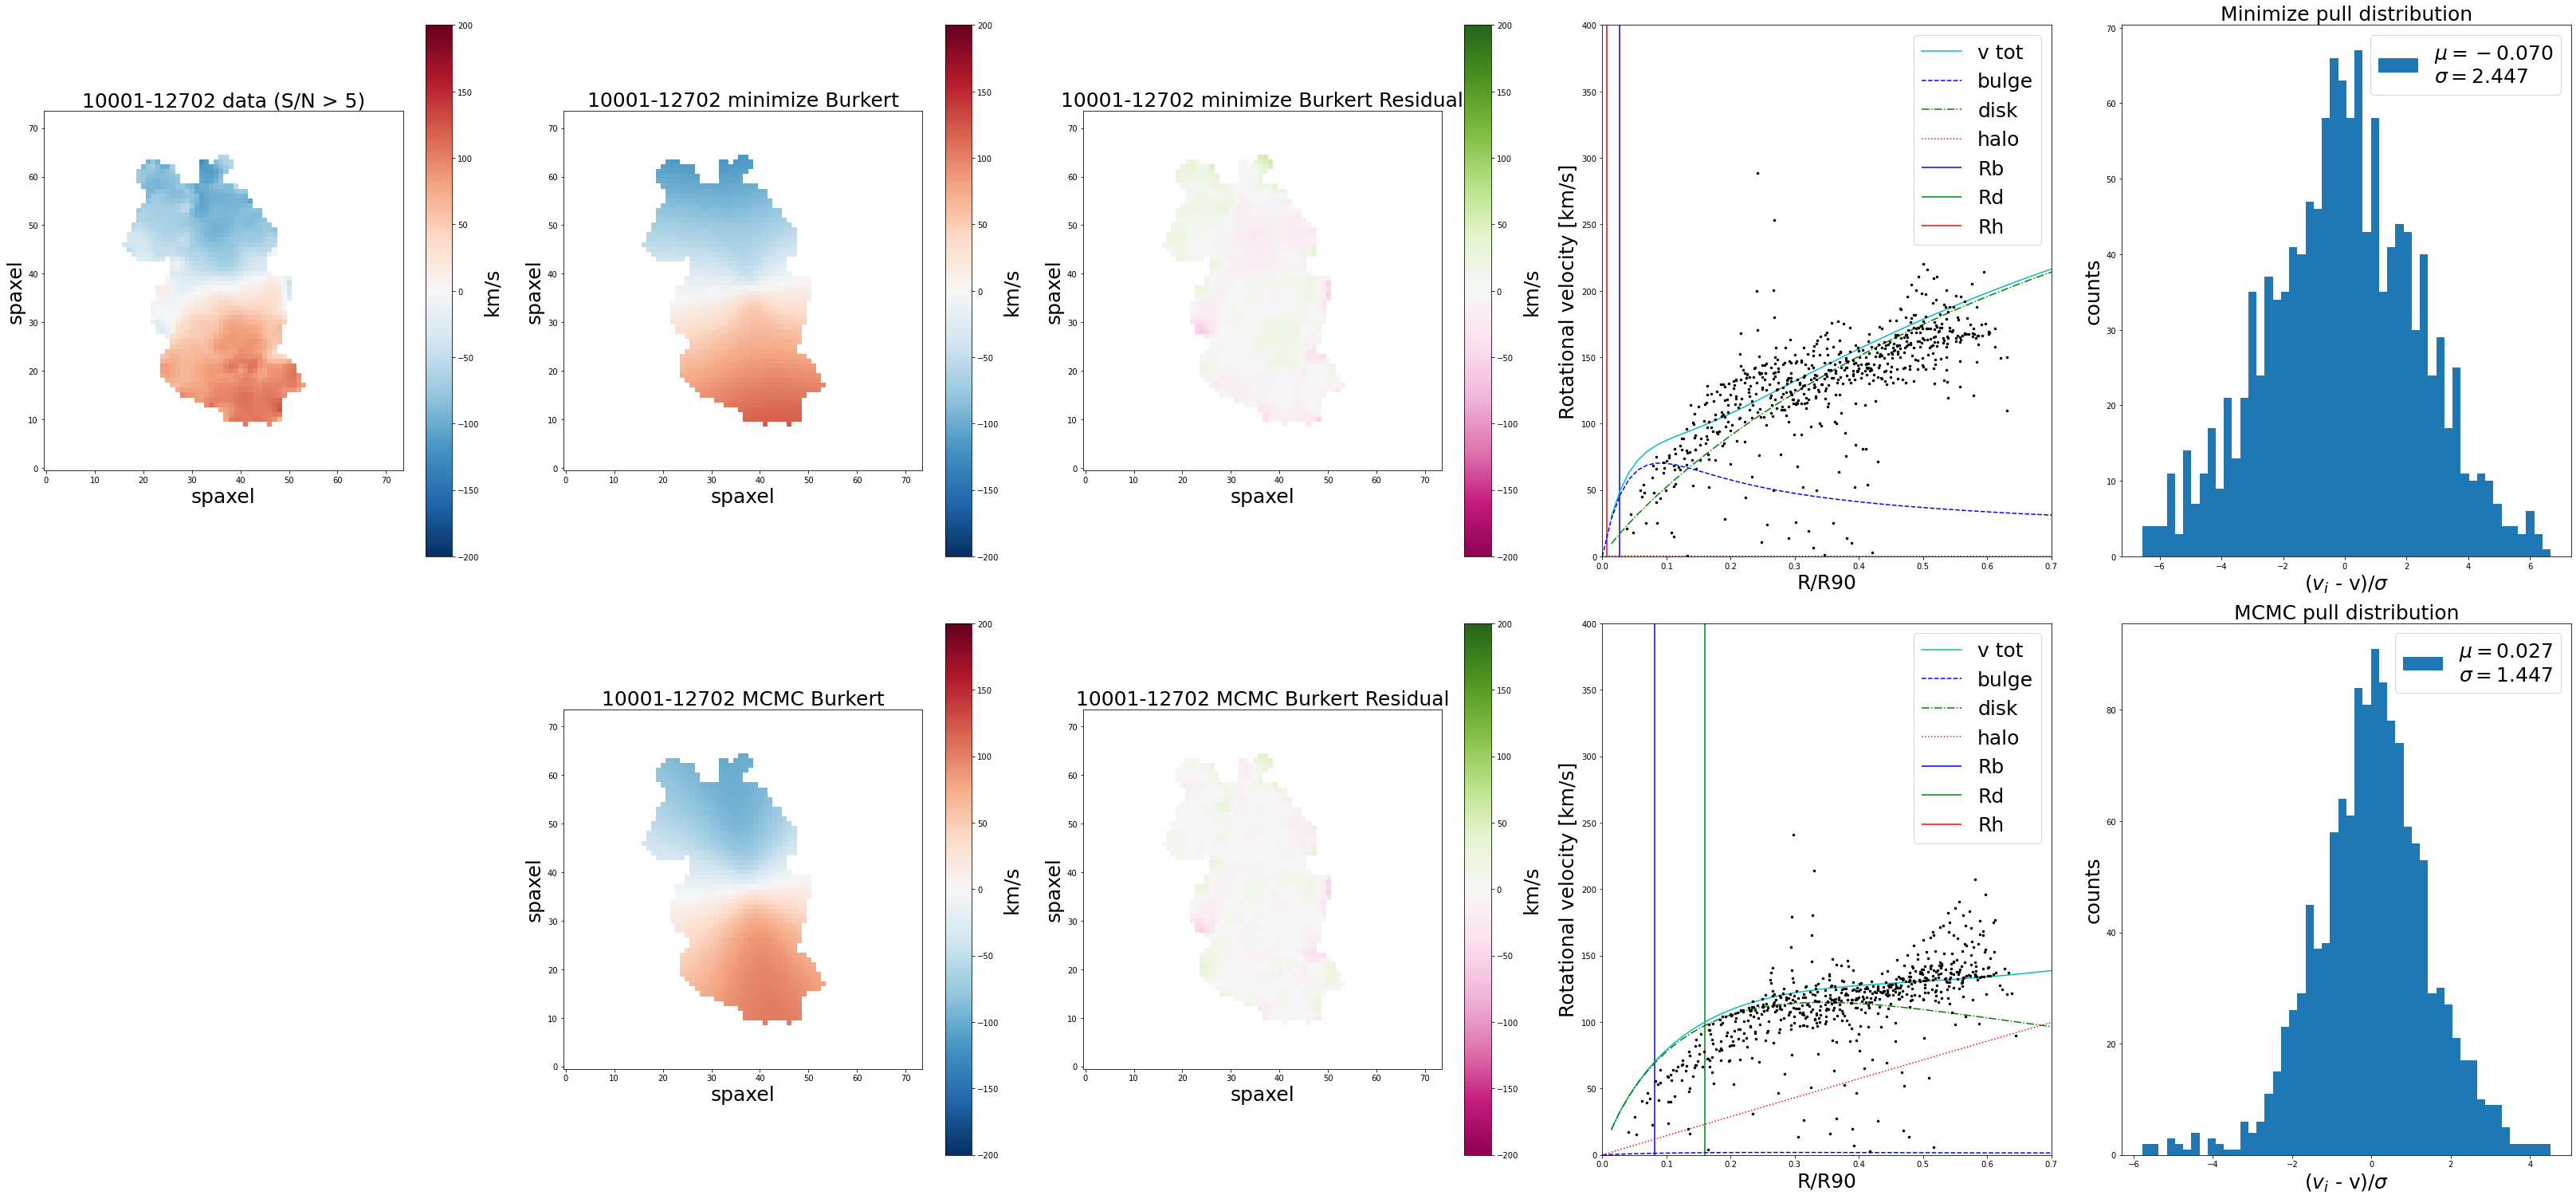

In [14]:
# Burkert - 10001-12702

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12702, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12702, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12702 - mini_map_10001_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12702 - mcmc_map_10001_12702, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12702 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12702/r90_10001_12702, v_mini_10001_12702, 'c',label='v tot')
plt.plot(r_mini_10001_12702/r90_10001_12702, v_b_mini_10001_12702, 'b--',label='bulge')
plt.plot(r_mini_10001_12702/r90_10001_12702, v_d_mini_10001_12702,'g-.',label='disk')
plt.plot(r_mini_10001_12702/r90_10001_12702, v_h_mini_10001_12702,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12702[1]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12702[3]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12702[5]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12702/r90_10001_12702, vm_deproj_mini_10001_12702, 'k.', markersize=5)

plt.xlim([0,0.7])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_mcmc_10001_12702, 'c',label='v tot')
plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_b_mcmc_10001_12702, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_d_mcmc_10001_12702,'g-.',label='disk')
plt.plot(r_mcmc_10001_12702/r90_10001_12702, v_h_mcmc_10001_12702,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12702))

plt.vlines(x = mcmc_fit_10001_12702[1]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12702[3]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12702[5]/r90_10001_12702,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12702/r90_10001_12702, vm_deproj_mcmc_10001_12702, 'k.', markersize=5)

plt.xlim([0,0.7])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10001_12702 = dmap_10001_12702 - mini_map_10001_12702

dist_minimize_Burkert_10001_12702 = residual_minimize_Burkert_10001_12702*np.sqrt(ivar_masked_10001_12702)

residual_mcmc_Burkert_10001_12702 = dmap_10001_12702 - mcmc_map_10001_12702

dist_mcmc_Burkert_10001_12702 = residual_mcmc_Burkert_10001_12702*np.sqrt(ivar_masked_10001_12702)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10001_12702 = ma.mean(dist_minimize_Burkert_10001_12702)
sig_mini_Burkert_10001_12702 = ma.std(dist_minimize_Burkert_10001_12702)

n_mini_Burkert_10001_12702, bins_mini_Burkert_10001_12702, patches_mini_Burkert_10001_12702 = plt.hist(dist_minimize_Burkert_10001_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10001_12702, sig_mini_Burkert_10001_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10001_12702 = ma.mean(dist_mcmc_Burkert_10001_12702)
sig_mcmc_Burkert_10001_12702 = ma.std(dist_mcmc_Burkert_10001_12702)

n_mcmc_Burkert_10001_12702, bins_mcmc_Burkert_10001_12702, patches_mcmc_Burkert_10001_12702 = plt.hist(dist_mcmc_Burkert_10001_12702.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10001_12702, sig_mcmc_Burkert_10001_12702))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12702))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12702))
print('r$R_{90}$: ' + str(r90_10001_12702) + ' kpc')
print('Incl from data: ' + str(incl_10001_12702))
print('Incl from Minimize: ' + str(mini_fit_10001_12702[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12702[-5]))

In [18]:
print(np.max(rm_deproj_mcmc_10001_12701))

7.50768731086643


Minimize r$\chi^2$ : 47.678032863702065
MCMC r$\chi^2$ : 21.77495536057741
r$R_{90}$: 14.743389129638672 kpc
Incl from data: 1.237234652823882
Incl from Minimize: 0.38702378774494334
Incl from MCMC: 1.1397581570820925


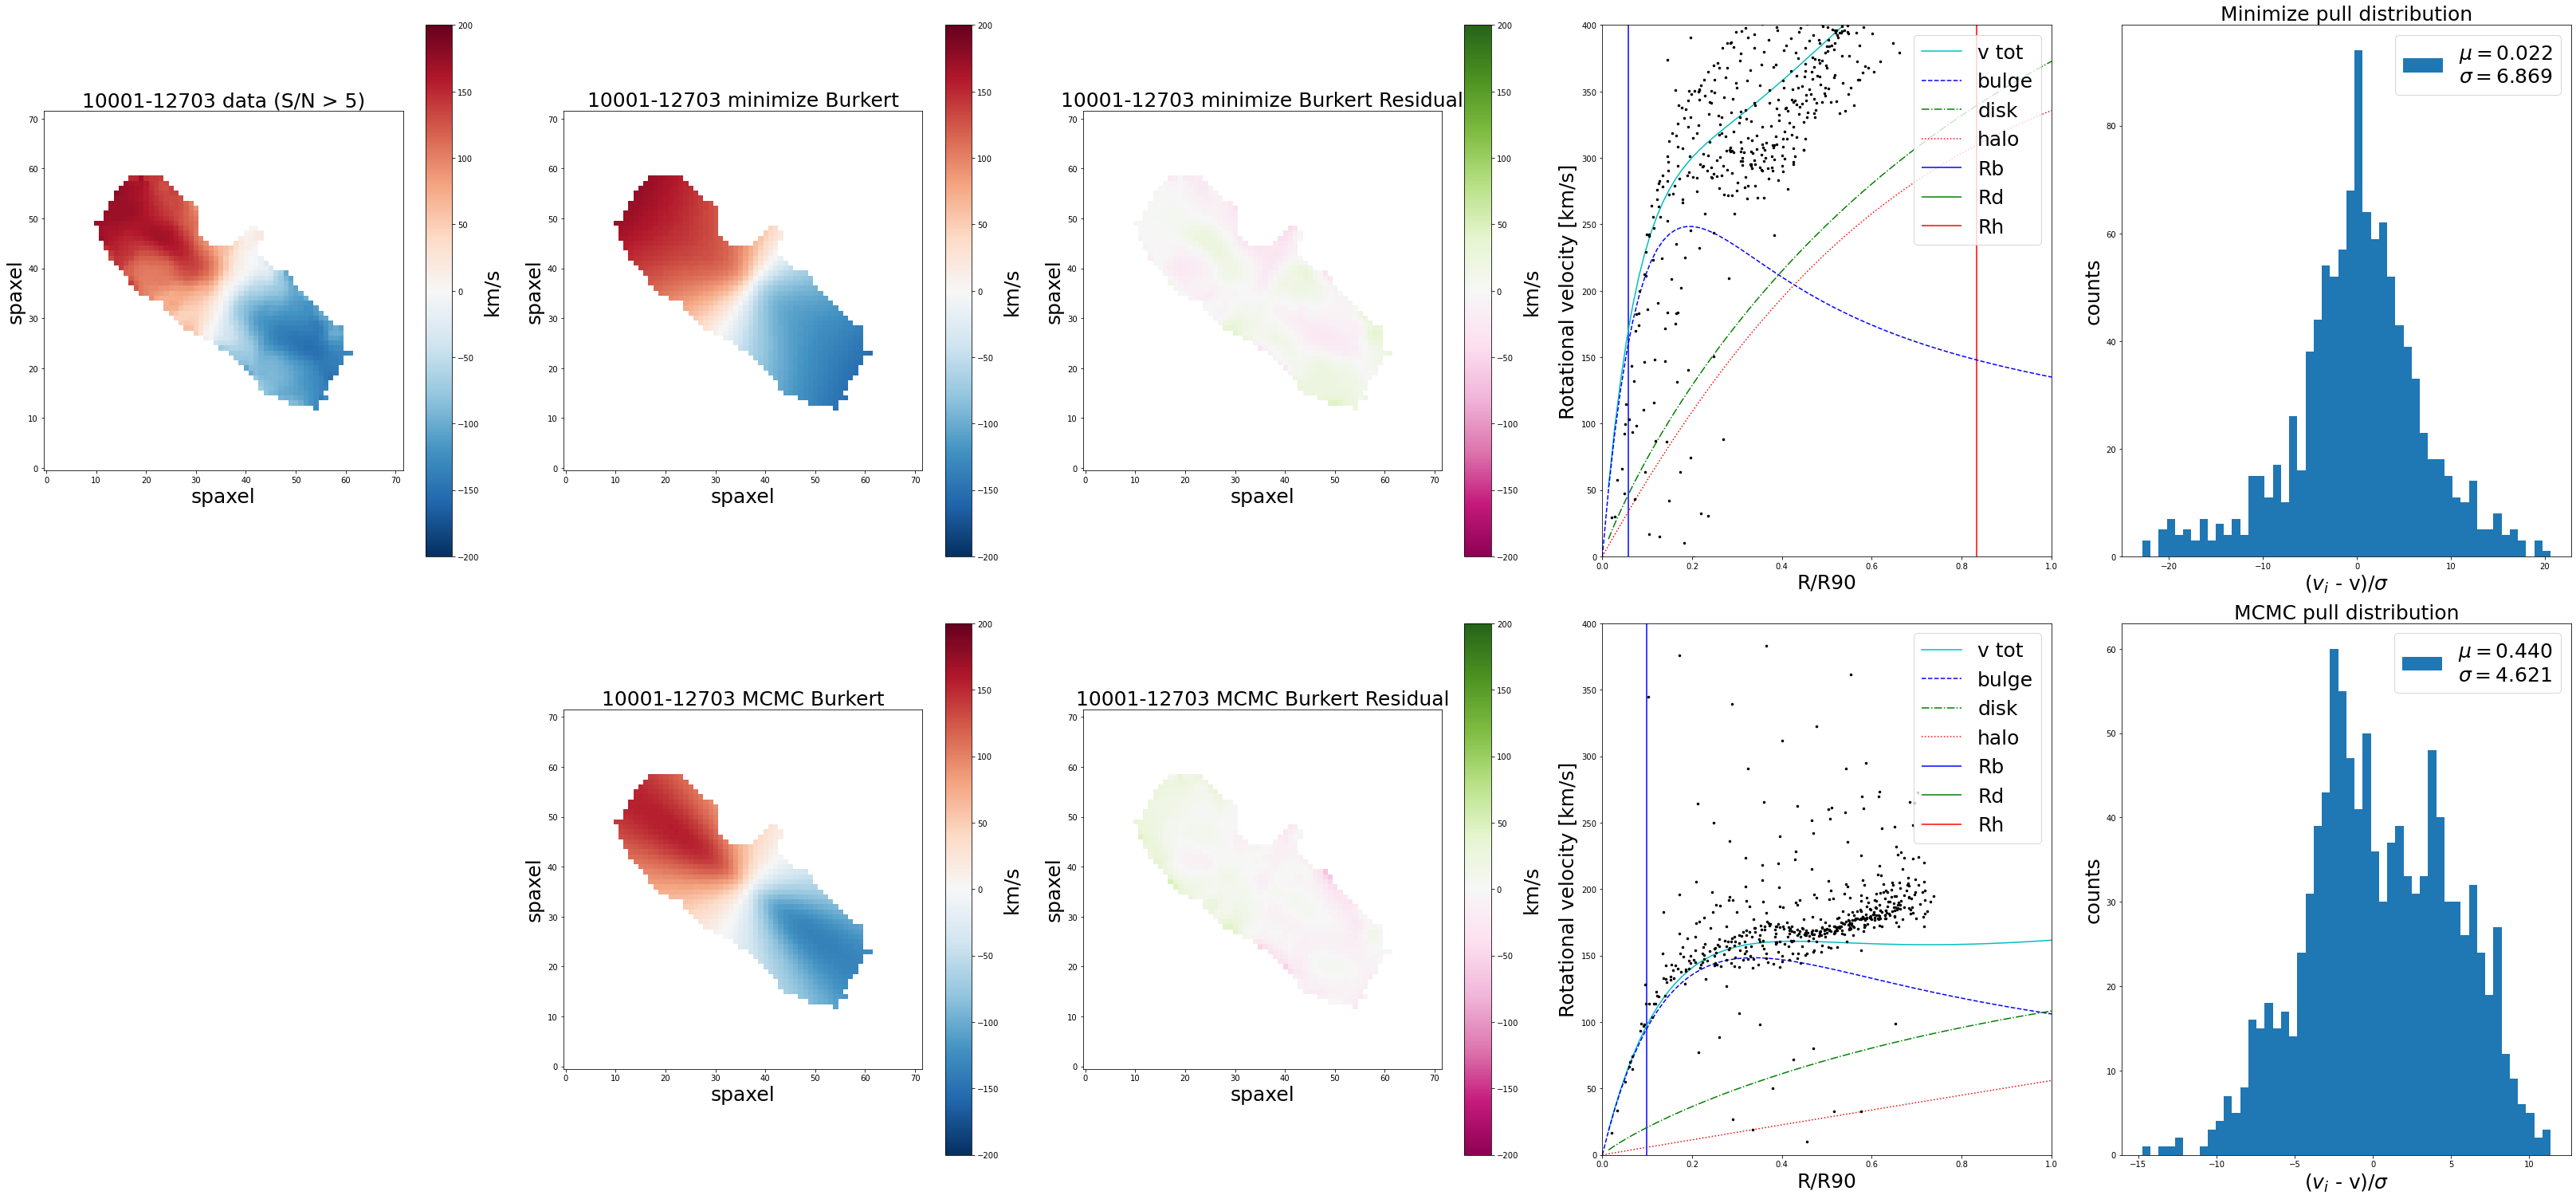

In [103]:
# Burkert - 10001-12703

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12703, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12703 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12703 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12703 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12703 - mini_map_10001_12703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12703 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12703 - mcmc_map_10001_12703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12703 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12703/r90_10001_12703, v_mini_10001_12703, 'c',label='v tot')
plt.plot(r_mini_10001_12703/r90_10001_12703, v_b_mini_10001_12703, 'b--',label='bulge')
plt.plot(r_mini_10001_12703/r90_10001_12703, v_d_mini_10001_12703,'g-.',label='disk')
plt.plot(r_mini_10001_12703/r90_10001_12703, v_h_mini_10001_12703,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12703[1]/r90_10001_12703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12703[3]/r90_10001_12703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12703[5]/r90_10001_12703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12703/r90_10001_12703, vm_deproj_mini_10001_12703, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12703/r90_10001_12703, v_mcmc_10001_12703, 'c',label='v tot')
plt.plot(r_mcmc_10001_12703/r90_10001_12703, v_b_mcmc_10001_12703, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12703/r90_10001_12703, v_d_mcmc_10001_12703,'g-.',label='disk')
plt.plot(r_mcmc_10001_12703/r90_10001_12703, v_h_mcmc_10001_12703,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12703))

plt.vlines(x = mcmc_fit_10001_12703[1]/r90_10001_12703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12703[3]/r90_10001_12703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12703[5]/r90_10001_12703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12703/r90_10001_12703, vm_deproj_mcmc_10001_12703, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10001_12703 = dmap_10001_12703 - mini_map_10001_12703

dist_minimize_Burkert_10001_12703 = residual_minimize_Burkert_10001_12703*np.sqrt(ivar_masked_10001_12703)

residual_mcmc_Burkert_10001_12703 = dmap_10001_12703 - mcmc_map_10001_12703

dist_mcmc_Burkert_10001_12703 = residual_mcmc_Burkert_10001_12703*np.sqrt(ivar_masked_10001_12703)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10001_12703 = ma.mean(dist_minimize_Burkert_10001_12703)
sig_mini_Burkert_10001_12703 = ma.std(dist_minimize_Burkert_10001_12703)

n_mini_Burkert_10001_12703, bins_mini_Burkert_10001_12703, patches_mini_Burkert_10001_12703 = plt.hist(dist_minimize_Burkert_10001_12703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10001_12703, sig_mini_Burkert_10001_12703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10001_12703 = ma.mean(dist_mcmc_Burkert_10001_12703)
sig_mcmc_Burkert_10001_12703 = ma.std(dist_mcmc_Burkert_10001_12703)

n_mcmc_Burkert_10001_12703, bins_mcmc_Burkert_10001_12703, patches_mcmc_Burkert_10001_12703 = plt.hist(dist_mcmc_Burkert_10001_12703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10001_12703, sig_mcmc_Burkert_10001_12703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12703))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12703))
print('r$R_{90}$: ' + str(r90_10001_12703) + ' kpc')
print('Incl from data: ' + str(incl_10001_12703))
print('Incl from Minimize: ' + str(mini_fit_10001_12703[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12703[-5]))

Minimize r$\chi^2$ : 34.84223032674354
MCMC r$\chi^2$ : 21.624362502324654
r$R_{90}$: 33.156402587890625 kpc
Incl from data: 1.4980049806928508
Incl from Minimize: 0.525174822348122
Incl from MCMC: 1.272843896557946


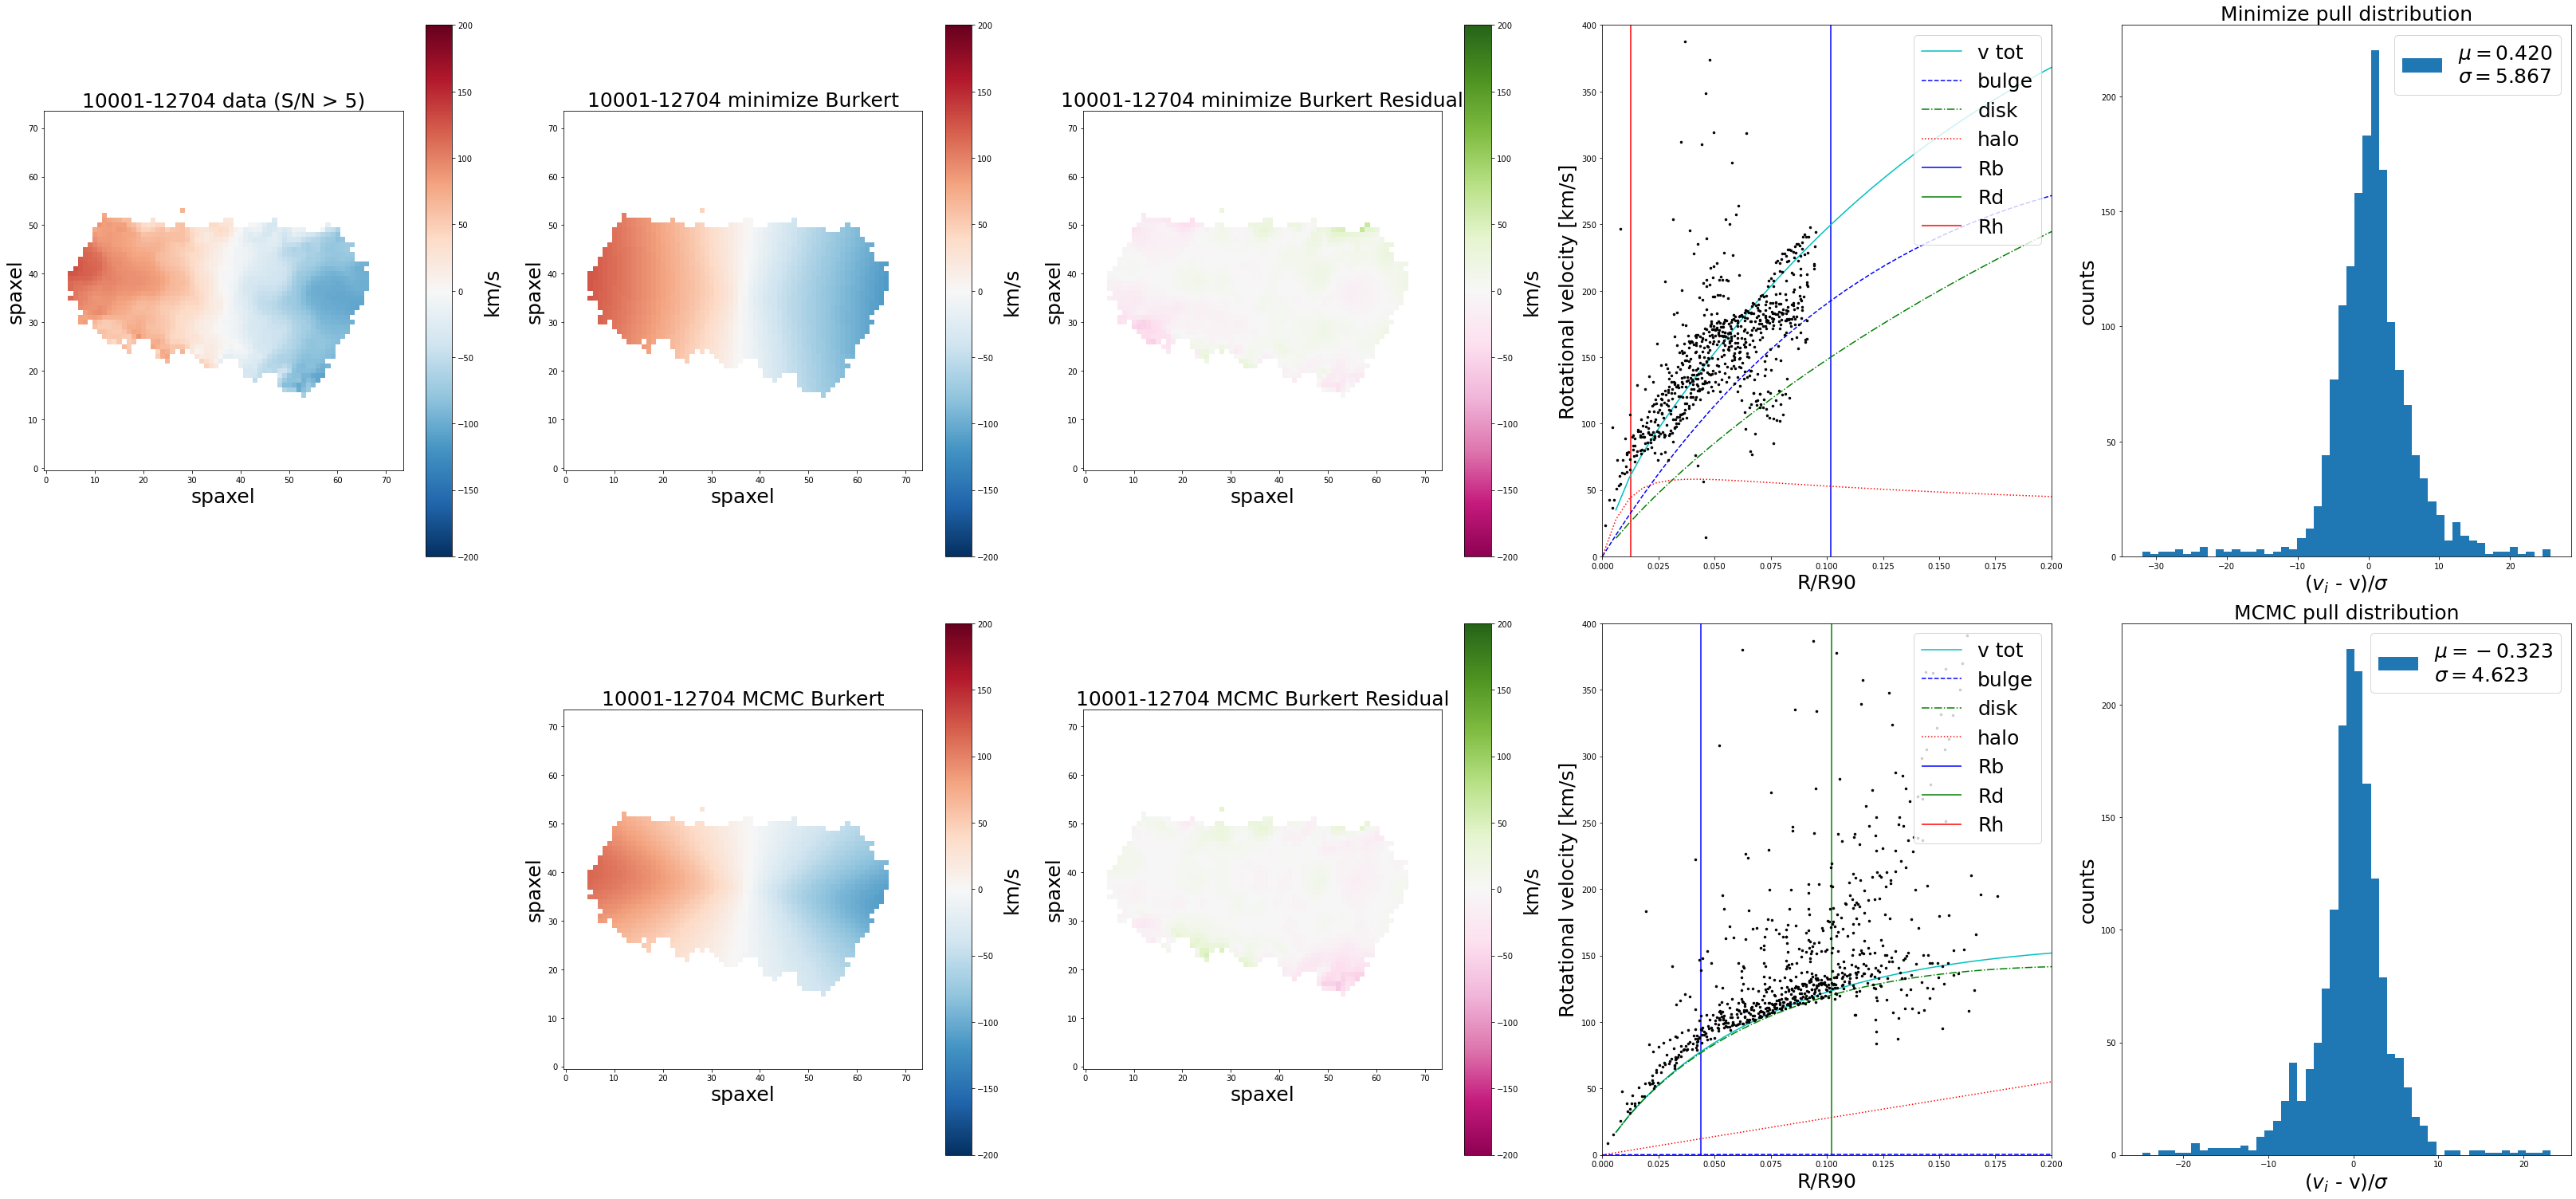

In [104]:
# Burkert - 10001-12704

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12704, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12704, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12704, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12704 - mini_map_10001_12704, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12704 - mcmc_map_10001_12704, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12704 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12704/r90_10001_12704, v_mini_10001_12704, 'c',label='v tot')
plt.plot(r_mini_10001_12704/r90_10001_12704, v_b_mini_10001_12704, 'b--',label='bulge')
plt.plot(r_mini_10001_12704/r90_10001_12704, v_d_mini_10001_12704,'g-.',label='disk')
plt.plot(r_mini_10001_12704/r90_10001_12704, v_h_mini_10001_12704,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12704[1]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12704[3]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12704[5]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12704/r90_10001_12704, vm_deproj_mini_10001_12704, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_mcmc_10001_12704, 'c',label='v tot')
plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_b_mcmc_10001_12704, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_d_mcmc_10001_12704,'g-.',label='disk')
plt.plot(r_mcmc_10001_12704/r90_10001_12704, v_h_mcmc_10001_12704,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12704))

plt.vlines(x = mcmc_fit_10001_12704[1]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12704[3]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12704[5]/r90_10001_12704,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12704/r90_10001_12704, vm_deproj_mcmc_10001_12704, 'k.', markersize=5)

plt.xlim([0,0.2])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10001_12704 = dmap_10001_12704 - mini_map_10001_12704

dist_minimize_Burkert_10001_12704 = residual_minimize_Burkert_10001_12704*np.sqrt(ivar_masked_10001_12704)

residual_mcmc_Burkert_10001_12704 = dmap_10001_12704 - mcmc_map_10001_12704

dist_mcmc_Burkert_10001_12704 = residual_mcmc_Burkert_10001_12704*np.sqrt(ivar_masked_10001_12704)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10001_12704 = ma.mean(dist_minimize_Burkert_10001_12704)
sig_mini_Burkert_10001_12704 = ma.std(dist_minimize_Burkert_10001_12704)

n_mini_Burkert_10001_12704, bins_mini_Burkert_10001_12704, patches_mini_Burkert_10001_12704 = plt.hist(dist_minimize_Burkert_10001_12704.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10001_12704, sig_mini_Burkert_10001_12704))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10001_12704 = ma.mean(dist_mcmc_Burkert_10001_12704)
sig_mcmc_Burkert_10001_12704 = ma.std(dist_mcmc_Burkert_10001_12704)

n_mcmc_Burkert_10001_12704, bins_mcmc_Burkert_10001_12704, patches_mcmc_Burkert_10001_12704 = plt.hist(dist_mcmc_Burkert_10001_12704.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10001_12704, sig_mcmc_Burkert_10001_12704))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12704))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12704))
print('r$R_{90}$: ' + str(r90_10001_12704) + ' kpc')
print('Incl from data: ' + str(incl_10001_12704))
print('Incl from Minimize: ' + str(mini_fit_10001_12704[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12704[-5]))

Minimize r$\chi^2$ : 9.615901437440336
MCMC r$\chi^2$ : 5.61945596812005
r$R_{90}$: 18.453237533569336 kpc
Incl from data: 1.1910581556463886
Incl from Minimize: 0.10005061058176165
Incl from MCMC: 1.0338574153651605


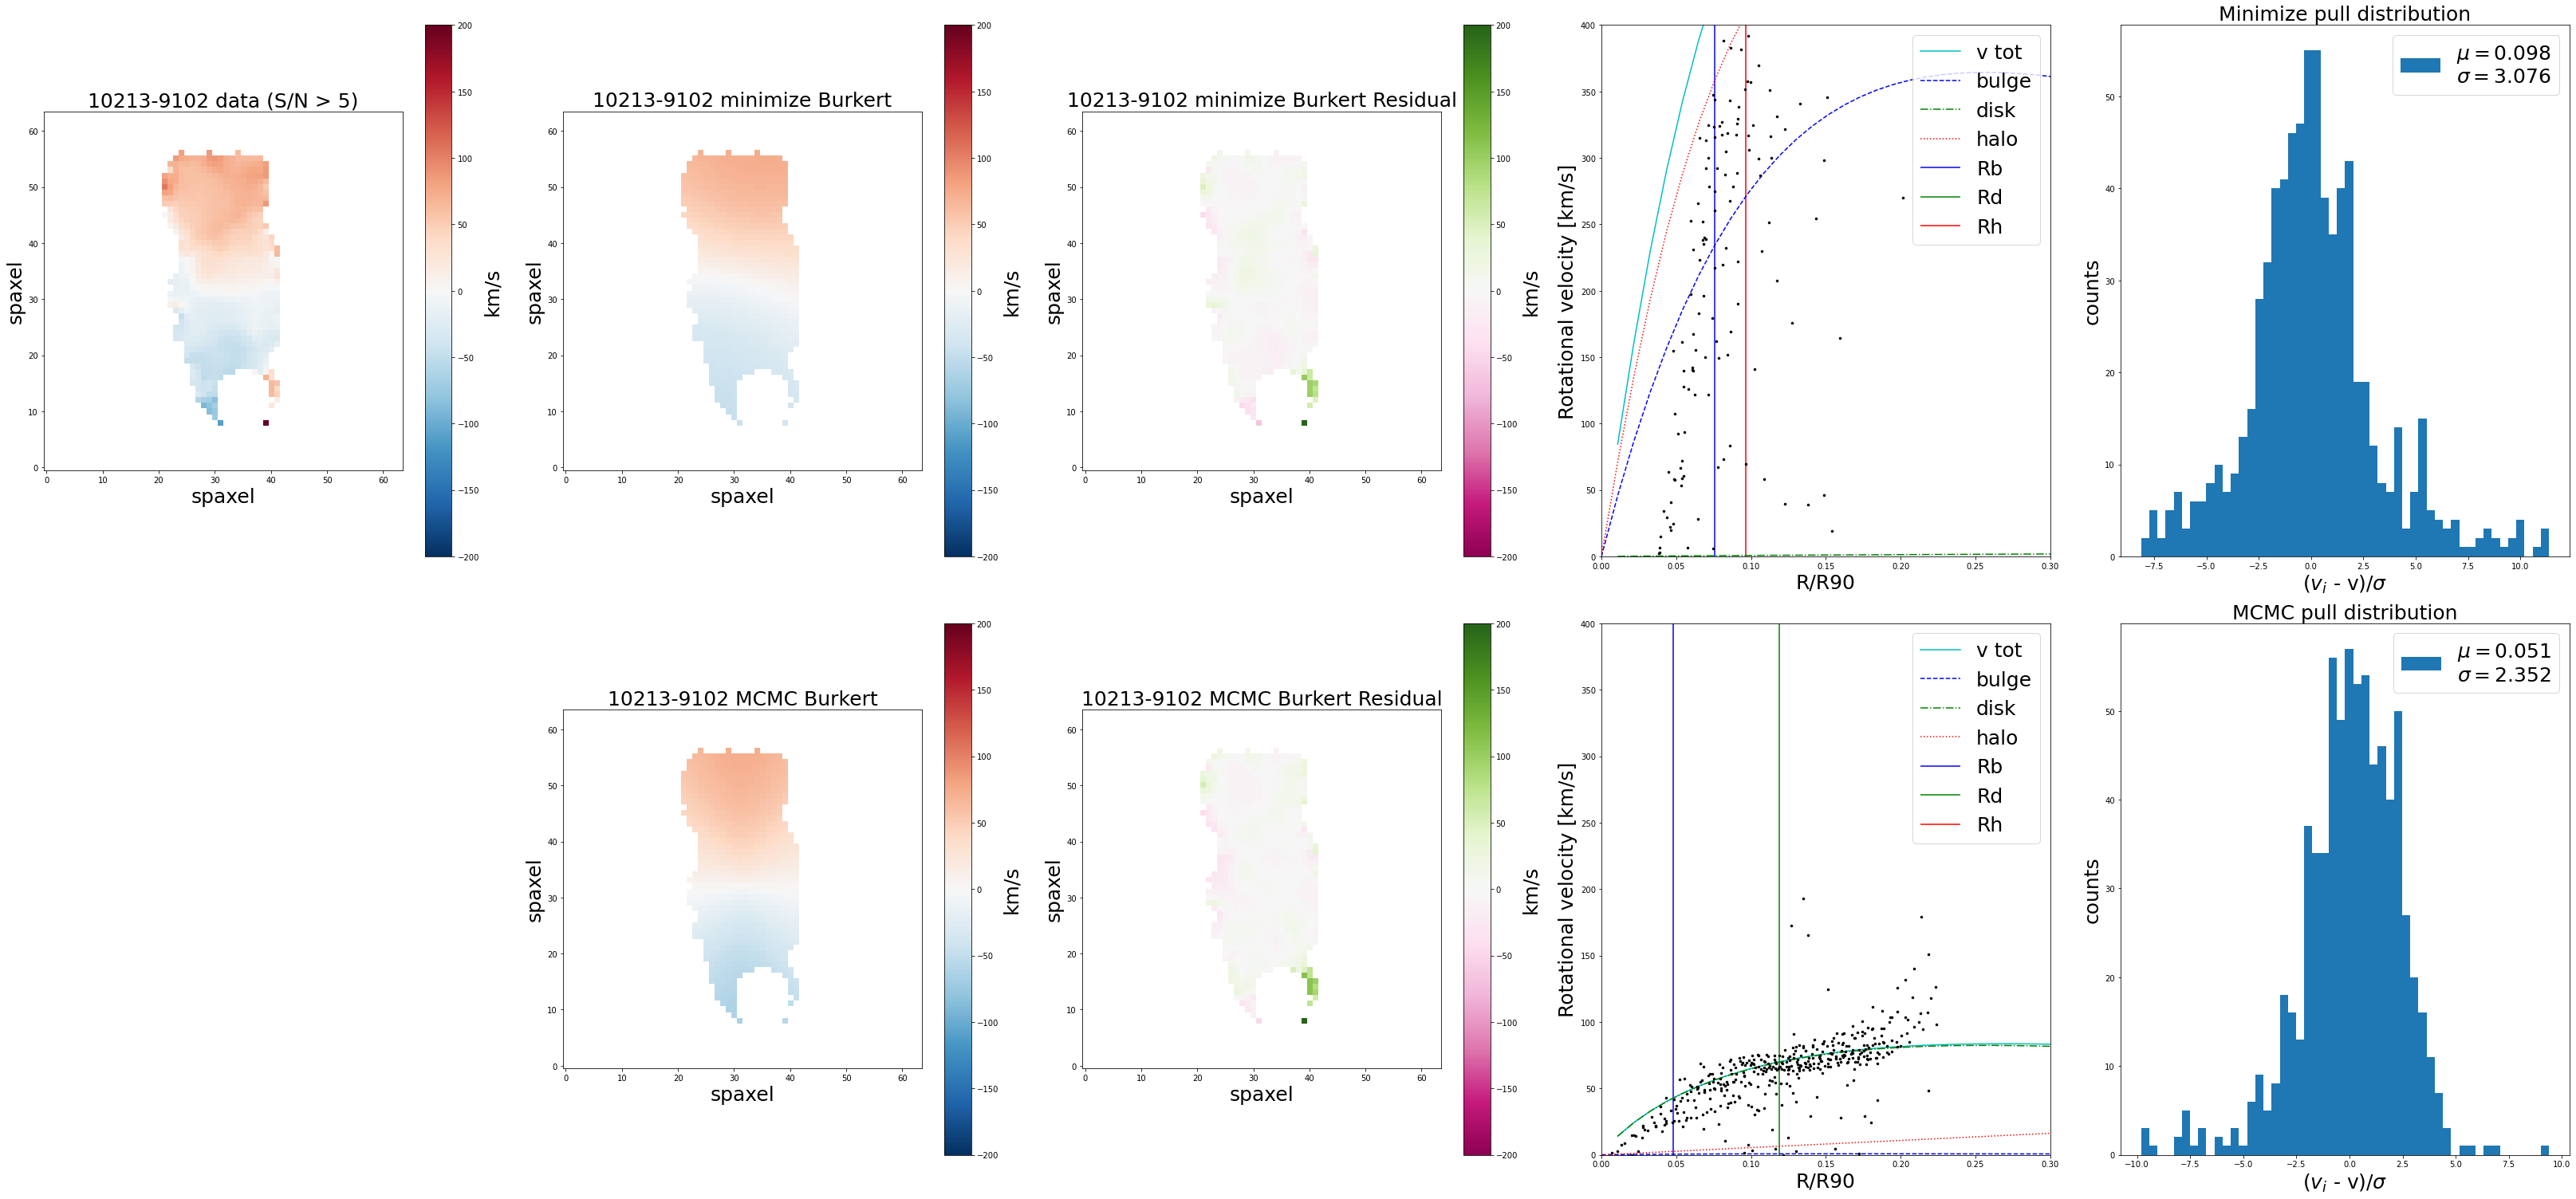

In [107]:
# Burkert - 10213-9102

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_9102, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-9102 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_9102, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-9102 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_9102, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-9102 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_9102 - mini_map_10213_9102, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-9102 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_9102 - mcmc_map_10213_9102, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-9102 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_9102/r90_10213_9102, v_mini_10213_9102, 'c',label='v tot')
plt.plot(r_mini_10213_9102/r90_10213_9102, v_b_mini_10213_9102, 'b--',label='bulge')
plt.plot(r_mini_10213_9102/r90_10213_9102, v_d_mini_10213_9102,'g-.',label='disk')
plt.plot(r_mini_10213_9102/r90_10213_9102, v_h_mini_10213_9102,'r:',label='halo')

plt.vlines(x = mini_fit_10213_9102[1]/r90_10213_9102,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_9102[3]/r90_10213_9102,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_9102[5]/r90_10213_9102,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_9102/r90_10213_9102, vm_deproj_mini_10213_9102, 'k.', markersize=5)

plt.xlim([0,0.3])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_9102/r90_10213_9102, v_mcmc_10213_9102, 'c',label='v tot')
plt.plot(r_mcmc_10213_9102/r90_10213_9102, v_b_mcmc_10213_9102, 'b--',label='bulge')
plt.plot(r_mcmc_10213_9102/r90_10213_9102, v_d_mcmc_10213_9102,'g-.',label='disk')
plt.plot(r_mcmc_10213_9102/r90_10213_9102, v_h_mcmc_10213_9102,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_9102))

plt.vlines(x = mcmc_fit_10213_9102[1]/r90_10213_9102,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_9102[3]/r90_10213_9102,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_9102[5]/r90_10213_9102,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_9102/r90_10213_9102, vm_deproj_mcmc_10213_9102, 'k.', markersize=5)

plt.xlim([0,0.3])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10213_9102 = dmap_10213_9102 - mini_map_10213_9102

dist_minimize_Burkert_10213_9102 = residual_minimize_Burkert_10213_9102*np.sqrt(ivar_masked_10213_9102)

residual_mcmc_Burkert_10213_9102 = dmap_10213_9102 - mcmc_map_10213_9102

dist_mcmc_Burkert_10213_9102 = residual_mcmc_Burkert_10213_9102*np.sqrt(ivar_masked_10213_9102)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10213_9102 = ma.mean(dist_minimize_Burkert_10213_9102)
sig_mini_Burkert_10213_9102 = ma.std(dist_minimize_Burkert_10213_9102)

n_mini_Burkert_10213_9102, bins_mini_Burkert_10213_9102, patches_mini_Burkert_10213_9102 = plt.hist(dist_minimize_Burkert_10213_9102.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10213_9102, sig_mini_Burkert_10213_9102))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10213_9102 = ma.mean(dist_mcmc_Burkert_10213_9102)
sig_mcmc_Burkert_10213_9102 = ma.std(dist_mcmc_Burkert_10213_9102)

n_mcmc_Burkert_10213_9102, bins_mcmc_Burkert_10213_9102, patches_mcmc_Burkert_10213_9102 = plt.hist(dist_mcmc_Burkert_10213_9102.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10213_9102, sig_mcmc_Burkert_10213_9102))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_9102))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_9102))
print('r$R_{90}$: ' + str(r90_10213_9102) + ' kpc')
print('Incl from data: ' + str(incl_10213_9102))
print('Incl from Minimize: ' + str(mini_fit_10213_9102[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_9102[-5]))

Minimize r$\chi^2$ : 23.726881149538094
MCMC r$\chi^2$ : 9.737635076168571
r$R_{90}$: 29.03072166442871 kpc
Incl from data: 1.3373513853651993
Incl from Minimize: 0.5856125682187421
Incl from MCMC: 1.2614430140797768


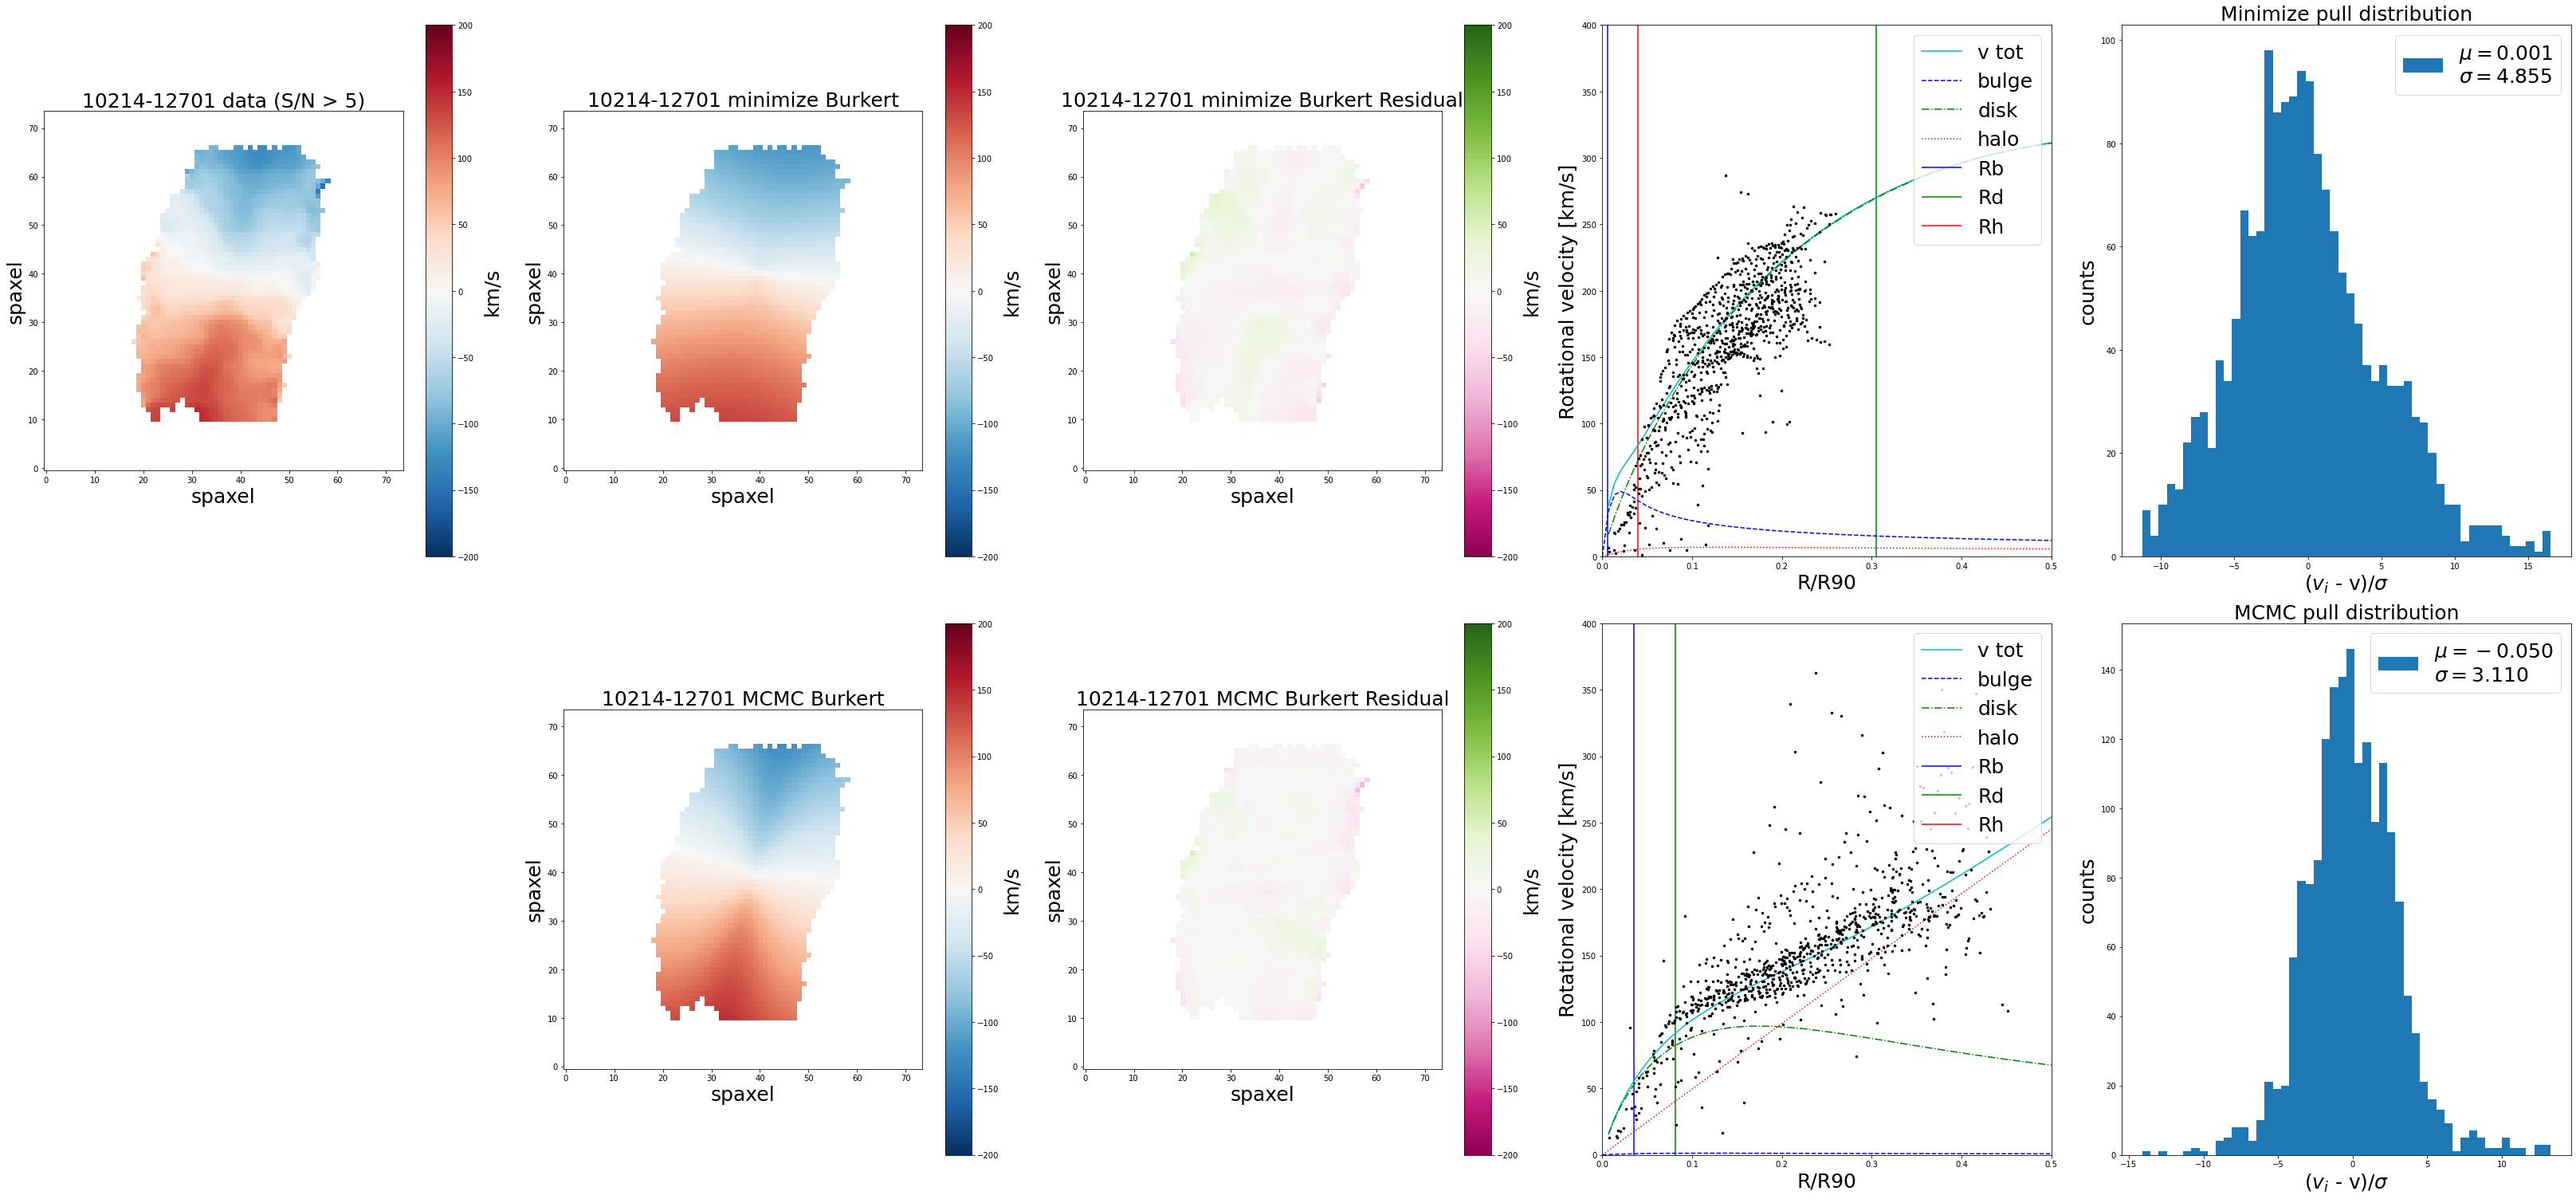

In [109]:
# Burkert - 10214-12701

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10214_12701, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10214-12701 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10214_12701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10214-12701 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10214_12701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10214-12701 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10214_12701 - mini_map_10214_12701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10214-12701 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10214_12701 - mcmc_map_10214_12701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10214-12701 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10214_12701/r90_10214_12701, v_mini_10214_12701, 'c',label='v tot')
plt.plot(r_mini_10214_12701/r90_10214_12701, v_b_mini_10214_12701, 'b--',label='bulge')
plt.plot(r_mini_10214_12701/r90_10214_12701, v_d_mini_10214_12701,'g-.',label='disk')
plt.plot(r_mini_10214_12701/r90_10214_12701, v_h_mini_10214_12701,'r:',label='halo')

plt.vlines(x = mini_fit_10214_12701[1]/r90_10214_12701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10214_12701[3]/r90_10214_12701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10214_12701[5]/r90_10214_12701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10214_12701/r90_10214_12701, vm_deproj_mini_10214_12701, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10214_12701/r90_10214_12701, v_mcmc_10214_12701, 'c',label='v tot')
plt.plot(r_mcmc_10214_12701/r90_10214_12701, v_b_mcmc_10214_12701, 'b--',label='bulge')
plt.plot(r_mcmc_10214_12701/r90_10214_12701, v_d_mcmc_10214_12701,'g-.',label='disk')
plt.plot(r_mcmc_10214_12701/r90_10214_12701, v_h_mcmc_10214_12701,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10214_12701))

plt.vlines(x = mcmc_fit_10214_12701[1]/r90_10214_12701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10214_12701[3]/r90_10214_12701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10214_12701[5]/r90_10214_12701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10214_12701/r90_10214_12701, vm_deproj_mcmc_10214_12701, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10214_12701 = dmap_10214_12701 - mini_map_10214_12701

dist_minimize_Burkert_10214_12701 = residual_minimize_Burkert_10214_12701*np.sqrt(ivar_masked_10214_12701)

residual_mcmc_Burkert_10214_12701 = dmap_10214_12701 - mcmc_map_10214_12701

dist_mcmc_Burkert_10214_12701 = residual_mcmc_Burkert_10214_12701*np.sqrt(ivar_masked_10214_12701)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10214_12701 = ma.mean(dist_minimize_Burkert_10214_12701)
sig_mini_Burkert_10214_12701 = ma.std(dist_minimize_Burkert_10214_12701)

n_mini_Burkert_10214_12701, bins_mini_Burkert_10214_12701, patches_mini_Burkert_10214_12701 = plt.hist(dist_minimize_Burkert_10214_12701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10214_12701, sig_mini_Burkert_10214_12701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10214_12701 = ma.mean(dist_mcmc_Burkert_10214_12701)
sig_mcmc_Burkert_10214_12701 = ma.std(dist_mcmc_Burkert_10214_12701)

n_mcmc_Burkert_10214_12701, bins_mcmc_Burkert_10214_12701, patches_mcmc_Burkert_10214_12701 = plt.hist(dist_mcmc_Burkert_10214_12701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10214_12701, sig_mcmc_Burkert_10214_12701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10214_12701))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10214_12701))
print('r$R_{90}$: ' + str(r90_10214_12701) + ' kpc')
print('Incl from data: ' + str(incl_10214_12701))
print('Incl from Minimize: ' + str(mini_fit_10214_12701[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10214_12701[-5]))

Minimize r$\chi^2$ : 33.89159086768261
MCMC r$\chi^2$ : 549.7329836791012
r$R_{90}$: 9.852487564086914 kpc
Incl from data: 1.188050654078803
Incl from Minimize: 0.3070733716804449
Incl from MCMC: 0.3391401948661564


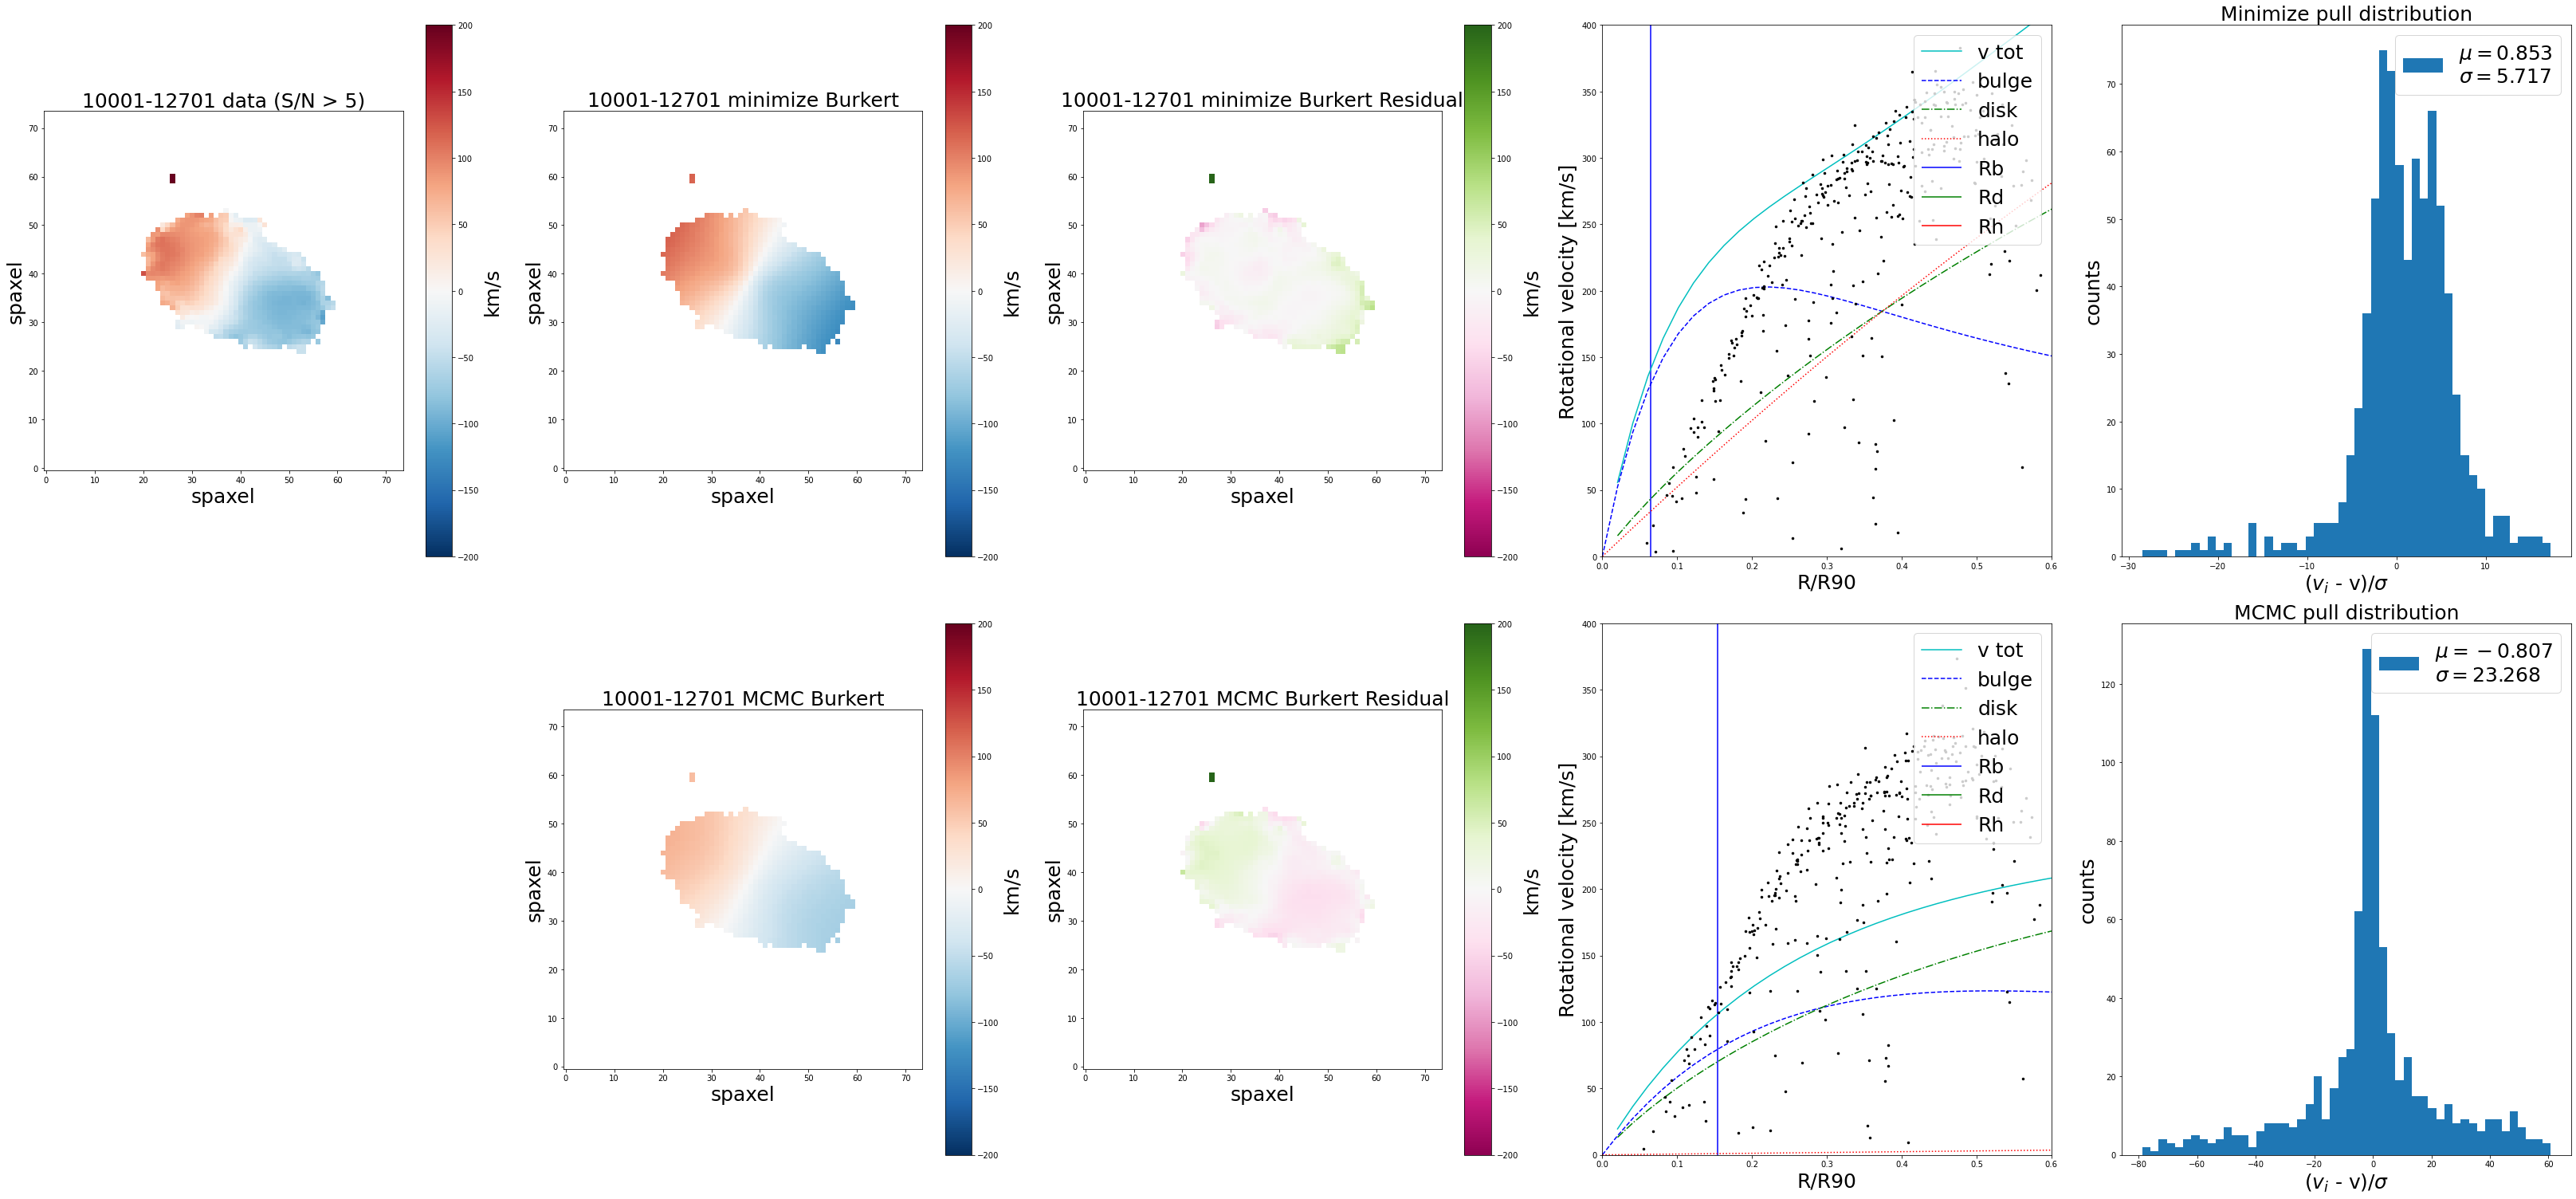

In [112]:
# Burkert - 10001-12701

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10001_12701, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10001_12701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10001_12701, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10001_12701 - mini_map_10001_12701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10001_12701 - mcmc_map_10001_12701, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10001-12701 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10001_12701/r90_10001_12701, v_mini_10001_12701, 'c',label='v tot')
plt.plot(r_mini_10001_12701/r90_10001_12701, v_b_mini_10001_12701, 'b--',label='bulge')
plt.plot(r_mini_10001_12701/r90_10001_12701, v_d_mini_10001_12701,'g-.',label='disk')
plt.plot(r_mini_10001_12701/r90_10001_12701, v_h_mini_10001_12701,'r:',label='halo')

plt.vlines(x = mini_fit_10001_12701[1]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10001_12701[3]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10001_12701[5]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10001_12701/r90_10001_12701, vm_deproj_mini_10001_12701, 'k.', markersize=5)

plt.xlim([0,0.6])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_mcmc_10001_12701, 'c',label='v tot')
plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_b_mcmc_10001_12701, 'b--',label='bulge')
plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_d_mcmc_10001_12701,'g-.',label='disk')
plt.plot(r_mcmc_10001_12701/r90_10001_12701, v_h_mcmc_10001_12701,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10001_12701))

plt.vlines(x = mcmc_fit_10001_12701[1]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10001_12701[3]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10001_12701[5]/r90_10001_12701,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10001_12701/r90_10001_12701, vm_deproj_mcmc_10001_12701, 'k.', markersize=5)

plt.xlim([0,0.6])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10001_12701 = dmap_10001_12701 - mini_map_10001_12701

dist_minimize_Burkert_10001_12701 = residual_minimize_Burkert_10001_12701*np.sqrt(ivar_masked_10001_12701)

residual_mcmc_Burkert_10001_12701 = dmap_10001_12701 - mcmc_map_10001_12701

dist_mcmc_Burkert_10001_12701 = residual_mcmc_Burkert_10001_12701*np.sqrt(ivar_masked_10001_12701)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10001_12701 = ma.mean(dist_minimize_Burkert_10001_12701)
sig_mini_Burkert_10001_12701 = ma.std(dist_minimize_Burkert_10001_12701)

n_mini_Burkert_10001_12701, bins_mini_Burkert_10001_12701, patches_mini_Burkert_10001_12701 = plt.hist(dist_minimize_Burkert_10001_12701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10001_12701, sig_mini_Burkert_10001_12701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10001_12701 = ma.mean(dist_mcmc_Burkert_10001_12701)
sig_mcmc_Burkert_10001_12701 = ma.std(dist_mcmc_Burkert_10001_12701)

n_mcmc_Burkert_10001_12701, bins_mcmc_Burkert_10001_12701, patches_mcmc_Burkert_10001_12701 = plt.hist(dist_mcmc_Burkert_10001_12701.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10001_12701, sig_mcmc_Burkert_10001_12701))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10001_12701))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10001_12701))
print('r$R_{90}$: ' + str(r90_10001_12701) + ' kpc')
print('Incl from data: ' + str(incl_10001_12701))
print('Incl from Minimize: ' + str(mini_fit_10001_12701[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10001_12701[-5]))

Minimize r$\chi^2$ : 36.80957062690685
MCMC r$\chi^2$ : 359.00298441837293
r$R_{90}$: 24.491958618164062 kpc
Incl from data: 0.8376916908679872
Incl from Minimize: 0.11838593988529417
Incl from MCMC: 1.2032304395503124


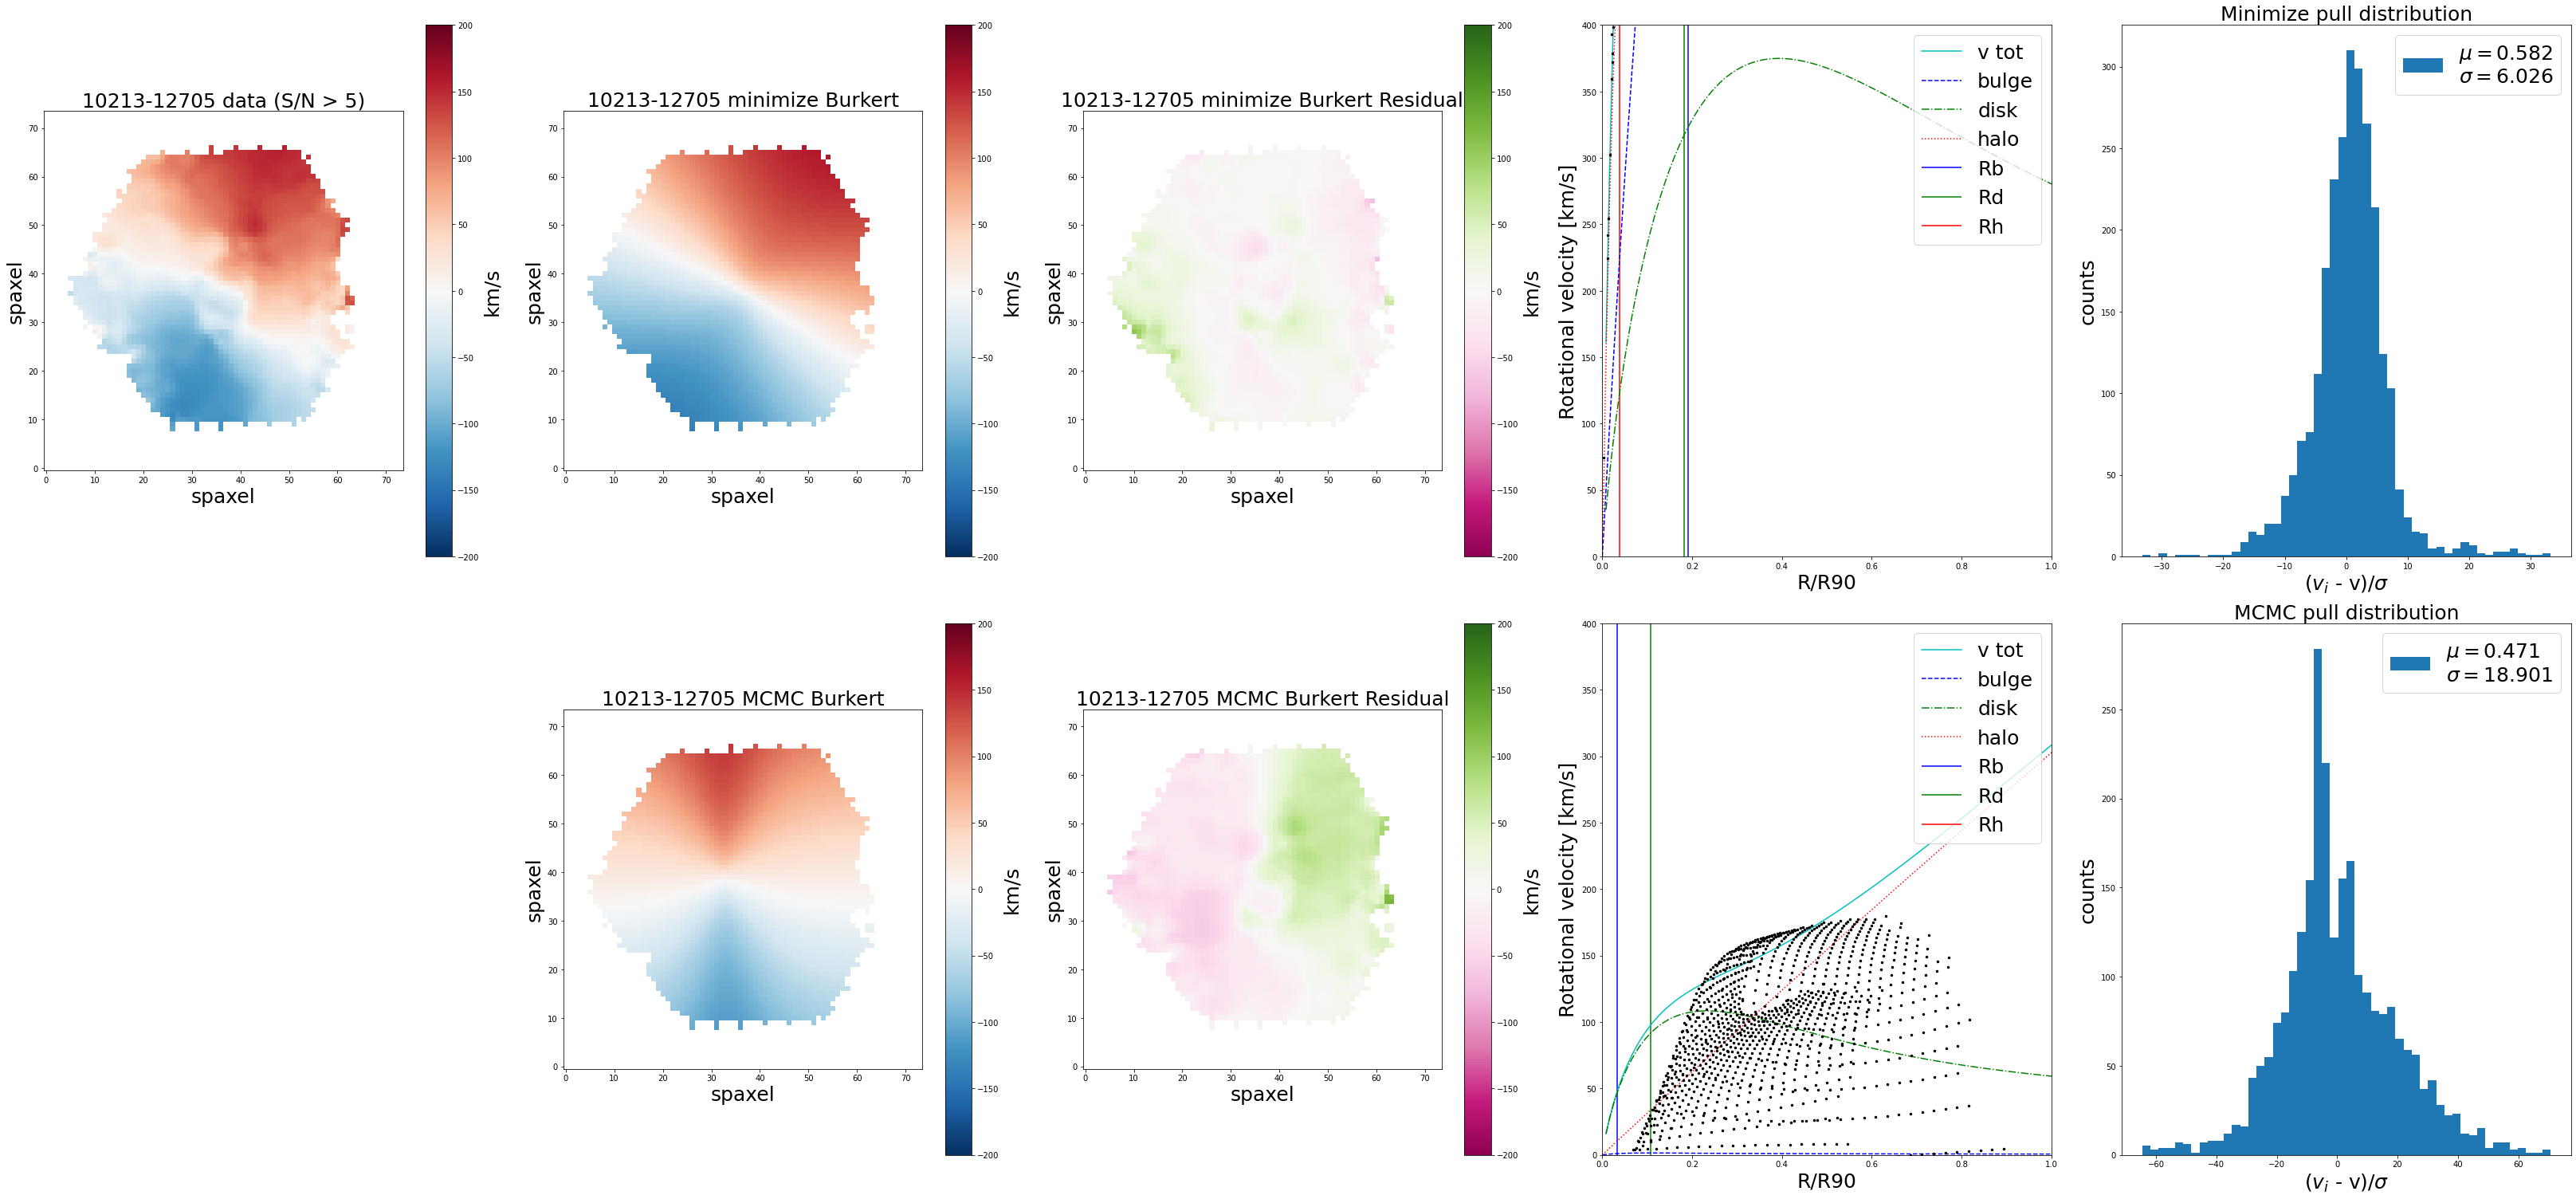

In [114]:
# Burkert - 10213-12705

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_12705, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_12705, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_12705 - mini_map_10213_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_12705 - mcmc_map_10213_12705, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-12705 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_12705/r90_10213_12705, v_mini_10213_12705, 'c',label='v tot')
plt.plot(r_mini_10213_12705/r90_10213_12705, v_b_mini_10213_12705, 'b--',label='bulge')
plt.plot(r_mini_10213_12705/r90_10213_12705, v_d_mini_10213_12705,'g-.',label='disk')
plt.plot(r_mini_10213_12705/r90_10213_12705, v_h_mini_10213_12705,'r:',label='halo')

plt.vlines(x = mini_fit_10213_12705[1]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_12705[3]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_12705[5]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_12705/r90_10213_12705, vm_deproj_mini_10213_12705, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_mcmc_10213_12705, 'c',label='v tot')
plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_b_mcmc_10213_12705, 'b--',label='bulge')
plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_d_mcmc_10213_12705,'g-.',label='disk')
plt.plot(r_mcmc_10213_12705/r90_10213_12705, v_h_mcmc_10213_12705,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_12705))

plt.vlines(x = mcmc_fit_10213_12705[1]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_12705[3]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_12705[5]/r90_10213_12705,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_12705/r90_10213_12705, vm_deproj_mcmc_10213_12705, 'k.', markersize=5)

plt.xlim([0,1])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10213_12705 = dmap_10213_12705 - mini_map_10213_12705

dist_minimize_Burkert_10213_12705 = residual_minimize_Burkert_10213_12705*np.sqrt(ivar_masked_10213_12705)

residual_mcmc_Burkert_10213_12705 = dmap_10213_12705 - mcmc_map_10213_12705

dist_mcmc_Burkert_10213_12705 = residual_mcmc_Burkert_10213_12705*np.sqrt(ivar_masked_10213_12705)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10213_12705 = ma.mean(dist_minimize_Burkert_10213_12705)
sig_mini_Burkert_10213_12705 = ma.std(dist_minimize_Burkert_10213_12705)

n_mini_Burkert_10213_12705, bins_mini_Burkert_10213_12705, patches_mini_Burkert_10213_12705 = plt.hist(dist_minimize_Burkert_10213_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10213_12705, sig_mini_Burkert_10213_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10213_12705 = ma.mean(dist_mcmc_Burkert_10213_12705)
sig_mcmc_Burkert_10213_12705 = ma.std(dist_mcmc_Burkert_10213_12705)

n_mcmc_Burkert_10213_12705, bins_mcmc_Burkert_10213_12705, patches_mcmc_Burkert_10213_12705 = plt.hist(dist_mcmc_Burkert_10213_12705.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10213_12705, sig_mcmc_Burkert_10213_12705))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_12705))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_12705))
print('r$R_{90}$: ' + str(r90_10213_12705) + ' kpc')
print('Incl from data: ' + str(incl_10213_12705))
print('Incl from Minimize: ' + str(mini_fit_10213_12705[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_12705[-5]))

Minimize r$\chi^2$ : 141.21477296781882
MCMC r$\chi^2$ : 545.0470153367393
r$R_{90}$: 19.216617584228516 kpc
Incl from data: 0.8194036311077326
Incl from Minimize: 0.12732175873875404
Incl from MCMC: 0.7715271597519805


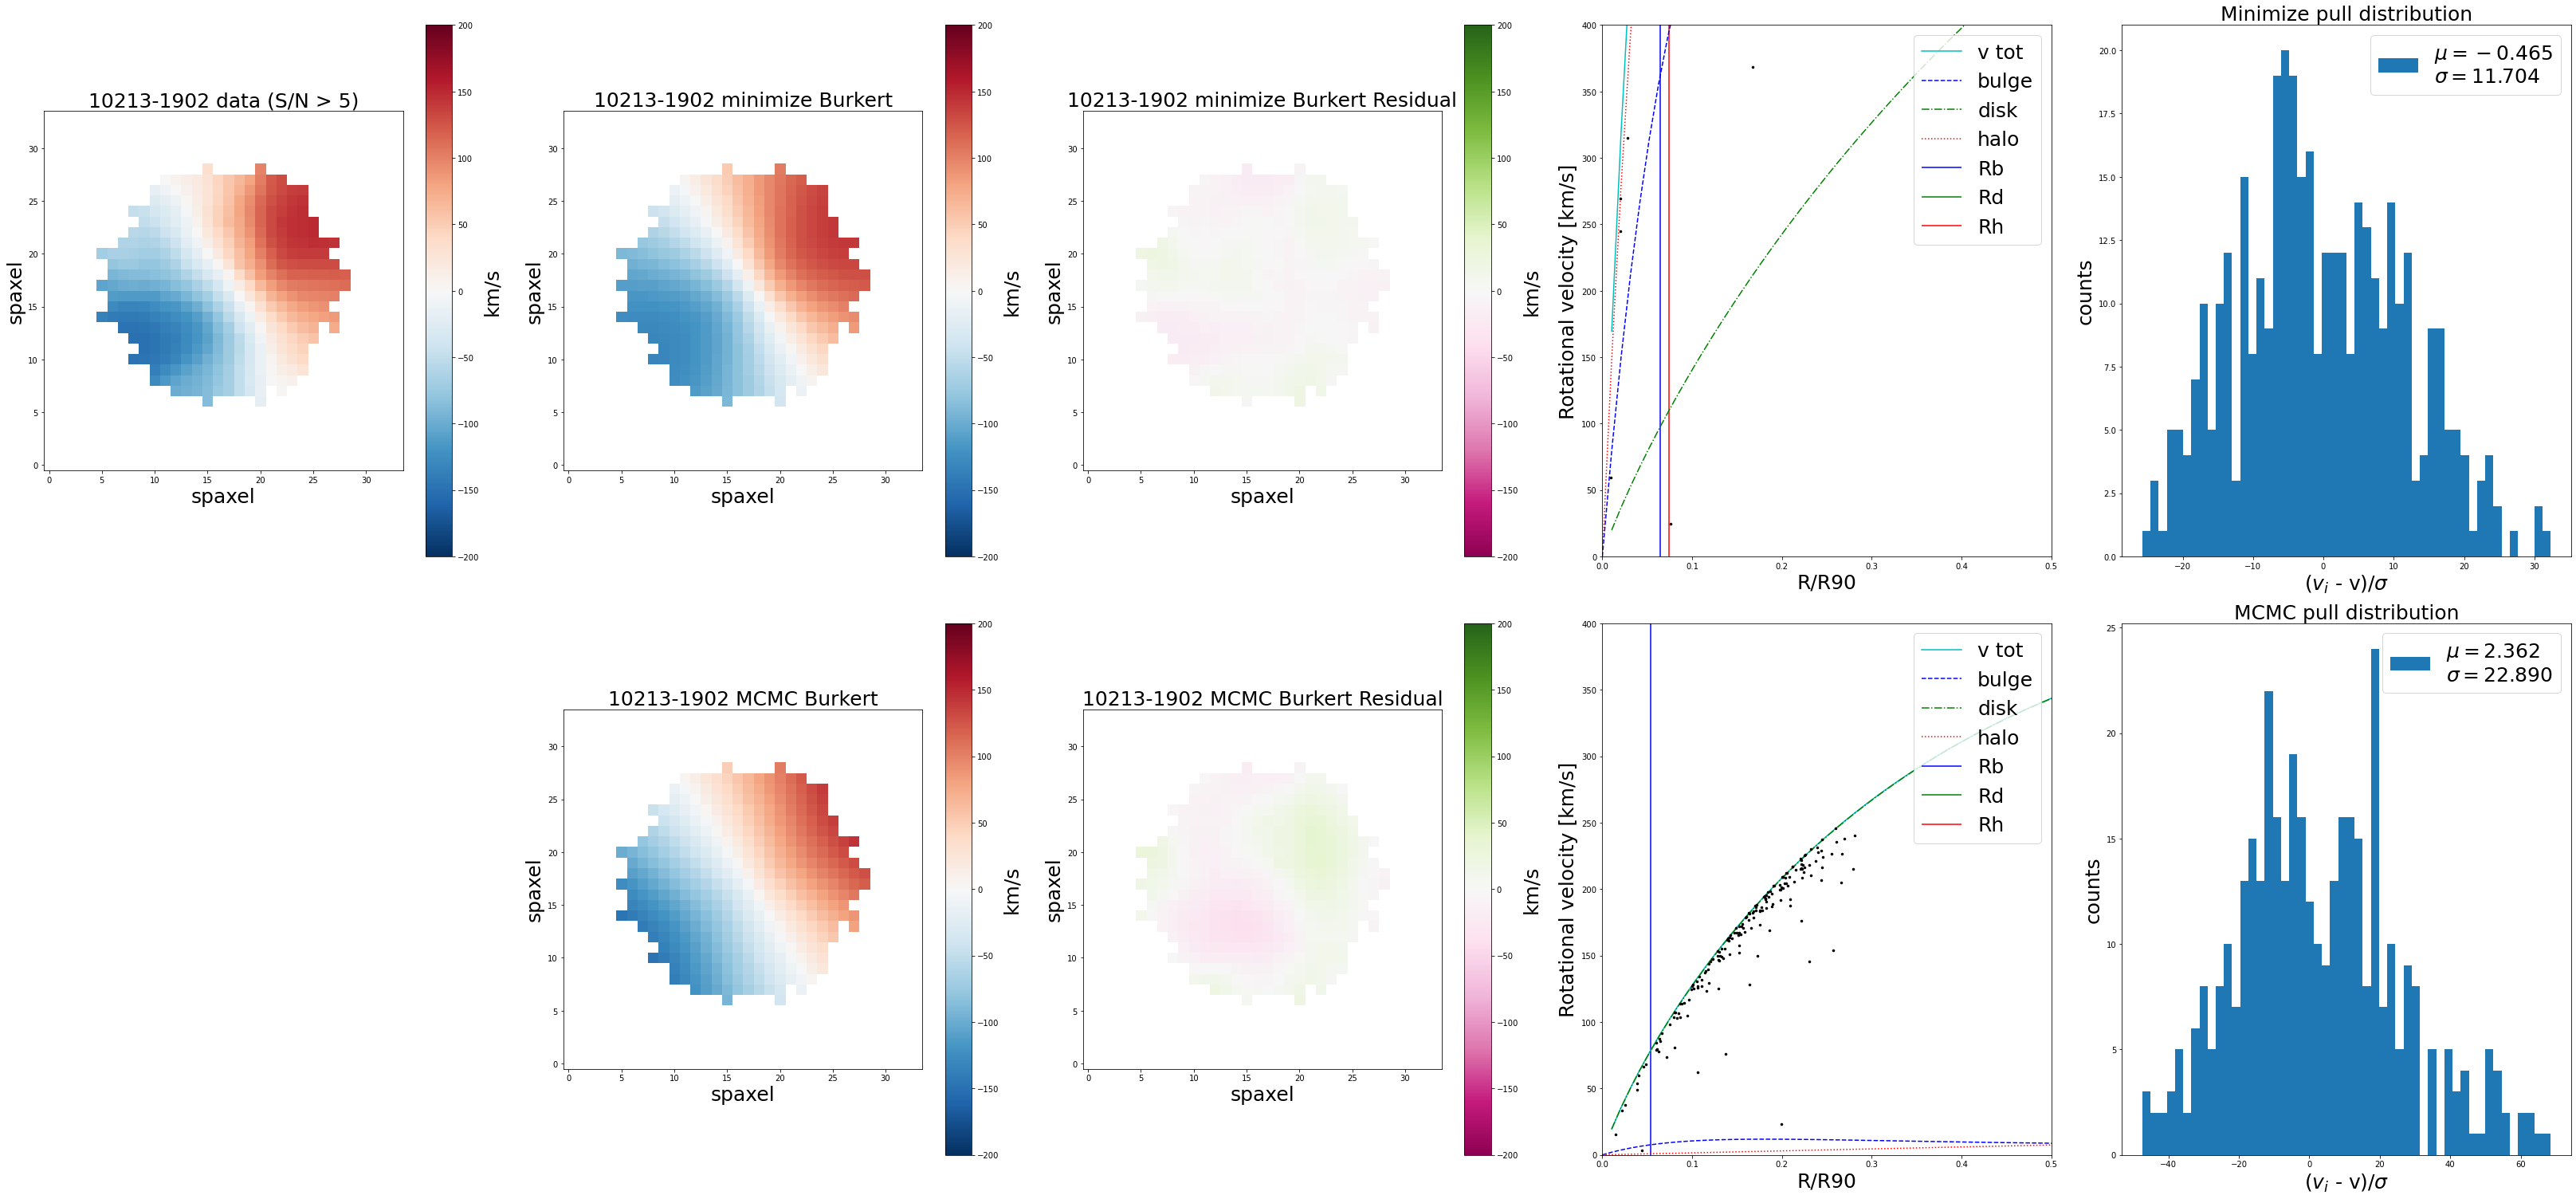

In [117]:
# Burkert - 10213-1902

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10213_1902, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-1902 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10213_1902, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-1902 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10213_1902, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-1902 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10213_1902 - mini_map_10213_1902, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-1902 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10213_1902 - mcmc_map_10213_1902, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10213-1902 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10213_1902/r90_10213_1902, v_mini_10213_1902, 'c',label='v tot')
plt.plot(r_mini_10213_1902/r90_10213_1902, v_b_mini_10213_1902, 'b--',label='bulge')
plt.plot(r_mini_10213_1902/r90_10213_1902, v_d_mini_10213_1902,'g-.',label='disk')
plt.plot(r_mini_10213_1902/r90_10213_1902, v_h_mini_10213_1902,'r:',label='halo')

plt.vlines(x = mini_fit_10213_1902[1]/r90_10213_1902,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10213_1902[3]/r90_10213_1902,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10213_1902[5]/r90_10213_1902,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10213_1902/r90_10213_1902, vm_deproj_mini_10213_1902, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10213_1902/r90_10213_1902, v_mcmc_10213_1902, 'c',label='v tot')
plt.plot(r_mcmc_10213_1902/r90_10213_1902, v_b_mcmc_10213_1902, 'b--',label='bulge')
plt.plot(r_mcmc_10213_1902/r90_10213_1902, v_d_mcmc_10213_1902,'g-.',label='disk')
plt.plot(r_mcmc_10213_1902/r90_10213_1902, v_h_mcmc_10213_1902,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10213_1902))

plt.vlines(x = mcmc_fit_10213_1902[1]/r90_10213_1902,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10213_1902[3]/r90_10213_1902,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10213_1902[5]/r90_10213_1902,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10213_1902/r90_10213_1902, vm_deproj_mcmc_10213_1902, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10213_1902 = dmap_10213_1902 - mini_map_10213_1902

dist_minimize_Burkert_10213_1902 = residual_minimize_Burkert_10213_1902*np.sqrt(ivar_masked_10213_1902)

residual_mcmc_Burkert_10213_1902 = dmap_10213_1902 - mcmc_map_10213_1902

dist_mcmc_Burkert_10213_1902 = residual_mcmc_Burkert_10213_1902*np.sqrt(ivar_masked_10213_1902)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10213_1902 = ma.mean(dist_minimize_Burkert_10213_1902)
sig_mini_Burkert_10213_1902 = ma.std(dist_minimize_Burkert_10213_1902)

n_mini_Burkert_10213_1902, bins_mini_Burkert_10213_1902, patches_mini_Burkert_10213_1902 = plt.hist(dist_minimize_Burkert_10213_1902.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10213_1902, sig_mini_Burkert_10213_1902))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10213_1902 = ma.mean(dist_mcmc_Burkert_10213_1902)
sig_mcmc_Burkert_10213_1902 = ma.std(dist_mcmc_Burkert_10213_1902)

n_mcmc_Burkert_10213_1902, bins_mcmc_Burkert_10213_1902, patches_mcmc_Burkert_10213_1902 = plt.hist(dist_mcmc_Burkert_10213_1902.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10213_1902, sig_mcmc_Burkert_10213_1902))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10213_1902))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10213_1902))
print('r$R_{90}$: ' + str(r90_10213_1902) + ' kpc')
print('Incl from data: ' + str(incl_10213_1902))
print('Incl from Minimize: ' + str(mini_fit_10213_1902[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10213_1902[-5]))

Minimize r$\chi^2$ : 108.55919274180117
MCMC r$\chi^2$ : 1848.5864237282258
r$R_{90}$: 10.887801170349121 kpc
Incl from data: 1.0145594955574941
Incl from Minimize: 0.4292102881567044
Incl from MCMC: 0.9094944565974851


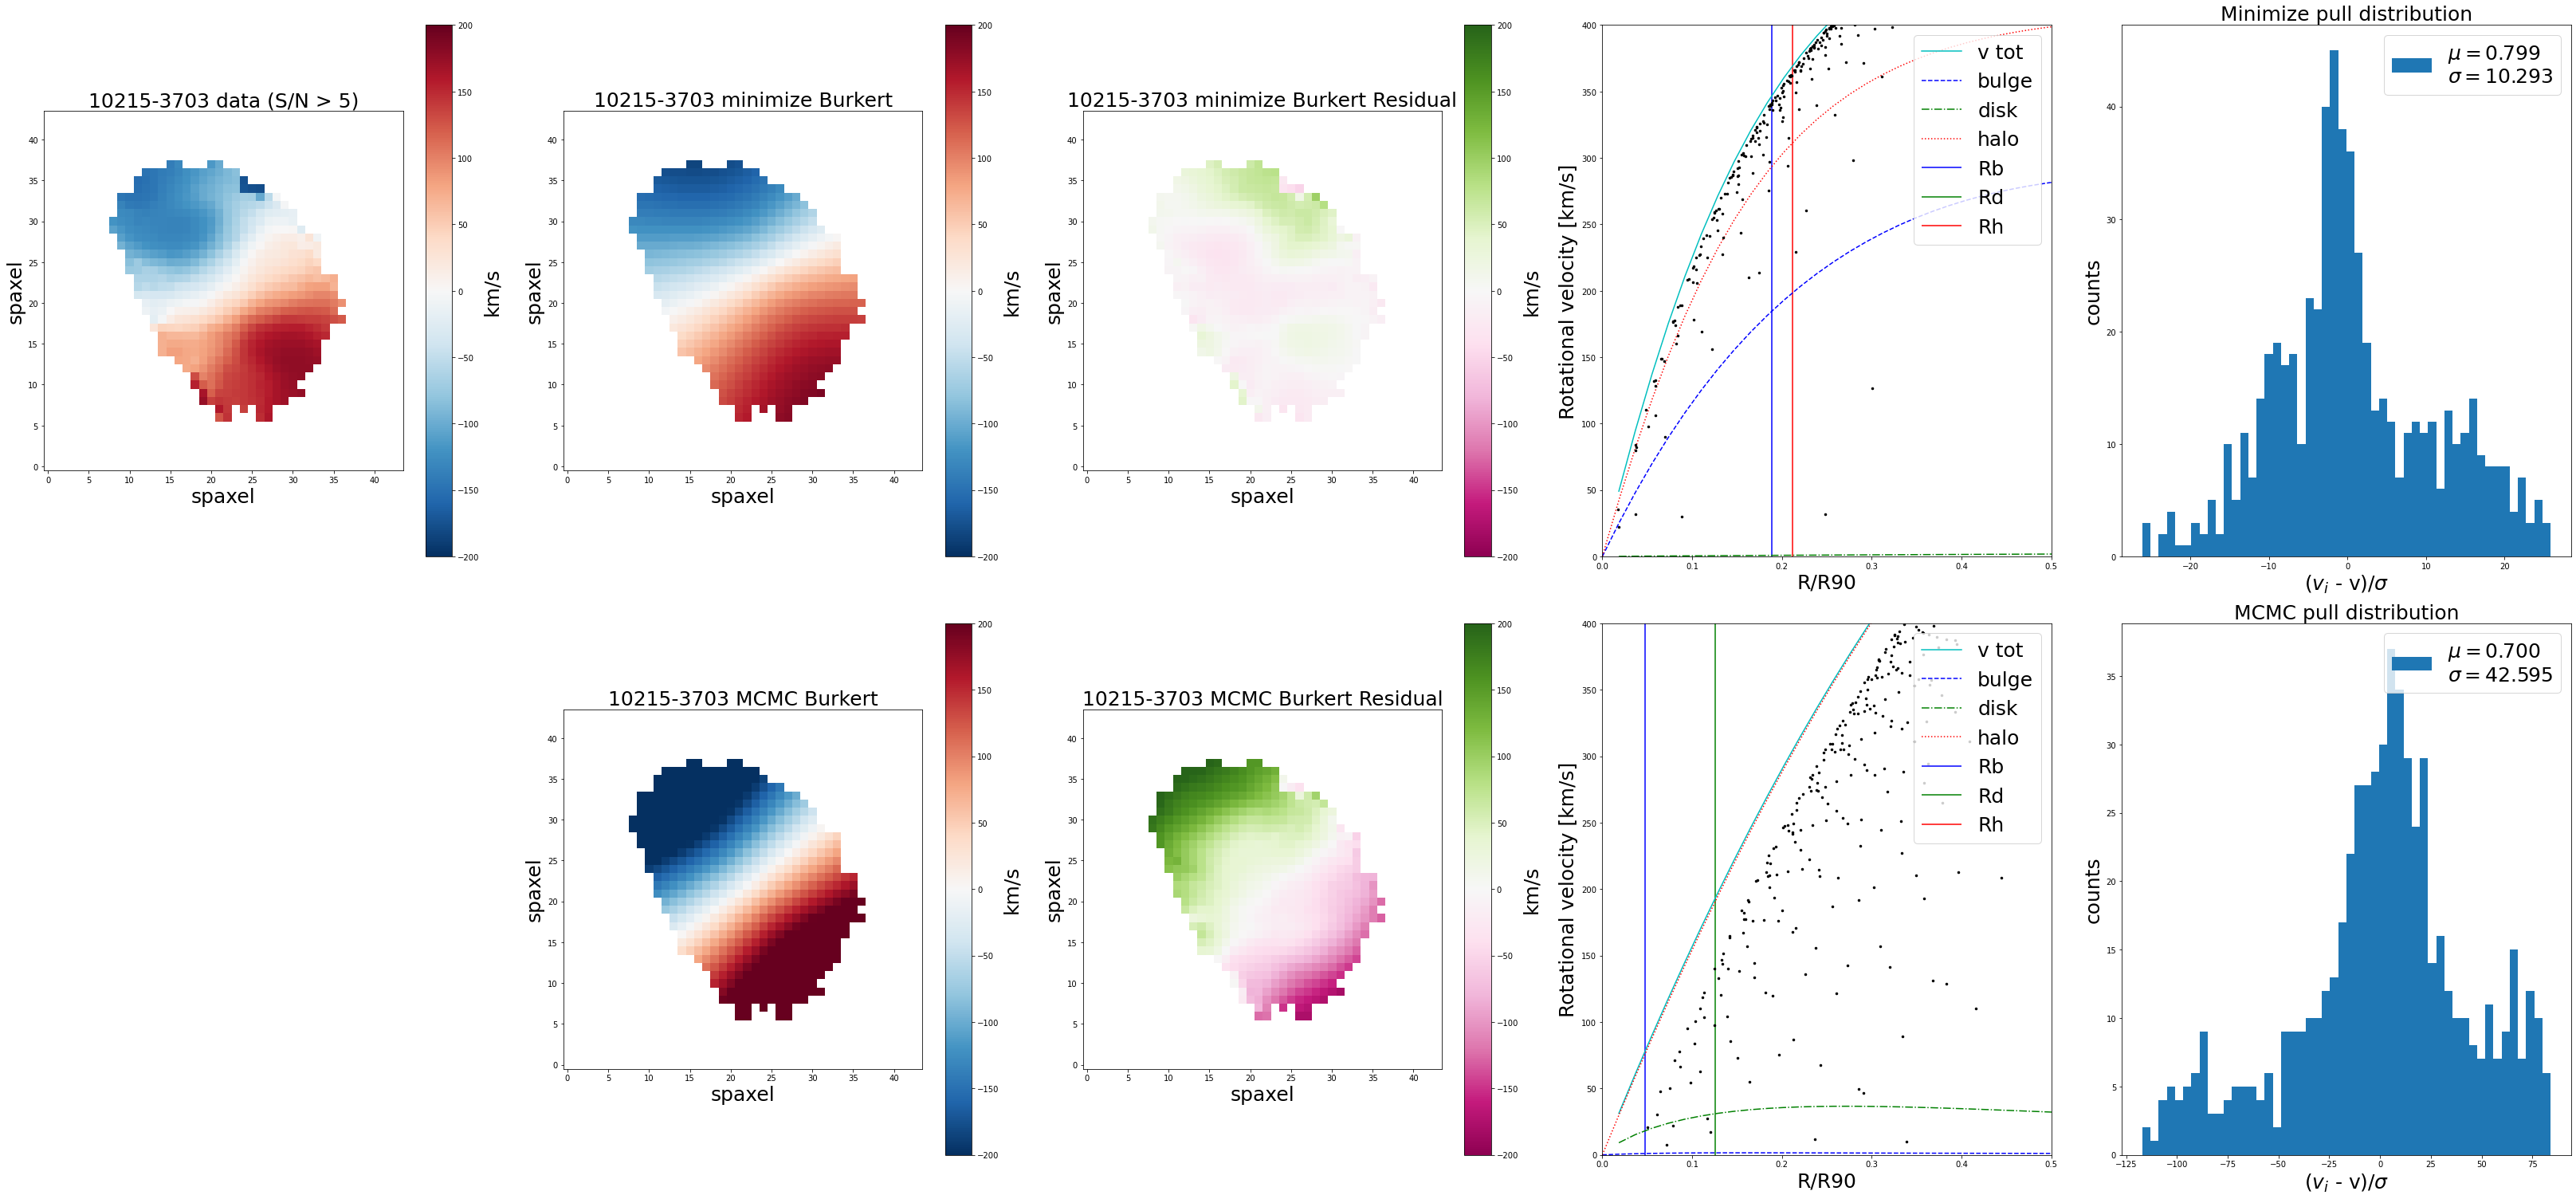

In [118]:
# Burkert - 10215-3703

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10215_3703, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3703 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10215_3703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3703 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10215_3703, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3703 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10215_3703 - mini_map_10215_3703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3703 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10215_3703 - mcmc_map_10215_3703, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10215-3703 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10215_3703/r90_10215_3703, v_mini_10215_3703, 'c',label='v tot')
plt.plot(r_mini_10215_3703/r90_10215_3703, v_b_mini_10215_3703, 'b--',label='bulge')
plt.plot(r_mini_10215_3703/r90_10215_3703, v_d_mini_10215_3703,'g-.',label='disk')
plt.plot(r_mini_10215_3703/r90_10215_3703, v_h_mini_10215_3703,'r:',label='halo')

plt.vlines(x = mini_fit_10215_3703[1]/r90_10215_3703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10215_3703[3]/r90_10215_3703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10215_3703[5]/r90_10215_3703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10215_3703/r90_10215_3703, vm_deproj_mini_10215_3703, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10215_3703/r90_10215_3703, v_mcmc_10215_3703, 'c',label='v tot')
plt.plot(r_mcmc_10215_3703/r90_10215_3703, v_b_mcmc_10215_3703, 'b--',label='bulge')
plt.plot(r_mcmc_10215_3703/r90_10215_3703, v_d_mcmc_10215_3703,'g-.',label='disk')
plt.plot(r_mcmc_10215_3703/r90_10215_3703, v_h_mcmc_10215_3703,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10215_3703))

plt.vlines(x = mcmc_fit_10215_3703[1]/r90_10215_3703,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10215_3703[3]/r90_10215_3703,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10215_3703[5]/r90_10215_3703,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10215_3703/r90_10215_3703, vm_deproj_mcmc_10215_3703, 'k.', markersize=5)

plt.xlim([0,0.5])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10215_3703 = dmap_10215_3703 - mini_map_10215_3703

dist_minimize_Burkert_10215_3703 = residual_minimize_Burkert_10215_3703*np.sqrt(ivar_masked_10215_3703)

residual_mcmc_Burkert_10215_3703 = dmap_10215_3703 - mcmc_map_10215_3703

dist_mcmc_Burkert_10215_3703 = residual_mcmc_Burkert_10215_3703*np.sqrt(ivar_masked_10215_3703)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10215_3703 = ma.mean(dist_minimize_Burkert_10215_3703)
sig_mini_Burkert_10215_3703 = ma.std(dist_minimize_Burkert_10215_3703)

n_mini_Burkert_10215_3703, bins_mini_Burkert_10215_3703, patches_mini_Burkert_10215_3703 = plt.hist(dist_minimize_Burkert_10215_3703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10215_3703, sig_mini_Burkert_10215_3703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10215_3703 = ma.mean(dist_mcmc_Burkert_10215_3703)
sig_mcmc_Burkert_10215_3703 = ma.std(dist_mcmc_Burkert_10215_3703)

n_mcmc_Burkert_10215_3703, bins_mcmc_Burkert_10215_3703, patches_mcmc_Burkert_10215_3703 = plt.hist(dist_mcmc_Burkert_10215_3703.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10215_3703, sig_mcmc_Burkert_10215_3703))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10215_3703))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10215_3703))
print('r$R_{90}$: ' + str(r90_10215_3703) + ' kpc')
print('Incl from data: ' + str(incl_10215_3703))
print('Incl from Minimize: ' + str(mini_fit_10215_3703[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10215_3703[-5]))

Minimize r$\chi^2$ : 18.539337972480045
MCMC r$\chi^2$ : 1098.9353080534243
r$R_{90}$: 7.835508346557617 kpc
Incl from data: 0.9344340517361431
Incl from Minimize: 0.7562341552204435
Incl from MCMC: 0.7686824321902885


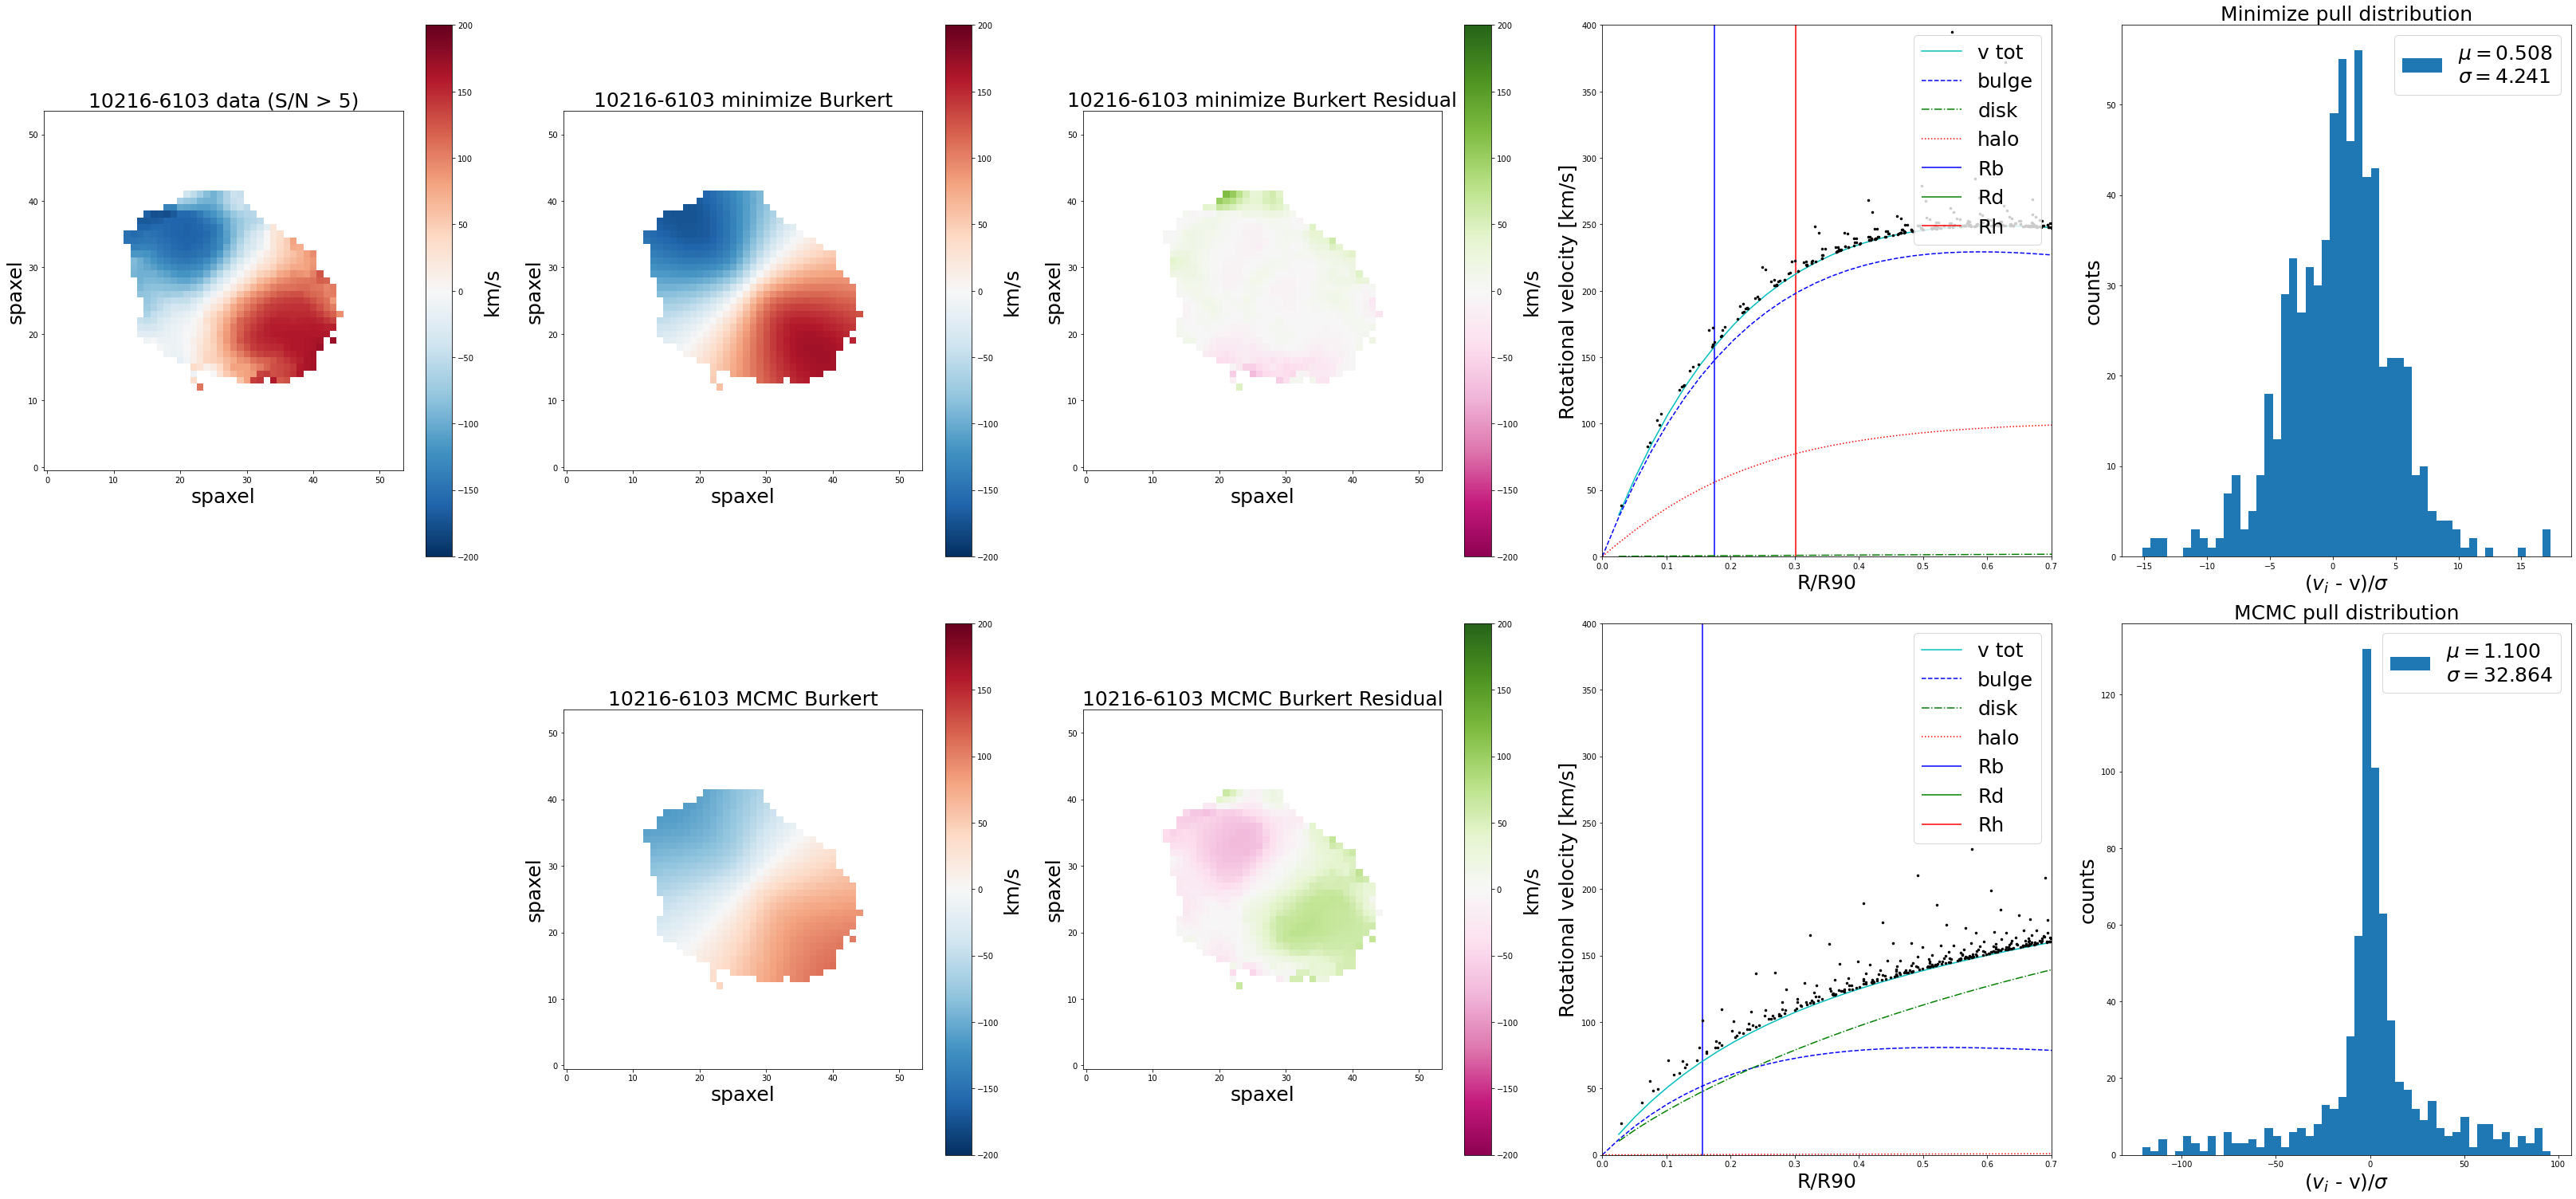

In [121]:
# Burkert - 10216-6103

plt.figure(figsize=(45,21)) #tight_layout=True)

################################################################################
# Original data
#-------------------------------------------------------------------------------
plt.subplot(2,5,1)

data = plt.imshow(dmap_10216_6103, 
                      origin='lower', 
                      cmap='RdBu_r', 
                      vmin=-200, 
                      vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(data)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 data (S/N > 5)', fontsize=25)
################################################################################

################################################################################
# minimize model
#-------------------------------------------------------------------------------
plt.subplot(2,5,2)

map_minimize = plt.imshow(mini_map_10216_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 minimize Burkert', fontsize=25)
################################################################################


################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,7)

map_mcmc = plt.imshow(mcmc_map_10216_6103, 
                              origin='lower',
                              cmap='RdBu_r', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 MCMC Burkert', fontsize=25)
################################################################################

################################################################################
# minimize model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,3)

map_minimize = plt.imshow(dmap_10216_6103 - mini_map_10216_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_minimize)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 minimize Burkert Residual', fontsize=25)
################################################################################


################################################################################
# MCMC model residual
#-------------------------------------------------------------------------------
plt.subplot(2,5,8)

map_mcmc = plt.imshow(dmap_10216_6103 - mcmc_map_10216_6103, 
                              origin='lower',
                              cmap='PiYG', 
                              vmin=-200, 
                              vmax=200)

plt.xlabel('spaxel', fontsize=25)
plt.ylabel('spaxel', fontsize=25)

cbar = plt.colorbar(map_mcmc)
cbar.set_label('km/s', fontsize=25)

plt.title('10216-6103 MCMC Burkert Residual', fontsize=25)
################################################################################

################################################################################
# Minimize 1D rotation Curve
#-------------------------------------------------------------------------------
plt.subplot(2,5,4)

plt.plot(r_mini_10216_6103/r90_10216_6103, v_mini_10216_6103, 'c',label='v tot')
plt.plot(r_mini_10216_6103/r90_10216_6103, v_b_mini_10216_6103, 'b--',label='bulge')
plt.plot(r_mini_10216_6103/r90_10216_6103, v_d_mini_10216_6103,'g-.',label='disk')
plt.plot(r_mini_10216_6103/r90_10216_6103, v_h_mini_10216_6103,'r:',label='halo')

plt.vlines(x = mini_fit_10216_6103[1]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mini_fit_10216_6103[3]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mini_fit_10216_6103[5]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mini_10216_6103/r90_10216_6103, vm_deproj_mini_10216_6103, 'k.', markersize=5)

plt.xlim([0,0.7])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

################################################################################
# MCMC model
#-------------------------------------------------------------------------------
plt.subplot(2,5,9)

plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_mcmc_10216_6103, 'c',label='v tot')
plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_b_mcmc_10216_6103, 'b--',label='bulge')
plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_d_mcmc_10216_6103,'g-.',label='disk')
plt.plot(r_mcmc_10216_6103/r90_10216_6103, v_h_mcmc_10216_6103,'r:',label='halo')

#vmax = np.max(np.abs(v_mcmc_10216_6103))

plt.vlines(x = mcmc_fit_10216_6103[1]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="b",label='Rb')
plt.vlines(x = mcmc_fit_10216_6103[3]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="g",label='Rd')
plt.vlines(x = mcmc_fit_10216_6103[5]/r90_10216_6103,ymin = 0, ymax = 1000,colors ="r",label='Rh')

plt.plot(rm_deproj_mcmc_10216_6103/r90_10216_6103, vm_deproj_mcmc_10216_6103, 'k.', markersize=5)

plt.xlim([0,0.7])
plt.ylim([0,400])
plt.xlabel('R/R90', fontsize=25)
plt.ylabel('Rotational velocity [km/s]', fontsize=25)
plt.legend(loc='upper right', fontsize=25)
################################################################################

residual_minimize_Burkert_10216_6103 = dmap_10216_6103 - mini_map_10216_6103

dist_minimize_Burkert_10216_6103 = residual_minimize_Burkert_10216_6103*np.sqrt(ivar_masked_10216_6103)

residual_mcmc_Burkert_10216_6103 = dmap_10216_6103 - mcmc_map_10216_6103

dist_mcmc_Burkert_10216_6103 = residual_mcmc_Burkert_10216_6103*np.sqrt(ivar_masked_10216_6103)

################################################################################
# minimize pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,5)

mean_mini_Burkert_10216_6103 = ma.mean(dist_minimize_Burkert_10216_6103)
sig_mini_Burkert_10216_6103 = ma.std(dist_minimize_Burkert_10216_6103)

n_mini_Burkert_10216_6103, bins_mini_Burkert_10216_6103, patches_mini_Burkert_10216_6103 = plt.hist(dist_minimize_Burkert_10216_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mini_Burkert_10216_6103, sig_mini_Burkert_10216_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('Minimize pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

################################################################################
# mcmc pull distribution
#-------------------------------------------------------------------------------
plt.subplot(2,5,10)

mean_mcmc_Burkert_10216_6103 = ma.mean(dist_mcmc_Burkert_10216_6103)
sig_mcmc_Burkert_10216_6103 = ma.std(dist_mcmc_Burkert_10216_6103)

n_mcmc_Burkert_10216_6103, bins_mcmc_Burkert_10216_6103, patches_mcmc_Burkert_10216_6103 = plt.hist(dist_mcmc_Burkert_10216_6103.compressed(),bins=50,
                                                       label='$\mu={:.3f}$\n$\sigma={:.3f}$'.format(mean_mcmc_Burkert_10216_6103, sig_mcmc_Burkert_10216_6103))

plt.xlabel('($v_i$ - v)/$\sigma$', fontsize=25)
plt.ylabel('counts', fontsize=25)
plt.title('MCMC pull distribution', fontsize=25)
plt.legend(loc='upper right', fontsize=25)

################################################################################

plt.tight_layout()

print('Minimize r$\chi^2$ : ' + str(chi2_mini_10216_6103))
print('MCMC r$\chi^2$ : ' + str(chi2_mcmc_10216_6103))
print('r$R_{90}$: ' + str(r90_10216_6103) + ' kpc')
print('Incl from data: ' + str(incl_10216_6103))
print('Incl from Minimize: ' + str(mini_fit_10216_6103[-5]))
print('Incl from MCMC: ' + str(mcmc_fit_10216_6103[-5]))